In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# __file__ = '/content/drive/MyDrive/aiffelthon/data'
__file__='/home/ogangza/path-finding-rl/wingHwi/'

## Env
- 경로 이동 제한 사항 반영: del apply_action() 수정
- def grid_box(self):  # 그리드 박스 초기화 용도로 정의
- 그리드값 변경
  - target_gridval (목표물)  = 10, 9, 8, ...
  - curloc_gridval (현 위치) = 1
  - default_gridval (기본)   = 0
  - rack_gridval (선반)      = -1
  - obs_gridval (장애물)     = -10
- 종료 조건
  - **그리드월드 밖**으로 나가는 경우 **종료하지 않음**
  - **장애물**에 부딪히는 경우 **종료**

In [2]:
from string import ascii_uppercase
import numpy as np
import pandas as pd
import os
import random
from datetime import datetime
import pytz
import matplotlib.pyplot as plt

###################################
# 보상 Reward
move_reward = -1  # 0.1
obs_reward = -10  # 0.1
goal_reward = 10  # 10
###################################
# 그리드값
# target_gridval = 10, 9, 8... # 목표물: 10, 9, 8, ...
curloc_gridval  = 1            # 현 위치: 1
default_gridval = 0            # 기본: 0
rack_gridval    = -1           # 선반: -1
obs_gridval     = -10          # 장애물: -10
###################################
# train / test 모드 지정
train_mode = True
###################################
print('reward:' , move_reward, obs_reward, goal_reward)

#__file__ = '/home/ogangza/heung_path_finding/path-finding-rl/data'

local_path = os.path.abspath(os.path.join(os.path.dirname(__file__)))

class Simulator:
    def __init__(self):
        # Load train or test data
        if train_mode:  # 훈련 데이타 읽기
            self.files = pd.read_csv(os.path.join(local_path, "data/factory_order_train.csv"))
            print('data/factory_order_train.csv used')
        else:           # 테스트 데이터 읽기
            self.files = pd.read_csv(os.path.join(local_path, "data/factory_order_test.csv"))
            print('data/factory_order_test.csv used')
        ##########################################################################################
        self.height = 10  # 그리드 높이
        self.width = 9    #  그리드 너비
        self.inds = list(ascii_uppercase)[:17]  # A ~ Q alphabet list

    def set_box(self):  # 선반 위치, 목적지 그리드값 설정. 목적지 리스트 생성
        box_data = pd.read_csv(os.path.join(local_path, "data/box.csv"))
        for box in box_data.itertuples(index = True, name ='Pandas'):  # 선반 위치: 그리드값 = rack_gridval
            self.grid[getattr(box, "row")][getattr(box, "col")] = rack_gridval
        order_item = list(set(self.inds) & set(self.items))
        order_csv = box_data[box_data['item'].isin(order_item)]
        for i, order_box in enumerate(order_csv.itertuples(index = True, name ='Pandas')):  # 목적지: 그리드값 = target_gridval
            self.grid[getattr(order_box, "row")][getattr(order_box, "col")] = 10 - i
            self.local_target.append([getattr(order_box, "row"), getattr(order_box, "col")])  # 목적지 리스트 생성: local_target
        # self.local_target.sort() # 불필요. 인풋 데이터 A, B, C순 정렬되어 있음... 정렬 필요시 코드 바꾸어야 함
        self.local_target.append([9,4]) # 목적지 리스트에 최종 목적지(9,4) 추가
        self.local_target_original = self.local_target.copy()  # gif 생성을 위해 추가.  에피소드의 경로 저장
        self.target_length = len(self.local_target_original)  # 목적지 그리드값 10, 9, 8, ... 지정 위해 추가
        self.grid[9,4] = 10 + 1 - self.target_length  # 최종 목적지 [9,4] 그리드값 지정 위해 추가

    def set_obstacle(self):  # 장애물 위치 그리드값 설정 = obs_gridval
        obstacles_data = pd.read_csv(os.path.join(local_path, "data/obstacles.csv"))
        for obstacle in obstacles_data.itertuples(index = True, name ='Pandas'):
            self.grid[getattr(obstacle, "row")][getattr(obstacle, "col")] = obs_gridval

    ########################################################################################################
    '''
    writer 신휘정
    step에서 아이템을 먹으면 self.items의 첫번째 요소를 pop해줍니다.
    그리고 새로운 item에 대해서 grid_box를 그려줍니다.
    '''
    ########################################################################################################
    def grid_box(self):  # 그리드 박스 초기화 용도로 정의: 선반, 목적지, 장애물 그리드값 초기화
        box_data = pd.read_csv(os.path.join(local_path, "data/box.csv"))
        for box in box_data.itertuples(index = True, name ='Pandas'):  # 선반 위치: 그리드값 = rack_gridval
            self.grid[getattr(box, "row")][getattr(box, "col")] = rack_gridval
        # order_item = list(set(self.inds) & set(self.items))
        if len(self.items) > 0:
            order_item = list(self.items)
            order_csv = box_data[box_data['item'].isin(order_item)]
            for i, order_box in enumerate(order_csv.itertuples(index = True, name ='Pandas')):  # 목적지: 그리드값 = target_gridval
                self.grid[getattr(order_box, "row")][getattr(order_box, "col")] = 10 - i
            self.grid[9,4] = 10 + 1 - self.target_length  # 최종 목적지 [9,4] 그리드값 지정 위해 추가
        else : 
            self.grid[9,4] = 10
        self.set_obstacle()  # 장애물 위치 그리드값 설정 = obs_gridval
        
    def reset(self, epi):  # 에피소드 시작시 12개 값 초기화
        self.epi = epi                                            #1. 에피소드 번호 받기
        self.items = eval(list(self.files.iloc[self.epi])[0])           #2. 에피소드의 목적지 받기: [ 'H', 'L', 'M']
        #####################################################################################
        # coin = random.randint(0,16)
        # self.items = [chr(coin+65)]  # A~Q 까지 1개 랜덤으로 받아서 items에 1개 넣어주기, 반복 횟수는 main의 epochs 조절하기
        ####################################################################################
        self.cumulative_reward = 0                                #3. 누적 보상값 = 0
        self.terminal_location = None                             #4. 최초 목적지
        self.local_target = []                                    #5. 목적지 리스트 초기화
        self.actions = []                                         #6. 지나온 경로 리스트 초기화
        self.grid = np.zeros((self.height, self.width), dtype="float16")  #7. 그리드월드 전체 그리드값(default_gridval) 초기화
        self.set_box()                                            #8. 선반 위치, 목적지 그리드값 설정. 목적지 리스트 생성
        self.set_obstacle()                                       #9. 장애물 그리드값 설정
        ######################
        # print('최초 그리드맵:')  # 그리드맵 확인
        # print(self.grid.reshape(10,9))
        ######################
        self.curloc = [9, 4]                                      #10. 현재 위치를 출발점으로 세팅
        self.grid[int(self.curloc[0])][int(self.curloc[1])] = curloc_gridval  #11. 현재 위치(출발점) 그리드값 세팅
        self.done = False                                         #12. 경로 찾기 종료 여부 = False
        self.goal_ob_reward = False                      # (추가) #13. 최종 목적지 도착 여부 = False
        ######################
        # print('현 위치 추가:')   # 그리드맵 확인
        # print(self.grid.reshape(10,9))
        ######################
        self.move_track = [[9,4]]                                  #14. 이동하는 경로를 저장하는 변수, 에피소드 시작시 에이전트가 [9,4]에 있으므로 [[9,4]]로 초기화
        self.isReset =  False                                      #15. 처음으로 terminal_location == 9,4가 되면, moveTrack을 초기화해주기 위해 필요한 변수 isFinal -> isReset 로 변경(처음으로 불러졌냐 안불러졌냐)
        self.prior_distance = 9999                                 #16. 이전 time step의 거리와 현재 거리를 비교하기 위해서 필요한 변수
        ######################
        self.wasGoal = False                                       # 17. 이전 step이 Goal이었는지 확인하는 변수
                                                                   # 이전 step이 Goal이었으면 먹고 나가야 하는 곳이 move_track이 곂치기 때문에 -보상받음. 이를 방지해기위한 FLAG
        return self.grid

    def apply_action(self, action, cur_x, cur_y):  # action에 따른 새 좌표값 반환
        new_x = cur_x
        new_y = cur_y
        if action == 0:          # up
            #new_x = cur_x - 1
            new_x = self.move_up(cur_x, cur_y, new_x, new_y)
        elif action == 1:        # down
            #new_x = cur_x + 1
            new_x = self.move_down(cur_x, cur_y, new_x, new_y)
        elif action == 2:        # left
            #new_y = cur_y - 1
            new_y = self.move_left(cur_x, cur_y, new_x, new_y)
        else:                    # right
            #new_y = cur_y + 1
            new_y = self.move_right(cur_x, cur_y, new_x, new_y)
        return int(new_x), int(new_y)
    
    # >>> 현재 위치에서 이동이 불가한 위치 추가 (시작) <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    def move_up(self, cur_x, cur_y, new_x, new_y):  # action == 0:
        if cur_x in [6,5,4,3,2] and cur_y in [0,8]:
            pass
        else:
            new_x = cur_x - 1
        return new_x
    def move_down(self, cur_x, cur_y, new_x, new_y): # action == 1:
        if cur_x in [1,2,3,4,5] and cur_y in [0,8]:
            pass
        else:
            new_x = cur_x + 1
        return new_x
    def move_left(self, cur_x, cur_y, new_x, new_y): # left elif action == 2:
        if cur_y in [1,2,3,4,5,6,7,8] and cur_x == 0:
            pass
        else:
            new_y = cur_y - 1
        return new_y
    def move_right(self, cur_x, cur_y, new_x, new_y): # right else: action == 3:
        if cur_y in [0,1,2,3,4,5,6,7] and cur_x == 0:
            pass
        else:
            new_y = cur_y + 1
        return new_y
    # >>> 추가 (끝) <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    def get_reward(self, new_x, new_y, out_of_boundary):  # action에 의해 이동시 얻는 보상
        if any(out_of_boundary):                                        # 바깥으로 나가는 경우
            reward = obs_reward
        else:
            if self.grid[new_x][new_y] == obs_gridval :     # 장애물에 부딪히는 경우
                reward = obs_reward
                self.grid[new_x][new_y] = curloc_gridval   # 현 위치(장애물)에서 종료되었음을 표시. 원래는 장애물이었음                
            elif self.grid[new_x][new_y] == rack_gridval:   # 선반에 부딪히는 경우
                reward = obs_reward
                new_x = self.curloc[0]  # 선반인 경우 못들어가고, 현재 위치로 유지
                new_y = self.curloc[1]  # 선반인 경우 못들어가고, 현재 위치로 유지
            elif new_x == self.terminal_location[0] and new_y == self.terminal_location[1]:  # 현재 목적지에 도달한 경우
                reward = goal_reward
                self.prior_distance = 9999                  # 목적지에 갈 때 prior_distance = 1이라, 나갈 때 무조건 prior_distance가 작아서 negative_reward를 받기때문에 여기서 못받도록 수정해줌.
            # 그냥 움직이는 경우 
            else: 
                cur_distance = self.get_distance()
                if self.prior_distance > cur_distance :                         # 이전의 거리 > 현재의 거리 = 현재 아이템에 더 가깝다 => + 보상얻기
                    reward = self.get_positive_distance_reward(cur_distance)
                else:                                                           # 이전의 거리 < 현재의 거리 = 현재 아이템에서 멀어졌다 => - 보상얻기
                    reward = self.get_negative_distance_reward(cur_distance)
                self.prior_distance = cur_distance      

                if [new_x, new_y] not in self.move_track:                           # 이동한 곳이 처음온 곳이면 move_track에 추가
                    self.move_track.append([new_x, new_y])
                else:                                                           # 이동한 곳이 이미 왔던 곳이면 기존 보상에서 -1
                    reward = reward -1
        return reward

    def step(self, action):  # action에 따른 이동 실행
        self.terminal_location = self.local_target[0]           # 목적지 리스트의 첫 번째 요소를 목적지로 설정
        cur_x, cur_y = self.curloc                              # 현재 위치 기억
        new_x, new_y = self.apply_action(action, cur_x, cur_y)  # 다음 위치 받기
        self.actions.append((cur_x, cur_y))                     # 현재 위치(지나온 위치)를 경로 리스트에 추가
        self.goal_ob_reward = False                             # 최종 목적지에 도착한 경우에 True. self.reset()에서 초기화
        out_of_boundary = [new_x < 0, new_x >= self.height, new_y < 0, new_y >= self.width]  # 그리드월드 밖으로 나갔는가? OB = True

        if any(out_of_boundary):  #1. 바깥으로 나가는 경우, 빈 선반에 부딪치는 경우 종료하지 않음
            #print('OB')
            new_x = cur_x  # 종료 처리할 경우 코멘트 처리
            new_y = cur_y  # 종료 처리할 경우 코멘트 처리
            ######################################################종료 처리할 경우 실행
            #self.done = True                             # while loop 종료
            #self.grid_box()                              # 선반, 목적지, 장애물 그리드값 초기화
            #self.actions.append((new_x,new_y))           # 경로 리스트에 최종 위치 추가. (주의) 좌표값이 그리드월드를 벗어나는 값 발생!
            ######################################################
        else:
            if self.grid[new_x][new_y] == obs_gridval:  #2. 장애물에 부딪히는 경우 종료
                # print('장애물')
                # new_x = cur_x  # 종료 처리할 경우 코멘트 처리
                # new_y = cur_y  # 종료 처리할 경우 코멘트 처리
                ###################################################종료 처리할 경우 실행
                self.done = True                           # while loop 종료
                self.grid[cur_x][cur_y] = default_gridval  # 현 위치의 그리드값을 기본값으로 초기화
                self.grid_box()                            # 선반, 목적지, 장애물 그리드값 초기화
                self.actions.append((new_x,new_y))         # 경로 리스트에 최종 위치 추가
                ###################################################
            elif self.grid[new_x][new_y] == rack_gridval:
                pass
            elif new_x == self.terminal_location[0] and new_y == self.terminal_location[1]:  #3. 현재 목적지에 도착한 경우 다음 목적지 설정
                #print('목적지 도착')
                if [new_x, new_y] == [9, 4]:            #3-1. 최종 목적지에 도착한 경우 종료
                    self.done = True                       # while loop 종료
                    self.goal_ob_reward = True             # True = 1 (OB, 장애물 종료 처리 할 경우 self.done=True가 많아지므로 이때 사용)
                    self.actions.append((new_x,new_y))     # 경로 리스트에 최종 위치 추가
                ########################################################################################################
                '''
                writer 신휘정
                기존 : 아이템을 먹어도 에피소드 동안 목적지, 선반 숫자는 유지됨.
                현재 : 아이템을 먹으면 남은 아이템에 대해서 숫자가 새로 칠해짐
                '''
                if len(self.items) > 0:
                    self.items.remove(self.items[0])            # 아이템을 하나먹었으니, 아이템의 첫번째 값을 삭제해줌
                    self.wasGoal = True
                    self.move_track.pop()                       # 아이템을 들어가고 나오는 위치는 동일(주황색동그라미) => 이미 왔던경로라고 - 리워드 못받게 하기위해 마지막 요소 pop()
                ########################################################################################################                    

                self.local_target.remove(self.local_target[0])  # 다음 목적지 설정. 최종 목적지에 도착한 경우에는 마지막 요소인 [9,4]를  제거
                self.grid[cur_x][cur_y] = default_gridval  # 현 위치의 그리드값을 기본값으로 초기화
                self.grid_box()                            # 선반, 목적지, 장애물 그리드값 초기화
                self.grid[new_x][new_y] = curloc_gridval   # 현 위치(목적지)에서 종료되었음을 표시. 원래는 목적지이었음
                self.curloc = [new_x, new_y]               # 새로 도착한 위치를 현재 위치로 변경
            
            else:                                       #4. 그냥 움직이는 경우
                #print('이동')
                ########################################################################################################
                '''
                writer 신휘정
                기존 : 아이템을 먹어도 에피소드 동안 목적지, 선반 숫자는 유지됨.
                현재 : 아이템을 먹으면 해당 선반은 빈선반으로 바뀜
                '''
                if self.wasGoal:
                    self.grid[cur_x][cur_y] = rack_gridval     # 현 위치의 그리드값을 선반값으로 초기화
                    self.wasGoal = False
                else:
                    self.grid[cur_x][cur_y] = default_gridval  # 현 위치의 그리드값을 기본값으로 초기화
                ########################################################################################################
                self.grid_box()                            # 선반, 목적지, 장애물 그리드값 초기화
                self.grid[new_x][new_y] = curloc_gridval   # 현 위치에서 종료되었음을 표시
                self.curloc = [new_x,new_y]

        ############################### 보상받는 처리 시작 ###############################
        # 마지막 위치에서 위로 올라가는 행동을 한다면 - 보상받음 태양
        if len(self.local_target) == 1:                             # local_target이 remove되고 나면 길이가 1이되는 경우 = [9,4]만 있는 경우
            if not self.isReset:                                    # 처음으로 terminal_location == [9,4]가 되었다면,,
                self.move_track = []                                # 아이템을 찾으러 돌아다니는 경로 초기화
                self.isReset = True                                 # move_track이 초기화 되었으니 isReset = True
            reward = self.get_reward(new_x, new_y, out_of_boundary)
            if action == 0:
                reward = obs_reward                                # terminal_location == [9,4]로 갈 때 위로 올라가는거 금지
        else : 
            reward = self.get_reward(new_x, new_y, out_of_boundary)
        ############################### 보상받는 처리 끝 ###############################   

        self.cumulative_reward += reward
        return self.grid, reward, self.cumulative_reward, self.done

    # >>> distance를 입력으로 받아 + 보상을 계산하는 메소드 (시작) <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 
    def get_positive_distance_reward(self, distance):
        positive_reward = (20 - distance) / 200     # 0.095 ~ 0.001
        return positive_reward
    # >>> 추가 (끝) <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    # >>> distance를 입력으로 받아 - 보상을 계산하는 메소드 (시작) <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    def get_negative_distance_reward(self, distance):
        negative_reward = -(distance / 200)
        return negative_reward
    # >>> 추가 (끝) <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<    

    # >>> 현재 위치에서 타겟까지의 거리를 구하는 메소드 (시작) <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    def get_distance(self): 
        cur_x, cur_y, target_x, target_y = self.get_current_state()        
        distance = (abs(cur_x-target_x) + abs(cur_y-target_y))
        # print(cur_x, cur_y, target_x, target_y)
        # print('distance : ', distance)
        return distance
    # >>> 추가 (끝) <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<    

    # >>> 현재 상황에 대한 정보를 구하는 메소드 (시작) <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    def get_current_state(self):
        # if len(self.local_target) != 1:
        #     state = (self.curloc[0], self.curloc[1], self.local_target[0][0], self.local_target[0][1])
        # else :
        state = (self.curloc[0], self.curloc[1], self.terminal_location[0], self.terminal_location[1])
        return np.array(state) #(cur_x, cur_y, tar_x, tar_y)
    # >>> 추가 (끝) <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<        


reward: -1 -10 10


## Agent
- def test_action(self, obs): 추가

In [3]:
import collections
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ReplayBuffer():  # 리플레이 버퍼: 경험 저장소
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):  # 리플레이 버퍼(메모리)를 경험(transition)으로 채우기
        self.buffer.append(transition)
    
    def sample(self, n):  # memory.sample(batch_size)로 사용
        mini_batch = random.sample(self.buffer, n)  # 미니배치 샘플링
        '''
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        for transition in mini_batch:  # 경험의 각 요소들을 각각의 미니배치로 구성
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])
        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)
        '''
        state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in mini_batch])
        action_batch = torch.Tensor([[a] for (s1,a,r,s2,d) in mini_batch])      # a를 tensor에 넣을 때는 [리스트]에 꼭 씌워주세요
        reward_batch = torch.Tensor([[r] for (s1,a,r,s2,d) in mini_batch])      # reward를 tensor에 넣을 때는 [리스트]에 꼭 씌워주세요
        state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in mini_batch])
        done_batch = torch.Tensor([[d] for (s1,a,r,s2,d) in mini_batch])        # done를 tensor에 넣을 때는 [리스트]에 꼭 씌워주세요

        return state1_batch, action_batch, reward_batch, state2_batch, done_batch
    
    def size(self):  # 메모리 크기
        return len(self.buffer)

class Qnet(nn.Module):
    '''##### Linear 모델 #####
    def __init__(self):
        super(Qnet, self).__init__()

        in_size = 90  # input 크기
        L1 = 250
        L2 = 150
        out_size  = 4

        self.fc1 = nn.Linear(in_size, L1)
        self.fc2 = nn.Linear(L1, L2)
        self.fc3 = nn.Linear(L2, out_size)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    '''
    ##### Convolution 모델 #####
    def __init__(self):
        super(Qnet, self).__init__()

        self.conv1 = nn.Conv2d(4, 32, 3, 1) #### 1이었던 부분을 4로 변경
        self.conv2 = nn.Conv2d(32, 64, 3, 1) #### in_채널, out_channel, kernel_size, stride
        self.conv3 = nn.Conv2d(64, 64, 3, 1)
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 4)

    def forward(self, x):
        x = x.to(device)               # (N, 4, 10, 9)
        x = F.relu(self.conv1(x))      # (N, 32, 8, 7)
        x = F.relu(self.conv2(x))      # (N, 64, 6, 5)
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)        # (N, 64, 30)
        x = F.relu(self.fc1(x))        # (N, 1920) -> (N, 128)
        x = self.fc2(x)                # (N, 128)  -> (N, 4)
        return x

    def sample_action(self, obs, epsilon):  # Qnet()을 실행해서 모든 action에 대한 Qval을 구한 후 action 선택
        out = self.forward(obs)  # out = Q_value, obs = state = 그리드맵
        coin = random.random()  # e-greedy로 action 선택
        if coin < epsilon:
            return random.randint(0,3)
        else : 
            return out.argmax().item()
    
    def test_action(self, obs):  # Qnet()을 실행해서 모든 action에 대한 Qvalue을 구한 후 action 선택
        out = self.forward(obs)  # out = Q_value, obs = state = 그리드맵
        return out.argmax().item()

##################################################### DOUBLE _ DQN ######################################################       
def train(q, q_target, memory, optimizer):  # 메모리에 경험이 미니배치 크기 이상 쌓이면 미니배치 훈련 시작
    s,a,r,s_prime,done_mask = memory.sample(batch_size)  # 메모리에서 미니배치를 뽑기: batch_size=1600
    
    q_out = q(s)  # Qnet의 Qvalue
    q_a = q_out.gather(dim=1,index=a.long().to(device)) # Qnet의 Qvalue 변환

    with torch.no_grad():
        q_prime_idx = q(s_prime).max(1)[1]                                      # output : tensor (8)
        max_q_primes = q_target(s_prime)                                        # output : tensor (8, 4)
        max_q_prime = max_q_primes.gather(1, q_prime_idx.unsqueeze(1))          # output : tensor (8, 1)

    Y = r.to(device) + gamma * max_q_prime * done_mask.to(device)               # output : tensor (8, 1)

    loss = F.smooth_l1_loss(q_a, Y.detach())
    #loss = nn.MSELoss(X.to(torch.float32), Y.detach().to(torch.float32))  # 손실함수 변경. target.detach()로 변경
    optimizer.zero_grad()  # gradient값 초기화
    loss.backward()  # 자동미분
    optimizer.step()  # gradient 업데이트
    return loss.item()
##################################################### DOUBLE _ DQN ######################################################       

########################################################## DQN ##########################################################
# def train(q, q_target, memory, optimizer):  # 메모리에 경험이 미니배치 크기 이상 쌓이면 미니배치 훈련 시작
#     '''
#     for i in range(10):
#         s, a, r, cr, s_prime, done_mask, gr = memory.sample(batch_size)
#         q_out = q(s)
#         q_a = q_out.gather(1,a.to(device))
        
#         max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
#         target = r.to(device) + gamma * max_q_prime * done_mask.to(device)
        
#         loss = F.smooth_l1_loss(q_a, target)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     '''
    # s,a,r,s_prime,done_mask = memory.sample(batch_size)  # 메모리에서 미니배치를 뽑기: batch_size=1600
    # Q1 = q(s)  # Qnet의 Qvalue
    # X = Q1.gather(dim=1,index=a.long().unsqueeze(dim=1).to(device)).squeeze() # Qnet의 Qvalue 변환
    # with torch.no_grad():
    #     Q2 = q_target(s_prime)
    # Y = r.to(device) + gamma * done_mask.to(device) * torch.max(Q2,dim=1)[0]
    # loss = F.smooth_l1_loss(X, Y.detach())
    # #loss = nn.MSELoss(X.to(torch.float32), Y.detach().to(torch.float32))  # 손실함수 변경. target.detach()로 변경
    # optimizer.zero_grad()  # gradient값 초기화
    # loss.backward()  # 자동미분
    # optimizer.step()  # gradient 업데이트
    # return loss.item()
########################################################## DQN ##########################################################

## Main: DQN...
  - GPU를 사용할 경우 구현
  - 학습한 모델 불러올 수 있는 코드 추가
    - '#' 제거하고 실행시키면 됨

tensor in cuda
data/factory_order_train.csv used
종료: done = True ... j = 400  move = 3
종료: done = True ... j = 1300  move = 5
종료: done = True ... j = 3500  move = 9
종료: done = True ... j = 4100  move = 10
종료: done = True ... j = 5000  move = 5
종료: done = True ... j = 6400  move = 17
종료: done = True ... j = 7600  move = 3
종료: done = True ... j = 8500  move = 11
종료: done = True ... j = 9300  move = 8
종료: done = True ... j = 9500  move = 7
종료: done = True ... j = 9600  move = 7
종료: done = True ... j = 9900  move = 5
종료: done = True ... j = 10200  move = 7
종료: done = True ... j = 11700  move = 7
종료: done = True ... j = 12900  move = 13
종료: done = True ... j = 13000  move = 15
종료: done = True ... j = 15200  move = 5
종료: done = True ... j = 16500  move = 5
종료: done = True ... j = 17300  move = 9
종료: done = True ... j = 18500  move = 17
종료: done = True ... j = 18900  move = 19
종료: done = True ... j = 19000  move = 9
종료: done = True ... j = 19700  move = 5
종료: done = True ... j = 19800  move =

종료: done = True ... j = 117600  move = 14
epiode #: 12291 loss: 0.08078964054584503 j: 118000
종료: done = True ... j = 118800  move = 3
epiode #: 12362 loss: 0.035101789981126785 j: 119000
epiode #: 12430 loss: 0.027176331728696823 j: 120000
종료: done = True ... j = 120000  move = 21
종료: done = True ... j = 120600  move = 7
종료: done = True ... j = 120700  move = 4
epiode #: 12510 loss: 0.024488108232617378 j: 121000
epiode #: 12575 loss: 0.021947693079710007 j: 122000
epiode #: 12647 loss: 0.021653933450579643 j: 123000
epiode #: 12710 loss: 0.02567121759057045 j: 124000
종료: done = True ... j = 124000  move = 26
epiode #: 12778 loss: 0.019075268879532814 j: 125000
종료: done = True ... j = 125700  move = 10
epiode #: 12837 loss: 0.06923497468233109 j: 126000
epiode #: 12897 loss: 0.02159562148153782 j: 127000
종료: done = True ... j = 127200  move = 24
종료: done = True ... j = 127900  move = 5
epiode #: 12961 loss: 0.028109990060329437 j: 128000
종료: done = True ... j = 128500  move = 7
종료: do

epiode #: 16616 loss: 0.09403422474861145 j: 218000
종료: done = True ... j = 218400  move = 114
epiode #: 16631 loss: 0.12794770300388336 j: 219000
종료: done = True ... j = 219600  move = 25
epiode #: 16648 loss: 0.09357162564992905 j: 220000
종료: done = True ... j = 220400  move = 39
epiode #: 16662 loss: 0.09272243082523346 j: 221000
[[3, 0], [0, 2], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 221780  move = 40 @ 에피소드 # 16676
16676번째 에피소드까지 총 9번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 2], [0, 3], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 221829  move = 49 @ 에피소드 # 16677
16677번째 에피소드까지 총 10번 finish 했습니다.
epiode #: 16682 loss: 0.12388893216848373 j: 222000
[[4, 0], [3, 0], [0, 1], [0, 2], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 222684  move = 53 @ 에피소드 # 16696
16696번째 에피소드까지 총 11번 finish 했습니다.
epiode #: 16704 loss: 0.10094159096479416 j: 223000
[[5, 0], [3, 0], [0, 1], [0, 3], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 22346

[[3, 0], [0, 1], [0, 3], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 243577  move = 52 @ 에피소드 # 17233
17233번째 에피소드까지 총 49번 finish 했습니다.
[[2, 0], [0, 3], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 243746  move = 71 @ 에피소드 # 17237
17237번째 에피소드까지 총 50번 finish 했습니다.
epiode #: 17245 loss: 0.1342354416847229 j: 244000
[[5, 0], [0, 3], [0, 6], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 244039  move = 44 @ 에피소드 # 17245
17245번째 에피소드까지 총 51번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 5], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 244137  move = 44 @ 에피소드 # 17248
17248번째 에피소드까지 총 52번 finish 했습니다.
[[5, 0], [0, 1], [0, 3], [0, 4], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 244192  move = 48 @ 에피소드 # 17250
17250번째 에피소드까지 총 53번 finish 했습니다.
종료: done = True ... j = 244300  move = 4
epiode #: 17279 loss: 0.13685834407806396 j: 245000
[[5, 0], [0, 1], [0, 2], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_

[[3, 0], [0, 2], [0, 5], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 255691  move = 44 @ 에피소드 # 17551
17551번째 에피소드까지 총 96번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 255753  move = 38 @ 에피소드 # 17553
17553번째 에피소드까지 총 97번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 3], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 255819  move = 40 @ 에피소드 # 17555
17555번째 에피소드까지 총 98번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 4], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 255986  move = 44 @ 에피소드 # 17559
17559번째 에피소드까지 총 99번 finish 했습니다.
epiode #: 17560 loss: 0.21392770111560822 j: 256000
[[4, 0], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 256415  move = 40 @ 에피소드 # 17567
17567번째 에피소드까지 총 100번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 1], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 256775  move = 86 @ 에피소드 # 17571
17571번째 에피소드까지 총 101번 finish 했습니다.
[[0, 2], [0, 4

[[2, 0], [0, 0], [0, 4], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 266090  move = 43 @ 에피소드 # 17746
17746번째 에피소드까지 총 143번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 3], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 266136  move = 46 @ 에피소드 # 17747
17747번째 에피소드까지 총 144번 finish 했습니다.
[[3, 0], [0, 3], [0, 5], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 266333  move = 87 @ 에피소드 # 17749
17749번째 에피소드까지 총 145번 finish 했습니다.
[[0, 3], [0, 4], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 266379  move = 46 @ 에피소드 # 17750
17750번째 에피소드까지 총 146번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 6], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 266425  move = 46 @ 에피소드 # 17751
17751번째 에피소드까지 총 147번 finish 했습니다.
[[5, 0], [0, 2], [0, 3], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 266470  move = 45 @ 에피소드 # 17752
17752번째 에피소드까지 총 148번 finish 했습니다.
[[4, 0], [0, 1], [0, 5], [3, 8

[[5, 0], [4, 0], [0, 0], [0, 3], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 276286  move = 62 @ 에피소드 # 17912
17912번째 에피소드까지 총 190번 finish 했습니다.
[[2, 0], [0, 3], [0, 4], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 276370  move = 44 @ 에피소드 # 17915
17915번째 에피소드까지 총 191번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 6], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 276468  move = 58 @ 에피소드 # 17917
17917번째 에피소드까지 총 192번 finish 했습니다.
[[0, 0], [0, 1], [0, 5], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 276538  move = 60 @ 에피소드 # 17919
17919번째 에피소드까지 총 193번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 3], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 276788  move = 44 @ 에피소드 # 17922
17922번째 에피소드까지 총 194번 finish 했습니다.
[[4, 0], [0, 2], [0, 3], [0, 4], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 276949  move = 85 @ 에피소드 # 17925
17925번째 에피소드까지 총 195번 finish 했습니다

[[5, 0], [2, 0], [0, 1], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 286560  move = 57 @ 에피소드 # 18087
18087번째 에피소드까지 총 237번 finish 했습니다.
[[0, 0], [0, 2], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 286697  move = 42 @ 에피소드 # 18090
18090번째 에피소드까지 총 238번 finish 했습니다.
[[2, 0], [0, 1], [0, 3], [0, 4], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 286745  move = 48 @ 에피소드 # 18091
18091번째 에피소드까지 총 239번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 286962  move = 131 @ 에피소드 # 18094
18094번째 에피소드까지 총 240번 finish 했습니다.
epiode #: 18095 loss: 0.2537517845630646 j: 287000
[[2, 0], [0, 1], [0, 2], [0, 4], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 287014  move = 52 @ 에피소드 # 18095
18095번째 에피소드까지 총 241번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 2], [0, 3], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 287266  move = 51 @ 에피소드 # 180

epiode #: 18258 loss: 0.18031544983386993 j: 298000
[[0, 0], [0, 1], [0, 2], [0, 3], [0, 5], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 298414  move = 109 @ 에피소드 # 18263
18263번째 에피소드까지 총 284번 finish 했습니다.
epiode #: 18274 loss: 0.21010221540927887 j: 299000
[[0, 1], [0, 4], [0, 5], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 299164  move = 50 @ 에피소드 # 18275
18275번째 에피소드까지 총 285번 finish 했습니다.
[[4, 0], [3, 0], [0, 3], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 299204  move = 40 @ 에피소드 # 18276
18276번째 에피소드까지 총 286번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 3], [0, 4], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 299307  move = 55 @ 에피소드 # 18278
18278번째 에피소드까지 총 287번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 3], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 299841  move = 43 @ 에피소드 # 18284
18284번째 에피소드까지 총 288번 finish 했습니다.
epiode #: 18285 loss: 0.20038607716560364 j: 300000
[[0, 0], [0, 4], [0, 7], [3,

[[5, 0], [0, 1], [0, 3], [0, 4], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 306894  move = 40 @ 에피소드 # 18400
18400번째 에피소드까지 총 332번 finish 했습니다.
epiode #: 18402 loss: 0.1348717212677002 j: 307000
종료: done = True ... j = 307300  move = 37
[[5, 0], [2, 0], [0, 0], [0, 3], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 307724  move = 114 @ 에피소드 # 18410
18410번째 에피소드까지 총 333번 finish 했습니다.
[[5, 0], [4, 0], [0, 4], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 307839  move = 45 @ 에피소드 # 18413
18413번째 에피소드까지 총 334번 finish 했습니다.
[[5, 0], [0, 0], [0, 4], [0, 5], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 307905  move = 66 @ 에피소드 # 18414
18414번째 에피소드까지 총 335번 finish 했습니다.
epiode #: 18416 loss: 0.19387349486351013 j: 308000
[[5, 0], [3, 0], [2, 0], [0, 2], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 308406  move = 48 @ 에피소드 # 18419
18419번째 에피소드까지 총 336번 finish 했습니다.
[[5, 0], [0, 1], [0, 4], [0, 7], [2, 8], [4, 8]

[[3, 0], [0, 3], [0, 4], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 316740  move = 48 @ 에피소드 # 18539
18539번째 에피소드까지 총 379번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [0, 3], [0, 4], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 316989  move = 48 @ 에피소드 # 18541
18541번째 에피소드까지 총 380번 finish 했습니다.
epiode #: 18542 loss: 0.16998320817947388 j: 317000
[[4, 0], [3, 0], [2, 0], [0, 3], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 317436  move = 45 @ 에피소드 # 18544
18544번째 에피소드까지 총 381번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 2], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 317556  move = 120 @ 에피소드 # 18545
18545번째 에피소드까지 총 382번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 317696  move = 140 @ 에피소드 # 18546
18546번째 에피소드까지 총 383번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 2], [0, 3], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 3178

[[3, 0], [2, 0], [0, 0], [0, 1], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 325261  move = 66 @ 에피소드 # 18661
18661번째 에피소드까지 총 426번 finish 했습니다.
[[4, 0], [0, 5], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 325303  move = 42 @ 에피소드 # 18662
18662번째 에피소드까지 총 427번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 4], [0, 5], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 325578  move = 49 @ 에피소드 # 18665
18665번째 에피소드까지 총 428번 finish 했습니다.
[[4, 0], [2, 0], [0, 3], [0, 5], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 325638  move = 60 @ 에피소드 # 18666
18666번째 에피소드까지 총 429번 finish 했습니다.
[[4, 0], [0, 5], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 325682  move = 44 @ 에피소드 # 18667
18667번째 에피소드까지 총 430번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 325811  move = 129 @ 에피소드 # 18668
18668번째 에피소드까지 총 431번 finish 했습니다.
epiode #: 18669 loss: 0.14881

[[3, 0], [2, 0], [0, 3], [0, 4], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 332719  move = 44 @ 에피소드 # 18767
18767번째 에피소드까지 총 474번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 0], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 332922  move = 58 @ 에피소드 # 18773
18773번째 에피소드까지 총 475번 finish 했습니다.
[[0, 2], [0, 4], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 332967  move = 45 @ 에피소드 # 18774
18774번째 에피소드까지 총 476번 finish 했습니다.
epiode #: 18775 loss: 0.16201259195804596 j: 333000
[[5, 0], [4, 0], [3, 0], [0, 4], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 333014  move = 47 @ 에피소드 # 18775
18775번째 에피소드까지 총 477번 finish 했습니다.
[[0, 0], [0, 2], [0, 4], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 333057  move = 43 @ 에피소드 # 18776
18776번째 에피소드까지 총 478번 finish 했습니다.
[[0, 0], [0, 3], [0, 4], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 333167  move = 42 @ 에피소드 # 18778
18778번째 에피소드까

[[4, 0], [3, 0], [2, 0], [0, 3], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 340116  move = 40 @ 에피소드 # 18871
18871번째 에피소드까지 총 522번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 1], [0, 2], [0, 3], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 340361  move = 44 @ 에피소드 # 18873
18873번째 에피소드까지 총 523번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 2], [0, 3], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 340483  move = 45 @ 에피소드 # 18875
18875번째 에피소드까지 총 524번 finish 했습니다.
[[2, 0], [0, 3], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 340521  move = 38 @ 에피소드 # 18876
18876번째 에피소드까지 총 525번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 4], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 340614  move = 52 @ 에피소드 # 18878
18878번째 에피소드까지 총 526번 finish 했습니다.
[[0, 1], [0, 3], [0, 4], [0, 5], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 340901  move = 121 @ 에피소드 # 18880
18880번째 에피소드까지 총 527번 finish 했습니

[[3, 0], [2, 0], [0, 3], [0, 5], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 348514  move = 40 @ 에피소드 # 18979
18979번째 에피소드까지 총 570번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 1], [0, 2], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 348605  move = 46 @ 에피소드 # 18981
18981번째 에피소드까지 총 571번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 348647  move = 42 @ 에피소드 # 18982
18982번째 에피소드까지 총 572번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 4], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 348699  move = 52 @ 에피소드 # 18983
18983번째 에피소드까지 총 573번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 3], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 348924  move = 42 @ 에피소드 # 18987
18987번째 에피소드까지 총 574번 finish 했습니다.
epiode #: 18988 loss: 0.11322221159934998 j: 349000
[[5, 0], [4, 0], [0, 1], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 349178  move = 105 @ 에

[[4, 0], [0, 2], [0, 5], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 355422  move = 40 @ 에피소드 # 19074
19074번째 에피소드까지 총 618번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 355666  move = 43 @ 에피소드 # 19076
19076번째 에피소드까지 총 619번 finish 했습니다.
epiode #: 19080 loss: 0.19535742700099945 j: 356000
[[5, 0], [3, 0], [0, 1], [0, 2], [0, 3], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 356017  move = 44 @ 에피소드 # 19080
19080번째 에피소드까지 총 620번 finish 했습니다.
[[3, 0], [0, 2], [0, 3], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 356143  move = 126 @ 에피소드 # 19081
19081번째 에피소드까지 총 621번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 2], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 356387  move = 43 @ 에피소드 # 19083
19083번째 에피소드까지 총 622번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 356433  move = 46 @ 에피소드 # 19084
19084번째 에피소드

epiode #: 19181 loss: 0.13021783530712128 j: 364000
[[2, 0], [0, 0], [0, 1], [0, 5], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 364386  move = 80 @ 에피소드 # 19183
19183번째 에피소드까지 총 666번 finish 했습니다.
epiode #: 19187 loss: 0.15006354451179504 j: 365000
[[3, 0], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 365157  move = 44 @ 에피소드 # 19190
19190번째 에피소드까지 총 667번 finish 했습니다.
[[2, 0], [0, 3], [0, 4], [0, 6], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 365205  move = 48 @ 에피소드 # 19191
19191번째 에피소드까지 총 668번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 365284  move = 79 @ 에피소드 # 19192
19192번째 에피소드까지 총 669번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 4], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 365372  move = 40 @ 에피소드 # 19194
19194번째 에피소드까지 총 670번 finish 했습니다.
[[0, 0], [0, 2], [0, 4], [0, 5], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_

[[0, 1], [0, 2], [0, 4], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 370986  move = 42 @ 에피소드 # 19274
19274번째 에피소드까지 총 714번 finish 했습니다.
epiode #: 19276 loss: 0.1313428282737732 j: 371000
[[3, 0], [0, 0], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 371043  move = 45 @ 에피소드 # 19276
19276번째 에피소드까지 총 715번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 3], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 371366  move = 46 @ 에피소드 # 19280
19280번째 에피소드까지 총 716번 finish 했습니다.
[[2, 0], [0, 0], [0, 2], [0, 3], [0, 4], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 371463  move = 62 @ 에피소드 # 19282
19282번째 에피소드까지 총 717번 finish 했습니다.
[[2, 0], [0, 0], [0, 3], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 371718  move = 54 @ 에피소드 # 19284
19284번째 에피소드까지 총 718번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 3], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 371771  move = 53 @ 에피소드 # 19285
19285번째 에피소드까지 총 719번 

[[0, 1], [0, 4], [0, 7], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 378851  move = 46 @ 에피소드 # 19387
19387번째 에피소드까지 총 762번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 4], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 378896  move = 45 @ 에피소드 # 19388
19388번째 에피소드까지 총 763번 finish 했습니다.
[[5, 0], [0, 1], [0, 3], [0, 4], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 378942  move = 46 @ 에피소드 # 19389
19389번째 에피소드까지 총 764번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 3], [0, 4], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 378989  move = 47 @ 에피소드 # 19390
19390번째 에피소드까지 총 765번 finish 했습니다.
epiode #: 19391 loss: 0.14107996225357056 j: 379000
[[5, 0], [0, 1], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 379098  move = 40 @ 에피소드 # 19393
19393번째 에피소드까지 총 766번 finish 했습니다.
[[5, 0], [0, 1], [0, 4], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 379143  move = 45 @ 에피소드 # 193

[[3, 0], [0, 1], [0, 2], [0, 4], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 384951  move = 42 @ 에피소드 # 19479
19479번째 에피소드까지 총 810번 finish 했습니다.
epiode #: 19480 loss: 0.1935669332742691 j: 385000
[[3, 0], [0, 0], [0, 2], [0, 3], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 385136  move = 53 @ 에피소드 # 19482
19482번째 에피소드까지 총 811번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 4], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 385186  move = 50 @ 에피소드 # 19483
19483번째 에피소드까지 총 812번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 385471  move = 38 @ 에피소드 # 19486
19486번째 에피소드까지 총 813번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 3], [0, 4], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 385792  move = 120 @ 에피소드 # 19488
19488번째 에피소드까지 총 814번 finish 했습니다.
[[4, 0], [2, 0], [0, 5], [0, 6], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 385849

[[0, 2], [0, 5], [0, 6], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 389476  move = 45 @ 에피소드 # 19550
19550번째 에피소드까지 총 859번 finish 했습니다.
[[2, 0], [0, 1], [0, 6], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 389757  move = 42 @ 에피소드 # 19553
19553번째 에피소드까지 총 860번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 389805  move = 48 @ 에피소드 # 19554
19554번째 에피소드까지 총 861번 finish 했습니다.
[[5, 0], [2, 0], [0, 2], [0, 4], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 389847  move = 42 @ 에피소드 # 19555
19555번째 에피소드까지 총 862번 finish 했습니다.
epiode #: 19556 loss: 0.11260422319173813 j: 390000
[[4, 0], [0, 3], [0, 4], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 390090  move = 42 @ 에피소드 # 19557
19557번째 에피소드까지 총 863번 finish 했습니다.
[[2, 0], [0, 0], [0, 3], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 390132  move = 42 @ 에피소드 # 19558
19558번째 에피소드까지 총 864번

[[3, 0], [0, 0], [0, 1], [0, 5], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 393991  move = 50 @ 에피소드 # 19620
19620번째 에피소드까지 총 908번 finish 했습니다.
epiode #: 19621 loss: 0.198721244931221 j: 394000
[[3, 0], [0, 0], [0, 2], [0, 3], [0, 4], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 394035  move = 44 @ 에피소드 # 19621
19621번째 에피소드까지 총 909번 finish 했습니다.
[[5, 0], [3, 0], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 394081  move = 46 @ 에피소드 # 19622
19622번째 에피소드까지 총 910번 finish 했습니다.
[[4, 0], [0, 0], [0, 4], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 394246  move = 42 @ 에피소드 # 19624
19624번째 에피소드까지 총 911번 finish 했습니다.
[[4, 0], [0, 1], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 394292  move = 46 @ 에피소드 # 19625
19625번째 에피소드까지 총 912번 finish 했습니다.
[[2, 0], [0, 3], [0, 6], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 394334  move = 42 @ 에피소드 # 19626

[[0, 2], [0, 5], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 398576  move = 54 @ 에피소드 # 19690
19690번째 에피소드까지 총 956번 finish 했습니다.
[[2, 0], [0, 0], [0, 2], [0, 5], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 398622  move = 46 @ 에피소드 # 19691
19691번째 에피소드까지 총 957번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 4], [0, 5], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 398672  move = 50 @ 에피소드 # 19692
19692번째 에피소드까지 총 958번 finish 했습니다.
[[2, 0], [0, 1], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 398721  move = 49 @ 에피소드 # 19693
19693번째 에피소드까지 총 959번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 1], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 398795  move = 74 @ 에피소드 # 19694
19694번째 에피소드까지 총 960번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 3], [0, 5], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 398839  move = 44 @ 에피소드 # 19695
19695번째 에피소드까지 총 961번 finish 했습니다

[[5, 0], [4, 0], [2, 0], [0, 2], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 403205  move = 44 @ 에피소드 # 19762
19762번째 에피소드까지 총 1005번 finish 했습니다.
[[4, 0], [0, 2], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 403255  move = 41 @ 에피소드 # 19764
19764번째 에피소드까지 총 1006번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 5], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 403299  move = 44 @ 에피소드 # 19765
19765번째 에피소드까지 총 1007번 finish 했습니다.
[[0, 0], [0, 1], [0, 3], [0, 4], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 403430  move = 109 @ 에피소드 # 19767
19767번째 에피소드까지 총 1008번 finish 했습니다.
[[2, 0], [0, 1], [0, 3], [0, 4], [0, 5], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 403602  move = 172 @ 에피소드 # 19768
19768번째 에피소드까지 총 1009번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 1], [0, 5], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 403680  move = 78 @ 에피소드 # 19769
19769번째 에피소드까지 총 1010번 fin

[[2, 0], [0, 2], [0, 4], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 408960  move = 48 @ 에피소드 # 19847
19847번째 에피소드까지 총 1053번 finish 했습니다.
epiode #: 19848 loss: 0.14508658647537231 j: 409000
[[4, 0], [2, 0], [0, 3], [0, 4], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 409087  move = 38 @ 에피소드 # 19850
19850번째 에피소드까지 총 1054번 finish 했습니다.
[[0, 2], [0, 3], [0, 4], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 409129  move = 38 @ 에피소드 # 19852
19852번째 에피소드까지 총 1055번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 409184  move = 55 @ 에피소드 # 19853
19853번째 에피소드까지 총 1056번 finish 했습니다.
[[2, 0], [0, 0], [0, 5], [0, 7], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 409240  move = 56 @ 에피소드 # 19854
19854번째 에피소드까지 총 1057번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 2], [0, 4], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 409284  move = 44

[[5, 0], [0, 0], [0, 5], [0, 6], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 414222  move = 53 @ 에피소드 # 19932
19932번째 에피소드까지 총 1101번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 3], [0, 4], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 414269  move = 47 @ 에피소드 # 19933
19933번째 에피소드까지 총 1102번 finish 했습니다.
[[2, 0], [0, 1], [0, 4], [0, 6], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 414320  move = 51 @ 에피소드 # 19934
19934번째 에피소드까지 총 1103번 finish 했습니다.
[[0, 2], [0, 5], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 414372  move = 52 @ 에피소드 # 19935
19935번째 에피소드까지 총 1104번 finish 했습니다.
[[0, 0], [0, 1], [0, 2], [0, 3], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 414419  move = 47 @ 에피소드 # 19936
19936번째 에피소드까지 총 1105번 finish 했습니다.
[[0, 1], [0, 4], [0, 6], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 414466  move = 47 @ 에피소드 # 19937
19937번째 에피소드까지 총 1106번 finis

[[5, 0], [4, 0], [2, 0], [0, 1], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 419924  move = 46 @ 에피소드 # 20008
20008번째 에피소드까지 총 1148번 finish 했습니다.
epiode #: 20009 loss: 0.126717209815979 j: 420000
[[5, 0], [4, 0], [2, 0], [0, 3], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 420273  move = 45 @ 에피소드 # 20011
20011번째 에피소드까지 총 1149번 finish 했습니다.
[[0, 3], [0, 5], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 420618  move = 100 @ 에피소드 # 20014
20014번째 에피소드까지 총 1150번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 5], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 420668  move = 50 @ 에피소드 # 20015
20015번째 에피소드까지 총 1151번 finish 했습니다.
[[3, 0], [0, 1], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 420736  move = 46 @ 에피소드 # 20018
20018번째 에피소드까지 총 1152번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 2], [0, 5], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 420784  move = 48 @ 에피소드 # 20019
2

[[2, 0], [0, 0], [0, 2], [0, 4], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 423574  move = 46 @ 에피소드 # 20074
20074번째 에피소드까지 총 1196번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 4], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 423626  move = 52 @ 에피소드 # 20075
20075번째 에피소드까지 총 1197번 finish 했습니다.
[[0, 0], [0, 2], [0, 3], [0, 5], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 423670  move = 44 @ 에피소드 # 20076
20076번째 에피소드까지 총 1198번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 2], [0, 4], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 423810  move = 48 @ 에피소드 # 20078
20078번째 에피소드까지 총 1199번 finish 했습니다.
[[0, 0], [0, 3], [0, 5], [0, 6], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 423858  move = 48 @ 에피소드 # 20079
20079번째 에피소드까지 총 1200번 finish 했습니다.
종료: done = True ... j = 423900  move = 42
[[4, 0], [0, 0], [0, 2], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 423900  move = 42 @

[[5, 0], [0, 0], [0, 2], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 427177  move = 44 @ 에피소드 # 20135
20135번째 에피소드까지 총 1244번 finish 했습니다.
[[2, 0], [0, 3], [0, 4], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 427263  move = 45 @ 에피소드 # 20138
20138번째 에피소드까지 총 1245번 finish 했습니다.
[[4, 0], [0, 3], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 427306  move = 43 @ 에피소드 # 20139
20139번째 에피소드까지 총 1246번 finish 했습니다.
[[0, 0], [0, 3], [0, 5], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 427350  move = 44 @ 에피소드 # 20140
20140번째 에피소드까지 총 1247번 finish 했습니다.
[[0, 0], [0, 1], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 427424  move = 42 @ 에피소드 # 20142
20142번째 에피소드까지 총 1248번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 2], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 427471  move = 47 @ 에피소드 # 20143
20143번째 에피소드까지 총 1249번 finish 했습니다.
[[0, 1], [0, 2], [0, 3], [0, 5], [0, 6],

[[5, 0], [4, 0], [3, 0], [0, 2], [0, 4], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 430484  move = 44 @ 에피소드 # 20206
20206번째 에피소드까지 총 1293번 finish 했습니다.
[[0, 1], [0, 4], [0, 5], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 430528  move = 44 @ 에피소드 # 20207
20207번째 에피소드까지 총 1294번 finish 했습니다.
[[4, 0], [0, 2], [0, 3], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 430572  move = 44 @ 에피소드 # 20208
20208번째 에피소드까지 총 1295번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 1], [0, 2], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 430618  move = 46 @ 에피소드 # 20209
20209번째 에피소드까지 총 1296번 finish 했습니다.
[[0, 0], [0, 2], [0, 3], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 430664  move = 46 @ 에피소드 # 20210
20210번째 에피소드까지 총 1297번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 2], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 430713  move = 49 @ 에피소드 # 20211
20211번째 에피소드까지 총 1298번 finish 했습니다.
[[3, 0],

[[4, 0], [2, 0], [0, 2], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 433379  move = 40 @ 에피소드 # 20261
20261번째 에피소드까지 총 1342번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 3], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 433443  move = 46 @ 에피소드 # 20264
20264번째 에피소드까지 총 1343번 finish 했습니다.
[[0, 0], [0, 1], [0, 5], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 433535  move = 50 @ 에피소드 # 20266
20266번째 에피소드까지 총 1344번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 2], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 433578  move = 43 @ 에피소드 # 20267
20267번째 에피소드까지 총 1345번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 4], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 433628  move = 50 @ 에피소드 # 20268
20268번째 에피소드까지 총 1346번 finish 했습니다.
[[4, 0], [2, 0], [0, 2], [0, 6], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 433673  move = 45 @ 에피소드 # 20269
20269번째 에피소드까지 총 134

[[0, 1], [0, 2], [0, 5], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 436347  move = 44 @ 에피소드 # 20330
20330번째 에피소드까지 총 1391번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 4], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 436393  move = 46 @ 에피소드 # 20331
20331번째 에피소드까지 총 1392번 finish 했습니다.
[[5, 0], [4, 0], [0, 3], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 436439  move = 46 @ 에피소드 # 20332
20332번째 에피소드까지 총 1393번 finish 했습니다.
[[5, 0], [2, 0], [0, 2], [0, 4], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 436481  move = 42 @ 에피소드 # 20333
20333번째 에피소드까지 총 1394번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 2], [0, 3], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 436534  move = 53 @ 에피소드 # 20334
20334번째 에피소드까지 총 1395번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 2], [0, 3], [0, 4], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 436578  move = 44 @ 에피소드 # 20335
20335번째 에피소드까지 총 1396번 finish 했습니다.


[[5, 0], [2, 0], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 438734  move = 40 @ 에피소드 # 20390
20390번째 에피소드까지 총 1440번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 3], [0, 5], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 438780  move = 46 @ 에피소드 # 20391
20391번째 에피소드까지 총 1441번 finish 했습니다.
[[5, 0], [0, 1], [0, 3], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 438818  move = 38 @ 에피소드 # 20392
20392번째 에피소드까지 총 1442번 finish 했습니다.
[[2, 0], [0, 1], [0, 5], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 438862  move = 44 @ 에피소드 # 20393
20393번째 에피소드까지 총 1443번 finish 했습니다.
epiode #: 20394 loss: 0.0666550025343895 j: 439000
[[0, 3], [0, 4], [0, 5], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 439101  move = 38 @ 에피소드 # 20395
20395번째 에피소드까지 총 1444번 finish 했습니다.
[[0, 0], [0, 1], [0, 2], [0, 4], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 439147  move = 46 @ 에피소드 #

[[2, 0], [0, 1], [0, 2], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 441409  move = 40 @ 에피소드 # 20447
20447번째 에피소드까지 총 1489번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 3], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 441495  move = 47 @ 에피소드 # 20449
20449번째 에피소드까지 총 1490번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 1], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 441541  move = 46 @ 에피소드 # 20450
20450번째 에피소드까지 총 1491번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 2], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 441581  move = 40 @ 에피소드 # 20451
20451번째 에피소드까지 총 1492번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [0, 3], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 441625  move = 44 @ 에피소드 # 20452
20452번째 에피소드까지 총 1493번 finish 했습니다.
[[5, 0], [0, 1], [0, 6], [0, 7], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 441672  move = 47 @ 에피소드 # 20453
20453번째 에피소드까지 총 149

[[4, 0], [3, 0], [0, 3], [0, 4], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 444364  move = 43 @ 에피소드 # 20511
20511번째 에피소드까지 총 1537번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 1], [0, 4], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 444406  move = 42 @ 에피소드 # 20512
20512번째 에피소드까지 총 1538번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 3], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 444453  move = 47 @ 에피소드 # 20513
20513번째 에피소드까지 총 1539번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 2], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 444509  move = 56 @ 에피소드 # 20514
20514번째 에피소드까지 총 1540번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 1], [0, 2], [0, 4], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 444559  move = 50 @ 에피소드 # 20515
20515번째 에피소드까지 총 1541번 finish 했습니다.
[[5, 0], [0, 2], [0, 3], [0, 6], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 444605  move = 46 @ 에피소드 # 20516
20516번째 에피소드까지 총 1542번 finish 했습니다.


[[2, 0], [0, 0], [0, 4], [0, 5], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 446888  move = 46 @ 에피소드 # 20570
20570번째 에피소드까지 총 1586번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 4], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 446930  move = 42 @ 에피소드 # 20571
20571번째 에피소드까지 총 1587번 finish 했습니다.
[[4, 0], [2, 0], [0, 4], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 446972  move = 42 @ 에피소드 # 20572
20572번째 에피소드까지 총 1588번 finish 했습니다.
epiode #: 20573 loss: 0.10647478699684143 j: 447000
[[5, 0], [0, 1], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 447010  move = 38 @ 에피소드 # 20573
20573번째 에피소드까지 총 1589번 finish 했습니다.
[[0, 0], [0, 3], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 447050  move = 40 @ 에피소드 # 20574
20574번째 에피소드까지 총 1590번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 3], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 447141  move = 49 @ 에피소드 # 20576


[[0, 0], [0, 2], [0, 3], [0, 4], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 449407  move = 45 @ 에피소드 # 20630
20630번째 에피소드까지 총 1635번 finish 했습니다.
[[4, 0], [2, 0], [0, 5], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 449455  move = 40 @ 에피소드 # 20632
20632번째 에피소드까지 총 1636번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 449494  move = 39 @ 에피소드 # 20633
20633번째 에피소드까지 총 1637번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 4], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 449538  move = 44 @ 에피소드 # 20634
20634번째 에피소드까지 총 1638번 finish 했습니다.
[[3, 0], [0, 3], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 449667  move = 42 @ 에피소드 # 20636
20636번째 에피소드까지 총 1639번 finish 했습니다.
[[5, 0], [0, 0], [0, 5], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 449713  move = 46 @ 에피소드 # 20637
20637번째 에피소드까지 총 1640번 finish 했습니다.
[[5, 0], [3, 0], [0, 2],

[[5, 0], [2, 0], [0, 2], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 452106  move = 43 @ 에피소드 # 20698
20698번째 에피소드까지 총 1684번 finish 했습니다.
[[0, 3], [0, 4], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 452142  move = 36 @ 에피소드 # 20699
20699번째 에피소드까지 총 1685번 finish 했습니다.
[[0, 2], [0, 4], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 452182  move = 40 @ 에피소드 # 20700
20700번째 에피소드까지 총 1686번 finish 했습니다.
[[5, 0], [0, 2], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 452288  move = 43 @ 에피소드 # 20702
20702번째 에피소드까지 총 1687번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 3], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 452331  move = 43 @ 에피소드 # 20703
20703번째 에피소드까지 총 1688번 finish 했습니다.
[[4, 0], [0, 0], [0, 3], [0, 5], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 452380  move = 49 @ 에피소드 # 20704
20704번째 에피소드까지 총 1689번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 7],

[[3, 0], [0, 1], [0, 2], [0, 6], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 454838  move = 46 @ 에피소드 # 20764
20764번째 에피소드까지 총 1734번 finish 했습니다.
[[4, 0], [0, 2], [0, 5], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 454889  move = 51 @ 에피소드 # 20765
20765번째 에피소드까지 총 1735번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [0, 3], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 454932  move = 43 @ 에피소드 # 20766
20766번째 에피소드까지 총 1736번 finish 했습니다.
[[0, 4], [0, 5], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 454966  move = 34 @ 에피소드 # 20767
20767번째 에피소드까지 총 1737번 finish 했습니다.
epiode #: 20768 loss: 0.09342721849679947 j: 455000
[[3, 0], [0, 0], [0, 6], [0, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 455018  move = 52 @ 에피소드 # 20768
20768번째 에피소드까지 총 1738번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 0], [0, 4], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 455068  m

[[5, 0], [3, 0], [0, 1], [0, 3], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 457554  move = 45 @ 에피소드 # 20827
20827번째 에피소드까지 총 1782번 finish 했습니다.
종료: done = True ... j = 457600  move = 46
[[5, 0], [3, 0], [2, 0], [0, 2], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 457600  move = 46 @ 에피소드 # 20828
20828번째 에피소드까지 총 1783번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 3], [0, 5], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 457690  move = 49 @ 에피소드 # 20830
20830번째 에피소드까지 총 1784번 finish 했습니다.
[[5, 0], [3, 0], [0, 5], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 457730  move = 40 @ 에피소드 # 20831
20831번째 에피소드까지 총 1785번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 4], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 457774  move = 44 @ 에피소드 # 20832
20832번째 에피소드까지 총 1786번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 3], [0, 4], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 457

[[3, 0], [2, 0], [0, 3], [0, 4], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 460961  move = 51 @ 에피소드 # 20898
20898번째 에피소드까지 총 1830번 finish 했습니다.
epiode #: 20899 loss: 0.04339597746729851 j: 461000
[[4, 0], [0, 1], [0, 4], [0, 8], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 461007  move = 46 @ 에피소드 # 20899
20899번째 에피소드까지 총 1831번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 461049  move = 42 @ 에피소드 # 20900
20900번째 에피소드까지 총 1832번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 2], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 461097  move = 48 @ 에피소드 # 20901
20901번째 에피소드까지 총 1833번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 3], [0, 4], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 461148  move = 51 @ 에피소드 # 20902
20902번째 에피소드까지 총 1834번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 7], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 4

[[3, 0], [0, 4], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 463753  move = 40 @ 에피소드 # 20963
20963번째 에피소드까지 총 1879번 finish 했습니다.
[[0, 2], [0, 4], [0, 5], [0, 6], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 463797  move = 44 @ 에피소드 # 20964
20964번째 에피소드까지 총 1880번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 463839  move = 42 @ 에피소드 # 20965
20965번째 에피소드까지 총 1881번 finish 했습니다.
[[3, 0], [0, 1], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 463877  move = 38 @ 에피소드 # 20966
20966번째 에피소드까지 총 1882번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 3], [0, 4], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 463926  move = 42 @ 에피소드 # 20968
20968번째 에피소드까지 총 1883번 finish 했습니다.
[[5, 0], [0, 1], [0, 3], [0, 4], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 463973  move = 47 @ 에피소드 # 20969
20969번째 에피소드까지 총 1884번 finish 했습니다.
epiode #: 20970 loss: 0.

[[4, 0], [0, 0], [0, 1], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 466312  move = 46 @ 에피소드 # 21028
21028번째 에피소드까지 총 1928번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 4], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 466354  move = 42 @ 에피소드 # 21029
21029번째 에피소드까지 총 1929번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 1], [0, 3], [0, 4], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 466396  move = 42 @ 에피소드 # 21030
21030번째 에피소드까지 총 1930번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 5], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 466457  move = 50 @ 에피소드 # 21032
21032번째 에피소드까지 총 1931번 finish 했습니다.
[[3, 0], [0, 2], [0, 4], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 466538  move = 46 @ 에피소드 # 21034
21034번째 에피소드까지 총 1932번 finish 했습니다.
[[4, 0], [0, 3], [0, 5], [0, 6], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 466580  move = 42 @ 에피소드 # 21035
21035번째 에피소드

[[4, 0], [0, 0], [0, 1], [0, 2], [0, 5], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 469313  move = 45 @ 에피소드 # 21097
21097번째 에피소드까지 총 1976번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 1], [0, 3], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 469366  move = 44 @ 에피소드 # 21099
21099번째 에피소드까지 총 1977번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 2], [0, 3], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 469410  move = 44 @ 에피소드 # 21100
21100번째 에피소드까지 총 1978번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 2], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 469456  move = 46 @ 에피소드 # 21101
21101번째 에피소드까지 총 1979번 finish 했습니다.
종료: done = True ... j = 469500  move = 44
[[5, 0], [2, 0], [0, 1], [0, 3], [0, 4], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 469500  move = 44 @ 에피소드 # 21102
21102번째 에피소드까지 총 1980번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 2], [0, 3], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ...

[[5, 0], [2, 0], [0, 3], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 472233  move = 40 @ 에피소드 # 21163
21163번째 에피소드까지 총 2024번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 3], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 472283  move = 50 @ 에피소드 # 21164
21164번째 에피소드까지 총 2025번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 3], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 472329  move = 46 @ 에피소드 # 21165
21165번째 에피소드까지 총 2026번 finish 했습니다.
[[4, 0], [0, 0], [0, 3], [0, 4], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 472371  move = 42 @ 에피소드 # 21166
21166번째 에피소드까지 총 2027번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 4], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 472456  move = 42 @ 에피소드 # 21168
21168번째 에피소드까지 총 2028번 finish 했습니다.
[[2, 0], [0, 6], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 472494  move = 38 @ 에피소드 # 21169
21169번째 에피소드까지 총 2029번 finish 했습니다.
[[3, 0], [0, 2], [0, 3], [0, 4],

[[5, 0], [3, 0], [0, 0], [0, 4], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 475326  move = 46 @ 에피소드 # 21229
21229번째 에피소드까지 총 2073번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 1], [0, 2], [0, 3], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 475371  move = 45 @ 에피소드 # 21230
21230번째 에피소드까지 총 2074번 finish 했습니다.
[[0, 3], [0, 5], [0, 6], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 475412  move = 41 @ 에피소드 # 21231
21231번째 에피소드까지 총 2075번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 4], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 475458  move = 46 @ 에피소드 # 21232
21232번째 에피소드까지 총 2076번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 475535  move = 38 @ 에피소드 # 21234
21234번째 에피소드까지 총 2077번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 475579  move = 44 @ 에피소드 # 21235
21235번째 에피소드까지 총 2078번 finish 했습니다.
[[0, 4], [0, 5],

[[4, 0], [2, 0], [0, 3], [0, 5], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 477813  move = 44 @ 에피소드 # 21289
21289번째 에피소드까지 총 2122번 finish 했습니다.
[[0, 4], [0, 6], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 477855  move = 42 @ 에피소드 # 21290
21290번째 에피소드까지 총 2123번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 7], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 477903  move = 48 @ 에피소드 # 21291
21291번째 에피소드까지 총 2124번 finish 했습니다.
[[3, 0], [0, 0], [0, 5], [0, 6], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 477949  move = 46 @ 에피소드 # 21292
21292번째 에피소드까지 총 2125번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 3], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 477990  move = 41 @ 에피소드 # 21293
21293번째 에피소드까지 총 2126번 finish 했습니다.
epiode #: 21295 loss: 0.07853162288665771 j: 478000
[[2, 0], [0, 1], [0, 4], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 478035  move = 38 @ 에피소드 # 21295


[[5, 0], [4, 0], [3, 0], [0, 1], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 480312  move = 38 @ 에피소드 # 21350
21350번째 에피소드까지 총 2171번 finish 했습니다.
[[2, 0], [0, 0], [0, 3], [0, 4], [0, 5], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 480404  move = 46 @ 에피소드 # 21352
21352번째 에피소드까지 총 2172번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 4], [0, 5], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 480447  move = 43 @ 에피소드 # 21353
21353번째 에피소드까지 총 2173번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 6], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 480496  move = 46 @ 에피소드 # 21355
21355번째 에피소드까지 총 2174번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 4], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 480544  move = 48 @ 에피소드 # 21356
21356번째 에피소드까지 총 2175번 finish 했습니다.
[[4, 0], [0, 0], [0, 3], [0, 4], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 480597  move = 53 @ 에피소드 # 21357
21357번째 에피소드까지 총 217

[[5, 0], [0, 3], [0, 4], [0, 5], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 483586  move = 46 @ 에피소드 # 21418
21418번째 에피소드까지 총 2219번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 0], [0, 4], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 483632  move = 46 @ 에피소드 # 21419
21419번째 에피소드까지 총 2220번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 1], [0, 3], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 483689  move = 46 @ 에피소드 # 21421
21421번째 에피소드까지 총 2221번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 3], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 483735  move = 46 @ 에피소드 # 21422
21422번째 에피소드까지 총 2222번 finish 했습니다.
[[5, 0], [0, 1], [0, 2], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 483817  move = 46 @ 에피소드 # 21424
21424번째 에피소드까지 총 2223번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 1], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 483857  move = 40 @ 에피소드 # 21425
21425번째 에피소드까지 총 222

[[4, 0], [0, 0], [0, 6], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 486589  move = 42 @ 에피소드 # 21482
21482번째 에피소드까지 총 2268번 finish 했습니다.
[[2, 0], [0, 2], [0, 6], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 486631  move = 42 @ 에피소드 # 21483
21483번째 에피소드까지 총 2269번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 1], [0, 2], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 486679  move = 48 @ 에피소드 # 21484
21484번째 에피소드까지 총 2270번 finish 했습니다.
[[0, 0], [0, 1], [0, 2], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 486723  move = 44 @ 에피소드 # 21485
21485번째 에피소드까지 총 2271번 finish 했습니다.
[[0, 0], [0, 1], [0, 2], [0, 4], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 486775  move = 52 @ 에피소드 # 21486
21486번째 에피소드까지 총 2272번 finish 했습니다.
[[0, 1], [0, 3], [0, 4], [0, 5], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 486859  move = 44 @ 에피소드 # 21488
21488번째 에피소드까지 총 2273번 finish 했습니다.
[[5, 0],

epiode #: 21539 loss: 0.027866672724485397 j: 489000
[[5, 0], [0, 0], [0, 4], [0, 5], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 489025  move = 47 @ 에피소드 # 21539
21539번째 에피소드까지 총 2317번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 489111  move = 44 @ 에피소드 # 21541
21541번째 에피소드까지 총 2318번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 3], [0, 5], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 489157  move = 46 @ 에피소드 # 21542
21542번째 에피소드까지 총 2319번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 0], [0, 3], [0, 4], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 489203  move = 46 @ 에피소드 # 21543
21543번째 에피소드까지 총 2320번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 3], [0, 4], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 489257  move = 44 @ 에피소드 # 21545
21545번째 에피소드까지 총 2321번 finish 했습니다.
[[0, 0], [0, 3], [0, 4], [0, 6], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True 

[[5, 0], [4, 0], [3, 0], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 491617  move = 38 @ 에피소드 # 21602
21602번째 에피소드까지 총 2366번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 1], [0, 5], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 491672  move = 55 @ 에피소드 # 21603
21603번째 에피소드까지 총 2367번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 3], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 491748  move = 40 @ 에피소드 # 21605
21605번째 에피소드까지 총 2368번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 0], [0, 3], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 491794  move = 46 @ 에피소드 # 21606
21606번째 에피소드까지 총 2369번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 1], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 491838  move = 44 @ 에피소드 # 21607
21607번째 에피소드까지 총 2370번 finish 했습니다.
[[5, 0], [3, 0], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 491880  move = 42 @ 에피소드 # 21608
21608번째 에피소드까지 총 2371번 finish 했습니다.
[[5, 0], [4, 0],

[[5, 0], [4, 0], [0, 1], [0, 2], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 494403  move = 34 @ 에피소드 # 21667
21667번째 에피소드까지 총 2415번 finish 했습니다.
[[5, 0], [0, 1], [0, 3], [0, 4], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 494449  move = 46 @ 에피소드 # 21668
21668번째 에피소드까지 총 2416번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 0], [0, 1], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 494696  move = 46 @ 에피소드 # 21670
21670번째 에피소드까지 총 2417번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 2], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 494740  move = 44 @ 에피소드 # 21671
21671번째 에피소드까지 총 2418번 finish 했습니다.
[[2, 0], [0, 3], [0, 7], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 494784  move = 44 @ 에피소드 # 21672
21672번째 에피소드까지 총 2419번 finish 했습니다.
[[5, 0], [3, 0], [0, 3], [0, 4], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 494830  move = 46 @ 에피소드 # 21673
21673번째 에피소드까지 총 2420번 finish 했습니다.
[[4, 0], [3, 0],

[[0, 2], [0, 3], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 497455  move = 40 @ 에피소드 # 21730
21730번째 에피소드까지 총 2463번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 497495  move = 40 @ 에피소드 # 21731
21731번째 에피소드까지 총 2464번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 2], [0, 4], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 497549  move = 50 @ 에피소드 # 21733
21733번째 에피소드까지 총 2465번 finish 했습니다.
[[3, 0], [0, 2], [0, 5], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 497591  move = 42 @ 에피소드 # 21734
21734번째 에피소드까지 총 2466번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 3], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 497636  move = 45 @ 에피소드 # 21735
21735번째 에피소드까지 총 2467번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [0, 5], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 497682  move = 46 @ 에피소드 # 21736
21736번째 에피소드까지 총 2468번 finish 했습니다.
[[4, 0],

[[4, 0], [0, 3], [0, 4], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 500078  move = 44 @ 에피소드 # 21791
21791번째 에피소드까지 총 2511번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 4], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 500122  move = 44 @ 에피소드 # 21792
21792번째 에피소드까지 총 2512번 finish 했습니다.
[[2, 0], [0, 0], [0, 2], [0, 4], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 500166  move = 44 @ 에피소드 # 21793
21793번째 에피소드까지 총 2513번 finish 했습니다.
[[3, 0], [2, 0], [0, 3], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 500208  move = 42 @ 에피소드 # 21794
21794번째 에피소드까지 총 2514번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 500282  move = 40 @ 에피소드 # 21796
21796번째 에피소드까지 총 2515번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 2], [0, 3], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 500324  move = 42 @ 에피소드 # 21797
21797번째 에피소드까지 총 2516번 finish 했습니다.
[[3, 0], [0, 0],

[[4, 0], [0, 0], [0, 1], [0, 4], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 502483  move = 40 @ 에피소드 # 21850
21850번째 에피소드까지 총 2560번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 2], [0, 3], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 502529  move = 46 @ 에피소드 # 21851
21851번째 에피소드까지 총 2561번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 0], [0, 4], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 502575  move = 46 @ 에피소드 # 21852
21852번째 에피소드까지 총 2562번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 2], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 502628  move = 53 @ 에피소드 # 21853
21853번째 에피소드까지 총 2563번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 502673  move = 42 @ 에피소드 # 21855
21855번째 에피소드까지 총 2564번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 1], [0, 2], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 502717  move = 44 @ 에피소드 # 21856
21856번째 에피소드까지 총 2565번 finish 했습니다.
종료: done

[[4, 0], [2, 0], [0, 1], [0, 7], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 505062  move = 44 @ 에피소드 # 21916
21916번째 에피소드까지 총 2609번 finish 했습니다.
[[5, 0], [0, 2], [0, 4], [0, 5], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 505113  move = 51 @ 에피소드 # 21917
21917번째 에피소드까지 총 2610번 finish 했습니다.
[[3, 0], [0, 3], [0, 6], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 505159  move = 46 @ 에피소드 # 21918
21918번째 에피소드까지 총 2611번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 505207  move = 48 @ 에피소드 # 21919
21919번째 에피소드까지 총 2612번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 505252  move = 45 @ 에피소드 # 21920
21920번째 에피소드까지 총 2613번 finish 했습니다.
[[0, 0], [0, 1], [0, 2], [0, 3], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 505298  move = 46 @ 에피소드 # 21921
21921번째 에피소드까지 총 2614번 finis

[[4, 0], [0, 1], [0, 2], [0, 4], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 507694  move = 43 @ 에피소드 # 21977
21977번째 에피소드까지 총 2658번 finish 했습니다.
[[5, 0], [0, 2], [0, 3], [0, 4], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 507736  move = 42 @ 에피소드 # 21978
21978번째 에피소드까지 총 2659번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 2], [0, 3], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 507781  move = 45 @ 에피소드 # 21979
21979번째 에피소드까지 총 2660번 finish 했습니다.
[[5, 0], [3, 0], [0, 6], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 507830  move = 42 @ 에피소드 # 21981
21981번째 에피소드까지 총 2661번 finish 했습니다.
[[2, 0], [0, 2], [0, 3], [0, 5], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 507909  move = 44 @ 에피소드 # 21983
21983번째 에피소드까지 총 2662번 finish 했습니다.
[[2, 0], [0, 0], [0, 4], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 507955  move = 46 @ 에피소드 # 21984
21984번째 에피소드까지 총 2663번 finish 했습니다.


[[3, 0], [2, 0], [0, 3], [0, 4], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 510134  move = 40 @ 에피소드 # 22035
22035번째 에피소드까지 총 2707번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 4], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 510180  move = 46 @ 에피소드 # 22036
22036번째 에피소드까지 총 2708번 finish 했습니다.
[[4, 0], [2, 0], [0, 2], [0, 3], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 510226  move = 46 @ 에피소드 # 22037
22037번째 에피소드까지 총 2709번 finish 했습니다.
[[4, 0], [0, 1], [0, 3], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 510268  move = 42 @ 에피소드 # 22038
22038번째 에피소드까지 총 2710번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 4], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 510314  move = 46 @ 에피소드 # 22039
22039번째 에피소드까지 총 2711번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 1], [0, 4], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 510405  move = 48 @ 에피소드 # 22044
22044번째 에피소드까지 총 2712번 finish 했습니다.
[[5, 0], [0, 1], [0, 2],

[[3, 0], [0, 0], [0, 1], [0, 4], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 512893  move = 49 @ 에피소드 # 22101
22101번째 에피소드까지 총 2756번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 1], [0, 2], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 512939  move = 46 @ 에피소드 # 22102
22102번째 에피소드까지 총 2757번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 4], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 512982  move = 40 @ 에피소드 # 22104
22104번째 에피소드까지 총 2758번 finish 했습니다.
epiode #: 22105 loss: 0.026506904512643814 j: 513000
[[3, 0], [2, 0], [0, 1], [0, 3], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 513027  move = 45 @ 에피소드 # 22105
22105번째 에피소드까지 총 2759번 finish 했습니다.
[[5, 0], [0, 2], [0, 3], [0, 5], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 513073  move = 46 @ 에피소드 # 22106
22106번째 에피소드까지 총 2760번 finish 했습니다.
[[5, 0], [3, 0], [0, 5], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 513127  

[[4, 0], [2, 0], [0, 0], [0, 1], [0, 3], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 515395  move = 44 @ 에피소드 # 22162
22162번째 에피소드까지 총 2805번 finish 했습니다.
[[3, 0], [0, 4], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 515437  move = 42 @ 에피소드 # 22163
22163번째 에피소드까지 총 2806번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 3], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 515479  move = 42 @ 에피소드 # 22164
22164번째 에피소드까지 총 2807번 finish 했습니다.
[[3, 0], [0, 1], [0, 4], [0, 7], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 515526  move = 47 @ 에피소드 # 22165
22165번째 에피소드까지 총 2808번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 1], [0, 3], [0, 4], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 515568  move = 42 @ 에피소드 # 22166
22166번째 에피소드까지 총 2809번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 3], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 515655  move = 48 @ 에피소드 # 22168
22168번째 에피소드까지 총 2810번 finish 했습니다.


[[2, 0], [0, 0], [0, 5], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 518118  move = 46 @ 에피소드 # 22225
22225번째 에피소드까지 총 2854번 finish 했습니다.
[[2, 0], [0, 2], [0, 6], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 518158  move = 40 @ 에피소드 # 22226
22226번째 에피소드까지 총 2855번 finish 했습니다.
[[4, 0], [2, 0], [0, 2], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 518203  move = 45 @ 에피소드 # 22227
22227번째 에피소드까지 총 2856번 finish 했습니다.
[[4, 0], [2, 0], [0, 5], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 518241  move = 38 @ 에피소드 # 22228
22228번째 에피소드까지 총 2857번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 518281  move = 40 @ 에피소드 # 22229
22229번째 에피소드까지 총 2858번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 3], [0, 4], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 518335  move = 44 @ 에피소드 # 22231
22231번째 에피소드까지 총 2859번 finish 했습니다.
[[4, 0], [3, 0], [0, 3],

[[2, 0], [0, 0], [0, 4], [0, 5], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 520356  move = 46 @ 에피소드 # 22278
22278번째 에피소드까지 총 2903번 finish 했습니다.
종료: done = True ... j = 520400  move = 44
[[4, 0], [3, 0], [0, 5], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 520400  move = 44 @ 에피소드 # 22279
22279번째 에피소드까지 총 2904번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 520497  move = 48 @ 에피소드 # 22281
22281번째 에피소드까지 총 2905번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 3], [0, 5], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 520541  move = 44 @ 에피소드 # 22282
22282번째 에피소드까지 총 2906번 finish 했습니다.
[[0, 0], [0, 2], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 520585  move = 44 @ 에피소드 # 22283
22283번째 에피소드까지 총 2907번 finish 했습니다.
[[0, 1], [0, 3], [0, 4], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 520628  move = 38 @ 에피소드 # 22285
22285번째 에피

[[3, 0], [0, 4], [0, 6], [0, 7], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 522724  move = 48 @ 에피소드 # 22336
22336번째 에피소드까지 총 2952번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 1], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 522764  move = 40 @ 에피소드 # 22337
22337번째 에피소드까지 총 2953번 finish 했습니다.
[[3, 0], [0, 1], [0, 5], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 522807  move = 43 @ 에피소드 # 22338
22338번째 에피소드까지 총 2954번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 3], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 522852  move = 45 @ 에피소드 # 22339
22339번째 에피소드까지 총 2955번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 4], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 522944  move = 46 @ 에피소드 # 22341
22341번째 에피소드까지 총 2956번 finish 했습니다.
[[2, 0], [0, 0], [0, 4], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 522984  move = 40 @ 에피소드 # 22342
22342번째 에피소드까지 총 2957번 finish 했습니다.


[[0, 0], [0, 1], [0, 2], [0, 4], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 525311  move = 48 @ 에피소드 # 22400
22400번째 에피소드까지 총 3001번 finish 했습니다.
[[5, 0], [0, 0], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 525353  move = 42 @ 에피소드 # 22401
22401번째 에피소드까지 총 3002번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 4], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 525397  move = 44 @ 에피소드 # 22402
22402번째 에피소드까지 총 3003번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 525441  move = 44 @ 에피소드 # 22403
22403번째 에피소드까지 총 3004번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 1], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 525488  move = 47 @ 에피소드 # 22404
22404번째 에피소드까지 총 3005번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 3], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 525533  move = 45 @ 에피소드 # 22405
22405번째 에피소드까지 총 3006번 finis

[[3, 0], [2, 0], [0, 1], [0, 4], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 528114  move = 43 @ 에피소드 # 22458
22458번째 에피소드까지 총 3050번 finish 했습니다.
[[0, 0], [0, 2], [0, 6], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 528162  move = 48 @ 에피소드 # 22459
22459번째 에피소드까지 총 3051번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 5], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 528224  move = 44 @ 에피소드 # 22461
22461번째 에피소드까지 총 3052번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 528270  move = 46 @ 에피소드 # 22462
22462번째 에피소드까지 총 3053번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 0], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 528319  move = 49 @ 에피소드 # 22463
22463번째 에피소드까지 총 3054번 finish 했습니다.
[[2, 0], [0, 3], [0, 4], [0, 5], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 528365  move = 46 @ 에피소드 # 22464
22464번째 에피소드까지 총 3055번 finish 했습니다.


[[4, 0], [2, 0], [0, 2], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 530438  move = 40 @ 에피소드 # 22515
22515번째 에피소드까지 총 3099번 finish 했습니다.
[[4, 0], [0, 3], [0, 4], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 530525  move = 44 @ 에피소드 # 22517
22517번째 에피소드까지 총 3100번 finish 했습니다.
[[5, 0], [0, 2], [0, 6], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 530569  move = 41 @ 에피소드 # 22519
22519번째 에피소드까지 총 3101번 finish 했습니다.
[[0, 0], [0, 4], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 530614  move = 45 @ 에피소드 # 22520
22520번째 에피소드까지 총 3102번 finish 했습니다.
[[0, 3], [0, 6], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 530650  move = 36 @ 에피소드 # 22521
22521번째 에피소드까지 총 3103번 finish 했습니다.
[[5, 0], [0, 1], [0, 3], [0, 4], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 530696  move = 46 @ 에피소드 # 22522
22522번째 에피소드까지 총 3104번 finish 했습니다.
[[2, 0], [0, 3], [0, 4], [0, 6], [0, 7],

[[0, 4], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 532890  move = 32 @ 에피소드 # 22576
22576번째 에피소드까지 총 3148번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 2], [0, 3], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 532973  move = 46 @ 에피소드 # 22578
22578번째 에피소드까지 총 3149번 finish 했습니다.
epiode #: 22579 loss: 0.030633894726634026 j: 533000
[[0, 2], [0, 3], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 533009  move = 36 @ 에피소드 # 22579
22579번째 에피소드까지 총 3150번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 4], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 533049  move = 40 @ 에피소드 # 22580
22580번째 에피소드까지 총 3151번 finish 했습니다.
[[5, 0], [0, 5], [0, 6], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 533091  move = 42 @ 에피소드 # 22581
22581번째 에피소드까지 총 3152번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 533181  move = 40 @ 에피소드 # 22585
22585번째 에피소드까지 

[[2, 0], [0, 0], [0, 3], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 535234  move = 48 @ 에피소드 # 22635
22635번째 에피소드까지 총 3197번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 6], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 535281  move = 47 @ 에피소드 # 22636
22636번째 에피소드까지 총 3198번 finish 했습니다.
[[2, 0], [0, 3], [0, 5], [0, 6], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 535325  move = 44 @ 에피소드 # 22637
22637번째 에피소드까지 총 3199번 finish 했습니다.
[[5, 0], [2, 0], [0, 5], [0, 6], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 535418  move = 46 @ 에피소드 # 22640
22640번째 에피소드까지 총 3200번 finish 했습니다.
[[4, 0], [2, 0], [0, 2], [0, 3], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 535462  move = 44 @ 에피소드 # 22641
22641번째 에피소드까지 총 3201번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 4], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 535504  move = 42 @ 에피소드 # 22642
22642번째 에피소드까지 총 320

[[3, 0], [2, 0], [0, 3], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 537741  move = 44 @ 에피소드 # 22698
22698번째 에피소드까지 총 3246번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 2], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 537789  move = 48 @ 에피소드 # 22699
22699번째 에피소드까지 총 3247번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 4], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 537835  move = 46 @ 에피소드 # 22700
22700번째 에피소드까지 총 3248번 finish 했습니다.
[[2, 0], [0, 2], [0, 3], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 537873  move = 38 @ 에피소드 # 22701
22701번째 에피소드까지 총 3249번 finish 했습니다.
[[0, 2], [0, 3], [0, 4], [0, 5], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 537920  move = 47 @ 에피소드 # 22702
22702번째 에피소드까지 총 3250번 finish 했습니다.
[[4, 0], [3, 0], [0, 6], [0, 7], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 537964  move = 44 @ 에피소드 # 22703
22703번째 에피소드까지 총 3251번 finish 했습니다.


[[0, 0], [0, 4], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 540233  move = 45 @ 에피소드 # 22759
22759번째 에피소드까지 총 3295번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 6], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 540279  move = 46 @ 에피소드 # 22760
22760번째 에피소드까지 총 3296번 finish 했습니다.
[[3, 0], [0, 1], [0, 5], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 540321  move = 42 @ 에피소드 # 22761
22761번째 에피소드까지 총 3297번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 3], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 540368  move = 47 @ 에피소드 # 22762
22762번째 에피소드까지 총 3298번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 1], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 540439  move = 50 @ 에피소드 # 22766
22766번째 에피소드까지 총 3299번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 3], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 540496  move = 45 @ 에피소드 # 22768
22768번째 에피소드까지 총 3300번 finish 했습니다.
[[5, 0], [2, 0],

[[5, 0], [0, 1], [0, 2], [0, 4], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 542926  move = 48 @ 에피소드 # 22823
22823번째 에피소드까지 총 3344번 finish 했습니다.
[[3, 0], [0, 2], [0, 4], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 542971  move = 45 @ 에피소드 # 22824
22824번째 에피소드까지 총 3345번 finish 했습니다.
epiode #: 22825 loss: 0.03237983584403992 j: 543000
[[2, 0], [0, 1], [0, 3], [0, 5], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 543016  move = 45 @ 에피소드 # 22825
22825번째 에피소드까지 총 3346번 finish 했습니다.
[[3, 0], [0, 2], [0, 4], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 543063  move = 47 @ 에피소드 # 22826
22826번째 에피소드까지 총 3347번 finish 했습니다.
[[5, 0], [0, 0], [0, 3], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 543105  move = 42 @ 에피소드 # 22827
22827번째 에피소드까지 총 3348번 finish 했습니다.
[[5, 0], [3, 0], [0, 3], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 543151  m

[[5, 0], [2, 0], [0, 0], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 545693  move = 44 @ 에피소드 # 22884
22884번째 에피소드까지 총 3393번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 2], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 545767  move = 74 @ 에피소드 # 22885
22885번째 에피소드까지 총 3394번 finish 했습니다.
[[0, 3], [0, 5], [0, 6], [0, 7], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 545901  move = 40 @ 에피소드 # 22887
22887번째 에피소드까지 총 3395번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 5], [0, 6], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 545949  move = 48 @ 에피소드 # 22888
22888번째 에피소드까지 총 3396번 finish 했습니다.
epiode #: 22890 loss: 0.040579576045274734 j: 546000
[[3, 0], [0, 0], [0, 1], [0, 2], [0, 4], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 546032  move = 46 @ 에피소드 # 22890
22890번째 에피소드까지 총 3397번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 0], [0, 3], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 546076  

[[5, 0], [4, 0], [3, 0], [0, 1], [0, 2], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 548545  move = 48 @ 에피소드 # 22948
22948번째 에피소드까지 총 3442번 finish 했습니다.
[[3, 0], [0, 3], [0, 4], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 548589  move = 44 @ 에피소드 # 22949
22949번째 에피소드까지 총 3443번 finish 했습니다.
[[2, 0], [0, 0], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 548629  move = 40 @ 에피소드 # 22950
22950번째 에피소드까지 총 3444번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 3], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 548677  move = 48 @ 에피소드 # 22951
22951번째 에피소드까지 총 3445번 finish 했습니다.
[[5, 0], [2, 0], [0, 2], [0, 3], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 548751  move = 44 @ 에피소드 # 22953
22953번째 에피소드까지 총 3446번 finish 했습니다.
[[3, 0], [0, 6], [0, 7], [0, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 548797  move = 46 @ 에피소드 # 22954
22954번째 에피소드까지 총 3447번 finish 했습니다.
[[4, 0],

[[5, 0], [4, 0], [2, 0], [0, 5], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 551414  move = 46 @ 에피소드 # 23019
23019번째 에피소드까지 총 3491번 finish 했습니다.
종료: done = True ... j = 551500  move = 48
[[5, 0], [0, 1], [0, 4], [0, 5], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 551500  move = 48 @ 에피소드 # 23021
23021번째 에피소드까지 총 3492번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 551544  move = 44 @ 에피소드 # 23022
23022번째 에피소드까지 총 3493번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 1], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 551594  move = 50 @ 에피소드 # 23023
23023번째 에피소드까지 총 3494번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 2], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 551636  move = 42 @ 에피소드 # 23024
23024번째 에피소드까지 총 3495번 finish 했습니다.
[[0, 2], [0, 4], [0, 5], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 551676  move = 40 @ 에피소드 # 23025
23

[[2, 0], [0, 6], [0, 7], [0, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 554261  move = 46 @ 에피소드 # 23086
23086번째 에피소드까지 총 3540번 finish 했습니다.
[[2, 0], [0, 0], [0, 2], [0, 4], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 554349  move = 48 @ 에피소드 # 23088
23088번째 에피소드까지 총 3541번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 3], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 554398  move = 49 @ 에피소드 # 23089
23089번째 에피소드까지 총 3542번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 2], [0, 4], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 554484  move = 46 @ 에피소드 # 23091
23091번째 에피소드까지 총 3543번 finish 했습니다.
[[3, 0], [2, 0], [0, 5], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 554528  move = 44 @ 에피소드 # 23092
23092번째 에피소드까지 총 3544번 finish 했습니다.
[[5, 0], [2, 0], [0, 4], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 554572  move = 44 @ 에피소드 # 23093
23093번째 에피소드까지 총 3545번 finis

[[5, 0], [4, 0], [0, 1], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 556941  move = 40 @ 에피소드 # 23147
23147번째 에피소드까지 총 3589번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 556990  move = 38 @ 에피소드 # 23149
23149번째 에피소드까지 총 3590번 finish 했습니다.
epiode #: 23150 loss: 0.022928351536393166 j: 557000
[[5, 0], [4, 0], [0, 4], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 557030  move = 40 @ 에피소드 # 23150
23150번째 에피소드까지 총 3591번 finish 했습니다.
[[5, 0], [4, 0], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 557070  move = 40 @ 에피소드 # 23151
23151번째 에피소드까지 총 3592번 finish 했습니다.
[[5, 0], [4, 0], [0, 3], [0, 4], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 557112  move = 42 @ 에피소드 # 23152
23152번째 에피소드까지 총 3593번 finish 했습니다.
[[3, 0], [0, 2], [0, 3], [0, 5], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 557156  move = 44 @ 에피소드 # 23153
23153번째 에피소드까지 

[[4, 0], [3, 0], [0, 0], [0, 2], [0, 3], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 559467  move = 44 @ 에피소드 # 23209
23209번째 에피소드까지 총 3637번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 559515  move = 48 @ 에피소드 # 23210
23210번째 에피소드까지 총 3638번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 2], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 559561  move = 46 @ 에피소드 # 23211
23211번째 에피소드까지 총 3639번 finish 했습니다.
[[2, 0], [0, 2], [0, 3], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 559611  move = 42 @ 에피소드 # 23213
23213번째 에피소드까지 총 3640번 finish 했습니다.
[[0, 0], [0, 1], [0, 2], [0, 4], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 559714  move = 56 @ 에피소드 # 23216
23216번째 에피소드까지 총 3641번 finish 했습니다.
[[5, 0], [4, 0], [0, 5], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 559758  move = 44 @ 에피소드 # 23217
23217번째 에피소드까지 총 3642번 finish 했습니다.


[[4, 0], [0, 3], [0, 4], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 562628  move = 40 @ 에피소드 # 23275
23275번째 에피소드까지 총 3685번 finish 했습니다.
[[0, 1], [0, 2], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 562668  move = 40 @ 에피소드 # 23276
23276번째 에피소드까지 총 3686번 finish 했습니다.
[[5, 0], [4, 0], [0, 5], [0, 6], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 562721  move = 44 @ 에피소드 # 23278
23278번째 에피소드까지 총 3687번 finish 했습니다.
[[0, 0], [0, 1], [0, 3], [0, 5], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 562768  move = 47 @ 에피소드 # 23279
23279번째 에피소드까지 총 3688번 finish 했습니다.
[[0, 2], [0, 3], [0, 5], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 562812  move = 44 @ 에피소드 # 23280
23280번째 에피소드까지 총 3689번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 562859  move = 47 @ 에피소드 # 23281
23281번째 에피소드까지 총 3690번 finish 했습니다.


[[5, 0], [4, 0], [0, 1], [0, 6], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 565402  move = 46 @ 에피소드 # 23336
23336번째 에피소드까지 총 3734번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 3], [0, 4], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 565487  move = 42 @ 에피소드 # 23338
23338번째 에피소드까지 총 3735번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 0], [0, 3], [0, 4], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 565535  move = 48 @ 에피소드 # 23339
23339번째 에피소드까지 총 3736번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [0, 3], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 565583  move = 48 @ 에피소드 # 23340
23340번째 에피소드까지 총 3737번 finish 했습니다.
[[0, 1], [0, 2], [0, 6], [0, 7], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 565630  move = 47 @ 에피소드 # 23341
23341번째 에피소드까지 총 3738번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 1], [0, 2], [0, 4], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 565676  move = 46 @ 에피소드 # 23342
23342번째 에피소드까지 총 373

[[0, 1], [0, 4], [0, 5], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 568172  move = 42 @ 에피소드 # 23397
23397번째 에피소드까지 총 3783번 finish 했습니다.
[[5, 0], [0, 0], [0, 6], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 568217  move = 45 @ 에피소드 # 23398
23398번째 에피소드까지 총 3784번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 568264  move = 47 @ 에피소드 # 23399
23399번째 에피소드까지 총 3785번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 2], [0, 4], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 568312  move = 48 @ 에피소드 # 23400
23400번째 에피소드까지 총 3786번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 1], [0, 4], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 568362  move = 50 @ 에피소드 # 23401
23401번째 에피소드까지 총 3787번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 4], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 568406  move = 44 @ 에피소드 # 23402
23402번째 에피소드까지 총 3788번 finish 했습니다.


[[3, 0], [2, 0], [0, 2], [0, 3], [0, 4], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 570740  move = 45 @ 에피소드 # 23461
23461번째 에피소드까지 총 3832번 finish 했습니다.
[[0, 2], [0, 3], [0, 4], [0, 6], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 570784  move = 44 @ 에피소드 # 23462
23462번째 에피소드까지 총 3833번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [0, 4], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 570832  move = 48 @ 에피소드 # 23463
23463번째 에피소드까지 총 3834번 finish 했습니다.
[[5, 0], [0, 1], [0, 2], [0, 5], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 570883  move = 51 @ 에피소드 # 23464
23464번째 에피소드까지 총 3835번 finish 했습니다.
[[0, 0], [0, 3], [0, 7], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 570925  move = 42 @ 에피소드 # 23465
23465번째 에피소드까지 총 3836번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 0], [0, 2], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 570968  move = 43 @ 에피소드 # 23466
23466번째 에피소드까지 총 383

[[5, 0], [0, 2], [0, 7], [0, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 573115  move = 49 @ 에피소드 # 23518
23518번째 에피소드까지 총 3880번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 1], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 573167  move = 52 @ 에피소드 # 23519
23519번째 에피소드까지 총 3881번 finish 했습니다.
[[2, 0], [0, 6], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 573211  move = 44 @ 에피소드 # 23520
23520번째 에피소드까지 총 3882번 finish 했습니다.
[[5, 0], [0, 1], [0, 3], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 573253  move = 42 @ 에피소드 # 23521
23521번째 에피소드까지 총 3883번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 1], [0, 3], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 573303  move = 50 @ 에피소드 # 23522
23522번째 에피소드까지 총 3884번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 0], [0, 2], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 573349  move = 46 @ 에피소드 # 23523
23523번째 에피소드까지 총 3885번 finis

[[5, 0], [4, 0], [0, 3], [0, 6], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 575750  move = 44 @ 에피소드 # 23579
23579번째 에피소드까지 총 3929번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 1], [0, 4], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 575997  move = 46 @ 에피소드 # 23581
23581번째 에피소드까지 총 3930번 finish 했습니다.
epiode #: 23582 loss: 0.05102139711380005 j: 576000
[[3, 0], [0, 0], [0, 4], [0, 6], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 576043  move = 46 @ 에피소드 # 23582
23582번째 에피소드까지 총 3931번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 4], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 576083  move = 40 @ 에피소드 # 23583
23583번째 에피소드까지 총 3932번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 3], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 576128  move = 45 @ 에피소드 # 23584
23584번째 에피소드까지 총 3933번 finish 했습니다.
[[0, 1], [0, 3], [0, 7], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 5

[[0, 1], [0, 2], [0, 4], [0, 5], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 578981  move = 45 @ 에피소드 # 23644
23644번째 에피소드까지 총 3978번 finish 했습니다.
epiode #: 23645 loss: 0.044272858649492264 j: 579000
[[4, 0], [3, 0], [0, 2], [0, 3], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 579027  move = 46 @ 에피소드 # 23645
23645번째 에피소드까지 총 3979번 finish 했습니다.
[[5, 0], [0, 2], [0, 4], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 579065  move = 38 @ 에피소드 # 23646
23646번째 에피소드까지 총 3980번 finish 했습니다.
[[5, 0], [4, 0], [0, 4], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 579109  move = 44 @ 에피소드 # 23647
23647번째 에피소드까지 총 3981번 finish 했습니다.
[[5, 0], [0, 1], [0, 3], [0, 4], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 579151  move = 42 @ 에피소드 # 23648
23648번째 에피소드까지 총 3982번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 579193  move = 42 @ 에피소드 # 23649

[[2, 0], [0, 2], [0, 5], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 581337  move = 44 @ 에피소드 # 23698
23698번째 에피소드까지 총 4027번 finish 했습니다.
[[5, 0], [0, 1], [0, 2], [0, 3], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 581381  move = 44 @ 에피소드 # 23699
23699번째 에피소드까지 총 4028번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 3], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 581423  move = 42 @ 에피소드 # 23700
23700번째 에피소드까지 총 4029번 finish 했습니다.
[[3, 0], [0, 0], [0, 3], [0, 5], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 581469  move = 46 @ 에피소드 # 23701
23701번째 에피소드까지 총 4030번 finish 했습니다.
[[0, 0], [0, 5], [0, 7], [0, 8], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 581521  move = 52 @ 에피소드 # 23702
23702번째 에피소드까지 총 4031번 finish 했습니다.
[[0, 0], [0, 3], [0, 5], [0, 6], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 581569  move = 48 @ 에피소드 # 23703
23703번째 에피소드

[[3, 0], [0, 1], [0, 4], [0, 5], [0, 6], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 583908  move = 46 @ 에피소드 # 23761
23761번째 에피소드까지 총 4076번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 0], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 583950  move = 42 @ 에피소드 # 23762
23762번째 에피소드까지 총 4077번 finish 했습니다.
[[3, 0], [0, 0], [0, 3], [0, 5], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 583998  move = 48 @ 에피소드 # 23763
23763번째 에피소드까지 총 4078번 finish 했습니다.
epiode #: 23764 loss: 0.019067853689193726 j: 584000
[[5, 0], [3, 0], [0, 0], [0, 3], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 584042  move = 44 @ 에피소드 # 23764
23764번째 에피소드까지 총 4079번 finish 했습니다.
[[0, 1], [0, 3], [0, 5], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 584126  move = 44 @ 에피소드 # 23766
23766번째 에피소드까지 총 4080번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 2], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 584172  move = 4

[[4, 0], [3, 0], [2, 0], [0, 1], [0, 2], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 586517  move = 43 @ 에피소드 # 23820
23820번째 에피소드까지 총 4125번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [0, 6], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 586567  move = 50 @ 에피소드 # 23821
23821번째 에피소드까지 총 4126번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 2], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 586622  move = 51 @ 에피소드 # 23823
23823번째 에피소드까지 총 4127번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 5], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 586670  move = 48 @ 에피소드 # 23824
23824번째 에피소드까지 총 4128번 finish 했습니다.
[[2, 0], [0, 2], [0, 5], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 586724  move = 42 @ 에피소드 # 23826
23826번째 에피소드까지 총 4129번 finish 했습니다.
[[0, 2], [0, 5], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 586764  move = 40 @ 에피소드 # 23827
23827번째 에피소드까지 총 413

[[3, 0], [2, 0], [0, 1], [0, 5], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 589461  move = 50 @ 에피소드 # 23893
23893번째 에피소드까지 총 4173번 finish 했습니다.
[[0, 5], [0, 6], [0, 7], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 589502  move = 41 @ 에피소드 # 23894
23894번째 에피소드까지 총 4174번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 2], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 589554  move = 52 @ 에피소드 # 23895
23895번째 에피소드까지 총 4175번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 589594  move = 40 @ 에피소드 # 23896
23896번째 에피소드까지 총 4176번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 1], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 589634  move = 40 @ 에피소드 # 23897
23897번째 에피소드까지 총 4177번 finish 했습니다.
[[0, 1], [0, 2], [0, 4], [0, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 589757  move = 46 @ 에피소드 # 23900
23900번째 에피소드까지 총 4178번 finis

[[0, 1], [0, 4], [0, 5], [0, 6], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 592129  move = 48 @ 에피소드 # 23963
23963번째 에피소드까지 총 4222번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 592173  move = 44 @ 에피소드 # 23964
23964번째 에피소드까지 총 4223번 finish 했습니다.
[[5, 0], [4, 0], [0, 3], [0, 5], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 592215  move = 42 @ 에피소드 # 23965
23965번째 에피소드까지 총 4224번 finish 했습니다.
[[5, 0], [0, 1], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 592255  move = 40 @ 에피소드 # 23966
23966번째 에피소드까지 총 4225번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 4], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 592301  move = 46 @ 에피소드 # 23967
23967번째 에피소드까지 총 4226번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 0], [0, 1], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 592347  move = 46 @ 에피소드 # 23968
23968번째 에피소드까지 총 4227번 finish 했습니다.


[[5, 0], [0, 2], [0, 3], [0, 4], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 594412  move = 42 @ 에피소드 # 24019
24019번째 에피소드까지 총 4271번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 3], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 594463  move = 51 @ 에피소드 # 24020
24020번째 에피소드까지 총 4272번 finish 했습니다.
[[5, 0], [0, 1], [0, 2], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 594507  move = 44 @ 에피소드 # 24021
24021번째 에피소드까지 총 4273번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 5], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 594551  move = 44 @ 에피소드 # 24022
24022번째 에피소드까지 총 4274번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 2], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 594632  move = 46 @ 에피소드 # 24024
24024번째 에피소드까지 총 4275번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 3], [0, 5], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 594679  move = 47 @ 에피소드 # 24025
24025번째 에피소드까지 총 4276번 finis

[[5, 0], [4, 0], [2, 0], [0, 0], [0, 1], [0, 2], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 597407  move = 42 @ 에피소드 # 24084
24084번째 에피소드까지 총 4320번 finish 했습니다.
[[3, 0], [2, 0], [0, 3], [0, 4], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 597449  move = 42 @ 에피소드 # 24085
24085번째 에피소드까지 총 4321번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [0, 4], [0, 5], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 597540  move = 45 @ 에피소드 # 24087
24087번째 에피소드까지 총 4322번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 597586  move = 46 @ 에피소드 # 24088
24088번째 에피소드까지 총 4323번 finish 했습니다.
[[3, 0], [0, 6], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 597627  move = 41 @ 에피소드 # 24089
24089번째 에피소드까지 총 4324번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 4], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 597673  move = 46 @ 에피소드 # 24090
24090번째 에피소드까지 총 4325번 finish 했습니다.
[[0, 0],

[[4, 0], [3, 0], [0, 3], [0, 4], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 600052  move = 43 @ 에피소드 # 24146
24146번째 에피소드까지 총 4369번 finish 했습니다.
[[5, 0], [0, 2], [0, 4], [0, 6], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 600098  move = 46 @ 에피소드 # 24147
24147번째 에피소드까지 총 4370번 finish 했습니다.
[[4, 0], [0, 0], [0, 3], [0, 6], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 600144  move = 46 @ 에피소드 # 24148
24148번째 에피소드까지 총 4371번 finish 했습니다.
[[4, 0], [0, 3], [0, 5], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 600191  move = 47 @ 에피소드 # 24149
24149번째 에피소드까지 총 4372번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 6], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 600238  move = 47 @ 에피소드 # 24150
24150번째 에피소드까지 총 4373번 finish 했습니다.
[[0, 0], [0, 3], [0, 4], [0, 5], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 600288  move = 50 @ 에피소드 # 24151
24151번째 에피소드까지 총 437

[[2, 0], [0, 2], [0, 3], [0, 4], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 602402  move = 44 @ 에피소드 # 24206
24206번째 에피소드까지 총 4418번 finish 했습니다.
[[5, 0], [3, 0], [0, 5], [0, 6], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 602446  move = 44 @ 에피소드 # 24207
24207번째 에피소드까지 총 4419번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 2], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 602490  move = 44 @ 에피소드 # 24208
24208번째 에피소드까지 총 4420번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 2], [0, 4], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 602538  move = 48 @ 에피소드 # 24209
24209번째 에피소드까지 총 4421번 finish 했습니다.
[[2, 0], [0, 2], [0, 4], [0, 5], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 602584  move = 42 @ 에피소드 # 24211
24211번째 에피소드까지 총 4422번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [0, 3], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 602624  move = 40 @ 에피소드 # 24212
24212번째 에피소드

[[4, 0], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 604879  move = 36 @ 에피소드 # 24268
24268번째 에피소드까지 총 4467번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 0], [0, 3], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 604957  move = 46 @ 에피소드 # 24270
24270번째 에피소드까지 총 4468번 finish 했습니다.
epiode #: 24271 loss: 0.01488412544131279 j: 605000
[[4, 0], [3, 0], [0, 2], [0, 3], [0, 5], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 605003  move = 46 @ 에피소드 # 24271
24271번째 에피소드까지 총 4469번 finish 했습니다.
[[0, 2], [0, 4], [0, 5], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 605043  move = 40 @ 에피소드 # 24272
24272번째 에피소드까지 총 4470번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 7], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 605257  move = 49 @ 에피소드 # 24278
24278번째 에피소드까지 총 4471번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 2], [0, 3], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 605306  move = 49

[[5, 0], [4, 0], [3, 0], [0, 1], [0, 4], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 608230  move = 40 @ 에피소드 # 24335
24335번째 에피소드까지 총 4516번 finish 했습니다.
[[4, 0], [0, 0], [0, 5], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 608276  move = 46 @ 에피소드 # 24336
24336번째 에피소드까지 총 4517번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 1], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 608322  move = 46 @ 에피소드 # 24337
24337번째 에피소드까지 총 4518번 finish 했습니다.
[[5, 0], [0, 1], [0, 2], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 608368  move = 46 @ 에피소드 # 24338
24338번째 에피소드까지 총 4519번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [0, 7], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 608414  move = 46 @ 에피소드 # 24339
24339번째 에피소드까지 총 4520번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 1], [0, 3], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 608456  move = 42 @ 에피소드 # 24340
24340번째 에피소드까지 총 4521번 finis

[[5, 0], [4, 0], [2, 0], [0, 1], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 610636  move = 44 @ 에피소드 # 24397
24397번째 에피소드까지 총 4565번 finish 했습니다.
[[0, 0], [0, 1], [0, 3], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 610682  move = 46 @ 에피소드 # 24398
24398번째 에피소드까지 총 4566번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 7], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 610773  move = 50 @ 에피소드 # 24400
24400번째 에피소드까지 총 4567번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 4], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 610815  move = 42 @ 에피소드 # 24401
24401번째 에피소드까지 총 4568번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 1], [0, 3], [9, 4]] 종료: env.goal_ob_reward = True ... j = 610851  move = 36 @ 에피소드 # 24402
24402번째 에피소드까지 총 4569번 finish 했습니다.
[[0, 0], [0, 4], [0, 7], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 610901  move = 42 @ 에피소드 # 24404
24404번째 에피소드까지 총 4570번 finish 했습니다.


[[4, 0], [2, 0], [0, 1], [0, 3], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 613134  move = 44 @ 에피소드 # 24459
24459번째 에피소드까지 총 4613번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 1], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 613177  move = 43 @ 에피소드 # 24460
24460번째 에피소드까지 총 4614번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 2], [0, 3], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 613215  move = 38 @ 에피소드 # 24461
24461번째 에피소드까지 총 4615번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 5], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 613259  move = 44 @ 에피소드 # 24462
24462번째 에피소드까지 총 4616번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 613303  move = 44 @ 에피소드 # 24463
24463번째 에피소드까지 총 4617번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 4], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 613374  move = 42 @ 에피소드 # 24465
24465번째 에피소드까지 총 461

[[4, 0], [2, 0], [0, 0], [0, 4], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 615705  move = 44 @ 에피소드 # 24523
24523번째 에피소드까지 총 4662번 finish 했습니다.
[[4, 0], [3, 0], [0, 4], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 615745  move = 40 @ 에피소드 # 24524
24524번째 에피소드까지 총 4663번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 6], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 615825  move = 44 @ 에피소드 # 24526
24526번째 에피소드까지 총 4664번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 1], [0, 4], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 615867  move = 42 @ 에피소드 # 24527
24527번째 에피소드까지 총 4665번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 615907  move = 40 @ 에피소드 # 24528
24528번째 에피소드까지 총 4666번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 3], [0, 4], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 615955  move = 48 @ 에피소드 # 24529
24529번째 에피소드까지 총 4667번 finish 했습니다.


[[2, 0], [0, 2], [0, 3], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 618221  move = 40 @ 에피소드 # 24585
24585번째 에피소드까지 총 4711번 finish 했습니다.
[[4, 0], [0, 3], [0, 6], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 618265  move = 44 @ 에피소드 # 24586
24586번째 에피소드까지 총 4712번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 3], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 618314  move = 49 @ 에피소드 # 24587
24587번째 에피소드까지 총 4713번 finish 했습니다.
[[0, 7], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 618350  move = 36 @ 에피소드 # 24588
24588번째 에피소드까지 총 4714번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 618473  move = 43 @ 에피소드 # 24591
24591번째 에피소드까지 총 4715번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [0, 5], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 618517  move = 44 @ 에피소드 # 24592
24592번째 에피소드까지 총 4716번 finish 했습니다.
[[5, 0], [0, 1],

[[5, 0], [0, 2], [0, 7], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 620808  move = 42 @ 에피소드 # 24648
24648번째 에피소드까지 총 4760번 finish 했습니다.
[[3, 0], [0, 2], [0, 3], [0, 5], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 620854  move = 46 @ 에피소드 # 24649
24649번째 에피소드까지 총 4761번 finish 했습니다.
[[5, 0], [0, 1], [0, 2], [0, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 620907  move = 46 @ 에피소드 # 24651
24651번째 에피소드까지 총 4762번 finish 했습니다.
[[0, 3], [0, 5], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 620943  move = 36 @ 에피소드 # 24652
24652번째 에피소드까지 총 4763번 finish 했습니다.
[[2, 0], [0, 5], [0, 6], [0, 7], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 620987  move = 44 @ 에피소드 # 24653
24653번째 에피소드까지 총 4764번 finish 했습니다.
epiode #: 24654 loss: 0.02027985267341137 j: 621000
[[3, 0], [2, 0], [0, 0], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 621029  move = 42 @ 에피소드 

[[5, 0], [2, 0], [0, 0], [0, 3], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 623328  move = 48 @ 에피소드 # 24707
24707번째 에피소드까지 총 4809번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 3], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 623372  move = 44 @ 에피소드 # 24708
24708번째 에피소드까지 총 4810번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 623415  move = 43 @ 에피소드 # 24709
24709번째 에피소드까지 총 4811번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 1], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 623463  move = 48 @ 에피소드 # 24710
24710번째 에피소드까지 총 4812번 finish 했습니다.
[[5, 0], [2, 0], [0, 2], [0, 3], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 623510  move = 47 @ 에피소드 # 24711
24711번째 에피소드까지 총 4813번 finish 했습니다.
[[3, 0], [0, 2], [0, 3], [0, 4], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 623555  move = 45 @ 에피소드 # 24712
24712번째 에피소드까지 총 4814번 finis

[[4, 0], [2, 0], [0, 0], [0, 1], [0, 4], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 626224  move = 52 @ 에피소드 # 24767
24767번째 에피소드까지 총 4858번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 4], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 626270  move = 46 @ 에피소드 # 24768
24768번째 에피소드까지 총 4859번 finish 했습니다.
[[2, 0], [0, 5], [0, 6], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 626316  move = 46 @ 에피소드 # 24769
24769번째 에피소드까지 총 4860번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 1], [0, 4], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 626360  move = 44 @ 에피소드 # 24770
24770번째 에피소드까지 총 4861번 finish 했습니다.
[[3, 0], [0, 1], [0, 4], [0, 5], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 626407  move = 42 @ 에피소드 # 24772
24772번째 에피소드까지 총 4862번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [0, 6], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 626451  move = 44 @ 에피소드 # 24773
24773번째 에피소드까지 총 4863번 finish 했습니다.


[[0, 0], [0, 1], [0, 3], [0, 4], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 628729  move = 44 @ 에피소드 # 24832
24832번째 에피소드까지 총 4907번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 2], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 628807  move = 42 @ 에피소드 # 24834
24834번째 에피소드까지 총 4908번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 0], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 628893  move = 46 @ 에피소드 # 24837
24837번째 에피소드까지 총 4909번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 4], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 628940  move = 42 @ 에피소드 # 24839
24839번째 에피소드까지 총 4910번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 3], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 628982  move = 42 @ 에피소드 # 24840
24840번째 에피소드까지 총 4911번 finish 했습니다.
epiode #: 24841 loss: 0.031742554157972336 j: 629000
[[0, 0], [0, 2], [0, 5], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 629025  move = 43 @ 에피소드 # 24841

[[3, 0], [2, 0], [0, 1], [0, 3], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 631479  move = 42 @ 에피소드 # 24892
24892번째 에피소드까지 총 4956번 finish 했습니다.
[[4, 0], [0, 6], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 631519  move = 40 @ 에피소드 # 24893
24893번째 에피소드까지 총 4957번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 3], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 631565  move = 46 @ 에피소드 # 24894
24894번째 에피소드까지 총 4958번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 3], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 631609  move = 44 @ 에피소드 # 24895
24895번째 에피소드까지 총 4959번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 631694  move = 47 @ 에피소드 # 24897
24897번째 에피소드까지 총 4960번 finish 했습니다.
[[2, 0], [0, 2], [0, 3], [0, 6], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 631736  move = 42 @ 에피소드 # 24898
24898번째 에피소드까지 총 4961번 finis

[[5, 0], [2, 0], [0, 0], [0, 2], [0, 3], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 634070  move = 48 @ 에피소드 # 24955
24955번째 에피소드까지 총 5005번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 4], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 634111  move = 41 @ 에피소드 # 24956
24956번째 에피소드까지 총 5006번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 634155  move = 44 @ 에피소드 # 24957
24957번째 에피소드까지 총 5007번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 634203  move = 48 @ 에피소드 # 24958
24958번째 에피소드까지 총 5008번 finish 했습니다.
[[0, 0], [0, 2], [0, 4], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 634249  move = 46 @ 에피소드 # 24959
24959번째 에피소드까지 총 5009번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 2], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 634295  move = 46 @ 에피소드 # 24960
24960번째 에피소드까지 총 5010번 finish 했습니다.
종료: done

[[0, 0], [0, 2], [0, 3], [0, 4], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 636499  move = 42 @ 에피소드 # 25011
25011번째 에피소드까지 총 5054번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 7], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 636545  move = 46 @ 에피소드 # 25012
25012번째 에피소드까지 총 5055번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 636585  move = 40 @ 에피소드 # 25013
25013번째 에피소드까지 총 5056번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 4], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 636637  move = 52 @ 에피소드 # 25014
25014번째 에피소드까지 총 5057번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 3], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 636685  move = 48 @ 에피소드 # 25015
25015번째 에피소드까지 총 5058번 finish 했습니다.
[[0, 1], [0, 3], [0, 4], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 636727  move = 42 @ 에피소드 # 25016
25016번째 에피소드까지 총 5059번 finish 했습니다.
[[3, 0],

[[5, 0], [2, 0], [0, 0], [0, 1], [0, 3], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 639070  move = 44 @ 에피소드 # 25072
25072번째 에피소드까지 총 5102번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 2], [0, 3], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 639118  move = 48 @ 에피소드 # 25073
25073번째 에피소드까지 총 5103번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 3], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 639160  move = 42 @ 에피소드 # 25074
25074번째 에피소드까지 총 5104번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 3], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 639204  move = 44 @ 에피소드 # 25075
25075번째 에피소드까지 총 5105번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 3], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 639248  move = 44 @ 에피소드 # 25076
25076번째 에피소드까지 총 5106번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 1], [0, 3], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 639292  move = 44 @ 에피소드 # 25077
25077번째 에피소드까지 총 5107번 finis

[[3, 0], [2, 0], [0, 1], [0, 4], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 641603  move = 44 @ 에피소드 # 25130
25130번째 에피소드까지 총 5151번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 5], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 641645  move = 42 @ 에피소드 # 25131
25131번째 에피소드까지 총 5152번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 3], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 641690  move = 45 @ 에피소드 # 25132
25132번째 에피소드까지 총 5153번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [0, 4], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 641738  move = 48 @ 에피소드 # 25133
25133번째 에피소드까지 총 5154번 finish 했습니다.
[[4, 0], [0, 3], [0, 6], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 641781  move = 43 @ 에피소드 # 25134
25134번째 에피소드까지 총 5155번 finish 했습니다.
[[4, 0], [2, 0], [0, 3], [0, 5], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 641825  move = 44 @ 에피소드 # 25135
25135번째 에피소드까지 총 5156번 finis

[[0, 2], [0, 4], [0, 5], [0, 7], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 644614  move = 46 @ 에피소드 # 25190
25190번째 에피소드까지 총 5200번 finish 했습니다.
[[5, 0], [2, 0], [0, 2], [0, 3], [0, 4], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 644660  move = 46 @ 에피소드 # 25191
25191번째 에피소드까지 총 5201번 finish 했습니다.
[[3, 0], [0, 3], [0, 4], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 644702  move = 42 @ 에피소드 # 25192
25192번째 에피소드까지 총 5202번 finish 했습니다.
[[0, 0], [0, 1], [0, 2], [0, 3], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 644949  move = 46 @ 에피소드 # 25194
25194번째 에피소드까지 총 5203번 finish 했습니다.
[[4, 0], [0, 0], [0, 4], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 644996  move = 47 @ 에피소드 # 25195
25195번째 에피소드까지 총 5204번 finish 했습니다.
epiode #: 25196 loss: 0.01913716271519661 j: 645000
[[5, 0], [4, 0], [2, 0], [0, 2], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 645048  m

[[0, 0], [0, 1], [0, 3], [0, 4], [0, 5], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 647345  move = 48 @ 에피소드 # 25251
25251번째 에피소드까지 총 5248번 finish 했습니다.
[[5, 0], [0, 1], [0, 3], [0, 7], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 647391  move = 46 @ 에피소드 # 25252
25252번째 에피소드까지 총 5249번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 5], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 647441  move = 47 @ 에피소드 # 25254
25254번째 에피소드까지 총 5250번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 2], [0, 4], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 647522  move = 47 @ 에피소드 # 25256
25256번째 에피소드까지 총 5251번 finish 했습니다.
[[3, 0], [0, 2], [0, 3], [0, 4], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 647579  move = 49 @ 에피소드 # 25258
25258번째 에피소드까지 총 5252번 finish 했습니다.
[[0, 1], [0, 3], [0, 5], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 647652  move = 40 @ 에피소드 # 25260
25260번째 에피소드까지 총 525

[[2, 0], [0, 4], [0, 6], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 649877  move = 46 @ 에피소드 # 25314
25314번째 에피소드까지 총 5297번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 3], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 649928  move = 51 @ 에피소드 # 25315
25315번째 에피소드까지 총 5298번 finish 했습니다.
[[4, 0], [0, 4], [0, 5], [0, 7], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 649982  move = 46 @ 에피소드 # 25317
25317번째 에피소드까지 총 5299번 finish 했습니다.
epiode #: 25318 loss: 0.03308737650513649 j: 650000
[[3, 0], [0, 0], [0, 2], [0, 4], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 650020  move = 38 @ 에피소드 # 25318
25318번째 에피소드까지 총 5300번 finish 했습니다.
[[0, 1], [0, 2], [0, 4], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 650103  move = 47 @ 에피소드 # 25320
25320번째 에피소드까지 총 5301번 finish 했습니다.
[[0, 0], [0, 1], [0, 3], [0, 4], [0, 5], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 650147  m

[[5, 0], [4, 0], [0, 1], [0, 3], [0, 4], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 652544  move = 44 @ 에피소드 # 25378
25378번째 에피소드까지 총 5345번 finish 했습니다.
[[2, 0], [0, 0], [0, 3], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 652830  move = 42 @ 에피소드 # 25381
25381번째 에피소드까지 총 5346번 finish 했습니다.
[[0, 0], [0, 1], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 652870  move = 40 @ 에피소드 # 25382
25382번째 에피소드까지 총 5347번 finish 했습니다.
epiode #: 25384 loss: 0.020961688831448555 j: 653000
[[4, 0], [3, 0], [2, 0], [0, 2], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 653127  move = 46 @ 에피소드 # 25385
25385번째 에피소드까지 총 5348번 finish 했습니다.
[[0, 0], [0, 3], [0, 5], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 653173  move = 46 @ 에피소드 # 25386
25386번째 에피소드까지 총 5349번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 2], [0, 3], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 653217  move = 44 @ 에피소드 # 25387

[[3, 0], [0, 6], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 655354  move = 42 @ 에피소드 # 25442
25442번째 에피소드까지 총 5394번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 4], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 655437  move = 46 @ 에피소드 # 25444
25444번째 에피소드까지 총 5395번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 1], [0, 4], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 655682  move = 44 @ 에피소드 # 25446
25446번째 에피소드까지 총 5396번 finish 했습니다.
[[0, 2], [0, 6], [0, 7], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 655728  move = 46 @ 에피소드 # 25447
25447번째 에피소드까지 총 5397번 finish 했습니다.
[[4, 0], [0, 3], [0, 4], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 655770  move = 42 @ 에피소드 # 25448
25448번째 에피소드까지 총 5398번 finish 했습니다.
[[2, 0], [0, 6], [0, 7], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 655821  move = 51 @ 에피소드 # 25449
25449번째 에피소드까지 총 5399번 finish 했습니다.


epiode #: 25506 loss: 0.013595284894108772 j: 658000
[[5, 0], [3, 0], [0, 1], [0, 3], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 658044  move = 46 @ 에피소드 # 25506
25506번째 에피소드까지 총 5442번 finish 했습니다.
[[2, 0], [0, 0], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 658128  move = 44 @ 에피소드 # 25508
25508번째 에피소드까지 총 5443번 finish 했습니다.
[[0, 0], [0, 1], [0, 3], [0, 4], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 658174  move = 46 @ 에피소드 # 25509
25509번째 에피소드까지 총 5444번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 4], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 658224  move = 50 @ 에피소드 # 25510
25510번째 에피소드까지 총 5445번 finish 했습니다.
[[5, 0], [4, 0], [0, 3], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 658264  move = 40 @ 에피소드 # 25511
25511번째 에피소드까지 총 5446번 finish 했습니다.
[[3, 0], [2, 0], [0, 4], [0, 5], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 658306  move = 42 @ 에피소드

[[5, 0], [4, 0], [3, 0], [0, 3], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 660478  move = 42 @ 에피소드 # 25566
25566번째 에피소드까지 총 5490번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 3], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 660522  move = 44 @ 에피소드 # 25567
25567번째 에피소드까지 총 5491번 finish 했습니다.
[[0, 0], [0, 3], [0, 5], [0, 6], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 660566  move = 44 @ 에피소드 # 25568
25568번째 에피소드까지 총 5492번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 1], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 660608  move = 42 @ 에피소드 # 25569
25569번째 에피소드까지 총 5493번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 4], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 660658  move = 50 @ 에피소드 # 25570
25570번째 에피소드까지 총 5494번 finish 했습니다.
[[4, 0], [2, 0], [0, 5], [0, 7], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 660783  move = 44 @ 에피소드 # 25574
25574번째 에피소드까지 총 5495번 finis

[[4, 0], [0, 2], [0, 3], [0, 7], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 663187  move = 49 @ 에피소드 # 25630
25630번째 에피소드까지 총 5539번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 6], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 663236  move = 49 @ 에피소드 # 25631
25631번째 에피소드까지 총 5540번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 2], [0, 4], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 663280  move = 44 @ 에피소드 # 25632
25632번째 에피소드까지 총 5541번 finish 했습니다.
[[2, 0], [0, 0], [0, 4], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 663322  move = 42 @ 에피소드 # 25633
25633번째 에피소드까지 총 5542번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [0, 5], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 663366  move = 44 @ 에피소드 # 25634
25634번째 에피소드까지 총 5543번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 1], [0, 4], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 663439  move = 44 @ 에피소드 # 25636
25636번째 에피소드

[[3, 0], [0, 0], [0, 1], [0, 3], [0, 4], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 665841  move = 46 @ 에피소드 # 25697
25697번째 에피소드까지 총 5587번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 3], [0, 4], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 665885  move = 44 @ 에피소드 # 25698
25698번째 에피소드까지 총 5588번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 4], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 665932  move = 47 @ 에피소드 # 25699
25699번째 에피소드까지 총 5589번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 3], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 665974  move = 42 @ 에피소드 # 25700
25700번째 에피소드까지 총 5590번 finish 했습니다.
epiode #: 25701 loss: 0.015037715435028076 j: 666000
[[0, 0], [0, 1], [0, 4], [0, 5], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 666022  move = 48 @ 에피소드 # 25701
25701번째 에피소드까지 총 5591번 finish 했습니다.
[[5, 0], [0, 0], [0, 4], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 

[[3, 0], [0, 1], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 668352  move = 40 @ 에피소드 # 25758
25758번째 에피소드까지 총 5636번 finish 했습니다.
[[4, 0], [2, 0], [0, 3], [0, 4], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 668390  move = 38 @ 에피소드 # 25759
25759번째 에피소드까지 총 5637번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 3], [0, 4], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 668438  move = 48 @ 에피소드 # 25760
25760번째 에피소드까지 총 5638번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 0], [0, 3], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 668478  move = 40 @ 에피소드 # 25761
25761번째 에피소드까지 총 5639번 finish 했습니다.
[[3, 0], [0, 3], [0, 4], [0, 5], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 668524  move = 46 @ 에피소드 # 25762
25762번째 에피소드까지 총 5640번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 4], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 668606  move = 45 @ 에피소드 # 25764
25764번째 에피소드까지 총 5641번 finish 했습니다.
[[2, 0],

[[4, 0], [0, 2], [0, 3], [0, 5], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 670924  move = 43 @ 에피소드 # 25817
25817번째 에피소드까지 총 5685번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 1], [0, 2], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 670970  move = 46 @ 에피소드 # 25818
25818번째 에피소드까지 총 5686번 finish 했습니다.
epiode #: 25819 loss: 0.017346767708659172 j: 671000
[[5, 0], [0, 0], [0, 3], [0, 4], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 671012  move = 42 @ 에피소드 # 25819
25819번째 에피소드까지 총 5687번 finish 했습니다.
[[3, 0], [0, 2], [0, 4], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 671093  move = 44 @ 에피소드 # 25821
25821번째 에피소드까지 총 5688번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 3], [0, 5], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 671147  move = 49 @ 에피소드 # 25823
25823번째 에피소드까지 총 5689번 finish 했습니다.
[[2, 0], [0, 2], [0, 4], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 671187  move = 4

[[0, 2], [0, 3], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 673609  move = 39 @ 에피소드 # 25882
25882번째 에피소드까지 총 5733번 finish 했습니다.
[[0, 0], [0, 3], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 673649  move = 40 @ 에피소드 # 25883
25883번째 에피소드까지 총 5734번 finish 했습니다.
[[2, 0], [0, 1], [0, 4], [0, 7], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 673701  move = 44 @ 에피소드 # 25885
25885번째 에피소드까지 총 5735번 finish 했습니다.
[[3, 0], [0, 0], [0, 4], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 673745  move = 44 @ 에피소드 # 25886
25886번째 에피소드까지 총 5736번 finish 했습니다.
[[5, 0], [0, 3], [0, 5], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 673799  move = 42 @ 에피소드 # 25888
25888번째 에피소드까지 총 5737번 finish 했습니다.
[[2, 0], [0, 3], [0, 4], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 673842  move = 43 @ 에피소드 # 25889
25889번째 에피소드까지 총 5738번 finish 했습니다.
[[4, 0], [0, 0], [0, 1],

epiode #: 25944 loss: 0.014707987196743488 j: 676000
[[5, 0], [2, 0], [0, 2], [0, 4], [0, 5], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 676005  move = 44 @ 에피소드 # 25944
25944번째 에피소드까지 총 5782번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 2], [0, 3], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 676051  move = 46 @ 에피소드 # 25945
25945번째 에피소드까지 총 5783번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 0], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 676095  move = 44 @ 에피소드 # 25946
25946번째 에피소드까지 총 5784번 finish 했습니다.
[[4, 0], [0, 3], [0, 4], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 676139  move = 40 @ 에피소드 # 25948
25948번째 에피소드까지 총 5785번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 8], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 676185  move = 46 @ 에피소드 # 25949
25949번째 에피소드까지 총 5786번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 0], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True 

[[4, 0], [3, 0], [2, 0], [0, 5], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 678620  move = 42 @ 에피소드 # 26009
26009번째 에피소드까지 총 5831번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 678664  move = 44 @ 에피소드 # 26010
26010번째 에피소드까지 총 5832번 finish 했습니다.
[[5, 0], [0, 8], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 678708  move = 44 @ 에피소드 # 26011
26011번째 에피소드까지 총 5833번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 2], [0, 3], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 678790  move = 46 @ 에피소드 # 26013
26013번째 에피소드까지 총 5834번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 3], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 678832  move = 42 @ 에피소드 # 26014
26014번째 에피소드까지 총 5835번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 1], [0, 3], [0, 4], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 678936  move = 46 @ 에피소드 # 26017
26017번째 에피소드까지 총 5836번 finish 했습니다.
[[3, 0],

[[0, 1], [0, 3], [0, 5], [0, 6], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 681257  move = 46 @ 에피소드 # 26077
26077번째 에피소드까지 총 5880번 finish 했습니다.
[[4, 0], [2, 0], [0, 2], [0, 4], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 681297  move = 40 @ 에피소드 # 26078
26078번째 에피소드까지 총 5881번 finish 했습니다.
[[4, 0], [3, 0], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 681335  move = 38 @ 에피소드 # 26079
26079번째 에피소드까지 총 5882번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 4], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 681383  move = 48 @ 에피소드 # 26080
26080번째 에피소드까지 총 5883번 finish 했습니다.
[[2, 0], [0, 2], [0, 4], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 681459  move = 40 @ 에피소드 # 26082
26082번째 에피소드까지 총 5884번 finish 했습니다.
[[2, 0], [0, 1], [0, 3], [0, 4], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 681506  move = 47 @ 에피소드 # 26083
26083번째 에피소드까지 총 5885번 finish 했습니다.


[[5, 0], [0, 0], [0, 1], [0, 2], [0, 3], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 683733  move = 48 @ 에피소드 # 26141
26141번째 에피소드까지 총 5929번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 6], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 683838  move = 43 @ 에피소드 # 26145
26145번째 에피소드까지 총 5930번 finish 했습니다.
[[4, 0], [0, 3], [0, 5], [0, 6], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 683882  move = 44 @ 에피소드 # 26146
26146번째 에피소드까지 총 5931번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 3], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 683965  move = 46 @ 에피소드 # 26148
26148번째 에피소드까지 총 5932번 finish 했습니다.
epiode #: 26149 loss: 0.012271733023226261 j: 684000
[[4, 0], [3, 0], [2, 0], [0, 2], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 684009  move = 44 @ 에피소드 # 26149
26149번째 에피소드까지 총 5933번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 3], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 

[[3, 0], [0, 1], [0, 5], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 686239  move = 49 @ 에피소드 # 26206
26206번째 에피소드까지 총 5977번 finish 했습니다.
[[2, 0], [0, 2], [0, 3], [0, 4], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 686281  move = 42 @ 에피소드 # 26207
26207번째 에피소드까지 총 5978번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 3], [0, 4], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 686326  move = 42 @ 에피소드 # 26209
26209번째 에피소드까지 총 5979번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 1], [0, 2], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 686370  move = 44 @ 에피소드 # 26210
26210번째 에피소드까지 총 5980번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 1], [0, 4], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 686415  move = 45 @ 에피소드 # 26211
26211번째 에피소드까지 총 5981번 finish 했습니다.
[[3, 0], [0, 3], [0, 4], [0, 6], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 686457  move = 42 @ 에피소드 # 26212
26212번째 에피소드

[[2, 0], [0, 6], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 688670  move = 42 @ 에피소드 # 26270
26270번째 에피소드까지 총 6026번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 1], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 688707  move = 37 @ 에피소드 # 26271
26271번째 에피소드까지 총 6027번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 2], [0, 3], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 688752  move = 45 @ 에피소드 # 26272
26272번째 에피소드까지 총 6028번 finish 했습니다.
[[5, 0], [0, 1], [0, 5], [0, 8], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 688805  move = 53 @ 에피소드 # 26273
26273번째 에피소드까지 총 6029번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 4], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 688853  move = 48 @ 에피소드 # 26274
26274번째 에피소드까지 총 6030번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 5], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 688899  move = 46 @ 에피소드 # 26275
26275번째 에피소드까지 총 6031번 finish 했습니다.


[[5, 0], [3, 0], [0, 0], [0, 4], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 691055  move = 42 @ 에피소드 # 26328
26328번째 에피소드까지 총 6075번 finish 했습니다.
[[2, 0], [0, 0], [0, 4], [0, 5], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 691103  move = 48 @ 에피소드 # 26329
26329번째 에피소드까지 총 6076번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 5], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 691146  move = 43 @ 에피소드 # 26330
26330번째 에피소드까지 총 6077번 finish 했습니다.
[[3, 0], [0, 4], [0, 5], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 691192  move = 46 @ 에피소드 # 26331
26331번째 에피소드까지 총 6078번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 2], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 691236  move = 44 @ 에피소드 # 26332
26332번째 에피소드까지 총 6079번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 2], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 691280  move = 44 @ 에피소드 # 26333
26333번째 에피소드까지 총 608

[[3, 0], [0, 2], [0, 3], [0, 4], [0, 5], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 693467  move = 44 @ 에피소드 # 26389
26389번째 에피소드까지 총 6124번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 2], [0, 4], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 693513  move = 46 @ 에피소드 # 26390
26390번째 에피소드까지 총 6125번 finish 했습니다.
[[2, 0], [0, 4], [0, 5], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 693762  move = 40 @ 에피소드 # 26393
26393번째 에피소드까지 총 6126번 finish 했습니다.
[[4, 0], [0, 0], [0, 3], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 693804  move = 42 @ 에피소드 # 26394
26394번째 에피소드까지 총 6127번 finish 했습니다.
[[5, 0], [2, 0], [0, 2], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 693844  move = 40 @ 에피소드 # 26395
26395번째 에피소드까지 총 6128번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 0], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 693886  move = 42 @ 에피소드 # 26396
26396번째 에피소드까지 총 6129번 finish 했습니다.


[[3, 0], [0, 0], [0, 1], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 696420  move = 44 @ 에피소드 # 26451
26451번째 에피소드까지 총 6173번 finish 했습니다.
[[2, 0], [0, 1], [0, 3], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 696462  move = 42 @ 에피소드 # 26452
26452번째 에피소드까지 총 6174번 finish 했습니다.
[[5, 0], [0, 2], [0, 3], [0, 4], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 696511  move = 44 @ 에피소드 # 26454
26454번째 에피소드까지 총 6175번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 0], [0, 5], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 696591  move = 44 @ 에피소드 # 26456
26456번째 에피소드까지 총 6176번 finish 했습니다.
[[4, 0], [0, 3], [0, 5], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 696674  move = 44 @ 에피소드 # 26458
26458번째 에피소드까지 총 6177번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 4], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 696718  move = 44 @ 에피소드 # 26459
26459번째 에피소드까지 총 6178번 finish 했습니다.
[[3, 0],

[[5, 0], [2, 0], [0, 0], [0, 1], [0, 2], [0, 4], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 698892  move = 44 @ 에피소드 # 26510
26510번째 에피소드까지 총 6221번 finish 했습니다.
[[5, 0], [3, 0], [0, 3], [0, 4], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 698932  move = 40 @ 에피소드 # 26511
26511번째 에피소드까지 총 6222번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 0], [0, 4], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 698976  move = 44 @ 에피소드 # 26512
26512번째 에피소드까지 총 6223번 finish 했습니다.
epiode #: 26513 loss: 0.011141604743897915 j: 699000
[[5, 0], [0, 1], [0, 3], [0, 7], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 699025  move = 49 @ 에피소드 # 26513
26513번째 에피소드까지 총 6224번 finish 했습니다.
[[0, 0], [0, 1], [0, 3], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 699316  move = 48 @ 에피소드 # 26516
26516번째 에피소드까지 총 6225번 finish 했습니다.
[[0, 3], [0, 4], [0, 5], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 699354  move = 3

[[4, 0], [3, 0], [2, 0], [0, 2], [0, 4], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 701450  move = 44 @ 에피소드 # 26567
26567번째 에피소드까지 총 6269번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 4], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 701501  move = 51 @ 에피소드 # 26568
26568번째 에피소드까지 총 6270번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 1], [0, 4], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 701549  move = 48 @ 에피소드 # 26569
26569번째 에피소드까지 총 6271번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 701597  move = 48 @ 에피소드 # 26570
26570번째 에피소드까지 총 6272번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 4], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 701637  move = 40 @ 에피소드 # 26571
26571번째 에피소드까지 총 6273번 finish 했습니다.
[[4, 0], [0, 2], [0, 3], [0, 5], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 701750  move = 48 @ 에피소드 # 26573
26573번째 에피소드까지 총 6274번 finis

[[0, 1], [0, 2], [0, 3], [0, 6], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 703884  move = 42 @ 에피소드 # 26624
26624번째 에피소드까지 총 6317번 finish 했습니다.
[[0, 1], [0, 2], [0, 4], [0, 5], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 703931  move = 47 @ 에피소드 # 26625
26625번째 에피소드까지 총 6318번 finish 했습니다.
epiode #: 26627 loss: 0.009438076056540012 j: 704000
[[0, 0], [0, 3], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 704010  move = 45 @ 에피소드 # 26627
26627번째 에피소드까지 총 6319번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 704070  move = 44 @ 에피소드 # 26629
26629번째 에피소드까지 총 6320번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 0], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 704149  move = 44 @ 에피소드 # 26631
26631번째 에피소드까지 총 6321번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 5], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 704204  move = 55 @ 에피소드 # 26632

[[4, 0], [0, 3], [0, 4], [0, 5], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 706471  move = 46 @ 에피소드 # 26687
26687번째 에피소드까지 총 6366번 finish 했습니다.
[[5, 0], [2, 0], [0, 2], [0, 5], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 706515  move = 44 @ 에피소드 # 26688
26688번째 에피소드까지 총 6367번 finish 했습니다.
[[0, 1], [0, 6], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 706555  move = 40 @ 에피소드 # 26689
26689번째 에피소드까지 총 6368번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 3], [0, 4], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 706597  move = 42 @ 에피소드 # 26690
26690번째 에피소드까지 총 6369번 finish 했습니다.
[[5, 0], [3, 0], [0, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 706639  move = 42 @ 에피소드 # 26691
26691번째 에피소드까지 총 6370번 finish 했습니다.
[[2, 0], [0, 0], [0, 2], [0, 4], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 706687  move = 48 @ 에피소드 # 26692
26692번째 에피소드까지 총 6371번 finish 했습니다.


[[3, 0], [2, 0], [0, 1], [0, 2], [0, 4], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 708816  move = 47 @ 에피소드 # 26745
26745번째 에피소드까지 총 6414번 finish 했습니다.
[[4, 0], [0, 2], [0, 3], [0, 5], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 708860  move = 44 @ 에피소드 # 26746
26746번째 에피소드까지 총 6415번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 708906  move = 46 @ 에피소드 # 26747
26747번째 에피소드까지 총 6416번 finish 했습니다.
[[5, 0], [0, 1], [0, 4], [0, 5], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 708950  move = 44 @ 에피소드 # 26748
26748번째 에피소드까지 총 6417번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 3], [0, 4], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 708994  move = 44 @ 에피소드 # 26749
26749번째 에피소드까지 총 6418번 finish 했습니다.
epiode #: 26750 loss: 0.012768659740686417 j: 709000
[[5, 0], [2, 0], [0, 2], [0, 3], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 709034  

[[5, 0], [2, 0], [0, 2], [0, 5], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 711165  move = 42 @ 에피소드 # 26802
26802번째 에피소드까지 총 6463번 finish 했습니다.
[[0, 1], [0, 3], [0, 5], [0, 7], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 711212  move = 47 @ 에피소드 # 26803
26803번째 에피소드까지 총 6464번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 5], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 711256  move = 44 @ 에피소드 # 26804
26804번째 에피소드까지 총 6465번 finish 했습니다.
[[3, 0], [0, 5], [0, 6], [0, 7], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 711302  move = 46 @ 에피소드 # 26805
26805번째 에피소드까지 총 6466번 finish 했습니다.
[[4, 0], [0, 3], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 711345  move = 43 @ 에피소드 # 26806
26806번째 에피소드까지 총 6467번 finish 했습니다.
[[0, 0], [0, 1], [0, 2], [0, 4], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 711391  move = 46 @ 에피소드 # 26807
26807번째 에피소드까지 총 6468번 finis

[[4, 0], [2, 0], [0, 1], [0, 2], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 713820  move = 42 @ 에피소드 # 26870
26870번째 에피소드까지 총 6512번 finish 했습니다.
[[2, 0], [0, 0], [0, 3], [0, 4], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 713899  move = 44 @ 에피소드 # 26872
26872번째 에피소드까지 총 6513번 finish 했습니다.
[[4, 0], [0, 1], [0, 3], [0, 6], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 713941  move = 42 @ 에피소드 # 26873
26873번째 에피소드까지 총 6514번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 713988  move = 47 @ 에피소드 # 26874
26874번째 에피소드까지 총 6515번 finish 했습니다.
epiode #: 26876 loss: 0.006019236985594034 j: 714000
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 0], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 714045  move = 46 @ 에피소드 # 26876
26876번째 에피소드까지 총 6516번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 3], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 714136  move = 5

[[3, 0], [2, 0], [0, 2], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 716252  move = 42 @ 에피소드 # 26929
26929번째 에피소드까지 총 6560번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 2], [0, 3], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 716298  move = 46 @ 에피소드 # 26930
26930번째 에피소드까지 총 6561번 finish 했습니다.
[[5, 0], [4, 0], [0, 3], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 716346  move = 48 @ 에피소드 # 26931
26931번째 에피소드까지 총 6562번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 4], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 716399  move = 53 @ 에피소드 # 26932
26932번째 에피소드까지 총 6563번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 5], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 716443  move = 44 @ 에피소드 # 26933
26933번째 에피소드까지 총 6564번 finish 했습니다.
[[5, 0], [0, 0], [0, 3], [0, 5], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 716532  move = 46 @ 에피소드 # 26935
26935번째 에피소드까지 총 6565번 finish 했습니다.
[[3, 0],

[[4, 0], [0, 0], [0, 2], [0, 3], [0, 4], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 718838  move = 40 @ 에피소드 # 26991
26991번째 에피소드까지 총 6609번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 5], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 718886  move = 48 @ 에피소드 # 26992
26992번째 에피소드까지 총 6610번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 3], [0, 4], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 718930  move = 44 @ 에피소드 # 26993
26993번째 에피소드까지 총 6611번 finish 했습니다.
[[5, 0], [0, 2], [0, 3], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 718974  move = 44 @ 에피소드 # 26994
26994번째 에피소드까지 총 6612번 finish 했습니다.
epiode #: 26995 loss: 0.008968407288193703 j: 719000
[[5, 0], [4, 0], [0, 2], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 719014  move = 40 @ 에피소드 # 26995
26995번째 에피소드까지 총 6613번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 1], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 719056  move = 42 @ 에피소드

[[0, 1], [0, 2], [0, 6], [0, 8], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 721535  move = 47 @ 에피소드 # 27052
27052번째 에피소드까지 총 6657번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 3], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 721583  move = 48 @ 에피소드 # 27053
27053번째 에피소드까지 총 6658번 finish 했습니다.
[[0, 0], [0, 1], [0, 5], [0, 6], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 721628  move = 45 @ 에피소드 # 27054
27054번째 에피소드까지 총 6659번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 4], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 721684  move = 48 @ 에피소드 # 27056
27056번째 에피소드까지 총 6660번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 721728  move = 44 @ 에피소드 # 27057
27057번째 에피소드까지 총 6661번 finish 했습니다.
[[5, 0], [0, 2], [0, 3], [0, 4], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 721766  move = 38 @ 에피소드 # 27058
27058번째 에피소드까지 총 6662번 finis

epiode #: 27115 loss: 0.008962782099843025 j: 724000
[[4, 0], [0, 2], [0, 4], [0, 5], [0, 6], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 724008  move = 46 @ 에피소드 # 27115
27115번째 에피소드까지 총 6706번 finish 했습니다.
[[2, 0], [0, 4], [0, 5], [0, 6], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 724103  move = 50 @ 에피소드 # 27117
27117번째 에피소드까지 총 6707번 finish 했습니다.
[[5, 0], [2, 0], [0, 6], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 724147  move = 44 @ 에피소드 # 27118
27118번째 에피소드까지 총 6708번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 4], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 724193  move = 46 @ 에피소드 # 27119
27119번째 에피소드까지 총 6709번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 724240  move = 47 @ 에피소드 # 27120
27120번째 에피소드까지 총 6710번 finish 했습니다.
[[0, 2], [0, 3], [0, 5], [0, 7], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward

[[5, 0], [0, 2], [0, 4], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 726654  move = 42 @ 에피소드 # 27177
27177번째 에피소드까지 총 6754번 finish 했습니다.
[[2, 0], [0, 3], [0, 6], [0, 7], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 726696  move = 42 @ 에피소드 # 27178
27178번째 에피소드까지 총 6755번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 726746  move = 50 @ 에피소드 # 27179
27179번째 에피소드까지 총 6756번 finish 했습니다.
[[4, 0], [0, 4], [0, 5], [0, 6], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 726788  move = 42 @ 에피소드 # 27180
27180번째 에피소드까지 총 6757번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 0], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 726832  move = 44 @ 에피소드 # 27181
27181번째 에피소드까지 총 6758번 finish 했습니다.
[[4, 0], [2, 0], [0, 2], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 726871  move = 39 @ 에피소드 # 27182
27182번째 에피소드까지 총 6759번 finis

[[5, 0], [2, 0], [0, 1], [0, 3], [0, 4], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 729040  move = 48 @ 에피소드 # 27237
27237번째 에피소드까지 총 6803번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 3], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 729079  move = 39 @ 에피소드 # 27238
27238번째 에피소드까지 총 6804번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 729123  move = 44 @ 에피소드 # 27239
27239번째 에피소드까지 총 6805번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 2], [0, 4], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 729178  move = 48 @ 에피소드 # 27241
27241번째 에피소드까지 총 6806번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 3], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 729272  move = 49 @ 에피소드 # 27243
27243번째 에피소드까지 총 6807번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 1], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 729326  move = 54 @ 에피소드 # 27244
27244번째 에피소드까지 총 6808번 finis

[[4, 0], [3, 0], [0, 1], [0, 6], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 731711  move = 42 @ 에피소드 # 27297
27297번째 에피소드까지 총 6852번 finish 했습니다.
[[0, 0], [0, 1], [0, 2], [0, 3], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 731756  move = 45 @ 에피소드 # 27298
27298번째 에피소드까지 총 6853번 finish 했습니다.
[[2, 0], [0, 1], [0, 3], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 731803  move = 47 @ 에피소드 # 27299
27299번째 에피소드까지 총 6854번 finish 했습니다.
[[5, 0], [0, 0], [0, 6], [0, 8], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 731888  move = 46 @ 에피소드 # 27301
27301번째 에피소드까지 총 6855번 finish 했습니다.
[[0, 1], [0, 2], [0, 3], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 731928  move = 40 @ 에피소드 # 27302
27302번째 에피소드까지 총 6856번 finish 했습니다.
[[3, 0], [0, 5], [0, 6], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 731971  move = 43 @ 에피소드 # 27303
27303번째 에피소드까지 총 6857번 finis

[[4, 0], [3, 0], [2, 0], [0, 3], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 734213  move = 44 @ 에피소드 # 27353
27353번째 에피소드까지 총 6900번 finish 했습니다.
[[3, 0], [0, 0], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 734253  move = 40 @ 에피소드 # 27354
27354번째 에피소드까지 총 6901번 finish 했습니다.
[[0, 1], [0, 4], [0, 5], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 734297  move = 44 @ 에피소드 # 27355
27355번째 에피소드까지 총 6902번 finish 했습니다.
[[4, 0], [0, 1], [0, 3], [0, 5], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 734349  move = 42 @ 에피소드 # 27357
27357번째 에피소드까지 총 6903번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 734389  move = 40 @ 에피소드 # 27358
27358번째 에피소드까지 총 6904번 finish 했습니다.
[[2, 0], [0, 2], [0, 3], [0, 4], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 734431  move = 42 @ 에피소드 # 27359
27359번째 에피소드까지 총 6905번 finish 했습니다.


[[2, 0], [0, 0], [0, 2], [0, 3], [0, 4], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 736474  move = 51 @ 에피소드 # 27406
27406번째 에피소드까지 총 6949번 finish 했습니다.
[[5, 0], [0, 3], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 736516  move = 42 @ 에피소드 # 27407
27407번째 에피소드까지 총 6950번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 2], [0, 3], [0, 4], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 736566  move = 50 @ 에피소드 # 27408
27408번째 에피소드까지 총 6951번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [0, 3], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 736608  move = 42 @ 에피소드 # 27409
27409번째 에피소드까지 총 6952번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 3], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 736656  move = 48 @ 에피소드 # 27410
27410번째 에피소드까지 총 6953번 finish 했습니다.
종료: done = True ... j = 736700  move = 44
[[5, 0], [4, 0], [2, 0], [0, 4], [0, 5], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 736700  mov

[[5, 0], [0, 4], [0, 5], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 738846  move = 38 @ 에피소드 # 27466
27466번째 에피소드까지 총 6998번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 3], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 738909  move = 51 @ 에피소드 # 27468
27468번째 에피소드까지 총 6999번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 4], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 738949  move = 40 @ 에피소드 # 27469
27469번째 에피소드까지 총 7000번 finish 했습니다.
[[0, 0], [0, 1], [0, 4], [0, 5], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 738993  move = 44 @ 에피소드 # 27470
27470번째 에피소드까지 총 7001번 finish 했습니다.
epiode #: 27471 loss: 0.0127042755484581 j: 739000
[[4, 0], [3, 0], [2, 0], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 739034  move = 41 @ 에피소드 # 27471
27471번째 에피소드까지 총 7002번 finish 했습니다.
[[5, 0], [2, 0], [0, 2], [0, 4], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 739076  move = 42 @ 에피소드 #

[[5, 0], [0, 1], [0, 4], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 741320  move = 47 @ 에피소드 # 27526
27526번째 에피소드까지 총 7047번 finish 했습니다.
[[0, 0], [0, 2], [0, 3], [0, 6], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 741377  move = 52 @ 에피소드 # 27528
27528번째 에피소드까지 총 7048번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 741423  move = 46 @ 에피소드 # 27529
27529번째 에피소드까지 총 7049번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 2], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 741467  move = 44 @ 에피소드 # 27530
27530번째 에피소드까지 총 7050번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 4], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 741512  move = 45 @ 에피소드 # 27531
27531번째 에피소드까지 총 7051번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 3], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 741554  move = 42 @ 에피소드 # 27532
27532번째 에피소드까지 총 705

[[5, 0], [0, 0], [0, 2], [0, 4], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 743749  move = 44 @ 에피소드 # 27586
27586번째 에피소드까지 총 7096번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 1], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 743796  move = 47 @ 에피소드 # 27587
27587번째 에피소드까지 총 7097번 finish 했습니다.
[[3, 0], [0, 1], [0, 6], [0, 7], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 743841  move = 45 @ 에피소드 # 27588
27588번째 에피소드까지 총 7098번 finish 했습니다.
[[3, 0], [0, 2], [0, 4], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 743891  move = 40 @ 에피소드 # 27590
27590번째 에피소드까지 총 7099번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 4], [0, 5], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 743935  move = 44 @ 에피소드 # 27591
27591번째 에피소드까지 총 7100번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 6], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 743983  move = 48 @ 에피소드 # 27592
27592번째 에피소드까지 총 7101번 finish 했습니다.


[[3, 0], [2, 0], [0, 2], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 746385  move = 38 @ 에피소드 # 27654
27654번째 에피소드까지 총 7145번 finish 했습니다.
[[4, 0], [0, 1], [0, 4], [0, 5], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 746432  move = 44 @ 에피소드 # 27656
27656번째 에피소드까지 총 7146번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 4], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 746492  move = 42 @ 에피소드 # 27658
27658번째 에피소드까지 총 7147번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 6], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 746579  move = 47 @ 에피소드 # 27660
27660번째 에피소드까지 총 7148번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 2], [0, 3], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 746619  move = 40 @ 에피소드 # 27661
27661번째 에피소드까지 총 7149번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 746659  move = 40 @ 에피소드 # 27662
27662번째 에피소드까지 총 7150번 finish 했습니다.
[[4, 0],

[[0, 1], [0, 3], [0, 5], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 748826  move = 44 @ 에피소드 # 27716
27716번째 에피소드까지 총 7194번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 2], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 748905  move = 42 @ 에피소드 # 27718
27718번째 에피소드까지 총 7195번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 4], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 748949  move = 44 @ 에피소드 # 27719
27719번째 에피소드까지 총 7196번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 3], [0, 4], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 748996  move = 47 @ 에피소드 # 27720
27720번째 에피소드까지 총 7197번 finish 했습니다.
epiode #: 27721 loss: 0.009870801120996475 j: 749000
[[4, 0], [2, 0], [0, 1], [0, 2], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 749036  move = 40 @ 에피소드 # 27721
27721번째 에피소드까지 총 7198번 finish 했습니다.
[[5, 0], [3, 0], [0, 3], [0, 4], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 749078  

[[5, 0], [0, 3], [0, 7], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 751282  move = 42 @ 에피소드 # 27774
27774번째 에피소드까지 총 7242번 finish 했습니다.
[[4, 0], [0, 1], [0, 3], [0, 4], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 751322  move = 40 @ 에피소드 # 27775
27775번째 에피소드까지 총 7243번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 2], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 751401  move = 40 @ 에피소드 # 27777
27777번째 에피소드까지 총 7244번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 1], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 751445  move = 44 @ 에피소드 # 27778
27778번째 에피소드까지 총 7245번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 751483  move = 38 @ 에피소드 # 27779
27779번째 에피소드까지 총 7246번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 4], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 751527  move = 44 @ 에피소드 # 27780
27780번째 에피소드까지 총 7247번 finish 했습니다.
[[5, 0],

[[3, 0], [0, 3], [0, 4], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 753726  move = 42 @ 에피소드 # 27838
27838번째 에피소드까지 총 7291번 finish 했습니다.
[[4, 0], [0, 0], [0, 3], [0, 4], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 753981  move = 46 @ 에피소드 # 27841
27841번째 에피소드까지 총 7292번 finish 했습니다.
epiode #: 27842 loss: 0.007010417990386486 j: 754000
[[4, 0], [3, 0], [0, 3], [0, 6], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 754027  move = 46 @ 에피소드 # 27842
27842번째 에피소드까지 총 7293번 finish 했습니다.
[[0, 2], [0, 3], [0, 4], [0, 5], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 754073  move = 46 @ 에피소드 # 27843
27843번째 에피소드까지 총 7294번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 754115  move = 42 @ 에피소드 # 27844
27844번째 에피소드까지 총 7295번 finish 했습니다.
[[4, 0], [3, 0], [0, 3], [0, 4], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 754158  move = 4

[[5, 0], [4, 0], [2, 0], [0, 0], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 756275  move = 46 @ 에피소드 # 27898
27898번째 에피소드까지 총 7339번 finish 했습니다.
[[5, 0], [0, 0], [0, 4], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 756354  move = 44 @ 에피소드 # 27900
27900번째 에피소드까지 총 7340번 finish 했습니다.
종료: done = True ... j = 756400  move = 46
[[4, 0], [0, 0], [0, 3], [0, 4], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 756400  move = 46 @ 에피소드 # 27901
27901번째 에피소드까지 총 7341번 finish 했습니다.
[[5, 0], [3, 0], [0, 4], [0, 6], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 756444  move = 44 @ 에피소드 # 27902
27902번째 에피소드까지 총 7342번 finish 했습니다.
[[2, 0], [0, 5], [0, 6], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 756486  move = 42 @ 에피소드 # 27903
27903번째 에피소드까지 총 7343번 finish 했습니다.
[[2, 0], [0, 0], [0, 2], [0, 3], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 756530  move = 44 @

[[5, 0], [0, 0], [0, 1], [0, 5], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 758824  move = 44 @ 에피소드 # 27961
27961번째 에피소드까지 총 7388번 finish 했습니다.
[[5, 0], [0, 0], [0, 4], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 758872  move = 48 @ 에피소드 # 27962
27962번째 에피소드까지 총 7389번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 5], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 758920  move = 48 @ 에피소드 # 27963
27963번째 에피소드까지 총 7390번 finish 했습니다.
[[2, 0], [0, 1], [0, 5], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 758962  move = 42 @ 에피소드 # 27964
27964번째 에피소드까지 총 7391번 finish 했습니다.
epiode #: 27966 loss: 0.011856257915496826 j: 759000
[[4, 0], [3, 0], [0, 0], [0, 6], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 759058  move = 49 @ 에피소드 # 27967
27967번째 에피소드까지 총 7392번 finish 했습니다.
종료: done = True ... j = 759100  move = 42
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 4], [0, 5], [0, 6], [9, 

[[3, 0], [0, 0], [0, 2], [0, 4], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 761344  move = 49 @ 에피소드 # 28028
28028번째 에피소드까지 총 7436번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 761395  move = 48 @ 에피소드 # 28030
28030번째 에피소드까지 총 7437번 finish 했습니다.
[[4, 0], [0, 0], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 761439  move = 44 @ 에피소드 # 28031
28031번째 에피소드까지 총 7438번 finish 했습니다.
[[4, 0], [0, 2], [0, 4], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 761487  move = 48 @ 에피소드 # 28032
28032번째 에피소드까지 총 7439번 finish 했습니다.
[[2, 0], [0, 2], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 761533  move = 46 @ 에피소드 # 28033
28033번째 에피소드까지 총 7440번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 7], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 761583  move = 50 @ 에피소드 # 28034
28034번째 에피소드까지 총 7441번 finish 했습니다.
[[2, 0], [0, 2],

[[5, 0], [2, 0], [0, 0], [0, 5], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 763728  move = 50 @ 에피소드 # 28085
28085번째 에피소드까지 총 7485번 finish 했습니다.
[[4, 0], [0, 0], [0, 3], [0, 6], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 763786  move = 44 @ 에피소드 # 28088
28088번째 에피소드까지 총 7486번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 3], [0, 4], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 763875  move = 50 @ 에피소드 # 28090
28090번째 에피소드까지 총 7487번 finish 했습니다.
[[2, 0], [0, 1], [0, 5], [0, 6], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 763922  move = 47 @ 에피소드 # 28091
28091번째 에피소드까지 총 7488번 finish 했습니다.
epiode #: 28093 loss: 0.0074039786122739315 j: 764000
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 764004  move = 42 @ 에피소드 # 28093
28093번째 에피소드까지 총 7489번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j =

[[5, 0], [4, 0], [2, 0], [0, 3], [0, 4], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 766213  move = 46 @ 에피소드 # 28150
28150번째 에피소드까지 총 7534번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 2], [0, 3], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 766261  move = 44 @ 에피소드 # 28152
28152번째 에피소드까지 총 7535번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 5], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 766336  move = 44 @ 에피소드 # 28154
28154번째 에피소드까지 총 7536번 finish 했습니다.
[[0, 1], [0, 2], [0, 3], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 766425  move = 38 @ 에피소드 # 28156
28156번째 에피소드까지 총 7537번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 2], [0, 5], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 766472  move = 47 @ 에피소드 # 28157
28157번째 에피소드까지 총 7538번 finish 했습니다.
[[0, 1], [0, 4], [0, 7], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 766521  move = 49 @ 에피소드 # 28158
28158번째 에피소드까지 총 7539번 finish 했습니다.


[[0, 0], [0, 1], [0, 2], [0, 3], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 768645  move = 48 @ 에피소드 # 28212
28212번째 에피소드까지 총 7583번 finish 했습니다.
종료: done = True ... j = 768700  move = 46
[[5, 0], [3, 0], [0, 3], [0, 6], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 768700  move = 46 @ 에피소드 # 28214
28214번째 에피소드까지 총 7584번 finish 했습니다.
[[5, 0], [0, 2], [0, 5], [0, 8], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 768748  move = 48 @ 에피소드 # 28215
28215번째 에피소드까지 총 7585번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 3], [0, 5], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 768794  move = 46 @ 에피소드 # 28216
28216번째 에피소드까지 총 7586번 finish 했습니다.
[[3, 0], [0, 0], [0, 4], [0, 5], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 768889  move = 48 @ 에피소드 # 28218
28218번째 에피소드까지 총 7587번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 4], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 768

[[5, 0], [0, 1], [0, 2], [0, 4], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 771074  move = 45 @ 에피소드 # 28272
28272번째 에피소드까지 총 7631번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 3], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 771126  move = 42 @ 에피소드 # 28274
28274번째 에피소드까지 총 7632번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 771202  move = 40 @ 에피소드 # 28276
28276번째 에피소드까지 총 7633번 finish 했습니다.
[[5, 0], [0, 2], [0, 4], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 771247  move = 45 @ 에피소드 # 28277
28277번째 에피소드까지 총 7634번 finish 했습니다.
[[5, 0], [4, 0], [0, 4], [0, 5], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 771324  move = 41 @ 에피소드 # 28279
28279번째 에피소드까지 총 7635번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 0], [0, 1], [0, 3], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 771370  move = 46 @ 에피소드 # 28280
28280번째 에피소드까지 총 763

[[4, 0], [2, 0], [0, 5], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 773465  move = 49 @ 에피소드 # 28331
28331번째 에피소드까지 총 7679번 finish 했습니다.
[[4, 0], [3, 0], [0, 3], [0, 4], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 773518  move = 46 @ 에피소드 # 28333
28333번째 에피소드까지 총 7680번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 0], [0, 3], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 773562  move = 44 @ 에피소드 # 28334
28334번째 에피소드까지 총 7681번 finish 했습니다.
[[5, 0], [4, 0], [0, 3], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 773639  move = 45 @ 에피소드 # 28336
28336번째 에피소드까지 총 7682번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 5], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 773681  move = 42 @ 에피소드 # 28337
28337번째 에피소드까지 총 7683번 finish 했습니다.
[[4, 0], [3, 0], [0, 3], [0, 4], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 773725  move = 44 @ 에피소드 # 28338
28338번째 에피소드까지 총 7684번 finis

[[0, 1], [0, 2], [0, 5], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 775804  move = 42 @ 에피소드 # 28387
28387번째 에피소드까지 총 7728번 finish 했습니다.
[[5, 0], [4, 0], [0, 4], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 775846  move = 42 @ 에피소드 # 28388
28388번째 에피소드까지 총 7729번 finish 했습니다.
[[2, 0], [0, 0], [0, 4], [0, 5], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 775903  move = 50 @ 에피소드 # 28390
28390번째 에피소드까지 총 7730번 finish 했습니다.
[[2, 0], [0, 0], [0, 2], [0, 5], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 775949  move = 46 @ 에피소드 # 28391
28391번째 에피소드까지 총 7731번 finish 했습니다.
[[3, 0], [0, 3], [0, 4], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 775991  move = 42 @ 에피소드 # 28392
28392번째 에피소드까지 총 7732번 finish 했습니다.
epiode #: 28393 loss: 0.0046648383140563965 j: 776000
[[5, 0], [0, 0], [0, 6], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 776035  move = 

[[4, 0], [0, 0], [0, 3], [0, 4], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 778316  move = 50 @ 에피소드 # 28453
28453번째 에피소드까지 총 7776번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 778361  move = 45 @ 에피소드 # 28454
28454번째 에피소드까지 총 7777번 finish 했습니다.
[[4, 0], [0, 1], [0, 5], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 778407  move = 46 @ 에피소드 # 28455
28455번째 에피소드까지 총 7778번 finish 했습니다.
[[2, 0], [0, 0], [0, 3], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 778449  move = 42 @ 에피소드 # 28456
28456번째 에피소드까지 총 7779번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 2], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 778567  move = 45 @ 에피소드 # 28459
28459번째 에피소드까지 총 7780번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 3], [0, 4], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 778615  move = 48 @ 에피소드 # 28460
28460번째 에피소드까지 총 7781번 finish 했습니다.


[[5, 0], [2, 0], [0, 1], [0, 5], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 780768  move = 44 @ 에피소드 # 28514
28514번째 에피소드까지 총 7825번 finish 했습니다.
[[0, 3], [0, 4], [0, 5], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 780807  move = 39 @ 에피소드 # 28515
28515번째 에피소드까지 총 7826번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 5], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 780851  move = 44 @ 에피소드 # 28516
28516번째 에피소드까지 총 7827번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 2], [0, 4], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 780893  move = 42 @ 에피소드 # 28517
28517번째 에피소드까지 총 7828번 finish 했습니다.
[[4, 0], [2, 0], [0, 5], [0, 6], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 780935  move = 42 @ 에피소드 # 28518
28518번째 에피소드까지 총 7829번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 2], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 780981  move = 46 @ 에피소드 # 28519
28519번째 에피소드까지 총 7830번 finis

[[4, 0], [0, 7], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 783308  move = 39 @ 에피소드 # 28579
28579번째 에피소드까지 총 7874번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [0, 4], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 783358  move = 50 @ 에피소드 # 28580
28580번째 에피소드까지 총 7875번 finish 했습니다.
[[4, 0], [2, 0], [0, 6], [0, 7], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 783471  move = 46 @ 에피소드 # 28583
28583번째 에피소드까지 총 7876번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 3], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 783519  move = 48 @ 에피소드 # 28584
28584번째 에피소드까지 총 7877번 finish 했습니다.
[[2, 0], [0, 1], [0, 3], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 783567  move = 48 @ 에피소드 # 28585
28585번째 에피소드까지 총 7878번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 1], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 783609  move = 42 @ 에피소드 # 28586
28586번째 에피소드까지 총 7879번 finis

epiode #: 28647 loss: 0.010135801509022713 j: 786000
[[5, 0], [2, 0], [0, 1], [0, 3], [0, 4], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 786007  move = 47 @ 에피소드 # 28647
28647번째 에피소드까지 총 7923번 finish 했습니다.
[[2, 0], [0, 0], [0, 2], [0, 3], [0, 4], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 786055  move = 48 @ 에피소드 # 28648
28648번째 에피소드까지 총 7924번 finish 했습니다.
[[2, 0], [0, 2], [0, 6], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 786097  move = 42 @ 에피소드 # 28649
28649번째 에피소드까지 총 7925번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 0], [0, 2], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 786146  move = 44 @ 에피소드 # 28651
28651번째 에피소드까지 총 7926번 finish 했습니다.
[[3, 0], [0, 0], [0, 3], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 786188  move = 42 @ 에피소드 # 28652
28652번째 에피소드까지 총 7927번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 3], [0, 5], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 

[[4, 0], [3, 0], [2, 0], [0, 0], [0, 3], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 788354  move = 46 @ 에피소드 # 28707
28707번째 에피소드까지 총 7971번 finish 했습니다.
[[0, 0], [0, 4], [0, 5], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 788402  move = 48 @ 에피소드 # 28708
28708번째 에피소드까지 총 7972번 finish 했습니다.
[[0, 0], [0, 1], [0, 3], [0, 6], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 788491  move = 50 @ 에피소드 # 28710
28710번째 에피소드까지 총 7973번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 3], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 788575  move = 42 @ 에피소드 # 28712
28712번째 에피소드까지 총 7974번 finish 했습니다.
[[5, 0], [0, 1], [0, 2], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 788615  move = 40 @ 에피소드 # 28713
28713번째 에피소드까지 총 7975번 finish 했습니다.
[[4, 0], [0, 0], [0, 6], [0, 7], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 788662  move = 47 @ 에피소드 # 28714
28714번째 에피소드까지 총 7976번 finis

[[2, 0], [0, 0], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 790750  move = 48 @ 에피소드 # 28765
28765번째 에피소드까지 총 8020번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 5], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 790808  move = 44 @ 에피소드 # 28767
28767번째 에피소드까지 총 8021번 finish 했습니다.
[[4, 0], [0, 1], [0, 4], [0, 7], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 790889  move = 45 @ 에피소드 # 28769
28769번째 에피소드까지 총 8022번 finish 했습니다.
[[2, 0], [0, 2], [0, 3], [0, 5], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 790931  move = 42 @ 에피소드 # 28770
28770번째 에피소드까지 총 8023번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 1], [0, 3], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 790975  move = 44 @ 에피소드 # 28771
28771번째 에피소드까지 총 8024번 finish 했습니다.
epiode #: 28772 loss: 0.008118017576634884 j: 791000
[[4, 0], [3, 0], [2, 0], [0, 1], [0, 2], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 791015  move = 4

[[4, 0], [0, 0], [0, 2], [0, 5], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 793110  move = 49 @ 에피소드 # 28825
28825번째 에피소드까지 총 8069번 finish 했습니다.
[[4, 0], [0, 4], [0, 6], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 793152  move = 42 @ 에피소드 # 28826
28826번째 에피소드까지 총 8070번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 4], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 793201  move = 44 @ 에피소드 # 28828
28828번째 에피소드까지 총 8071번 finish 했습니다.
[[0, 1], [0, 2], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 793239  move = 38 @ 에피소드 # 28829
28829번째 에피소드까지 총 8072번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 2], [0, 4], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 793281  move = 42 @ 에피소드 # 28830
28830번째 에피소드까지 총 8073번 finish 했습니다.
[[5, 0], [0, 1], [0, 2], [0, 4], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 793343  move = 42 @ 에피소드 # 28832
28832번째 에피소드까지 총 8074번 finis

[[2, 0], [0, 1], [0, 2], [0, 3], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 795607  move = 34 @ 에피소드 # 28888
28888번째 에피소드까지 총 8118번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 3], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 795653  move = 46 @ 에피소드 # 28889
28889번째 에피소드까지 총 8119번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 2], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 795702  move = 49 @ 에피소드 # 28890
28890번째 에피소드까지 총 8120번 finish 했습니다.
[[2, 0], [0, 0], [0, 3], [0, 4], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 795750  move = 48 @ 에피소드 # 28891
28891번째 에피소드까지 총 8121번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 2], [0, 5], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 795797  move = 47 @ 에피소드 # 28892
28892번째 에피소드까지 총 8122번 finish 했습니다.
[[4, 0], [3, 0], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 795836  move = 39 @ 에피소드 # 28893
28893번째 에피소드까지 총 8123번 finish 했습니다.
[[5, 0],

[[4, 0], [3, 0], [0, 1], [0, 2], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 798215  move = 46 @ 에피소드 # 28953
28953번째 에피소드까지 총 8166번 finish 했습니다.
[[5, 0], [0, 6], [0, 7], [0, 8], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 798259  move = 44 @ 에피소드 # 28954
28954번째 에피소드까지 총 8167번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 1], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 798303  move = 44 @ 에피소드 # 28955
28955번째 에피소드까지 총 8168번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 2], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 798349  move = 46 @ 에피소드 # 28956
28956번째 에피소드까지 총 8169번 finish 했습니다.
[[2, 0], [0, 2], [0, 4], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 798389  move = 40 @ 에피소드 # 28957
28957번째 에피소드까지 총 8170번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [0, 5], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 798449  move = 44 @ 에피소드 # 28960
28960번째 에피소드까지 총 817

[[3, 0], [2, 0], [0, 1], [0, 3], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 800533  move = 42 @ 에피소드 # 29013
29013번째 에피소드까지 총 8214번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 2], [0, 3], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 800581  move = 48 @ 에피소드 # 29014
29014번째 에피소드까지 총 8215번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 5], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 800631  move = 50 @ 에피소드 # 29015
29015번째 에피소드까지 총 8216번 finish 했습니다.
[[4, 0], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 800715  move = 42 @ 에피소드 # 29017
29017번째 에피소드까지 총 8217번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 1], [0, 3], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 800830  move = 46 @ 에피소드 # 29020
29020번째 에피소드까지 총 8218번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 2], [0, 3], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 800871  move = 41 @ 에피소드 # 29021
29021번째 에피소드

[[0, 1], [0, 4], [0, 5], [0, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 803050  move = 44 @ 에피소드 # 29074
29074번째 에피소드까지 총 8262번 finish 했습니다.
[[0, 2], [0, 3], [0, 6], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 803090  move = 40 @ 에피소드 # 29075
29075번째 에피소드까지 총 8263번 finish 했습니다.
[[4, 0], [3, 0], [0, 4], [0, 5], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 803130  move = 40 @ 에피소드 # 29076
29076번째 에피소드까지 총 8264번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 803168  move = 38 @ 에피소드 # 29077
29077번째 에피소드까지 총 8265번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 2], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 803210  move = 42 @ 에피소드 # 29078
29078번째 에피소드까지 총 8266번 finish 했습니다.
[[5, 0], [0, 5], [0, 8], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 803252  move = 42 @ 에피소드 # 29079
29079번째 에피소드까지 총 8267번 finish 했습니다.
[[4, 0], [0, 0],

[[0, 0], [0, 2], [0, 3], [0, 4], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 805387  move = 47 @ 에피소드 # 29130
29130번째 에피소드까지 총 8311번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 805433  move = 46 @ 에피소드 # 29131
29131번째 에피소드까지 총 8312번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 3], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 805475  move = 42 @ 에피소드 # 29132
29132번째 에피소드까지 총 8313번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 2], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 805524  move = 42 @ 에피소드 # 29134
29134번째 에피소드까지 총 8314번 finish 했습니다.
[[5, 0], [4, 0], [0, 5], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 805564  move = 40 @ 에피소드 # 29135
29135번째 에피소드까지 총 8315번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 5], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 805611  move = 47 @ 에피소드 # 29136
29136번째 에피소드까지 총 8316번 finis

[[3, 0], [0, 1], [0, 2], [0, 5], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 807561  move = 42 @ 에피소드 # 29181
29181번째 에피소드까지 총 8359번 finish 했습니다.
[[4, 0], [2, 0], [0, 2], [0, 6], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 807607  move = 46 @ 에피소드 # 29182
29182번째 에피소드까지 총 8360번 finish 했습니다.
[[4, 0], [3, 0], [0, 4], [0, 5], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 807649  move = 42 @ 에피소드 # 29183
29183번째 에피소드까지 총 8361번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 3], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 807727  move = 44 @ 에피소드 # 29185
29185번째 에피소드까지 총 8362번 finish 했습니다.
[[3, 0], [2, 0], [0, 4], [0, 5], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 807770  move = 43 @ 에피소드 # 29186
29186번째 에피소드까지 총 8363번 finish 했습니다.
[[0, 0], [0, 4], [0, 5], [0, 6], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 807821  move = 48 @ 에피소드 # 29188
29188번째 에피소드까지 총 836

[[5, 0], [4, 0], [0, 0], [0, 4], [0, 6], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 810177  move = 44 @ 에피소드 # 29247
29247번째 에피소드까지 총 8407번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 1], [0, 4], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 810221  move = 44 @ 에피소드 # 29248
29248번째 에피소드까지 총 8408번 finish 했습니다.
[[4, 0], [0, 3], [0, 4], [0, 5], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 810265  move = 44 @ 에피소드 # 29249
29249번째 에피소드까지 총 8409번 finish 했습니다.
[[5, 0], [4, 0], [0, 3], [0, 5], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 810307  move = 42 @ 에피소드 # 29250
29250번째 에피소드까지 총 8410번 finish 했습니다.
[[3, 0], [2, 0], [0, 3], [0, 4], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 810356  move = 40 @ 에피소드 # 29252
29252번째 에피소드까지 총 8411번 finish 했습니다.
종료: done = True ... j = 810400  move = 44
[[3, 0], [0, 1], [0, 4], [0, 5], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 810

[[4, 0], [0, 0], [0, 2], [0, 4], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 812712  move = 46 @ 에피소드 # 29307
29307번째 에피소드까지 총 8455번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 4], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 812769  move = 47 @ 에피소드 # 29309
29309번째 에피소드까지 총 8456번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 3], [0, 4], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 812815  move = 46 @ 에피소드 # 29310
29310번째 에피소드까지 총 8457번 finish 했습니다.
[[0, 0], [0, 2], [0, 5], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 812871  move = 46 @ 에피소드 # 29312
29312번째 에피소드까지 총 8458번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 2], [0, 4], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 812921  move = 50 @ 에피소드 # 29313
29313번째 에피소드까지 총 8459번 finish 했습니다.
[[5, 0], [0, 0], [0, 3], [0, 4], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 812965  move = 44 @ 에피소드 # 29314
2931

[[4, 0], [3, 0], [0, 0], [0, 3], [0, 4], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 815131  move = 46 @ 에피소드 # 29368
29368번째 에피소드까지 총 8503번 finish 했습니다.
[[3, 0], [0, 1], [0, 4], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 815181  move = 50 @ 에피소드 # 29369
29369번째 에피소드까지 총 8504번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 6], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 815227  move = 46 @ 에피소드 # 29370
29370번째 에피소드까지 총 8505번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 1], [0, 3], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 815278  move = 48 @ 에피소드 # 29372
29372번째 에피소드까지 총 8506번 finish 했습니다.
[[3, 0], [2, 0], [0, 3], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 815318  move = 40 @ 에피소드 # 29373
29373번째 에피소드까지 총 8507번 finish 했습니다.
[[3, 0], [0, 0], [0, 5], [0, 6], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 815364  move = 46 @ 에피소드 # 29374
29374번째 에피소드까지 총 8508번 finis

[[2, 0], [0, 0], [0, 2], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 817466  move = 44 @ 에피소드 # 29424
29424번째 에피소드까지 총 8552번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 2], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 817543  move = 42 @ 에피소드 # 29426
29426번째 에피소드까지 총 8553번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 3], [0, 4], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 817587  move = 44 @ 에피소드 # 29427
29427번째 에피소드까지 총 8554번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 2], [0, 3], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 817632  move = 45 @ 에피소드 # 29428
29428번째 에피소드까지 총 8555번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 3], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 817693  move = 46 @ 에피소드 # 29430
29430번째 에피소드까지 총 8556번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 3], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 817737  move = 44 @ 에피소드 # 29431
29431번째 에피소드까지 총 855

[[4, 0], [0, 0], [0, 5], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 819978  move = 42 @ 에피소드 # 29481
29481번째 에피소드까지 총 8600번 finish 했습니다.
epiode #: 29482 loss: 0.011077405884861946 j: 820000
[[5, 0], [3, 0], [0, 2], [0, 3], [0, 4], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 820026  move = 48 @ 에피소드 # 29482
29482번째 에피소드까지 총 8601번 finish 했습니다.
[[4, 0], [0, 0], [0, 3], [0, 4], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 820072  move = 46 @ 에피소드 # 29483
29483번째 에피소드까지 총 8602번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 1], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 820116  move = 44 @ 에피소드 # 29484
29484번째 에피소드까지 총 8603번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 5], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 820162  move = 46 @ 에피소드 # 29485
29485번째 에피소드까지 총 8604번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 2], [0, 3], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 

[[3, 0], [0, 0], [0, 1], [0, 2], [0, 4], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 822185  move = 44 @ 에피소드 # 29536
29536번째 에피소드까지 총 8648번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 2], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 822233  move = 48 @ 에피소드 # 29537
29537번째 에피소드까지 총 8649번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 3], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 822275  move = 42 @ 에피소드 # 29538
29538번째 에피소드까지 총 8650번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 0], [0, 1], [0, 4], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 822321  move = 46 @ 에피소드 # 29539
29539번째 에피소드까지 총 8651번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 1], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 822361  move = 40 @ 에피소드 # 29540
29540번째 에피소드까지 총 8652번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 5], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 822415  move = 54 @ 에피소드 # 29541
29541번째 에피소드까지 총 8653번 finis

[[4, 0], [2, 0], [0, 0], [0, 1], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 824827  move = 44 @ 에피소드 # 29598
29598번째 에피소드까지 총 8697번 finish 했습니다.
[[3, 0], [0, 3], [0, 4], [0, 6], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 824945  move = 44 @ 에피소드 # 29602
29602번째 에피소드까지 총 8698번 finish 했습니다.
[[4, 0], [0, 2], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 824986  move = 41 @ 에피소드 # 29603
29603번째 에피소드까지 총 8699번 finish 했습니다.
epiode #: 29604 loss: 0.00922293122857809 j: 825000
[[4, 0], [3, 0], [2, 0], [0, 1], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 825030  move = 44 @ 에피소드 # 29604
29604번째 에피소드까지 총 8700번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 3], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 825073  move = 43 @ 에피소드 # 29605
29605번째 에피소드까지 총 8701번 finish 했습니다.
[[3, 0], [0, 2], [0, 3], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 825113  move = 40

[[2, 0], [0, 4], [0, 7], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 827595  move = 44 @ 에피소드 # 29669
29669번째 에피소드까지 총 8746번 finish 했습니다.
[[4, 0], [0, 2], [0, 3], [0, 4], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 827639  move = 44 @ 에피소드 # 29670
29670번째 에피소드까지 총 8747번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [0, 4], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 827681  move = 42 @ 에피소드 # 29671
29671번째 에피소드까지 총 8748번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 5], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 827725  move = 44 @ 에피소드 # 29672
29672번째 에피소드까지 총 8749번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 827814  move = 50 @ 에피소드 # 29674
29674번째 에피소드까지 총 8750번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 827854  move = 40 @ 에피소드 # 29675
29675번째 에피소드

[[3, 0], [0, 0], [0, 5], [0, 7], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 829862  move = 46 @ 에피소드 # 29727
29727번째 에피소드까지 총 8795번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 4], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 829908  move = 46 @ 에피소드 # 29728
29728번째 에피소드까지 총 8796번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 2], [0, 3], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 829954  move = 46 @ 에피소드 # 29729
29729번째 에피소드까지 총 8797번 finish 했습니다.
[[5, 0], [2, 0], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 829994  move = 40 @ 에피소드 # 29730
29730번째 에피소드까지 총 8798번 finish 했습니다.
epiode #: 29731 loss: 0.0072068325243890285 j: 830000
[[4, 0], [2, 0], [0, 4], [0, 6], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 830038  move = 44 @ 에피소드 # 29731
29731번째 에피소드까지 총 8799번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 3], [0, 5], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j =

[[3, 0], [2, 0], [0, 0], [0, 1], [0, 3], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 832355  move = 44 @ 에피소드 # 29789
29789번째 에피소드까지 총 8843번 finish 했습니다.
[[3, 0], [0, 1], [0, 6], [0, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 832415  move = 50 @ 에피소드 # 29791
29791번째 에피소드까지 총 8844번 finish 했습니다.
[[2, 0], [0, 1], [0, 3], [0, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 832463  move = 48 @ 에피소드 # 29792
29792번째 에피소드까지 총 8845번 finish 했습니다.
[[0, 1], [0, 2], [0, 5], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 832511  move = 48 @ 에피소드 # 29793
29793번째 에피소드까지 총 8846번 finish 했습니다.
[[2, 0], [0, 0], [0, 6], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 832564  move = 53 @ 에피소드 # 29794
29794번째 에피소드까지 총 8847번 finish 했습니다.
[[5, 0], [0, 1], [0, 3], [0, 4], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 832612  move = 48 @ 에피소드 # 29795
29795번째 에피소드까지 총 8848번 finis

[[0, 0], [0, 5], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 835084  move = 44 @ 에피소드 # 29858
29858번째 에피소드까지 총 8892번 finish 했습니다.
[[5, 0], [0, 2], [0, 5], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 835128  move = 44 @ 에피소드 # 29859
29859번째 에피소드까지 총 8893번 finish 했습니다.
[[4, 0], [0, 2], [0, 5], [0, 6], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 835170  move = 42 @ 에피소드 # 29860
29860번째 에피소드까지 총 8894번 finish 했습니다.
[[5, 0], [0, 3], [0, 5], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 835214  move = 44 @ 에피소드 # 29861
29861번째 에피소드까지 총 8895번 finish 했습니다.
[[5, 0], [4, 0], [0, 3], [0, 4], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 835260  move = 46 @ 에피소드 # 29862
29862번째 에피소드까지 총 8896번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 3], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 835302  move = 42 @ 에피소드 # 29863
29863번째 에피소드까지 총 8897번 finish 했습니다.


[[4, 0], [3, 0], [0, 4], [0, 5], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 837956  move = 42 @ 에피소드 # 29922
29922번째 에피소드까지 총 8941번 finish 했습니다.
epiode #: 29923 loss: 0.005033591296523809 j: 838000
[[4, 0], [3, 0], [2, 0], [0, 2], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 838002  move = 46 @ 에피소드 # 29923
29923번째 에피소드까지 총 8942번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 4], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 838046  move = 44 @ 에피소드 # 29924
29924번째 에피소드까지 총 8943번 finish 했습니다.
[[4, 0], [3, 0], [0, 3], [0, 5], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 838090  move = 44 @ 에피소드 # 29925
29925번째 에피소드까지 총 8944번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 3], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 838135  move = 45 @ 에피소드 # 29926
29926번째 에피소드까지 총 8945번 finish 했습니다.
[[2, 0], [0, 2], [0, 4], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 

[[2, 0], [0, 1], [0, 3], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 840234  move = 40 @ 에피소드 # 29977
29977번째 에피소드까지 총 8989번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 1], [0, 2], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 840277  move = 43 @ 에피소드 # 29978
29978번째 에피소드까지 총 8990번 finish 했습니다.
[[5, 0], [0, 5], [0, 6], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 840353  move = 42 @ 에피소드 # 29980
29980번째 에피소드까지 총 8991번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 2], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 840407  move = 54 @ 에피소드 # 29981
29981번째 에피소드까지 총 8992번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 4], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 840455  move = 48 @ 에피소드 # 29982
29982번째 에피소드까지 총 8993번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 1], [0, 3], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 840501  move = 46 @ 에피소드 # 29983
29983번째 에피소드까지 총 8994번 finish 했습니다.


[[5, 0], [0, 0], [0, 2], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 842768  move = 50 @ 에피소드 # 30041
30041번째 에피소드까지 총 9037번 finish 했습니다.
[[3, 0], [0, 1], [0, 5], [0, 6], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 842812  move = 44 @ 에피소드 # 30042
30042번째 에피소드까지 총 9038번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 842854  move = 42 @ 에피소드 # 30043
30043번째 에피소드까지 총 9039번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 1], [0, 3], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 842911  move = 46 @ 에피소드 # 30045
30045번째 에피소드까지 총 9040번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 1], [0, 5], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 842955  move = 44 @ 에피소드 # 30046
30046번째 에피소드까지 총 9041번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 1], [0, 4], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 842999  move = 44 @ 에피소드 # 30047
30047번째 에피소드까지 총 904

[[2, 0], [0, 1], [0, 4], [0, 5], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 845592  move = 42 @ 에피소드 # 30105
30105번째 에피소드까지 총 9085번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 3], [0, 4], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 845645  move = 53 @ 에피소드 # 30106
30106번째 에피소드까지 총 9086번 finish 했습니다.
[[3, 0], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 845733  move = 48 @ 에피소드 # 30108
30108번째 에피소드까지 총 9087번 finish 했습니다.
[[0, 0], [0, 1], [0, 3], [0, 6], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 845780  move = 47 @ 에피소드 # 30109
30109번째 에피소드까지 총 9088번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 3], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 845832  move = 45 @ 에피소드 # 30111
30111번째 에피소드까지 총 9089번 finish 했습니다.
[[4, 0], [0, 3], [0, 4], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 845915  move = 42 @ 에피소드 # 30113
30113번째 에피소드까지 총 909

[[0, 2], [0, 3], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 847996  move = 36 @ 에피소드 # 30164
30164번째 에피소드까지 총 9133번 finish 했습니다.
epiode #: 30165 loss: 0.009537662379443645 j: 848000
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 1], [0, 2], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 848036  move = 40 @ 에피소드 # 30165
30165번째 에피소드까지 총 9134번 finish 했습니다.
[[5, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 848082  move = 46 @ 에피소드 # 30166
30166번째 에피소드까지 총 9135번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 848129  move = 47 @ 에피소드 # 30167
30167번째 에피소드까지 총 9136번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 2], [0, 4], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 848172  move = 43 @ 에피소드 # 30168
30168번째 에피소드까지 총 9137번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 4], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 848232  move = 4

[[0, 0], [0, 4], [0, 7], [0, 8], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 850410  move = 54 @ 에피소드 # 30222
30222번째 에피소드까지 총 9181번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 0], [0, 1], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 850454  move = 44 @ 에피소드 # 30223
30223번째 에피소드까지 총 9182번 finish 했습니다.
[[5, 0], [3, 0], [0, 5], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 850512  move = 47 @ 에피소드 # 30225
30225번째 에피소드까지 총 9183번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 3], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 850552  move = 40 @ 에피소드 # 30226
30226번째 에피소드까지 총 9184번 finish 했습니다.
[[5, 0], [0, 4], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 850591  move = 39 @ 에피소드 # 30227
30227번째 에피소드까지 총 9185번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [0, 4], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 850633  move = 42 @ 에피소드 # 30228
30228번째 에피소드까지 총 9186번 finish 했습니다.
[[3, 0],

[[2, 0], [0, 2], [0, 3], [0, 4], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 852793  move = 40 @ 에피소드 # 30287
30287번째 에피소드까지 총 9230번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 0], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 852841  move = 48 @ 에피소드 # 30288
30288번째 에피소드까지 총 9231번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 852887  move = 46 @ 에피소드 # 30289
30289번째 에피소드까지 총 9232번 finish 했습니다.
[[4, 0], [0, 1], [0, 3], [0, 5], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 852931  move = 44 @ 에피소드 # 30290
30290번째 에피소드까지 총 9233번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 1], [0, 4], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 852979  move = 48 @ 에피소드 # 30291
30291번째 에피소드까지 총 9234번 finish 했습니다.
epiode #: 30292 loss: 0.007854074239730835 j: 853000
[[4, 0], [2, 0], [0, 2], [0, 3], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 853024  

[[3, 0], [0, 0], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 855511  move = 42 @ 에피소드 # 30350
30350번째 에피소드까지 총 9279번 finish 했습니다.
[[3, 0], [0, 3], [0, 4], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 855572  move = 41 @ 에피소드 # 30352
30352번째 에피소드까지 총 9280번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 4], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 855652  move = 40 @ 에피소드 # 30355
30355번째 에피소드까지 총 9281번 finish 했습니다.
[[5, 0], [0, 0], [0, 3], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 855697  move = 42 @ 에피소드 # 30357
30357번째 에피소드까지 총 9282번 finish 했습니다.
[[4, 0], [0, 2], [0, 3], [0, 4], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 855739  move = 42 @ 에피소드 # 30358
30358번째 에피소드까지 총 9283번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 4], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 855777  move = 38 @ 에피소드 # 30359
30359번째 에피소드까지 총 9284번 finish 했습니다.
[[3, 0], [2, 0], [0, 1],

[[2, 0], [0, 0], [0, 1], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 858047  move = 43 @ 에피소드 # 30416
30416번째 에피소드까지 총 9328번 finish 했습니다.
[[2, 0], [0, 1], [0, 5], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 858090  move = 43 @ 에피소드 # 30417
30417번째 에피소드까지 총 9329번 finish 했습니다.
[[4, 0], [0, 2], [0, 3], [0, 6], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 858139  move = 49 @ 에피소드 # 30418
30418번째 에피소드까지 총 9330번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 3], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 858183  move = 44 @ 에피소드 # 30419
30419번째 에피소드까지 총 9331번 finish 했습니다.
[[2, 0], [0, 4], [0, 5], [0, 6], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 858227  move = 44 @ 에피소드 # 30420
30420번째 에피소드까지 총 9332번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 0], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 858448  move = 46 @ 에피소드 # 30423
30423번째 에피소드까지 총 9333번 finish 했습니다.


[[2, 0], [0, 1], [0, 2], [0, 3], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 860633  move = 34 @ 에피소드 # 30477
30477번째 에피소드까지 총 9376번 finish 했습니다.
[[0, 1], [0, 2], [0, 3], [0, 5], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 860689  move = 45 @ 에피소드 # 30479
30479번째 에피소드까지 총 9377번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 2], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 860733  move = 44 @ 에피소드 # 30480
30480번째 에피소드까지 총 9378번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 4], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 860779  move = 46 @ 에피소드 # 30481
30481번째 에피소드까지 총 9379번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 2], [0, 3], [0, 4], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 860821  move = 42 @ 에피소드 # 30482
30482번째 에피소드까지 총 9380번 finish 했습니다.
[[0, 0], [0, 2], [0, 5], [0, 7], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 860868  move = 47 @ 에피소드 # 30483
30483번째 에피소드까지 총 9381번 finish 했습니다.


[[5, 0], [4, 0], [3, 0], [0, 0], [0, 4], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 863213  move = 48 @ 에피소드 # 30537
30537번째 에피소드까지 총 9424번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 4], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 863255  move = 42 @ 에피소드 # 30538
30538번째 에피소드까지 총 9425번 finish 했습니다.
[[3, 0], [0, 5], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 863295  move = 40 @ 에피소드 # 30539
30539번째 에피소드까지 총 9426번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 5], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 863339  move = 44 @ 에피소드 # 30540
30540번째 에피소드까지 총 9427번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 0], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 863393  move = 44 @ 에피소드 # 30542
30542번째 에피소드까지 총 9428번 finish 했습니다.
[[5, 0], [0, 0], [0, 4], [0, 5], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 863437  move = 44 @ 에피소드 # 30543
30543번째 에피소드까지 총 9429번 finis

[[4, 0], [3, 0], [2, 0], [0, 0], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 865799  move = 48 @ 에피소드 # 30596
30596번째 에피소드까지 총 9472번 finish 했습니다.
[[4, 0], [2, 0], [0, 3], [0, 4], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 865845  move = 46 @ 에피소드 # 30597
30597번째 에피소드까지 총 9473번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 5], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 865892  move = 47 @ 에피소드 # 30598
30598번째 에피소드까지 총 9474번 finish 했습니다.
[[2, 0], [0, 1], [0, 5], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 865938  move = 46 @ 에피소드 # 30599
30599번째 에피소드까지 총 9475번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 3], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 865986  move = 48 @ 에피소드 # 30600
30600번째 에피소드까지 총 9476번 finish 했습니다.
epiode #: 30601 loss: 0.006200054660439491 j: 866000
[[4, 0], [3, 0], [0, 0], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 

[[5, 0], [4, 0], [3, 0], [0, 3], [0, 4], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 868771  move = 43 @ 에피소드 # 30666
30666번째 에피소드까지 총 9520번 finish 했습니다.
[[4, 0], [2, 0], [0, 3], [0, 6], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 868819  move = 48 @ 에피소드 # 30667
30667번째 에피소드까지 총 9521번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 2], [0, 4], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 868913  move = 46 @ 에피소드 # 30670
30670번째 에피소드까지 총 9522번 finish 했습니다.
[[4, 0], [0, 4], [0, 6], [0, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 868957  move = 44 @ 에피소드 # 30671
30671번째 에피소드까지 총 9523번 finish 했습니다.
epiode #: 30672 loss: 0.005900547374039888 j: 869000
[[5, 0], [0, 2], [0, 3], [0, 7], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 869005  move = 48 @ 에피소드 # 30672
30672번째 에피소드까지 총 9524번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 2], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward

[[0, 0], [0, 2], [0, 3], [0, 5], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 871469  move = 47 @ 에피소드 # 30729
30729번째 에피소드까지 총 9568번 finish 했습니다.
[[4, 0], [2, 0], [0, 2], [0, 3], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 871547  move = 43 @ 에피소드 # 30731
30731번째 에피소드까지 총 9569번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 4], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 871605  move = 52 @ 에피소드 # 30733
30733번째 에피소드까지 총 9570번 finish 했습니다.
종료: done = True ... j = 871700  move = 40
[[5, 0], [2, 0], [0, 3], [0, 4], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 871700  move = 40 @ 에피소드 # 30736
30736번째 에피소드까지 총 9571번 finish 했습니다.
[[2, 0], [0, 2], [0, 3], [0, 5], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 871742  move = 42 @ 에피소드 # 30737
30737번째 에피소드까지 총 9572번 finish 했습니다.
[[5, 0], [0, 4], [0, 7], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 871784  move = 42 @ 에피소드 # 30738
30

[[4, 0], [0, 2], [0, 4], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 874290  move = 47 @ 에피소드 # 30795
30795번째 에피소드까지 총 9616번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 2], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 874372  move = 46 @ 에피소드 # 30797
30797번째 에피소드까지 총 9617번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [0, 3], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 874456  move = 42 @ 에피소드 # 30799
30799번째 에피소드까지 총 9618번 finish 했습니다.
[[0, 0], [0, 3], [0, 4], [0, 7], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 874507  move = 51 @ 에피소드 # 30800
30800번째 에피소드까지 총 9619번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 5], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 874553  move = 46 @ 에피소드 # 30801
30801번째 에피소드까지 총 9620번 finish 했습니다.
[[5, 0], [0, 1], [0, 4], [0, 5], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 874598  move = 45 @ 에피소드 # 30802
30802번째 에피소드

[[3, 0], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 876848  move = 42 @ 에피소드 # 30858
30858번째 에피소드까지 총 9664번 finish 했습니다.
epiode #: 30859 loss: 0.008525878190994263 j: 877000
[[3, 0], [0, 1], [0, 2], [0, 3], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 877093  move = 44 @ 에피소드 # 30860
30860번째 에피소드까지 총 9665번 finish 했습니다.
종료: done = True ... j = 877100  move = 7
[[4, 0], [3, 0], [0, 1], [0, 4], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 877142  move = 42 @ 에피소드 # 30862
30862번째 에피소드까지 총 9666번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 4], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 877186  move = 44 @ 에피소드 # 30863
30863번째 에피소드까지 총 9667번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 3], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 877232  move = 46 @ 에피소드 # 30864
30864번째 에피소드까지 총 9668번 finish 했습니다.
[[0, 0], [0, 1], [0, 3], [0, 6], [3, 8], [4, 8], [5, 8

[[4, 0], [2, 0], [0, 1], [0, 2], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 879560  move = 47 @ 에피소드 # 30917
30917번째 에피소드까지 총 9712번 finish 했습니다.
[[4, 0], [0, 0], [0, 4], [0, 7], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 879606  move = 46 @ 에피소드 # 30918
30918번째 에피소드까지 총 9713번 finish 했습니다.
[[0, 0], [0, 3], [0, 5], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 879650  move = 44 @ 에피소드 # 30919
30919번째 에피소드까지 총 9714번 finish 했습니다.
[[0, 1], [0, 2], [0, 4], [0, 5], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 879694  move = 44 @ 에피소드 # 30920
30920번째 에피소드까지 총 9715번 finish 했습니다.
[[5, 0], [3, 0], [0, 3], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 879739  move = 45 @ 에피소드 # 30921
30921번째 에피소드까지 총 9716번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 879818  move = 47 @ 에피소드 # 30923
30923번째 에피소드까지 총 9717번 finish 했습니다.


[[4, 0], [3, 0], [0, 0], [0, 1], [0, 3], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 882575  move = 46 @ 에피소드 # 30986
30986번째 에피소드까지 총 9760번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 882613  move = 38 @ 에피소드 # 30987
30987번째 에피소드까지 총 9761번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 882657  move = 44 @ 에피소드 # 30988
30988번째 에피소드까지 총 9762번 finish 했습니다.
[[0, 1], [0, 2], [0, 3], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 882696  move = 39 @ 에피소드 # 30989
30989번째 에피소드까지 총 9763번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 3], [0, 5], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 882740  move = 44 @ 에피소드 # 30990
30990번째 에피소드까지 총 9764번 finish 했습니다.
[[4, 0], [0, 2], [0, 5], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 882784  move = 44 @ 에피소드 # 30991
30991번째 에피소드까지 총 9765번 finish 했습니다.
[[5, 0], [0, 2],

[[5, 0], [3, 0], [0, 0], [0, 3], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 885083  move = 48 @ 에피소드 # 31051
31051번째 에피소드까지 총 9808번 finish 했습니다.
[[2, 0], [0, 2], [0, 3], [0, 4], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 885129  move = 46 @ 에피소드 # 31052
31052번째 에피소드까지 총 9809번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 3], [0, 4], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 885219  move = 48 @ 에피소드 # 31054
31054번째 에피소드까지 총 9810번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 5], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 885259  move = 40 @ 에피소드 # 31055
31055번째 에피소드까지 총 9811번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 4], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 885309  move = 44 @ 에피소드 # 31057
31057번째 에피소드까지 총 9812번 finish 했습니다.
[[5, 0], [0, 1], [0, 5], [0, 6], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 885351  move = 42 @ 에피소드 # 31058
31058번째 에피소드까지 총 981

[[5, 0], [4, 0], [0, 0], [0, 4], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 888036  move = 46 @ 에피소드 # 31123
31123번째 에피소드까지 총 9857번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 888080  move = 44 @ 에피소드 # 31124
31124번째 에피소드까지 총 9858번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 3], [0, 5], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 888217  move = 48 @ 에피소드 # 31128
31128번째 에피소드까지 총 9859번 finish 했습니다.
[[5, 0], [3, 0], [0, 4], [0, 5], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 888263  move = 46 @ 에피소드 # 31129
31129번째 에피소드까지 총 9860번 finish 했습니다.
[[0, 0], [0, 2], [0, 3], [0, 5], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 888311  move = 48 @ 에피소드 # 31130
31130번째 에피소드까지 총 9861번 finish 했습니다.
[[2, 0], [0, 0], [0, 3], [0, 4], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 888366  move = 50 @ 에피소드 # 31132
31132번째 에피소드

[[5, 0], [4, 0], [2, 0], [0, 0], [0, 1], [0, 3], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 890756  move = 50 @ 에피소드 # 31188
31188번째 에피소드까지 총 9905번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 890799  move = 43 @ 에피소드 # 31189
31189번째 에피소드까지 총 9906번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 890847  move = 48 @ 에피소드 # 31190
31190번째 에피소드까지 총 9907번 finish 했습니다.
epiode #: 31192 loss: 0.00830686092376709 j: 891000
[[2, 0], [0, 2], [0, 3], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 891092  move = 40 @ 에피소드 # 31193
31193번째 에피소드까지 총 9908번 finish 했습니다.
[[5, 0], [0, 4], [0, 5], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 891132  move = 40 @ 에피소드 # 31194
31194번째 에피소드까지 총 9909번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 891174  move = 42

[[5, 0], [4, 0], [0, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 893589  move = 42 @ 에피소드 # 31251
31251번째 에피소드까지 총 9953번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 893631  move = 42 @ 에피소드 # 31252
31252번째 에피소드까지 총 9954번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 2], [0, 6], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 893680  move = 42 @ 에피소드 # 31254
31254번째 에피소드까지 총 9955번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 1], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 893724  move = 44 @ 에피소드 # 31255
31255번째 에피소드까지 총 9956번 finish 했습니다.
[[4, 0], [3, 0], [0, 5], [0, 6], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 893766  move = 42 @ 에피소드 # 31256
31256번째 에피소드까지 총 9957번 finish 했습니다.
[[0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 893815  move = 49 @ 에피소드 # 31257
31257번째 에피소드까지 총 9958번 finis

[[0, 1], [0, 2], [0, 3], [0, 5], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 896038  move = 44 @ 에피소드 # 31308
31308번째 에피소드까지 총 10002번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 5], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 896084  move = 46 @ 에피소드 # 31309
31309번째 에피소드까지 총 10003번 finish 했습니다.
[[2, 0], [0, 1], [0, 4], [0, 5], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 896136  move = 45 @ 에피소드 # 31311
31311번째 에피소드까지 총 10004번 finish 했습니다.
[[4, 0], [0, 1], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 896179  move = 43 @ 에피소드 # 31312
31312번째 에피소드까지 총 10005번 finish 했습니다.
[[5, 0], [4, 0], [0, 3], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 896224  move = 42 @ 에피소드 # 31314
31314번째 에피소드까지 총 10006번 finish 했습니다.
[[4, 0], [0, 6], [0, 7], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 896268  move = 44 @ 에피소드 # 31315
31315번째 에피소드까지 총 10007번

[[4, 0], [0, 0], [0, 1], [0, 2], [0, 5], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 898311  move = 50 @ 에피소드 # 31365
31365번째 에피소드까지 총 10050번 finish 했습니다.
[[5, 0], [4, 0], [0, 4], [0, 5], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 898361  move = 50 @ 에피소드 # 31366
31366번째 에피소드까지 총 10051번 finish 했습니다.
[[0, 0], [0, 4], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 898401  move = 40 @ 에피소드 # 31367
31367번째 에피소드까지 총 10052번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 1], [0, 2], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 898447  move = 46 @ 에피소드 # 31368
31368번째 에피소드까지 총 10053번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 2], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 898491  move = 44 @ 에피소드 # 31369
31369번째 에피소드까지 총 10054번 finish 했습니다.
[[5, 0], [0, 3], [0, 5], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 898539  move = 48 @ 에피소드 # 31370
31370번째 에피소드까지 총 10055번 finish 

[[4, 0], [3, 0], [0, 0], [0, 4], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 900978  move = 47 @ 에피소드 # 31428
31428번째 에피소드까지 총 10099번 finish 했습니다.
epiode #: 31429 loss: 0.014151195995509624 j: 901000
[[3, 0], [0, 3], [0, 5], [0, 6], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 901025  move = 47 @ 에피소드 # 31429
31429번째 에피소드까지 총 10100번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 3], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 901069  move = 44 @ 에피소드 # 31430
31430번째 에피소드까지 총 10101번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 1], [0, 2], [0, 3], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 901128  move = 46 @ 에피소드 # 31432
31432번째 에피소드까지 총 10102번 finish 했습니다.
[[5, 0], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 901170  move = 42 @ 에피소드 # 31433
31433번째 에피소드까지 총 10103번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 7], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = 

[[3, 0], [2, 0], [0, 0], [0, 2], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 904095  move = 46 @ 에피소드 # 31489
31489번째 에피소드까지 총 10146번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 6], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 904140  move = 45 @ 에피소드 # 31490
31490번째 에피소드까지 총 10147번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 904184  move = 44 @ 에피소드 # 31491
31491번째 에피소드까지 총 10148번 finish 했습니다.
[[5, 0], [0, 1], [0, 2], [0, 4], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 904228  move = 44 @ 에피소드 # 31492
31492번째 에피소드까지 총 10149번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 2], [0, 4], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 904281  move = 48 @ 에피소드 # 31494
31494번째 에피소드까지 총 10150번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 1], [0, 3], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 904325  move = 44 @ 에피소드 # 31495

[[5, 0], [3, 0], [2, 0], [0, 2], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 906626  move = 43 @ 에피소드 # 31556
31556번째 에피소드까지 총 10195번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 0], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 906672  move = 46 @ 에피소드 # 31557
31557번째 에피소드까지 총 10196번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 0], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 906716  move = 44 @ 에피소드 # 31558
31558번째 에피소드까지 총 10197번 finish 했습니다.
[[3, 0], [0, 2], [0, 3], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 906758  move = 42 @ 에피소드 # 31559
31559번째 에피소드까지 총 10198번 finish 했습니다.
[[2, 0], [0, 3], [0, 4], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 906808  move = 50 @ 에피소드 # 31560
31560번째 에피소드까지 총 10199번 finish 했습니다.
[[4, 0], [2, 0], [0, 6], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 906852  move = 44 @ 에피소드 # 31561
31561번째 에피소드까지 총 10200번 finish 

[[5, 0], [2, 0], [0, 2], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 909090  move = 42 @ 에피소드 # 31615
31615번째 에피소드까지 총 10243번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 3], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 909134  move = 44 @ 에피소드 # 31616
31616번째 에피소드까지 총 10244번 finish 했습니다.
[[0, 1], [0, 2], [0, 4], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 909174  move = 40 @ 에피소드 # 31617
31617번째 에피소드까지 총 10245번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 909214  move = 40 @ 에피소드 # 31618
31618번째 에피소드까지 총 10246번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 5], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 909258  move = 44 @ 에피소드 # 31619
31619번째 에피소드까지 총 10247번 finish 했습니다.
[[4, 0], [0, 5], [0, 6], [0, 7], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 909306  move = 48 @ 에피소드 # 31620
31620번째 에피소드까지 총 10248번 finish 

[[3, 0], [2, 0], [0, 2], [0, 4], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 911369  move = 46 @ 에피소드 # 31673
31673번째 에피소드까지 총 10291번 finish 했습니다.
[[0, 2], [0, 3], [0, 4], [0, 5], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 911412  move = 43 @ 에피소드 # 31674
31674번째 에피소드까지 총 10292번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 3], [0, 4], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 911495  move = 44 @ 에피소드 # 31676
31676번째 에피소드까지 총 10293번 finish 했습니다.
[[3, 0], [2, 0], [0, 3], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 911533  move = 38 @ 에피소드 # 31677
31677번째 에피소드까지 총 10294번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 2], [0, 4], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 911581  move = 48 @ 에피소드 # 31678
31678번째 에피소드까지 총 10295번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 3], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 911633  move = 44 @ 에피소드 # 31680
31680번째 에피소드까지 총 10296번 finish 

[[5, 0], [4, 0], [3, 0], [0, 3], [0, 4], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 914026  move = 47 @ 에피소드 # 31733
31733번째 에피소드까지 총 10339번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 2], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 914068  move = 42 @ 에피소드 # 31734
31734번째 에피소드까지 총 10340번 finish 했습니다.
[[5, 0], [3, 0], [0, 3], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 914110  move = 42 @ 에피소드 # 31735
31735번째 에피소드까지 총 10341번 finish 했습니다.
[[4, 0], [0, 0], [0, 4], [0, 5], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 914158  move = 48 @ 에피소드 # 31736
31736번째 에피소드까지 총 10342번 finish 했습니다.
종료: done = True ... j = 914200  move = 42
[[5, 0], [0, 5], [0, 6], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 914200  move = 42 @ 에피소드 # 31737
31737번째 에피소드까지 총 10343번 finish 했습니다.
[[0, 0], [0, 2], [0, 4], [0, 5], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 914248

[[5, 0], [4, 0], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 916302  move = 38 @ 에피소드 # 31785
31785번째 에피소드까지 총 10386번 finish 했습니다.
[[4, 0], [2, 0], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 916346  move = 44 @ 에피소드 # 31786
31786번째 에피소드까지 총 10387번 finish 했습니다.
[[5, 0], [0, 1], [0, 3], [0, 7], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 916388  move = 42 @ 에피소드 # 31787
31787번째 에피소드까지 총 10388번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 4], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 916434  move = 46 @ 에피소드 # 31788
31788번째 에피소드까지 총 10389번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 4], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 916478  move = 44 @ 에피소드 # 31789
31789번째 에피소드까지 총 10390번 finish 했습니다.
[[2, 0], [0, 0], [0, 4], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 916608  move = 49 @ 에피소드 # 31793
31793번째 에피소드까지 총 10391번

[[4, 0], [3, 0], [0, 4], [0, 5], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 918990  move = 47 @ 에피소드 # 31848
31848번째 에피소드까지 총 10434번 finish 했습니다.
epiode #: 31849 loss: 0.005848018918186426 j: 919000
종료: done = True ... j = 919000  move = 10
[[4, 0], [3, 0], [0, 1], [0, 4], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 919053  move = 44 @ 에피소드 # 31851
31851번째 에피소드까지 총 10435번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 919097  move = 44 @ 에피소드 # 31852
31852번째 에피소드까지 총 10436번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 2], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 919230  move = 47 @ 에피소드 # 31855
31855번째 에피소드까지 총 10437번 finish 했습니다.
[[4, 0], [0, 0], [0, 3], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 919274  move = 44 @ 에피소드 # 31856
31856번째 에피소드까지 총 10438번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 3], [0, 7], [2, 8], [4, 8],

[[4, 0], [2, 0], [0, 0], [0, 2], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 921527  move = 54 @ 에피소드 # 31913
31913번째 에피소드까지 총 10481번 finish 했습니다.
[[0, 0], [0, 2], [0, 3], [0, 4], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 921583  move = 44 @ 에피소드 # 31915
31915번째 에피소드까지 총 10482번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 3], [0, 4], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 921634  move = 44 @ 에피소드 # 31917
31917번째 에피소드까지 총 10483번 finish 했습니다.
[[0, 1], [0, 2], [0, 4], [0, 6], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 921676  move = 42 @ 에피소드 # 31918
31918번째 에피소드까지 총 10484번 finish 했습니다.
[[0, 0], [0, 1], [0, 4], [0, 5], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 921720  move = 44 @ 에피소드 # 31919
31919번째 에피소드까지 총 10485번 finish 했습니다.
[[4, 0], [0, 2], [0, 6], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 921762  move = 42 @ 에피소드 # 31920
31920번째 에피소드까지 총 10486번

[[2, 0], [0, 1], [0, 6], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 923997  move = 50 @ 에피소드 # 31976
31976번째 에피소드까지 총 10529번 finish 했습니다.
epiode #: 31977 loss: 0.014377939514815807 j: 924000
[[4, 0], [0, 1], [0, 4], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 924045  move = 48 @ 에피소드 # 31977
31977번째 에피소드까지 총 10530번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 4], [0, 6], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 924091  move = 46 @ 에피소드 # 31978
31978번째 에피소드까지 총 10531번 finish 했습니다.
[[4, 0], [0, 4], [0, 5], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 924131  move = 40 @ 에피소드 # 31979
31979번째 에피소드까지 총 10532번 finish 했습니다.
[[2, 0], [0, 4], [0, 7], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 924173  move = 42 @ 에피소드 # 31980
31980번째 에피소드까지 총 10533번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 6], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 924

[[3, 0], [0, 5], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 926701  move = 42 @ 에피소드 # 32038
32038번째 에피소드까지 총 10577번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 2], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 926747  move = 46 @ 에피소드 # 32039
32039번째 에피소드까지 총 10578번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 5], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 926791  move = 44 @ 에피소드 # 32040
32040번째 에피소드까지 총 10579번 finish 했습니다.
epiode #: 32042 loss: 0.016362015157938004 j: 927000
[[5, 0], [4, 0], [2, 0], [0, 0], [0, 1], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 927040  move = 48 @ 에피소드 # 32042
32042번째 에피소드까지 총 10580번 finish 했습니다.
[[5, 0], [3, 0], [0, 3], [0, 4], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 927083  move = 43 @ 에피소드 # 32043
32043번째 에피소드까지 총 10581번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 927125  mov

[[4, 0], [0, 0], [0, 3], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 929628  move = 46 @ 에피소드 # 32105
32105번째 에피소드까지 총 10625번 finish 했습니다.
[[2, 0], [0, 0], [0, 4], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 929675  move = 47 @ 에피소드 # 32106
32106번째 에피소드까지 총 10626번 finish 했습니다.
[[0, 3], [0, 4], [0, 5], [0, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 929715  move = 40 @ 에피소드 # 32107
32107번째 에피소드까지 총 10627번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 2], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 929790  move = 49 @ 에피소드 # 32109
32109번째 에피소드까지 총 10628번 finish 했습니다.
epiode #: 32111 loss: 0.010992409661412239 j: 930000
[[3, 0], [0, 0], [0, 6], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 930035  move = 44 @ 에피소드 # 32111
32111번째 에피소드까지 총 10629번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 930123  mov

[[4, 0], [3, 0], [2, 0], [0, 1], [0, 3], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 932448  move = 48 @ 에피소드 # 32165
32165번째 에피소드까지 총 10673번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 1], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 932494  move = 46 @ 에피소드 # 32166
32166번째 에피소드까지 총 10674번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 4], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 932583  move = 48 @ 에피소드 # 32169
32169번째 에피소드까지 총 10675번 finish 했습니다.
[[4, 0], [2, 0], [0, 2], [0, 3], [0, 4], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 932826  move = 42 @ 에피소드 # 32171
32171번째 에피소드까지 총 10676번 finish 했습니다.
[[5, 0], [0, 2], [0, 5], [0, 6], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 932870  move = 44 @ 에피소드 # 32172
32172번째 에피소드까지 총 10677번 finish 했습니다.
[[4, 0], [3, 0], [0, 3], [0, 5], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 932914  move = 44 @ 에피소드 # 32173
32173번째

[[2, 0], [0, 2], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 935211  move = 40 @ 에피소드 # 32223
32223번째 에피소드까지 총 10721번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 935253  move = 42 @ 에피소드 # 32224
32224번째 에피소드까지 총 10722번 finish 했습니다.
[[0, 2], [0, 3], [0, 5], [0, 6], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 935295  move = 42 @ 에피소드 # 32225
32225번째 에피소드까지 총 10723번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 2], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 935337  move = 42 @ 에피소드 # 32226
32226번째 에피소드까지 총 10724번 finish 했습니다.
[[0, 0], [0, 4], [0, 5], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 935383  move = 46 @ 에피소드 # 32227
32227번째 에피소드까지 총 10725번 finish 했습니다.
[[5, 0], [3, 0], [0, 3], [0, 4], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 935427  move = 44 @ 에피소드 # 32228
32228번째 에피소드까지 총 10726번 finish 했습니다.
[[2, 0], [

[[5, 0], [4, 0], [0, 1], [0, 2], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 937744  move = 40 @ 에피소드 # 32289
32289번째 에피소드까지 총 10769번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 3], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 937784  move = 40 @ 에피소드 # 32290
32290번째 에피소드까지 총 10770번 finish 했습니다.
[[2, 0], [0, 2], [0, 3], [0, 4], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 937826  move = 42 @ 에피소드 # 32291
32291번째 에피소드까지 총 10771번 finish 했습니다.
[[4, 0], [2, 0], [0, 5], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 937866  move = 40 @ 에피소드 # 32292
32292번째 에피소드까지 총 10772번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 3], [0, 4], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 937908  move = 42 @ 에피소드 # 32293
32293번째 에피소드까지 총 10773번 finish 했습니다.
[[0, 2], [0, 4], [0, 6], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 937992  move = 43 @ 에피소드 # 32295
32295번째 에피소드까지 총 10774번 finish 했습니다.
ep

[[5, 0], [4, 0], [2, 0], [0, 5], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 940088  move = 44 @ 에피소드 # 32348
32348번째 에피소드까지 총 10817번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 2], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 940174  move = 46 @ 에피소드 # 32350
32350번째 에피소드까지 총 10818번 finish 했습니다.
[[5, 0], [2, 0], [0, 5], [0, 6], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 940262  move = 46 @ 에피소드 # 32352
32352번째 에피소드까지 총 10819번 finish 했습니다.
[[4, 0], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 940298  move = 36 @ 에피소드 # 32353
32353번째 에피소드까지 총 10820번 finish 했습니다.
[[5, 0], [2, 0], [0, 4], [0, 5], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 940347  move = 49 @ 에피소드 # 32354
32354번째 에피소드까지 총 10821번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 940472  move = 52 @ 에피소드 # 32357
32357번째 에피소드까지 총 10822번 finish 

[[5, 0], [0, 0], [0, 1], [0, 4], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 942857  move = 45 @ 에피소드 # 32412
32412번째 에피소드까지 총 10865번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 4], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 942897  move = 40 @ 에피소드 # 32413
32413번째 에피소드까지 총 10866번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 2], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 942951  move = 54 @ 에피소드 # 32414
32414번째 에피소드까지 총 10867번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 1], [0, 3], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 942994  move = 43 @ 에피소드 # 32415
32415번째 에피소드까지 총 10868번 finish 했습니다.
epiode #: 32416 loss: 0.0080913957208395 j: 943000
[[0, 0], [0, 2], [0, 3], [0, 4], [0, 6], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 943040  move = 46 @ 에피소드 # 32416
32416번째 에피소드까지 총 10869번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 2], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 94308

[[5, 0], [4, 0], [0, 0], [0, 3], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 945381  move = 42 @ 에피소드 # 32474
32474번째 에피소드까지 총 10913번 finish 했습니다.
[[5, 0], [3, 0], [0, 3], [0, 4], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 945420  move = 39 @ 에피소드 # 32475
32475번째 에피소드까지 총 10914번 finish 했습니다.
[[0, 0], [0, 3], [0, 5], [0, 6], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 945466  move = 46 @ 에피소드 # 32476
32476번째 에피소드까지 총 10915번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 4], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 945514  move = 48 @ 에피소드 # 32477
32477번째 에피소드까지 총 10916번 finish 했습니다.
[[4, 0], [3, 0], [0, 5], [0, 6], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 945558  move = 44 @ 에피소드 # 32478
32478번째 에피소드까지 총 10917번 finish 했습니다.
종료: done = True ... j = 945600  move = 42
[[4, 0], [3, 0], [0, 1], [0, 3], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 945600

[[5, 0], [4, 0], [2, 0], [0, 0], [0, 1], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 947743  move = 44 @ 에피소드 # 32535
32535번째 에피소드까지 총 10961번 finish 했습니다.
[[0, 2], [0, 4], [0, 5], [0, 6], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 947783  move = 40 @ 에피소드 # 32536
32536번째 에피소드까지 총 10962번 finish 했습니다.
[[0, 1], [0, 2], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 947823  move = 40 @ 에피소드 # 32537
32537번째 에피소드까지 총 10963번 finish 했습니다.
[[4, 0], [2, 0], [0, 2], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 947861  move = 38 @ 에피소드 # 32538
32538번째 에피소드까지 총 10964번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 4], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 947907  move = 46 @ 에피소드 # 32539
32539번째 에피소드까지 총 10965번 finish 했습니다.
[[0, 0], [0, 3], [0, 4], [0, 6], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 947956  move = 44 @ 에피소드 # 32541
32541번째 에피소드까지 총 10966번 finish 

[[5, 0], [0, 1], [0, 2], [0, 3], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 950258  move = 40 @ 에피소드 # 32598
32598번째 에피소드까지 총 11009번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 950305  move = 47 @ 에피소드 # 32599
32599번째 에피소드까지 총 11010번 finish 했습니다.
[[5, 0], [4, 0], [0, 7], [0, 8], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 950357  move = 52 @ 에피소드 # 32600
32600번째 에피소드까지 총 11011번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 4], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 950475  move = 42 @ 에피소드 # 32603
32603번째 에피소드까지 총 11012번 finish 했습니다.
[[4, 0], [0, 0], [0, 6], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 950519  move = 44 @ 에피소드 # 32604
32604번째 에피소드까지 총 11013번 finish 했습니다.
[[4, 0], [0, 0], [0, 3], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 950587  move = 42 @ 에피소드 # 32606
32606번째 에피소드까지 총 11014번 finish 했습니다.
[[

[[5, 0], [0, 2], [0, 3], [0, 4], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 953387  move = 45 @ 에피소드 # 32670
32670번째 에피소드까지 총 11057번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 2], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 953433  move = 46 @ 에피소드 # 32671
32671번째 에피소드까지 총 11058번 finish 했습니다.
[[3, 0], [0, 2], [0, 4], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 953473  move = 40 @ 에피소드 # 32672
32672번째 에피소드까지 총 11059번 finish 했습니다.
[[4, 0], [0, 7], [0, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 953555  move = 44 @ 에피소드 # 32674
32674번째 에피소드까지 총 11060번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 953608  move = 53 @ 에피소드 # 32675
32675번째 에피소드까지 총 11061번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 2], [0, 6], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 953658  move = 50 @ 에피소드 # 32676
32676번째 에피소드까지 총 11062번

[[5, 0], [4, 0], [2, 0], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 956344  move = 40 @ 에피소드 # 32735
32735번째 에피소드까지 총 11105번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [0, 8], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 956390  move = 46 @ 에피소드 # 32736
32736번째 에피소드까지 총 11106번 finish 했습니다.
[[3, 0], [0, 2], [0, 4], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 956430  move = 40 @ 에피소드 # 32737
32737번째 에피소드까지 총 11107번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 1], [0, 4], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 956476  move = 46 @ 에피소드 # 32738
32738번째 에피소드까지 총 11108번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 4], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 956521  move = 45 @ 에피소드 # 32739
32739번째 에피소드까지 총 11109번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 3], [0, 4], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 956571  move = 50 @ 에피소드 # 32740
32740번째 에피소드까지 

[[5, 0], [2, 0], [0, 7], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 958988  move = 42 @ 에피소드 # 32800
32800번째 에피소드까지 총 11154번 finish 했습니다.
epiode #: 32801 loss: 0.008369932882487774 j: 959000
[[5, 0], [4, 0], [0, 0], [0, 1], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 959041  move = 53 @ 에피소드 # 32801
32801번째 에피소드까지 총 11155번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 959085  move = 44 @ 에피소드 # 32802
32802번째 에피소드까지 총 11156번 finish 했습니다.
[[5, 0], [3, 0], [0, 4], [0, 5], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 959132  move = 47 @ 에피소드 # 32803
32803번째 에피소드까지 총 11157번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 3], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 959172  move = 40 @ 에피소드 # 32804
32804번째 에피소드까지 총 11158번 finish 했습니다.
[[4, 0], [0, 3], [0, 5], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 959212  mov

[[3, 0], [2, 0], [0, 5], [0, 6], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 961241  move = 44 @ 에피소드 # 32854
32854번째 에피소드까지 총 11202번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 961281  move = 40 @ 에피소드 # 32855
32855번째 에피소드까지 총 11203번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 961333  move = 49 @ 에피소드 # 32857
32857번째 에피소드까지 총 11204번 finish 했습니다.
[[2, 0], [0, 0], [0, 2], [0, 5], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 961381  move = 48 @ 에피소드 # 32858
32858번째 에피소드까지 총 11205번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 7], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 961428  move = 47 @ 에피소드 # 32859
32859번째 에피소드까지 총 11206번 finish 했습니다.
[[4, 0], [2, 0], [0, 4], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 961468  move = 40 @ 에피소드 # 32860
32860번째 에피소드까지 총 11207번

[[5, 0], [4, 0], [2, 0], [0, 0], [0, 4], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 963673  move = 50 @ 에피소드 # 32912
32912번째 에피소드까지 총 11250번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 3], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 963721  move = 48 @ 에피소드 # 32913
32913번째 에피소드까지 총 11251번 finish 했습니다.
[[4, 0], [0, 0], [0, 5], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 963775  move = 46 @ 에피소드 # 32915
32915번째 에피소드까지 총 11252번 finish 했습니다.
[[3, 0], [0, 5], [0, 6], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 963827  move = 44 @ 에피소드 # 32917
32917번째 에피소드까지 총 11253번 finish 했습니다.
[[0, 1], [0, 2], [0, 3], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 963870  move = 43 @ 에피소드 # 32918
32918번째 에피소드까지 총 11254번 finish 했습니다.
[[2, 0], [0, 3], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 963908  move = 38 @ 에피소드 # 32919
32919번째 에피소드까지 총 11255번 finish 했습니다.
[[

[[5, 0], [4, 0], [3, 0], [2, 0], [0, 1], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 966059  move = 40 @ 에피소드 # 32972
32972번째 에피소드까지 총 11298번 finish 했습니다.
[[4, 0], [0, 0], [0, 3], [0, 4], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 966106  move = 47 @ 에피소드 # 32973
32973번째 에피소드까지 총 11299번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 0], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 966158  move = 52 @ 에피소드 # 32974
32974번째 에피소드까지 총 11300번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 2], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 966198  move = 40 @ 에피소드 # 32975
32975번째 에피소드까지 총 11301번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 1], [0, 2], [0, 3], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 966281  move = 40 @ 에피소드 # 32977
32977번째 에피소드까지 총 11302번 finish 했습니다.
[[0, 2], [0, 3], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 966319  move = 38 @ 에피소드 # 32978
32978번째 에피소드까지 총 11303번 finish 했습니다.
[[4, 0], [

[[5, 0], [4, 0], [0, 3], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 968375  move = 44 @ 에피소드 # 33030
33030번째 에피소드까지 총 11346번 finish 했습니다.
[[2, 0], [0, 2], [0, 4], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 968421  move = 46 @ 에피소드 # 33031
33031번째 에피소드까지 총 11347번 finish 했습니다.
[[3, 0], [0, 2], [0, 3], [0, 6], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 968467  move = 46 @ 에피소드 # 33032
33032번째 에피소드까지 총 11348번 finish 했습니다.
[[0, 1], [0, 3], [0, 5], [0, 8], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 968519  move = 52 @ 에피소드 # 33033
33033번째 에피소드까지 총 11349번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 2], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 968565  move = 46 @ 에피소드 # 33034
33034번째 에피소드까지 총 11350번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 4], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 968607  move = 42 @ 에피소드 # 33035
33035번째 에피소드까지 

[[2, 0], [0, 3], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 970787  move = 42 @ 에피소드 # 33087
33087번째 에피소드까지 총 11394번 finish 했습니다.
[[5, 0], [2, 0], [0, 2], [0, 5], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 970846  move = 48 @ 에피소드 # 33089
33089번째 에피소드까지 총 11395번 finish 했습니다.
[[3, 0], [2, 0], [0, 3], [0, 4], [0, 5], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 970891  move = 45 @ 에피소드 # 33090
33090번째 에피소드까지 총 11396번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 970937  move = 46 @ 에피소드 # 33091
33091번째 에피소드까지 총 11397번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 0], [0, 2], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 970985  move = 48 @ 에피소드 # 33092
33092번째 에피소드까지 총 11398번 finish 했습니다.
epiode #: 33093 loss: 0.005832576658576727 j: 971000
[[5, 0], [3, 0], [0, 3], [0, 5], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 971

[[4, 0], [2, 0], [0, 1], [0, 6], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 973226  move = 47 @ 에피소드 # 33147
33147번째 에피소드까지 총 11441번 finish 했습니다.
[[2, 0], [0, 2], [0, 5], [0, 7], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 973272  move = 46 @ 에피소드 # 33148
33148번째 에피소드까지 총 11442번 finish 했습니다.
[[0, 2], [0, 4], [0, 6], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 973312  move = 40 @ 에피소드 # 33149
33149번째 에피소드까지 총 11443번 finish 했습니다.
[[0, 0], [0, 2], [0, 3], [0, 4], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 973366  move = 54 @ 에피소드 # 33150
33150번째 에피소드까지 총 11444번 finish 했습니다.
[[3, 0], [0, 1], [0, 5], [0, 6], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 973410  move = 44 @ 에피소드 # 33151
33151번째 에피소드까지 총 11445번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 4], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 973454  move = 44 @ 에피소드 # 33152
33152번째 에피소드까지 

[[3, 0], [2, 0], [0, 2], [0, 3], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 975739  move = 42 @ 에피소드 # 33207
33207번째 에피소드까지 총 11489번 finish 했습니다.
[[3, 0], [2, 0], [0, 3], [0, 4], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 975784  move = 45 @ 에피소드 # 33208
33208번째 에피소드까지 총 11490번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 5], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 975834  move = 50 @ 에피소드 # 33209
33209번째 에피소드까지 총 11491번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 2], [0, 3], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 975912  move = 46 @ 에피소드 # 33211
33211번째 에피소드까지 총 11492번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 3], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 975955  move = 43 @ 에피소드 # 33212
33212번째 에피소드까지 총 11493번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 975995  move = 40 @ 에피소드 # 33213
33213번째 에피소드까지 

[[4, 0], [2, 0], [0, 1], [0, 7], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 978202  move = 44 @ 에피소드 # 33267
33267번째 에피소드까지 총 11537번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 5], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 978246  move = 44 @ 에피소드 # 33268
33268번째 에피소드까지 총 11538번 finish 했습니다.
[[3, 0], [0, 6], [0, 7], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 978288  move = 42 @ 에피소드 # 33269
33269번째 에피소드까지 총 11539번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 978333  move = 45 @ 에피소드 # 33270
33270번째 에피소드까지 총 11540번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 6], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 978381  move = 48 @ 에피소드 # 33271
33271번째 에피소드까지 총 11541번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 4], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 978428  move = 47 @ 에피소드 # 33272
33272번째 에피소드까지 총 11542번

종료: done = True ... j = 980600  move = 47
[[3, 0], [2, 0], [0, 1], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 980600  move = 47 @ 에피소드 # 33325
33325번째 에피소드까지 총 11585번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 980642  move = 42 @ 에피소드 # 33326
33326번째 에피소드까지 총 11586번 finish 했습니다.
[[3, 0], [0, 3], [0, 4], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 980684  move = 42 @ 에피소드 # 33327
33327번째 에피소드까지 총 11587번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 5], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 980728  move = 44 @ 에피소드 # 33328
33328번째 에피소드까지 총 11588번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 0], [0, 2], [0, 3], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 980776  move = 48 @ 에피소드 # 33329
33329번째 에피소드까지 총 11589번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 4], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 980824  move =

[[4, 0], [2, 0], [0, 4], [0, 7], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 982952  move = 44 @ 에피소드 # 33382
33382번째 에피소드까지 총 11633번 finish 했습니다.
[[0, 2], [0, 3], [0, 4], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 982988  move = 36 @ 에피소드 # 33383
33383번째 에피소드까지 총 11634번 finish 했습니다.
epiode #: 33384 loss: 0.005562891718000174 j: 983000
[[0, 1], [0, 2], [0, 3], [0, 4], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 983032  move = 44 @ 에피소드 # 33384
33384번째 에피소드까지 총 11635번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 2], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 983078  move = 46 @ 에피소드 # 33385
33385번째 에피소드까지 총 11636번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 2], [0, 4], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 983124  move = 46 @ 에피소드 # 33386
33386번째 에피소드까지 총 11637번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 3], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ...

[[0, 0], [0, 5], [0, 7], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 985182  move = 44 @ 에피소드 # 33436
33436번째 에피소드까지 총 11681번 finish 했습니다.
[[4, 0], [0, 2], [0, 3], [0, 4], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 985224  move = 42 @ 에피소드 # 33437
33437번째 에피소드까지 총 11682번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 2], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 985272  move = 48 @ 에피소드 # 33438
33438번째 에피소드까지 총 11683번 finish 했습니다.
[[2, 0], [0, 1], [0, 3], [0, 4], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 985320  move = 48 @ 에피소드 # 33439
33439번째 에피소드까지 총 11684번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 0], [0, 1], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 985364  move = 44 @ 에피소드 # 33440
33440번째 에피소드까지 총 11685번 finish 했습니다.
[[4, 0], [0, 0], [0, 6], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 985408  move = 44 @ 에피소드 # 33441
33441번째 에피소드까지 

[[5, 0], [4, 0], [0, 0], [0, 1], [0, 4], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 987447  move = 42 @ 에피소드 # 33489
33489번째 에피소드까지 총 11729번 finish 했습니다.
[[5, 0], [4, 0], [0, 4], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 987486  move = 39 @ 에피소드 # 33490
33490번째 에피소드까지 총 11730번 finish 했습니다.
[[4, 0], [2, 0], [0, 5], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 987528  move = 42 @ 에피소드 # 33491
33491번째 에피소드까지 총 11731번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 8], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 987574  move = 46 @ 에피소드 # 33492
33492번째 에피소드까지 총 11732번 finish 했습니다.
[[3, 0], [0, 3], [0, 4], [0, 7], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 987662  move = 44 @ 에피소드 # 33494
33494번째 에피소드까지 총 11733번 finish 했습니다.
[[4, 0], [0, 1], [0, 5], [0, 6], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 987708  move = 46 @ 에피소드 # 33495
33495번째 에피소드까지 총 11734번 finish 했습니다.
[[

epiode #: 33548 loss: 0.007060177158564329 j: 990000
[[0, 0], [0, 1], [0, 3], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 990053  move = 48 @ 에피소드 # 33549
33549번째 에피소드까지 총 11777번 finish 했습니다.
[[2, 0], [0, 0], [0, 2], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 990097  move = 44 @ 에피소드 # 33550
33550번째 에피소드까지 총 11778번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 2], [0, 3], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 990135  move = 38 @ 에피소드 # 33551
33551번째 에피소드까지 총 11779번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 990179  move = 44 @ 에피소드 # 33552
33552번째 에피소드까지 총 11780번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 3], [0, 4], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 990221  move = 42 @ 에피소드 # 33553
33553번째 에피소드까지 총 11781번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 4], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 990

[[2, 0], [0, 2], [0, 7], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 992458  move = 47 @ 에피소드 # 33606
33606번째 에피소드까지 총 11825번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 4], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 992504  move = 46 @ 에피소드 # 33607
33607번째 에피소드까지 총 11826번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 4], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 992568  move = 50 @ 에피소드 # 33609
33609번째 에피소드까지 총 11827번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 1], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 992610  move = 42 @ 에피소드 # 33610
33610번째 에피소드까지 총 11828번 finish 했습니다.
[[5, 0], [2, 0], [0, 2], [0, 5], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 992652  move = 42 @ 에피소드 # 33611
33611번째 에피소드까지 총 11829번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 3], [0, 5], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 992701  move = 49 @ 에피소드 # 33612
33612번째

[[3, 0], [2, 0], [0, 2], [0, 4], [0, 5], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 995041  move = 43 @ 에피소드 # 33672
33672번째 에피소드까지 총 11873번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 1], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 995087  move = 46 @ 에피소드 # 33673
33673번째 에피소드까지 총 11874번 finish 했습니다.
[[0, 2], [0, 3], [0, 6], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 995127  move = 40 @ 에피소드 # 33674
33674번째 에피소드까지 총 11875번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 2], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 995173  move = 46 @ 에피소드 # 33675
33675번째 에피소드까지 총 11876번 finish 했습니다.
[[5, 0], [0, 5], [0, 6], [0, 7], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 995219  move = 46 @ 에피소드 # 33676
33676번째 에피소드까지 총 11877번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 3], [0, 4], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 995263  move = 44 @ 에피소드 # 33677
33677번째

[[5, 0], [4, 0], [2, 0], [0, 3], [0, 4], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 997360  move = 46 @ 에피소드 # 33727
33727번째 에피소드까지 총 11920번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 2], [0, 3], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 997438  move = 43 @ 에피소드 # 33729
33729번째 에피소드까지 총 11921번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 2], [0, 4], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 997486  move = 48 @ 에피소드 # 33730
33730번째 에피소드까지 총 11922번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 5], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 997534  move = 48 @ 에피소드 # 33731
33731번째 에피소드까지 총 11923번 finish 했습니다.
[[3, 0], [0, 4], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 997575  move = 41 @ 에피소드 # 33732
33732번째 에피소드까지 총 11924번 finish 했습니다.
[[0, 1], [0, 2], [0, 6], [0, 7], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 997619  move = 44 @ 에피소드 # 33733
33733번째 에피소드까지 

[[5, 0], [2, 0], [0, 0], [0, 4], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 999836  move = 49 @ 에피소드 # 33790
33790번째 에피소드까지 총 11968번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 1], [0, 2], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 999878  move = 42 @ 에피소드 # 33791
33791번째 에피소드까지 총 11969번 finish 했습니다.
[[0, 0], [0, 1], [0, 5], [0, 6], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 999965  move = 46 @ 에피소드 # 33793
33793번째 에피소드까지 총 11970번 finish 했습니다.
epiode #: 33794 loss: 0.006655306089669466 j: 1000000
[[4, 0], [2, 0], [0, 1], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1000008  move = 43 @ 에피소드 # 33794
33794번째 에피소드까지 총 11971번 finish 했습니다.
[[2, 0], [0, 1], [0, 4], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1000082  move = 40 @ 에피소드 # 33796
33796번째 에피소드까지 총 11972번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 4], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 

[[2, 0], [0, 0], [0, 6], [0, 7], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1002358  move = 44 @ 에피소드 # 33850
33850번째 에피소드까지 총 12015번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [0, 4], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1002446  move = 48 @ 에피소드 # 33852
33852번째 에피소드까지 총 12016번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 4], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1002496  move = 50 @ 에피소드 # 33853
33853번째 에피소드까지 총 12017번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 1], [0, 3], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1002543  move = 47 @ 에피소드 # 33854
33854번째 에피소드까지 총 12018번 finish 했습니다.
[[2, 0], [0, 0], [0, 6], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1002594  move = 40 @ 에피소드 # 33856
33856번째 에피소드까지 총 12019번 finish 했습니다.
[[3, 0], [0, 0], [0, 7], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1002642  move = 48 @ 에피소드 # 33857
33857번째 에피소드까지 총 

[[3, 0], [2, 0], [0, 4], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1004601  move = 44 @ 에피소드 # 33904
33904번째 에피소드까지 총 12063번 finish 했습니다.
[[5, 0], [0, 0], [0, 7], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1004647  move = 46 @ 에피소드 # 33905
33905번째 에피소드까지 총 12064번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 5], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1004689  move = 42 @ 에피소드 # 33906
33906번째 에피소드까지 총 12065번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 1], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1004731  move = 42 @ 에피소드 # 33907
33907번째 에피소드까지 총 12066번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 5], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1004821  move = 90 @ 에피소드 # 33908
33908번째 에피소드까지 총 12067번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 5], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1004866  move = 45 @ 에피소드 # 33909
33909번째 에

[[4, 0], [2, 0], [0, 0], [0, 4], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1007124  move = 42 @ 에피소드 # 33963
33963번째 에피소드까지 총 12110번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 2], [0, 3], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1007169  move = 45 @ 에피소드 # 33964
33964번째 에피소드까지 총 12111번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 2], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1007223  move = 44 @ 에피소드 # 33966
33966번째 에피소드까지 총 12112번 finish 했습니다.
[[2, 0], [0, 2], [0, 4], [0, 6], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1007265  move = 42 @ 에피소드 # 33967
33967번째 에피소드까지 총 12113번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 0], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1007314  move = 49 @ 에피소드 # 33968
33968번째 에피소드까지 총 12114번 finish 했습니다.
[[4, 0], [0, 0], [0, 5], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1007365  move = 51 @ 에피소드 # 33969
33969번째 에

[[3, 0], [2, 0], [0, 0], [0, 6], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1009527  move = 46 @ 에피소드 # 34022
34022번째 에피소드까지 총 12157번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 4], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1009569  move = 42 @ 에피소드 # 34023
34023번째 에피소드까지 총 12158번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 4], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1009617  move = 48 @ 에피소드 # 34024
34024번째 에피소드까지 총 12159번 finish 했습니다.
[[5, 0], [0, 2], [0, 4], [0, 5], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1009661  move = 44 @ 에피소드 # 34025
34025번째 에피소드까지 총 12160번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1009708  move = 47 @ 에피소드 # 34026
34026번째 에피소드까지 총 12161번 finish 했습니다.
[[0, 0], [0, 3], [0, 4], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1009818  move = 48 @ 에피소드 # 34031
34031번째 에

[[3, 0], [0, 3], [0, 4], [0, 5], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1011927  move = 53 @ 에피소드 # 34081
34081번째 에피소드까지 총 12205번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1011971  move = 44 @ 에피소드 # 34082
34082번째 에피소드까지 총 12206번 finish 했습니다.
epiode #: 34083 loss: 0.005454578902572393 j: 1012000
[[5, 0], [0, 1], [0, 2], [0, 3], [0, 4], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1012042  move = 40 @ 에피소드 # 34084
34084번째 에피소드까지 총 12207번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 2], [0, 3], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1012088  move = 46 @ 에피소드 # 34085
34085번째 에피소드까지 총 12208번 finish 했습니다.
[[4, 0], [0, 1], [0, 3], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1012130  move = 42 @ 에피소드 # 34086
34086번째 에피소드까지 총 12209번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 2], [0, 4], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j

[[4, 0], [0, 3], [0, 4], [0, 5], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1014718  move = 42 @ 에피소드 # 34147
34147번째 에피소드까지 총 12252번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1014760  move = 42 @ 에피소드 # 34148
34148번째 에피소드까지 총 12253번 finish 했습니다.
[[3, 0], [0, 2], [0, 5], [0, 6], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1014802  move = 42 @ 에피소드 # 34149
34149번째 에피소드까지 총 12254번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 2], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1014848  move = 46 @ 에피소드 # 34150
34150번째 에피소드까지 총 12255번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 1], [0, 3], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1014931  move = 44 @ 에피소드 # 34152
34152번째 에피소드까지 총 12256번 finish 했습니다.
[[5, 0], [3, 0], [0, 3], [0, 4], [0, 5], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1014986  move = 55 @ 에피소드 # 34153
3

[[5, 0], [0, 2], [0, 3], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1017114  move = 52 @ 에피소드 # 34207
34207번째 에피소드까지 총 12299번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 6], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1017167  move = 46 @ 에피소드 # 34209
34209번째 에피소드까지 총 12300번 finish 했습니다.
[[0, 3], [0, 5], [0, 7], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1017206  move = 39 @ 에피소드 # 34210
34210번째 에피소드까지 총 12301번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 3], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1017250  move = 44 @ 에피소드 # 34211
34211번째 에피소드까지 총 12302번 finish 했습니다.
[[4, 0], [2, 0], [0, 4], [0, 5], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1017349  move = 45 @ 에피소드 # 34214
34214번째 에피소드까지 총 12303번 finish 했습니다.
[[3, 0], [2, 0], [0, 4], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1017393  move = 44 @ 에피소드 # 34215
34215번째 에

[[2, 0], [0, 0], [0, 2], [0, 3], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1019614  move = 44 @ 에피소드 # 34271
34271번째 에피소드까지 총 12347번 finish 했습니다.
[[5, 0], [0, 4], [0, 7], [0, 8], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1019659  move = 45 @ 에피소드 # 34272
34272번째 에피소드까지 총 12348번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [0, 4], [0, 5], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1019703  move = 44 @ 에피소드 # 34273
34273번째 에피소드까지 총 12349번 finish 했습니다.
[[0, 0], [0, 1], [0, 4], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1019745  move = 42 @ 에피소드 # 34274
34274번째 에피소드까지 총 12350번 finish 했습니다.
[[4, 0], [0, 2], [0, 3], [0, 6], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1019793  move = 48 @ 에피소드 # 34275
34275번째 에피소드까지 총 12351번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 1], [0, 5], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1019837  move = 44 @ 에피소드 # 34276
34276번째 에

[[0, 1], [0, 2], [0, 3], [0, 4], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1022156  move = 40 @ 에피소드 # 34328
34328번째 에피소드까지 총 12394번 finish 했습니다.
[[5, 0], [2, 0], [0, 2], [0, 5], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1022202  move = 46 @ 에피소드 # 34329
34329번째 에피소드까지 총 12395번 finish 했습니다.
[[0, 1], [0, 3], [0, 4], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1022321  move = 41 @ 에피소드 # 34332
34332번째 에피소드까지 총 12396번 finish 했습니다.
[[5, 0], [0, 1], [0, 2], [0, 3], [0, 5], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1022367  move = 46 @ 에피소드 # 34333
34333번째 에피소드까지 총 12397번 finish 했습니다.
[[0, 2], [0, 3], [0, 8], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1022407  move = 40 @ 에피소드 # 34334
34334번째 에피소드까지 총 12398번 finish 했습니다.
[[5, 0], [0, 1], [0, 4], [0, 5], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1022451  move = 44 @ 에피소드 # 34335
34335번째 에피소드까지 총 12399번 finish 했습

[[5, 0], [3, 0], [2, 0], [0, 3], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1024559  move = 42 @ 에피소드 # 34383
34383번째 에피소드까지 총 12442번 finish 했습니다.
[[5, 0], [0, 0], [0, 3], [0, 5], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1024609  move = 50 @ 에피소드 # 34384
34384번째 에피소드까지 총 12443번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 7], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1024653  move = 44 @ 에피소드 # 34385
34385번째 에피소드까지 총 12444번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [0, 4], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1024697  move = 44 @ 에피소드 # 34386
34386번째 에피소드까지 총 12445번 finish 했습니다.
[[4, 0], [3, 0], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1024741  move = 44 @ 에피소드 # 34387
34387번째 에피소드까지 총 12446번 finish 했습니다.
[[5, 0], [3, 0], [0, 5], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1024787  move = 46 @ 에피소드 # 34388
3

[[5, 0], [0, 1], [0, 3], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1027046  move = 40 @ 에피소드 # 34440
34440번째 에피소드까지 총 12489번 finish 했습니다.
[[0, 1], [0, 3], [0, 5], [0, 6], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1027160  move = 45 @ 에피소드 # 34443
34443번째 에피소드까지 총 12490번 finish 했습니다.
[[4, 0], [0, 1], [0, 3], [0, 4], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1027249  move = 46 @ 에피소드 # 34445
34445번째 에피소드까지 총 12491번 finish 했습니다.
[[3, 0], [0, 0], [0, 3], [0, 6], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1027303  move = 54 @ 에피소드 # 34446
34446번째 에피소드까지 총 12492번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 5], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1027350  move = 47 @ 에피소드 # 34447
34447번째 에피소드까지 총 12493번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 3], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1027394  move = 44 @ 에피소드 # 34448
3

[[3, 0], [0, 1], [0, 2], [0, 3], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1029511  move = 44 @ 에피소드 # 34501
34501번째 에피소드까지 총 12537번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 6], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1029556  move = 45 @ 에피소드 # 34502
34502번째 에피소드까지 총 12538번 finish 했습니다.
[[0, 2], [0, 5], [0, 7], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1029598  move = 42 @ 에피소드 # 34503
34503번째 에피소드까지 총 12539번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 1], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1029648  move = 46 @ 에피소드 # 34505
34505번째 에피소드까지 총 12540번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 5], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1029697  move = 49 @ 에피소드 # 34506
34506번째 에피소드까지 총 12541번 finish 했습니다.
[[0, 1], [0, 4], [0, 5], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1029737  move = 40 @ 에피소드 # 34507
34507번째 에

[[0, 4], [0, 5], [0, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1032073  move = 39 @ 에피소드 # 34563
34563번째 에피소드까지 총 12585번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [0, 3], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1032129  move = 48 @ 에피소드 # 34566
34566번째 에피소드까지 총 12586번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1032171  move = 42 @ 에피소드 # 34567
34567번째 에피소드까지 총 12587번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 4], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1032215  move = 44 @ 에피소드 # 34568
34568번째 에피소드까지 총 12588번 finish 했습니다.
[[3, 0], [2, 0], [0, 3], [0, 5], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1032257  move = 42 @ 에피소드 # 34569
34569번째 에피소드까지 총 12589번 finish 했습니다.
[[3, 0], [0, 3], [0, 5], [0, 7], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1032306  move = 49 @ 에피소드 # 34570
34570번째 에

[[5, 0], [4, 0], [0, 0], [0, 3], [0, 5], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1034683  move = 45 @ 에피소드 # 34621
34621번째 에피소드까지 총 12632번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [0, 5], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1034727  move = 44 @ 에피소드 # 34622
34622번째 에피소드까지 총 12633번 finish 했습니다.
[[5, 0], [0, 2], [0, 3], [0, 7], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1034771  move = 44 @ 에피소드 # 34623
34623번째 에피소드까지 총 12634번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1034814  move = 43 @ 에피소드 # 34624
34624번째 에피소드까지 총 12635번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 5], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1034901  move = 44 @ 에피소드 # 34626
34626번째 에피소드까지 총 12636번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 4], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1034947  move = 40 @ 에피소드 # 34628
3

[[4, 0], [0, 0], [0, 3], [0, 4], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1037025  move = 45 @ 에피소드 # 34680
34680번째 에피소드까지 총 12680번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 1], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1037069  move = 44 @ 에피소드 # 34681
34681번째 에피소드까지 총 12681번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 4], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1037117  move = 48 @ 에피소드 # 34682
34682번째 에피소드까지 총 12682번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 3], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1037161  move = 44 @ 에피소드 # 34683
34683번째 에피소드까지 총 12683번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 3], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1037205  move = 44 @ 에피소드 # 34684
34684번째 에피소드까지 총 12684번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1037249  move = 44 @ 에피소드 # 34685
34685번째 에

[[3, 0], [0, 0], [0, 3], [0, 4], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1039518  move = 51 @ 에피소드 # 34740
34740번째 에피소드까지 총 12728번 finish 했습니다.
[[0, 0], [0, 2], [0, 3], [0, 4], [0, 5], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1039570  move = 52 @ 에피소드 # 34741
34741번째 에피소드까지 총 12729번 finish 했습니다.
[[3, 0], [2, 0], [0, 6], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1039614  move = 44 @ 에피소드 # 34742
34742번째 에피소드까지 총 12730번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 5], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1039658  move = 44 @ 에피소드 # 34743
34743번째 에피소드까지 총 12731번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 7], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1039705  move = 47 @ 에피소드 # 34744
34744번째 에피소드까지 총 12732번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 3], [0, 4], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1039755  move = 50 @ 에피소드 # 34745
34745번째 에피소드까지 총 

[[4, 0], [3, 0], [0, 1], [0, 3], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1041835  move = 42 @ 에피소드 # 34795
34795번째 에피소드까지 총 12776번 finish 했습니다.
[[3, 0], [0, 2], [0, 4], [0, 5], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1041877  move = 42 @ 에피소드 # 34796
34796번째 에피소드까지 총 12777번 finish 했습니다.
[[0, 0], [0, 2], [0, 5], [0, 6], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1041924  move = 47 @ 에피소드 # 34797
34797번째 에피소드까지 총 12778번 finish 했습니다.
epiode #: 34801 loss: 0.006082795560359955 j: 1042000
[[3, 0], [2, 0], [0, 2], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1042017  move = 42 @ 에피소드 # 34801
34801번째 에피소드까지 총 12779번 finish 했습니다.
[[2, 0], [0, 3], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1042057  move = 40 @ 에피소드 # 34802
34802번째 에피소드까지 총 12780번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1042097  move

[[0, 0], [0, 3], [0, 5], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1044602  move = 44 @ 에피소드 # 34859
34859번째 에피소드까지 총 12824번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 6], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1044650  move = 48 @ 에피소드 # 34860
34860번째 에피소드까지 총 12825번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [0, 4], [0, 5], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1044698  move = 48 @ 에피소드 # 34861
34861번째 에피소드까지 총 12826번 finish 했습니다.
[[5, 0], [0, 0], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1044742  move = 44 @ 에피소드 # 34862
34862번째 에피소드까지 총 12827번 finish 했습니다.
[[5, 0], [0, 0], [0, 5], [0, 6], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1044790  move = 48 @ 에피소드 # 34863
34863번째 에피소드까지 총 12828번 finish 했습니다.
[[2, 0], [0, 4], [0, 5], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1044836  move = 46 @ 에피소드 # 34864
34864번째 에피소드까지 총 12829번 f

[[4, 0], [0, 0], [0, 3], [0, 6], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1047038  move = 46 @ 에피소드 # 34917
34917번째 에피소드까지 총 12871번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 2], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1047166  move = 46 @ 에피소드 # 34920
34920번째 에피소드까지 총 12872번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 3], [0, 4], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1047222  move = 56 @ 에피소드 # 34921
34921번째 에피소드까지 총 12873번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 4], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1047310  move = 49 @ 에피소드 # 34923
34923번째 에피소드까지 총 12874번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 3], [0, 5], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1047354  move = 44 @ 에피소드 # 34924
34924번째 에피소드까지 총 12875번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 2], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1047399  move = 45 @ 에피소드 # 34925
3

[[4, 0], [3, 0], [0, 3], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1049564  move = 42 @ 에피소드 # 34981
34981번째 에피소드까지 총 12919번 finish 했습니다.
[[0, 0], [0, 3], [0, 5], [0, 7], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1049610  move = 46 @ 에피소드 # 34982
34982번째 에피소드까지 총 12920번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1049669  move = 45 @ 에피소드 # 34984
34984번째 에피소드까지 총 12921번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1049711  move = 42 @ 에피소드 # 34985
34985번째 에피소드까지 총 12922번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 2], [0, 3], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1049757  move = 46 @ 에피소드 # 34986
34986번째 에피소드까지 총 12923번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 5], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1049803  move = 46 @ 에피소드 # 34987
34987번째 에

[[5, 0], [4, 0], [0, 0], [0, 1], [0, 4], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1051992  move = 47 @ 에피소드 # 35039
35039번째 에피소드까지 총 12967번 finish 했습니다.
epiode #: 35040 loss: 0.005382981617003679 j: 1052000
[[5, 0], [4, 0], [0, 0], [0, 1], [0, 2], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1052036  move = 44 @ 에피소드 # 35040
35040번째 에피소드까지 총 12968번 finish 했습니다.
[[0, 0], [0, 3], [0, 4], [0, 5], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1052106  move = 46 @ 에피소드 # 35042
35042번째 에피소드까지 총 12969번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 2], [0, 4], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1052150  move = 44 @ 에피소드 # 35043
35043번째 에피소드까지 총 12970번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 1], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1052235  move = 48 @ 에피소드 # 35045
35045번째 에피소드까지 총 12971번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 3], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goa

[[5, 0], [0, 3], [0, 5], [0, 6], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1054483  move = 50 @ 에피소드 # 35092
35092번째 에피소드까지 총 13014번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 4], [0, 5], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1054527  move = 44 @ 에피소드 # 35093
35093번째 에피소드까지 총 13015번 finish 했습니다.
[[4, 0], [0, 0], [0, 3], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1054603  move = 46 @ 에피소드 # 35095
35095번째 에피소드까지 총 13016번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1054643  move = 40 @ 에피소드 # 35096
35096번째 에피소드까지 총 13017번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 4], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1054687  move = 44 @ 에피소드 # 35097
35097번째 에피소드까지 총 13018번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1054730  move = 43 @ 에피소드 # 35098
35098번째 에피소드까지 총 13019번 finish 했습

[[3, 0], [0, 1], [0, 4], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1056986  move = 44 @ 에피소드 # 35156
35156번째 에피소드까지 총 13062번 finish 했습니다.
epiode #: 35157 loss: 0.004995327442884445 j: 1057000
[[5, 0], [0, 3], [0, 6], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1057061  move = 40 @ 에피소드 # 35158
35158번째 에피소드까지 총 13063번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 2], [0, 3], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1057137  move = 42 @ 에피소드 # 35160
35160번째 에피소드까지 총 13064번 finish 했습니다.
[[0, 0], [0, 3], [0, 6], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1057181  move = 44 @ 에피소드 # 35161
35161번째 에피소드까지 총 13065번 finish 했습니다.
[[5, 0], [3, 0], [0, 7], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1057221  move = 40 @ 에피소드 # 35162
35162번째 에피소드까지 총 13066번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1057267  move

[[5, 0], [4, 0], [3, 0], [0, 0], [0, 4], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1059488  move = 53 @ 에피소드 # 35217
35217번째 에피소드까지 총 13109번 finish 했습니다.
[[0, 1], [0, 2], [0, 4], [0, 7], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1059532  move = 44 @ 에피소드 # 35218
35218번째 에피소드까지 총 13110번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 0], [0, 3], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1059576  move = 44 @ 에피소드 # 35219
35219번째 에피소드까지 총 13111번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 4], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1059620  move = 44 @ 에피소드 # 35220
35220번째 에피소드까지 총 13112번 finish 했습니다.
[[2, 0], [0, 2], [0, 5], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1059677  move = 46 @ 에피소드 # 35222
35222번째 에피소드까지 총 13113번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 0], [0, 2], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1059721  move = 44 @ 에피소드 # 35223
35223번째 에피소드까지 총 

[[5, 0], [0, 0], [0, 4], [0, 8], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1061941  move = 46 @ 에피소드 # 35278
35278번째 에피소드까지 총 13157번 finish 했습니다.
[[5, 0], [0, 5], [0, 7], [0, 8], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1061986  move = 45 @ 에피소드 # 35279
35279번째 에피소드까지 총 13158번 finish 했습니다.
epiode #: 35281 loss: 0.003420008346438408 j: 1062000
[[5, 0], [0, 2], [0, 3], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1062074  move = 44 @ 에피소드 # 35282
35282번째 에피소드까지 총 13159번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 5], [0, 6], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1062121  move = 47 @ 에피소드 # 35283
35283번째 에피소드까지 총 13160번 finish 했습니다.
[[2, 0], [0, 1], [0, 5], [0, 7], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1062167  move = 46 @ 에피소드 # 35284
35284번째 에피소드까지 총 13161번 finish 했습니다.
[[4, 0], [0, 0], [0, 3], [0, 4], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = Tr

[[5, 0], [4, 0], [2, 0], [0, 0], [0, 1], [0, 4], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1064266  move = 44 @ 에피소드 # 35336
35336번째 에피소드까지 총 13205번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 1], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1064317  move = 51 @ 에피소드 # 35337
35337번째 에피소드까지 총 13206번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 2], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1064373  move = 46 @ 에피소드 # 35339
35339번째 에피소드까지 총 13207번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 1], [0, 2], [0, 3], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1064421  move = 48 @ 에피소드 # 35340
35340번째 에피소드까지 총 13208번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 5], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1064469  move = 48 @ 에피소드 # 35341
35341번째 에피소드까지 총 13209번 finish 했습니다.
[[0, 0], [0, 1], [0, 2], [0, 4], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1064513  move = 44 @ 에피소드 # 35342
3

[[5, 0], [2, 0], [0, 0], [0, 3], [0, 5], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1066729  move = 48 @ 에피소드 # 35396
35396번째 에피소드까지 총 13253번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 3], [0, 4], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1066775  move = 46 @ 에피소드 # 35397
35397번째 에피소드까지 총 13254번 finish 했습니다.
epiode #: 35400 loss: 0.0067198812030255795 j: 1067000
[[0, 1], [0, 3], [0, 5], [0, 6], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1067026  move = 44 @ 에피소드 # 35400
35400번째 에피소드까지 총 13255번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 2], [0, 3], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1067074  move = 48 @ 에피소드 # 35401
35401번째 에피소드까지 총 13256번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 3], [0, 4], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1067201  move = 44 @ 에피소드 # 35405
35405번째 에피소드까지 총 13257번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_re

[[3, 0], [2, 0], [0, 1], [0, 2], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1069311  move = 44 @ 에피소드 # 35458
35458번째 에피소드까지 총 13300번 finish 했습니다.
[[0, 0], [0, 2], [0, 3], [0, 4], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1069359  move = 48 @ 에피소드 # 35459
35459번째 에피소드까지 총 13301번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 3], [0, 4], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1069405  move = 46 @ 에피소드 # 35460
35460번째 에피소드까지 총 13302번 finish 했습니다.
[[0, 0], [0, 2], [0, 3], [0, 6], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1069467  move = 51 @ 에피소드 # 35462
35462번째 에피소드까지 총 13303번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 4], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1069558  move = 48 @ 에피소드 # 35464
35464번째 에피소드까지 총 13304번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 3], [0, 4], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1069608  move = 50 @ 에피소드 # 35465
35465번째 에

[[4, 0], [0, 4], [0, 7], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1071826  move = 45 @ 에피소드 # 35517
35517번째 에피소드까지 총 13348번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 4], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1071884  move = 46 @ 에피소드 # 35519
35519번째 에피소드까지 총 13349번 finish 했습니다.
[[2, 0], [0, 0], [0, 2], [0, 5], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1071939  move = 55 @ 에피소드 # 35520
35520번째 에피소드까지 총 13350번 finish 했습니다.
epiode #: 35523 loss: 0.008527923375368118 j: 1072000
[[5, 0], [2, 0], [0, 0], [0, 1], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1072080  move = 56 @ 에피소드 # 35524
35524번째 에피소드까지 총 13351번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 3], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1072128  move = 48 @ 에피소드 # 35525
35525번째 에피소드까지 총 13352번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 6], [9, 4]] 종료: env.goal_ob_reward = Tr

[[0, 2], [0, 4], [0, 5], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1074265  move = 38 @ 에피소드 # 35577
35577번째 에피소드까지 총 13395번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 2], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1074310  move = 45 @ 에피소드 # 35578
35578번째 에피소드까지 총 13396번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 1], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1074363  move = 53 @ 에피소드 # 35579
35579번째 에피소드까지 총 13397번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1074405  move = 42 @ 에피소드 # 35580
35580번째 에피소드까지 총 13398번 finish 했습니다.
[[5, 0], [0, 0], [0, 5], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1074455  move = 50 @ 에피소드 # 35581
35581번째 에피소드까지 총 13399번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 3], [0, 5], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1074501  move = 46 @ 에피소드 # 35582
35582번째 에피소드까지 총 

[[4, 0], [0, 0], [0, 1], [0, 2], [0, 5], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1076674  move = 51 @ 에피소드 # 35634
35634번째 에피소드까지 총 13443번 finish 했습니다.
[[5, 0], [0, 4], [0, 5], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1076715  move = 41 @ 에피소드 # 35635
35635번째 에피소드까지 총 13444번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 3], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1076757  move = 42 @ 에피소드 # 35636
35636번째 에피소드까지 총 13445번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 5], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1076802  move = 45 @ 에피소드 # 35637
35637번째 에피소드까지 총 13446번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 2], [0, 3], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1076849  move = 47 @ 에피소드 # 35638
35638번째 에피소드까지 총 13447번 finish 했습니다.
[[4, 0], [2, 0], [0, 3], [0, 5], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1076893  move = 44 @ 에피소드 # 35639
35639번째 에피소드까지 총 

[[4, 0], [0, 4], [0, 5], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1079038  move = 48 @ 에피소드 # 35692
35692번째 에피소드까지 총 13490번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 4], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1079085  move = 47 @ 에피소드 # 35693
35693번째 에피소드까지 총 13491번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 3], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1079129  move = 44 @ 에피소드 # 35694
35694번째 에피소드까지 총 13492번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 5], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1079175  move = 46 @ 에피소드 # 35695
35695번째 에피소드까지 총 13493번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 4], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1079264  move = 46 @ 에피소드 # 35697
35697번째 에피소드까지 총 13494번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 4], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1079306  move = 42 @ 에피소드 # 35698
35698번째 에

[[4, 0], [3, 0], [0, 3], [0, 4], [0, 5], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1081385  move = 45 @ 에피소드 # 35746
35746번째 에피소드까지 총 13538번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 3], [0, 5], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1081447  move = 48 @ 에피소드 # 35748
35748번째 에피소드까지 총 13539번 finish 했습니다.
[[0, 6], [0, 7], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1081483  move = 36 @ 에피소드 # 35749
35749번째 에피소드까지 총 13540번 finish 했습니다.
[[4, 0], [2, 0], [0, 3], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1081525  move = 42 @ 에피소드 # 35750
35750번째 에피소드까지 총 13541번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [0, 3], [0, 6], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1081569  move = 44 @ 에피소드 # 35751
35751번째 에피소드까지 총 13542번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [0, 6], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1081615  move = 46 @ 에피소드 # 35752
35752번째 에

[[2, 0], [0, 2], [0, 3], [0, 7], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1083726  move = 42 @ 에피소드 # 35800
35800번째 에피소드까지 총 13585번 finish 했습니다.
[[0, 2], [0, 5], [0, 6], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1083770  move = 44 @ 에피소드 # 35801
35801번째 에피소드까지 총 13586번 finish 했습니다.
[[5, 0], [4, 0], [0, 4], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1083822  move = 43 @ 에피소드 # 35804
35804번째 에피소드까지 총 13587번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 5], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1083866  move = 44 @ 에피소드 # 35805
35805번째 에피소드까지 총 13588번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1083910  move = 44 @ 에피소드 # 35806
35806번째 에피소드까지 총 13589번 finish 했습니다.
[[4, 0], [0, 5], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1083952  move = 42 @ 에피소드 # 35807
35807번째 에피소드까지 총 13590번 finish 했습

[[2, 0], [0, 0], [0, 2], [0, 3], [0, 4], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1086231  move = 50 @ 에피소드 # 35862
35862번째 에피소드까지 총 13633번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 3], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1086277  move = 46 @ 에피소드 # 35863
35863번째 에피소드까지 총 13634번 finish 했습니다.
[[5, 0], [2, 0], [0, 4], [0, 5], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1086331  move = 44 @ 에피소드 # 35865
35865번째 에피소드까지 총 13635번 finish 했습니다.
[[3, 0], [0, 4], [0, 6], [0, 7], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1086412  move = 44 @ 에피소드 # 35867
35867번째 에피소드까지 총 13636번 finish 했습니다.
[[0, 0], [0, 1], [0, 3], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1086454  move = 42 @ 에피소드 # 35868
35868번째 에피소드까지 총 13637번 finish 했습니다.
[[4, 0], [0, 4], [0, 5], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1086498  move = 44 @ 에피소드 # 35869
35869번째 에

[[5, 0], [4, 0], [2, 0], [0, 2], [0, 3], [0, 4], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1088637  move = 42 @ 에피소드 # 35918
35918번째 에피소드까지 총 13681번 finish 했습니다.
[[0, 0], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1088681  move = 44 @ 에피소드 # 35919
35919번째 에피소드까지 총 13682번 finish 했습니다.
[[2, 0], [0, 2], [0, 4], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1088725  move = 44 @ 에피소드 # 35920
35920번째 에피소드까지 총 13683번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 5], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1088769  move = 44 @ 에피소드 # 35921
35921번째 에피소드까지 총 13684번 finish 했습니다.
[[4, 0], [0, 7], [0, 8], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1088811  move = 42 @ 에피소드 # 35922
35922번째 에피소드까지 총 13685번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 2], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1088859  move = 48 @ 에피소드 # 35923
35923번째 에

[[5, 0], [4, 0], [0, 2], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1091032  move = 40 @ 에피소드 # 35977
35977번째 에피소드까지 총 13728번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 4], [0, 6], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1091081  move = 49 @ 에피소드 # 35978
35978번째 에피소드까지 총 13729번 finish 했습니다.
[[4, 0], [0, 1], [0, 3], [0, 6], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1091131  move = 50 @ 에피소드 # 35979
35979번째 에피소드까지 총 13730번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 3], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1091178  move = 47 @ 에피소드 # 35980
35980번째 에피소드까지 총 13731번 finish 했습니다.
[[3, 0], [0, 6], [0, 7], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1091220  move = 42 @ 에피소드 # 35981
35981번째 에피소드까지 총 13732번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 1], [0, 2], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1091262  move = 42 @ 에피소드 # 35982
35982번째 에피소드까지 총 

[[3, 0], [2, 0], [0, 1], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1093754  move = 46 @ 에피소드 # 36042
36042번째 에피소드까지 총 13776번 finish 했습니다.
[[5, 0], [0, 3], [0, 4], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1093798  move = 44 @ 에피소드 # 36043
36043번째 에피소드까지 총 13777번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 3], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1093840  move = 42 @ 에피소드 # 36044
36044번째 에피소드까지 총 13778번 finish 했습니다.
[[3, 0], [0, 5], [0, 6], [0, 7], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1093890  move = 50 @ 에피소드 # 36045
36045번째 에피소드까지 총 13779번 finish 했습니다.
[[0, 1], [0, 5], [0, 6], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1093936  move = 46 @ 에피소드 # 36046
36046번째 에피소드까지 총 13780번 finish 했습니다.
epiode #: 36048 loss: 0.0044553326442837715 j: 1094000
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 3], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... 

[[3, 0], [0, 0], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1096196  move = 42 @ 에피소드 # 36101
36101번째 에피소드까지 총 13823번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 0], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1096240  move = 44 @ 에피소드 # 36102
36102번째 에피소드까지 총 13824번 finish 했습니다.
[[4, 0], [0, 0], [0, 5], [0, 6], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1096286  move = 46 @ 에피소드 # 36103
36103번째 에피소드까지 총 13825번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 3], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1096332  move = 46 @ 에피소드 # 36104
36104번째 에피소드까지 총 13826번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 3], [0, 4], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1096379  move = 47 @ 에피소드 # 36105
36105번째 에피소드까지 총 13827번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 3], [0, 5], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1096453  move = 46 @ 에피소드 # 36107
36107번째 에

[[5, 0], [0, 0], [0, 3], [0, 5], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1098714  move = 53 @ 에피소드 # 36164
36164번째 에피소드까지 총 13870번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 1], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1098761  move = 47 @ 에피소드 # 36165
36165번째 에피소드까지 총 13871번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 4], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1098805  move = 44 @ 에피소드 # 36166
36166번째 에피소드까지 총 13872번 finish 했습니다.
[[5, 0], [4, 0], [0, 3], [0, 7], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1098869  move = 50 @ 에피소드 # 36169
36169번째 에피소드까지 총 13873번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 2], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1098920  move = 51 @ 에피소드 # 36170
36170번째 에피소드까지 총 13874번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 5], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1098962  move = 42 @ 에피소드 # 36171
3

[[4, 0], [3, 0], [0, 2], [0, 4], [0, 5], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1101198  move = 46 @ 에피소드 # 36223
36223번째 에피소드까지 총 13917번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 1], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1101255  move = 44 @ 에피소드 # 36225
36225번째 에피소드까지 총 13918번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 1], [0, 3], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1101302  move = 47 @ 에피소드 # 36226
36226번째 에피소드까지 총 13919번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 2], [0, 4], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1101350  move = 48 @ 에피소드 # 36227
36227번째 에피소드까지 총 13920번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1101392  move = 42 @ 에피소드 # 36228
36228번째 에피소드까지 총 13921번 finish 했습니다.
[[5, 0], [2, 0], [0, 2], [0, 3], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1101436  move = 44 @ 에피소드 # 36229
3

[[5, 0], [3, 0], [0, 0], [0, 3], [0, 4], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1103543  move = 44 @ 에피소드 # 36281
36281번째 에피소드까지 총 13964번 finish 했습니다.
[[5, 0], [0, 1], [0, 2], [0, 5], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1103587  move = 44 @ 에피소드 # 36282
36282번째 에피소드까지 총 13965번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 3], [0, 5], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1103635  move = 48 @ 에피소드 # 36283
36283번째 에피소드까지 총 13966번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 2], [0, 3], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1103699  move = 52 @ 에피소드 # 36285
36285번째 에피소드까지 총 13967번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 1], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1103745  move = 46 @ 에피소드 # 36286
36286번째 에피소드까지 총 13968번 finish 했습니다.
[[4, 0], [0, 2], [0, 3], [0, 6], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1103789  move = 44 @ 에피소드 #

[[5, 0], [0, 0], [0, 1], [0, 3], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1105823  move = 50 @ 에피소드 # 36333
36333번째 에피소드까지 총 14012번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 2], [0, 4], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1105869  move = 46 @ 에피소드 # 36334
36334번째 에피소드까지 총 14013번 finish 했습니다.
[[4, 0], [0, 1], [0, 6], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1105911  move = 42 @ 에피소드 # 36335
36335번째 에피소드까지 총 14014번 finish 했습니다.
[[2, 0], [0, 2], [0, 4], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1105953  move = 42 @ 에피소드 # 36336
36336번째 에피소드까지 총 14015번 finish 했습니다.
[[4, 0], [0, 1], [0, 4], [0, 5], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1105995  move = 42 @ 에피소드 # 36337
36337번째 에피소드까지 총 14016번 finish 했습니다.
epiode #: 36338 loss: 0.007861786521971226 j: 1106000
[[2, 0], [0, 1], [0, 3], [0, 4], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = Tr

[[4, 0], [0, 2], [0, 3], [0, 4], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1108163  move = 44 @ 에피소드 # 36390
36390번째 에피소드까지 총 14059번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1108203  move = 40 @ 에피소드 # 36391
36391번째 에피소드까지 총 14060번 finish 했습니다.
[[2, 0], [0, 3], [0, 4], [0, 5], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1108249  move = 46 @ 에피소드 # 36392
36392번째 에피소드까지 총 14061번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1108293  move = 44 @ 에피소드 # 36393
36393번째 에피소드까지 총 14062번 finish 했습니다.
[[5, 0], [4, 0], [0, 4], [0, 5], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1108335  move = 42 @ 에피소드 # 36394
36394번째 에피소드까지 총 14063번 finish 했습니다.
[[0, 1], [0, 4], [0, 6], [0, 7], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1108386  move = 42 @ 에피소드 # 36396
36396번째 에피소드까지 총 

[[5, 0], [4, 0], [0, 0], [0, 4], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1110781  move = 45 @ 에피소드 # 36449
36449번째 에피소드까지 총 14107번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1110895  move = 114 @ 에피소드 # 36450
36450번째 에피소드까지 총 14108번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 0], [0, 2], [0, 4], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1110943  move = 48 @ 에피소드 # 36451
36451번째 에피소드까지 총 14109번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 1], [0, 2], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1110989  move = 46 @ 에피소드 # 36452
36452번째 에피소드까지 총 14110번 finish 했습니다.
epiode #: 36453 loss: 0.004774783737957478 j: 1111000
[[5, 0], [3, 0], [0, 1], [0, 4], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1111035  move = 46 @ 에피소드 # 36453
36453번째 에피소드까지 총 14111번 finish 했습니다.
[[2, 0], [0, 0], [0, 2], [0, 4], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.go

[[5, 0], [0, 1], [0, 2], [0, 3], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1113359  move = 45 @ 에피소드 # 36503
36503번째 에피소드까지 총 14154번 finish 했습니다.
[[3, 0], [0, 2], [0, 4], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1113445  move = 44 @ 에피소드 # 36505
36505번째 에피소드까지 총 14155번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 2], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1113494  move = 42 @ 에피소드 # 36507
36507번째 에피소드까지 총 14156번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 1], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1113542  move = 48 @ 에피소드 # 36508
36508번째 에피소드까지 총 14157번 finish 했습니다.
[[2, 0], [0, 0], [0, 3], [0, 4], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1113629  move = 48 @ 에피소드 # 36510
36510번째 에피소드까지 총 14158번 finish 했습니다.
[[5, 0], [4, 0], [0, 5], [0, 6], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1113675  move = 46 @ 에피소드 # 36511
36511번째 에

[[4, 0], [0, 1], [0, 3], [0, 5], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1115994  move = 44 @ 에피소드 # 36566
36566번째 에피소드까지 총 14202번 finish 했습니다.
epiode #: 36567 loss: 0.004621380940079689 j: 1116000
[[5, 0], [0, 1], [0, 5], [0, 7], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1116040  move = 46 @ 에피소드 # 36567
36567번째 에피소드까지 총 14203번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 4], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1116082  move = 42 @ 에피소드 # 36568
36568번째 에피소드까지 총 14204번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 3], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1116138  move = 48 @ 에피소드 # 36570
36570번째 에피소드까지 총 14205번 finish 했습니다.
[[4, 0], [3, 0], [0, 6], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1116178  move = 40 @ 에피소드 # 36571
36571번째 에피소드까지 총 14206번 finish 했습니다.
[[2, 0], [0, 3], [0, 5], [0, 6], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_rew

[[3, 0], [2, 0], [0, 0], [0, 1], [0, 4], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1118222  move = 50 @ 에피소드 # 36620
36620번째 에피소드까지 총 14249번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 1], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1118264  move = 42 @ 에피소드 # 36621
36621번째 에피소드까지 총 14250번 finish 했습니다.
[[0, 1], [0, 2], [0, 3], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1118304  move = 40 @ 에피소드 # 36622
36622번째 에피소드까지 총 14251번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 3], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1118350  move = 46 @ 에피소드 # 36623
36623번째 에피소드까지 총 14252번 finish 했습니다.
[[2, 0], [0, 0], [0, 2], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1118394  move = 44 @ 에피소드 # 36624
36624번째 에피소드까지 총 14253번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 4], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1118450  move = 44 @ 에피소드 # 36626
36626번째 에피소드까지 총 

[[4, 0], [0, 0], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1120542  move = 44 @ 에피소드 # 36681
36681번째 에피소드까지 총 14297번 finish 했습니다.
[[3, 0], [0, 1], [0, 6], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1120586  move = 44 @ 에피소드 # 36682
36682번째 에피소드까지 총 14298번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 1], [0, 3], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1120628  move = 42 @ 에피소드 # 36683
36683번째 에피소드까지 총 14299번 finish 했습니다.
[[5, 0], [0, 0], [0, 3], [0, 4], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1120675  move = 47 @ 에피소드 # 36684
36684번째 에피소드까지 총 14300번 finish 했습니다.
[[0, 0], [0, 2], [0, 3], [0, 5], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1120722  move = 47 @ 에피소드 # 36685
36685번째 에피소드까지 총 14301번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 3], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1120808  move = 45 @ 에피소드 # 36687
36687번째 에피소드까지 총 14302번 f

[[5, 0], [4, 0], [2, 0], [0, 0], [0, 3], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1122913  move = 50 @ 에피소드 # 36739
36739번째 에피소드까지 총 14344번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 0], [0, 4], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1122961  move = 48 @ 에피소드 # 36740
36740번째 에피소드까지 총 14345번 finish 했습니다.
epiode #: 36741 loss: 0.003615624736994505 j: 1123000
[[5, 0], [3, 0], [0, 0], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1123007  move = 46 @ 에피소드 # 36741
36741번째 에피소드까지 총 14346번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 3], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1123061  move = 42 @ 에피소드 # 36743
36743번째 에피소드까지 총 14347번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 3], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1123113  move = 42 @ 에피소드 # 36745
36745번째 에피소드까지 총 14348번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j

[[4, 0], [2, 0], [0, 2], [0, 3], [0, 4], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1125366  move = 48 @ 에피소드 # 36797
36797번째 에피소드까지 총 14391번 finish 했습니다.
[[4, 0], [0, 0], [0, 3], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1125432  move = 52 @ 에피소드 # 36799
36799번째 에피소드까지 총 14392번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 0], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1125513  move = 47 @ 에피소드 # 36801
36801번째 에피소드까지 총 14393번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [0, 4], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1125569  move = 45 @ 에피소드 # 36803
36803번째 에피소드까지 총 14394번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 0], [0, 4], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1125613  move = 44 @ 에피소드 # 36804
36804번째 에피소드까지 총 14395번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 1], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1125653  move = 40 @ 에피소드 # 36805
3

[[5, 0], [2, 0], [0, 1], [0, 4], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1127804  move = 44 @ 에피소드 # 36854
36854번째 에피소드까지 총 14439번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 2], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1127848  move = 44 @ 에피소드 # 36855
36855번째 에피소드까지 총 14440번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 3], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1127924  move = 46 @ 에피소드 # 36857
36857번째 에피소드까지 총 14441번 finish 했습니다.
epiode #: 36859 loss: 0.0045415619388222694 j: 1128000
[[4, 0], [2, 0], [0, 0], [0, 3], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1128054  move = 49 @ 에피소드 # 36860
36860번째 에피소드까지 총 14442번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1128128  move = 46 @ 에피소드 # 36862
36862번째 에피소드까지 총 14443번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = T

[[5, 0], [3, 0], [2, 0], [0, 3], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1130290  move = 47 @ 에피소드 # 36917
36917번째 에피소드까지 총 14486번 finish 했습니다.
[[0, 1], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1130339  move = 44 @ 에피소드 # 36919
36919번째 에피소드까지 총 14487번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 3], [0, 5], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1130395  move = 44 @ 에피소드 # 36921
36921번째 에피소드까지 총 14488번 finish 했습니다.
[[2, 0], [0, 2], [0, 4], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1130435  move = 40 @ 에피소드 # 36922
36922번째 에피소드까지 총 14489번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 2], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1130483  move = 48 @ 에피소드 # 36923
36923번째 에피소드까지 총 14490번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 4], [0, 5], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1130532  move = 49 @ 에피소드 # 36924
3

종료: done = True ... j = 1132700  move = 42
[[5, 0], [4, 0], [0, 1], [0, 4], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1132700  move = 42 @ 에피소드 # 36975
36975번째 에피소드까지 총 14534번 finish 했습니다.
[[2, 0], [0, 0], [0, 2], [0, 6], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1132745  move = 45 @ 에피소드 # 36976
36976번째 에피소드까지 총 14535번 finish 했습니다.
[[4, 0], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1132804  move = 44 @ 에피소드 # 36979
36979번째 에피소드까지 총 14536번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 4], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1132853  move = 49 @ 에피소드 # 36980
36980번째 에피소드까지 총 14537번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 3], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1132897  move = 44 @ 에피소드 # 36981
36981번째 에피소드까지 총 14538번 finish 했습니다.
[[4, 0], [2, 0], [0, 2], [0, 4], [0, 5], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True 

[[5, 0], [3, 0], [0, 4], [0, 7], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1135047  move = 48 @ 에피소드 # 37036
37036번째 에피소드까지 총 14581번 finish 했습니다.
[[2, 0], [0, 0], [0, 8], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1135093  move = 46 @ 에피소드 # 37037
37037번째 에피소드까지 총 14582번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 2], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1135140  move = 47 @ 에피소드 # 37038
37038번째 에피소드까지 총 14583번 finish 했습니다.
[[5, 0], [4, 0], [0, 3], [0, 5], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1135182  move = 42 @ 에피소드 # 37039
37039번째 에피소드까지 총 14584번 finish 했습니다.
[[2, 0], [0, 0], [0, 2], [0, 3], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1135234  move = 45 @ 에피소드 # 37041
37041번째 에피소드까지 총 14585번 finish 했습니다.
[[0, 1], [0, 2], [0, 4], [0, 5], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1135316  move = 42 @ 에피소드 # 37043
37043번째 에

[[5, 0], [2, 0], [0, 1], [0, 3], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1137455  move = 40 @ 에피소드 # 37096
37096번째 에피소드까지 총 14628번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 3], [0, 4], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1137505  move = 50 @ 에피소드 # 37097
37097번째 에피소드까지 총 14629번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 5], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1137547  move = 42 @ 에피소드 # 37098
37098번째 에피소드까지 총 14630번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 1], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1137594  move = 47 @ 에피소드 # 37099
37099번째 에피소드까지 총 14631번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 2], [0, 4], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1137640  move = 46 @ 에피소드 # 37100
37100번째 에피소드까지 총 14632번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 3], [0, 4], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1137684  move = 44 @ 에피소드 # 37101
37101번째 에

[[3, 0], [0, 0], [0, 4], [0, 7], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1139924  move = 48 @ 에피소드 # 37153
37153번째 에피소드까지 총 14676번 finish 했습니다.
[[0, 0], [0, 2], [0, 5], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1139971  move = 47 @ 에피소드 # 37154
37154번째 에피소드까지 총 14677번 finish 했습니다.
epiode #: 37155 loss: 0.0038763999473303556 j: 1140000
[[4, 0], [3, 0], [0, 5], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1140015  move = 44 @ 에피소드 # 37155
37155번째 에피소드까지 총 14678번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 3], [0, 4], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1140067  move = 52 @ 에피소드 # 37156
37156번째 에피소드까지 총 14679번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 2], [0, 4], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1140114  move = 47 @ 에피소드 # 37157
37157번째 에피소드까지 총 14680번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 3], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = T

종료: done = True ... j = 1142200  move = 45
[[5, 0], [4, 0], [0, 2], [0, 7], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1142200  move = 45 @ 에피소드 # 37208
37208번째 에피소드까지 총 14723번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 3], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1142258  move = 46 @ 에피소드 # 37210
37210번째 에피소드까지 총 14724번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 3], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1142315  move = 52 @ 에피소드 # 37212
37212번째 에피소드까지 총 14725번 finish 했습니다.
[[2, 0], [0, 1], [0, 6], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1142357  move = 42 @ 에피소드 # 37213
37213번째 에피소드까지 총 14726번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1142445  move = 41 @ 에피소드 # 37215
37215번째 에피소드까지 총 14727번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 3], [0, 4], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 

[[5, 0], [0, 0], [0, 3], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1144579  move = 44 @ 에피소드 # 37270
37270번째 에피소드까지 총 14770번 finish 했습니다.
[[4, 0], [0, 0], [0, 3], [0, 5], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1144625  move = 46 @ 에피소드 # 37271
37271번째 에피소드까지 총 14771번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 0], [0, 1], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1144669  move = 44 @ 에피소드 # 37272
37272번째 에피소드까지 총 14772번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 4], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1144713  move = 44 @ 에피소드 # 37273
37273번째 에피소드까지 총 14773번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 5], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1144760  move = 47 @ 에피소드 # 37274
37274번째 에피소드까지 총 14774번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 5], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1144807  move = 47 @ 에피소드 # 37275
37275번째 에피소드까지 총 

[[2, 0], [0, 2], [0, 3], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1146957  move = 40 @ 에피소드 # 37325
37325번째 에피소드까지 총 14818번 finish 했습니다.
epiode #: 37326 loss: 0.004678289871662855 j: 1147000
[[2, 0], [0, 0], [0, 2], [0, 5], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1147003  move = 46 @ 에피소드 # 37326
37326번째 에피소드까지 총 14819번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 6], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1147047  move = 44 @ 에피소드 # 37327
37327번째 에피소드까지 총 14820번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 0], [0, 1], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1147101  move = 54 @ 에피소드 # 37328
37328번째 에피소드까지 총 14821번 finish 했습니다.
[[2, 0], [0, 1], [0, 5], [0, 6], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1147146  move = 45 @ 에피소드 # 37329
37329번째 에피소드까지 총 14822번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 4], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = Tr

[[5, 0], [4, 0], [0, 0], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1149509  move = 46 @ 에피소드 # 37389
37389번째 에피소드까지 총 14865번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 2], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1149553  move = 44 @ 에피소드 # 37390
37390번째 에피소드까지 총 14866번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 1], [0, 2], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1149647  move = 44 @ 에피소드 # 37393
37393번째 에피소드까지 총 14867번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1149704  move = 46 @ 에피소드 # 37395
37395번째 에피소드까지 총 14868번 finish 했습니다.
[[2, 0], [0, 0], [0, 3], [0, 4], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1149750  move = 46 @ 에피소드 # 37396
37396번째 에피소드까지 총 14869번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [0, 3], [0, 5], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1149799  move = 49 @ 에피소드 # 37397
37397번째 에

[[5, 0], [3, 0], [0, 3], [0, 4], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1151944  move = 43 @ 에피소드 # 37452
37452번째 에피소드까지 총 14913번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 3], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1151993  move = 49 @ 에피소드 # 37453
37453번째 에피소드까지 총 14914번 finish 했습니다.
epiode #: 37454 loss: 0.005004310980439186 j: 1152000
[[3, 0], [0, 6], [0, 7], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1152039  move = 46 @ 에피소드 # 37454
37454번째 에피소드까지 총 14915번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 2], [0, 3], [0, 4], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1152120  move = 42 @ 에피소드 # 37456
37456번째 에피소드까지 총 14916번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 4], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1152178  move = 52 @ 에피소드 # 37458
37458번째 에피소드까지 총 14917번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 5], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = Tr

[[4, 0], [2, 0], [0, 1], [0, 2], [0, 3], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1154359  move = 44 @ 에피소드 # 37510
37510번째 에피소드까지 총 14960번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 2], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1154403  move = 44 @ 에피소드 # 37511
37511번째 에피소드까지 총 14961번 finish 했습니다.
[[0, 2], [0, 3], [0, 6], [0, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1154445  move = 42 @ 에피소드 # 37512
37512번째 에피소드까지 총 14962번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 3], [0, 4], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1154489  move = 44 @ 에피소드 # 37513
37513번째 에피소드까지 총 14963번 finish 했습니다.
[[4, 0], [3, 0], [0, 4], [0, 6], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1154531  move = 42 @ 에피소드 # 37514
37514번째 에피소드까지 총 14964번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 3], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1154577  move = 46 @ 에피소드 # 37515
3

[[5, 0], [2, 0], [0, 3], [0, 6], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1156789  move = 44 @ 에피소드 # 37565
37565번째 에피소드까지 총 15007번 finish 했습니다.
[[0, 0], [0, 1], [0, 4], [0, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1156835  move = 46 @ 에피소드 # 37566
37566번째 에피소드까지 총 15008번 finish 했습니다.
[[5, 0], [3, 0], [0, 3], [0, 4], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1156883  move = 48 @ 에피소드 # 37567
37567번째 에피소드까지 총 15009번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 2], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1156927  move = 44 @ 에피소드 # 37568
37568번째 에피소드까지 총 15010번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 5], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1156969  move = 42 @ 에피소드 # 37569
37569번째 에피소드까지 총 15011번 finish 했습니다.
epiode #: 37570 loss: 0.00330488127656281 j: 1157000
[[3, 0], [0, 0], [0, 6], [0, 7], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = Tru

epiode #: 37619 loss: 0.0055989474058151245 j: 1159000
[[0, 0], [0, 3], [0, 5], [0, 6], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1159008  move = 44 @ 에피소드 # 37619
37619번째 에피소드까지 총 15054번 finish 했습니다.
[[5, 0], [0, 0], [0, 3], [0, 4], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1159090  move = 46 @ 에피소드 # 37621
37621번째 에피소드까지 총 15055번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 2], [0, 3], [0, 4], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1159138  move = 48 @ 에피소드 # 37622
37622번째 에피소드까지 총 15056번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 1], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1159181  move = 43 @ 에피소드 # 37623
37623번째 에피소드까지 총 15057번 finish 했습니다.
[[0, 1], [0, 2], [0, 4], [0, 6], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1159225  move = 44 @ 에피소드 # 37624
37624번째 에피소드까지 총 15058번 finish 했습니다.
[[0, 0], [0, 1], [0, 2], [0, 4], [0, 6], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_re

[[4, 0], [0, 1], [0, 4], [0, 7], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1161557  move = 45 @ 에피소드 # 37679
37679번째 에피소드까지 총 15101번 finish 했습니다.
종료: done = True ... j = 1161600  move = 43
[[5, 0], [2, 0], [0, 1], [0, 2], [0, 3], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1161600  move = 43 @ 에피소드 # 37680
37680번째 에피소드까지 총 15102번 finish 했습니다.
[[4, 0], [2, 0], [0, 4], [0, 7], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1161644  move = 44 @ 에피소드 # 37681
37681번째 에피소드까지 총 15103번 finish 했습니다.
[[5, 0], [0, 1], [0, 3], [0, 4], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1161686  move = 42 @ 에피소드 # 37682
37682번째 에피소드까지 총 15104번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 2], [0, 4], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1161728  move = 42 @ 에피소드 # 37683
37683번째 에피소드까지 총 15105번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 2], [0, 5], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward

epiode #: 37734 loss: 0.009395573288202286 j: 1164000
[[5, 0], [0, 0], [0, 6], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1164020  move = 45 @ 에피소드 # 37734
37734번째 에피소드까지 총 15148번 finish 했습니다.
[[4, 0], [0, 2], [0, 4], [0, 6], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1164062  move = 42 @ 에피소드 # 37735
37735번째 에피소드까지 총 15149번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 1], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1164108  move = 46 @ 에피소드 # 37736
37736번째 에피소드까지 총 15150번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 3], [0, 4], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1164154  move = 46 @ 에피소드 # 37737
37737번째 에피소드까지 총 15151번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 3], [0, 4], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1164198  move = 44 @ 에피소드 # 37738
37738번째 에피소드까지 총 15152번 finish 했습니다.
[[5, 0], [3, 0], [0, 5], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = Tr

[[4, 0], [3, 0], [0, 4], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1166425  move = 44 @ 에피소드 # 37791
37791번째 에피소드까지 총 15195번 finish 했습니다.
[[2, 0], [0, 0], [0, 2], [0, 4], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1166475  move = 50 @ 에피소드 # 37792
37792번째 에피소드까지 총 15196번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 5], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1166519  move = 44 @ 에피소드 # 37793
37793번째 에피소드까지 총 15197번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 3], [0, 4], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1166566  move = 47 @ 에피소드 # 37794
37794번째 에피소드까지 총 15198번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 3], [0, 4], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1166612  move = 46 @ 에피소드 # 37795
37795번째 에피소드까지 총 15199번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 4], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1166654  move = 42 @ 에피소드 # 37796
37796번째 에

[[3, 0], [0, 0], [0, 2], [0, 4], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1168743  move = 47 @ 에피소드 # 37846
37846번째 에피소드까지 총 15242번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 4], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1168787  move = 44 @ 에피소드 # 37847
37847번째 에피소드까지 총 15243번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 6], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1168874  move = 46 @ 에피소드 # 37849
37849번째 에피소드까지 총 15244번 finish 했습니다.
[[4, 0], [0, 2], [0, 4], [0, 5], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1168921  move = 47 @ 에피소드 # 37850
37850번째 에피소드까지 총 15245번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 2], [0, 3], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1168965  move = 44 @ 에피소드 # 37851
37851번째 에피소드까지 총 15246번 finish 했습니다.
epiode #: 37852 loss: 0.005326288752257824 j: 1169000
[[5, 0], [3, 0], [2, 0], [0, 2], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goa

[[0, 1], [0, 4], [0, 7], [0, 8], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1171373  move = 48 @ 에피소드 # 37911
37911번째 에피소드까지 총 15289번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1171413  move = 40 @ 에피소드 # 37912
37912번째 에피소드까지 총 15290번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 4], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1171461  move = 48 @ 에피소드 # 37913
37913번째 에피소드까지 총 15291번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [0, 4], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1171507  move = 46 @ 에피소드 # 37914
37914번째 에피소드까지 총 15292번 finish 했습니다.
[[0, 0], [0, 2], [0, 3], [0, 7], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1171555  move = 48 @ 에피소드 # 37915
37915번째 에피소드까지 총 15293번 finish 했습니다.
종료: done = True ... j = 1171600  move = 45
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1171600 

[[5, 0], [0, 1], [0, 2], [0, 3], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1173714  move = 42 @ 에피소드 # 37966
37966번째 에피소드까지 총 15336번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 4], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1173762  move = 48 @ 에피소드 # 37967
37967번째 에피소드까지 총 15337번 finish 했습니다.
[[4, 0], [3, 0], [0, 3], [0, 6], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1173809  move = 47 @ 에피소드 # 37968
37968번째 에피소드까지 총 15338번 finish 했습니다.
[[0, 2], [0, 3], [0, 4], [0, 5], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1173851  move = 42 @ 에피소드 # 37969
37969번째 에피소드까지 총 15339번 finish 했습니다.
종료: done = True ... j = 1173900  move = 49
[[5, 0], [0, 0], [0, 3], [0, 7], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1173900  move = 49 @ 에피소드 # 37970
37970번째 에피소드까지 총 15340번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 2], [0, 3], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 

[[5, 0], [4, 0], [3, 0], [0, 2], [0, 6], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1176262  move = 42 @ 에피소드 # 38030
38030번째 에피소드까지 총 15383번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 2], [0, 3], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1176307  move = 45 @ 에피소드 # 38031
38031번째 에피소드까지 총 15384번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 4], [0, 5], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1176350  move = 43 @ 에피소드 # 38032
38032번째 에피소드까지 총 15385번 finish 했습니다.
[[3, 0], [0, 1], [0, 7], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1176392  move = 42 @ 에피소드 # 38033
38033번째 에피소드까지 총 15386번 finish 했습니다.
[[0, 2], [0, 4], [0, 5], [0, 6], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1176479  move = 44 @ 에피소드 # 38035
38035번째 에피소드까지 총 15387번 finish 했습니다.
[[0, 0], [0, 1], [0, 4], [0, 5], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1176536  move = 48 @ 에피소드 #

[[5, 0], [4, 0], [0, 5], [0, 6], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1178638  move = 42 @ 에피소드 # 38089
38089번째 에피소드까지 총 15430번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 2], [0, 3], [0, 4], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1178684  move = 46 @ 에피소드 # 38090
38090번째 에피소드까지 총 15431번 finish 했습니다.
[[4, 0], [2, 0], [0, 4], [0, 5], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1178730  move = 46 @ 에피소드 # 38091
38091번째 에피소드까지 총 15432번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 2], [0, 3], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1178774  move = 44 @ 에피소드 # 38092
38092번째 에피소드까지 총 15433번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 2], [0, 3], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1178816  move = 42 @ 에피소드 # 38093
38093번째 에피소드까지 총 15434번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1178859  move = 43 @ 에피소드 # 38094
3

[[5, 0], [3, 0], [2, 0], [0, 2], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1180889  move = 42 @ 에피소드 # 38142
38142번째 에피소드까지 총 15477번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1180931  move = 42 @ 에피소드 # 38143
38143번째 에피소드까지 총 15478번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 2], [0, 3], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1180973  move = 42 @ 에피소드 # 38144
38144번째 에피소드까지 총 15479번 finish 했습니다.
epiode #: 38145 loss: 0.00371316890232265 j: 1181000
[[5, 0], [4, 0], [3, 0], [0, 0], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1181017  move = 44 @ 에피소드 # 38145
38145번째 에피소드까지 총 15480번 finish 했습니다.
[[3, 0], [0, 0], [0, 3], [0, 4], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1181064  move = 47 @ 에피소드 # 38146
38146번째 에피소드까지 총 15481번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 6], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 118110

종료: done = True ... j = 1183200  move = 44
[[4, 0], [3, 0], [0, 1], [0, 5], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1183200  move = 44 @ 에피소드 # 38203
38203번째 에피소드까지 총 15524번 finish 했습니다.
[[4, 0], [0, 1], [0, 3], [0, 4], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1183242  move = 42 @ 에피소드 # 38204
38204번째 에피소드까지 총 15525번 finish 했습니다.
[[3, 0], [0, 2], [0, 4], [0, 5], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1183288  move = 46 @ 에피소드 # 38205
38205번째 에피소드까지 총 15526번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 5], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1183332  move = 44 @ 에피소드 # 38206
38206번째 에피소드까지 총 15527번 finish 했습니다.
[[5, 0], [4, 0], [0, 6], [0, 7], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1183387  move = 48 @ 에피소드 # 38208
38208번째 에피소드까지 총 15528번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 3], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward

[[4, 0], [0, 0], [0, 2], [0, 4], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1185403  move = 48 @ 에피소드 # 38258
38258번째 에피소드까지 총 15571번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 3], [0, 4], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1185488  move = 49 @ 에피소드 # 38260
38260번째 에피소드까지 총 15572번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 3], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1185534  move = 46 @ 에피소드 # 38261
38261번째 에피소드까지 총 15573번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 7], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1185578  move = 44 @ 에피소드 # 38262
38262번째 에피소드까지 총 15574번 finish 했습니다.
[[4, 0], [2, 0], [0, 2], [0, 3], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1185622  move = 44 @ 에피소드 # 38263
38263번째 에피소드까지 총 15575번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1185675  move = 42 @ 에피소드 # 38265
38265번째 에

[[5, 0], [4, 0], [3, 0], [0, 4], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1187735  move = 46 @ 에피소드 # 38315
38315번째 에피소드까지 총 15618번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 1], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1187816  move = 45 @ 에피소드 # 38317
38317번째 에피소드까지 총 15619번 finish 했습니다.
[[0, 0], [0, 5], [0, 6], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1187866  move = 50 @ 에피소드 # 38318
38318번째 에피소드까지 총 15620번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 6], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1187958  move = 47 @ 에피소드 # 38320
38320번째 에피소드까지 총 15621번 finish 했습니다.
epiode #: 38321 loss: 0.003121334360912442 j: 1188000
[[5, 0], [0, 0], [0, 4], [0, 7], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1188004  move = 46 @ 에피소드 # 38321
38321번째 에피소드까지 총 15622번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 2], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_rew

[[4, 0], [0, 0], [0, 4], [0, 6], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1190256  move = 48 @ 에피소드 # 38372
38372번째 에피소드까지 총 15665번 finish 했습니다.
[[3, 0], [0, 3], [0, 4], [0, 8], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1190306  move = 50 @ 에피소드 # 38373
38373번째 에피소드까지 총 15666번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1190356  move = 46 @ 에피소드 # 38375
38375번째 에피소드까지 총 15667번 finish 했습니다.
[[4, 0], [3, 0], [0, 4], [0, 5], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1190398  move = 42 @ 에피소드 # 38376
38376번째 에피소드까지 총 15668번 finish 했습니다.
[[2, 0], [0, 0], [0, 4], [0, 5], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1190447  move = 49 @ 에피소드 # 38377
38377번째 에피소드까지 총 15669번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 2], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1190490  move = 43 @ 에피소드 # 38378
3

[[5, 0], [2, 0], [0, 4], [0, 5], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1192715  move = 44 @ 에피소드 # 38433
38433번째 에피소드까지 총 15712번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 4], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1192761  move = 46 @ 에피소드 # 38434
38434번째 에피소드까지 총 15713번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 2], [0, 3], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1192805  move = 44 @ 에피소드 # 38435
38435번째 에피소드까지 총 15714번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 2], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1192851  move = 46 @ 에피소드 # 38436
38436번째 에피소드까지 총 15715번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 4], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1192894  move = 43 @ 에피소드 # 38437
38437번째 에피소드까지 총 15716번 finish 했습니다.
[[5, 0], [0, 4], [0, 6], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1192938  move = 44 @ 에피소드 #

[[2, 0], [0, 0], [0, 2], [0, 5], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1195082  move = 46 @ 에피소드 # 38489
38489번째 에피소드까지 총 15759번 finish 했습니다.
[[0, 0], [0, 1], [0, 4], [0, 5], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1195171  move = 46 @ 에피소드 # 38491
38491번째 에피소드까지 총 15760번 finish 했습니다.
[[0, 0], [0, 2], [0, 6], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1195260  move = 48 @ 에피소드 # 38494
38494번째 에피소드까지 총 15761번 finish 했습니다.
종료: done = True ... j = 1195300  move = 40
[[5, 0], [4, 0], [3, 0], [0, 4], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1195344  move = 44 @ 에피소드 # 38496
38496번째 에피소드까지 총 15762번 finish 했습니다.
[[4, 0], [2, 0], [0, 2], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1195384  move = 40 @ 에피소드 # 38497
38497번째 에피소드까지 총 15763번 finish 했습니다.
[[0, 1], [0, 4], [0, 5], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True 

종료: done = True ... j = 1197600  move = 42
[[3, 0], [2, 0], [0, 1], [0, 4], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1197600  move = 42 @ 에피소드 # 38554
38554번째 에피소드까지 총 15806번 finish 했습니다.
[[4, 0], [3, 0], [0, 3], [0, 4], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1197644  move = 44 @ 에피소드 # 38555
38555번째 에피소드까지 총 15807번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 2], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1197693  move = 46 @ 에피소드 # 38557
38557번째 에피소드까지 총 15808번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [0, 5], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1197737  move = 44 @ 에피소드 # 38558
38558번째 에피소드까지 총 15809번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 3], [0, 4], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1197876  move = 44 @ 에피소드 # 38563
38563번째 에피소드까지 총 15810번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 2], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward

[[5, 0], [4, 0], [0, 2], [0, 3], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1200108  move = 48 @ 에피소드 # 38617
38617번째 에피소드까지 총 15853번 finish 했습니다.
[[3, 0], [0, 0], [0, 4], [0, 6], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1200154  move = 46 @ 에피소드 # 38618
38618번째 에피소드까지 총 15854번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 3], [0, 4], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1200247  move = 44 @ 에피소드 # 38620
38620번째 에피소드까지 총 15855번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 4], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1200289  move = 42 @ 에피소드 # 38621
38621번째 에피소드까지 총 15856번 finish 했습니다.
[[5, 0], [0, 1], [0, 2], [0, 7], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1200331  move = 42 @ 에피소드 # 38622
38622번째 에피소드까지 총 15857번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 1], [0, 3], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1200379  move = 48 @ 에피소드 # 38623
3

[[5, 0], [0, 0], [0, 1], [0, 2], [0, 3], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1202603  move = 44 @ 에피소드 # 38678
38678번째 에피소드까지 총 15901번 finish 했습니다.
[[5, 0], [0, 1], [0, 2], [0, 3], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1202647  move = 44 @ 에피소드 # 38679
38679번째 에피소드까지 총 15902번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 2], [0, 3], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1202691  move = 44 @ 에피소드 # 38680
38680번째 에피소드까지 총 15903번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 7], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1202737  move = 46 @ 에피소드 # 38681
38681번째 에피소드까지 총 15904번 finish 했습니다.
[[4, 0], [0, 3], [0, 5], [0, 6], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1202781  move = 44 @ 에피소드 # 38682
38682번째 에피소드까지 총 15905번 finish 했습니다.
[[2, 0], [0, 2], [0, 3], [0, 4], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1202824  move = 43 @ 에피소드 #

[[4, 0], [2, 0], [0, 3], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1204826  move = 46 @ 에피소드 # 38730
38730번째 에피소드까지 총 15948번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 4], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1204870  move = 44 @ 에피소드 # 38731
38731번째 에피소드까지 총 15949번 finish 했습니다.
[[5, 0], [4, 0], [0, 3], [0, 7], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1204992  move = 46 @ 에피소드 # 38734
38734번째 에피소드까지 총 15950번 finish 했습니다.
epiode #: 38735 loss: 0.0039442600682377815 j: 1205000
[[0, 0], [0, 2], [0, 6], [0, 7], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1205038  move = 46 @ 에피소드 # 38735
38735번째 에피소드까지 총 15951번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 3], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1205082  move = 44 @ 에피소드 # 38736
38736번째 에피소드까지 총 15952번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 4], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.go

[[0, 0], [0, 3], [0, 4], [0, 7], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1207250  move = 45 @ 에피소드 # 38790
38790번째 에피소드까지 총 15995번 finish 했습니다.
[[0, 0], [0, 2], [0, 4], [0, 5], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1207298  move = 48 @ 에피소드 # 38791
38791번째 에피소드까지 총 15996번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 2], [0, 4], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1207346  move = 48 @ 에피소드 # 38792
38792번째 에피소드까지 총 15997번 finish 했습니다.
[[2, 0], [0, 0], [0, 3], [0, 5], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1207393  move = 47 @ 에피소드 # 38793
38793번째 에피소드까지 총 15998번 finish 했습니다.
[[0, 1], [0, 4], [0, 5], [0, 7], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1207441  move = 44 @ 에피소드 # 38795
38795번째 에피소드까지 총 15999번 finish 했습니다.
[[4, 0], [0, 3], [0, 4], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1207676  move = 40 @ 에피소드 # 38797
3

[[0, 0], [0, 1], [0, 6], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1210496  move = 44 @ 에피소드 # 38857
38857번째 에피소드까지 총 16042번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [0, 3], [0, 4], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1210536  move = 40 @ 에피소드 # 38858
38858번째 에피소드까지 총 16043번 finish 했습니다.
[[0, 1], [0, 2], [0, 5], [0, 6], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1210580  move = 44 @ 에피소드 # 38859
38859번째 에피소드까지 총 16044번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 5], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1210634  move = 46 @ 에피소드 # 38861
38861번째 에피소드까지 총 16045번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 0], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1210676  move = 42 @ 에피소드 # 38862
38862번째 에피소드까지 총 16046번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 5], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1210722  move = 46 @ 에피소드 # 38863
38863번째 에피소드까지 총 

[[2, 0], [0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1212920  move = 46 @ 에피소드 # 38909
38909번째 에피소드까지 총 16089번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 5], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1212964  move = 44 @ 에피소드 # 38910
38910번째 에피소드까지 총 16090번 finish 했습니다.
epiode #: 38911 loss: 0.004662082064896822 j: 1213000
[[2, 0], [0, 1], [0, 3], [0, 7], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1213010  move = 46 @ 에피소드 # 38911
38911번째 에피소드까지 총 16091번 finish 했습니다.
[[4, 0], [0, 2], [0, 6], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1213053  move = 43 @ 에피소드 # 38912
38912번째 에피소드까지 총 16092번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 2], [0, 3], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1213140  move = 46 @ 에피소드 # 38914
38914번째 에피소드까지 총 16093번 finish 했습니다.
[[0, 1], [0, 2], [0, 3], [0, 4], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_rew

[[4, 0], [3, 0], [0, 3], [0, 4], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1215321  move = 42 @ 에피소드 # 38967
38967번째 에피소드까지 총 16136번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 1], [0, 3], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1215402  move = 48 @ 에피소드 # 38969
38969번째 에피소드까지 총 16137번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 3], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1215455  move = 45 @ 에피소드 # 38971
38971번째 에피소드까지 총 16138번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 3], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1215505  move = 50 @ 에피소드 # 38972
38972번째 에피소드까지 총 16139번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 3], [0, 4], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1215601  move = 47 @ 에피소드 # 38975
38975번째 에피소드까지 총 16140번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 3], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1215686  move = 42 @ 에피소드 # 38977
38977번째 에

[[5, 0], [3, 0], [0, 0], [0, 6], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1218130  move = 47 @ 에피소드 # 39036
39036번째 에피소드까지 총 16183번 finish 했습니다.
[[3, 0], [0, 0], [0, 3], [0, 6], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1218177  move = 47 @ 에피소드 # 39037
39037번째 에피소드까지 총 16184번 finish 했습니다.
[[2, 0], [0, 2], [0, 3], [0, 4], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1218249  move = 42 @ 에피소드 # 39039
39039번째 에피소드까지 총 16185번 finish 했습니다.
[[2, 0], [0, 1], [0, 4], [0, 6], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1218293  move = 44 @ 에피소드 # 39040
39040번째 에피소드까지 총 16186번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 4], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1218336  move = 43 @ 에피소드 # 39041
39041번째 에피소드까지 총 16187번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 2], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1218378  move = 42 @ 에피소드 # 39042
3

[[5, 0], [3, 0], [0, 0], [0, 4], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1220581  move = 48 @ 에피소드 # 39095
39095번째 에피소드까지 총 16230번 finish 했습니다.
[[5, 0], [4, 0], [0, 3], [0, 6], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1220665  move = 44 @ 에피소드 # 39097
39097번째 에피소드까지 총 16231번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 3], [0, 4], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1220707  move = 42 @ 에피소드 # 39098
39098번째 에피소드까지 총 16232번 finish 했습니다.
[[0, 1], [0, 2], [0, 6], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1220751  move = 44 @ 에피소드 # 39099
39099번째 에피소드까지 총 16233번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 2], [0, 5], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1220795  move = 44 @ 에피소드 # 39100
39100번째 에피소드까지 총 16234번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1220841  move = 46 @ 에피소드 #

epiode #: 39153 loss: 0.005250124726444483 j: 1223000
[[2, 0], [0, 0], [0, 2], [0, 5], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1223021  move = 46 @ 에피소드 # 39153
39153번째 에피소드까지 총 16277번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 2], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1223273  move = 46 @ 에피소드 # 39156
39156번째 에피소드까지 총 16278번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 0], [0, 1], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1223322  move = 49 @ 에피소드 # 39157
39157번째 에피소드까지 총 16279번 finish 했습니다.
[[2, 0], [0, 0], [0, 2], [0, 3], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1223370  move = 48 @ 에피소드 # 39158
39158번째 에피소드까지 총 16280번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1223420  move = 42 @ 에피소드 # 39160
39160번째 에피소드까지 총 16281번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 2], [0, 4], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_rew

[[5, 0], [4, 0], [3, 0], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1225513  move = 42 @ 에피소드 # 39210
39210번째 에피소드까지 총 16324번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 2], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1225557  move = 44 @ 에피소드 # 39211
39211번째 에피소드까지 총 16325번 finish 했습니다.
[[0, 0], [0, 2], [0, 5], [0, 7], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1225603  move = 46 @ 에피소드 # 39212
39212번째 에피소드까지 총 16326번 finish 했습니다.
[[0, 0], [0, 3], [0, 4], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1225654  move = 51 @ 에피소드 # 39213
39213번째 에피소드까지 총 16327번 finish 했습니다.
[[2, 0], [0, 0], [0, 4], [0, 6], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1225699  move = 45 @ 에피소드 # 39214
39214번째 에피소드까지 총 16328번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 2], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1225741  move = 42 @ 에피소드 # 39215
39215번째 에피소드까지 총 

[[3, 0], [2, 0], [0, 3], [0, 4], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1227993  move = 45 @ 에피소드 # 39268
39268번째 에피소드까지 총 16372번 finish 했습니다.
epiode #: 39269 loss: 0.005678785964846611 j: 1228000
[[5, 0], [4, 0], [0, 1], [0, 5], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1228041  move = 48 @ 에피소드 # 39269
39269번째 에피소드까지 총 16373번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 0], [0, 2], [0, 4], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1228087  move = 46 @ 에피소드 # 39270
39270번째 에피소드까지 총 16374번 finish 했습니다.
[[4, 0], [0, 3], [0, 4], [0, 5], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1228131  move = 44 @ 에피소드 # 39271
39271번째 에피소드까지 총 16375번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [0, 4], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1228175  move = 44 @ 에피소드 # 39272
39272번째 에피소드까지 총 16376번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 4], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_rew

[[5, 0], [4, 0], [0, 0], [0, 2], [0, 3], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1230397  move = 44 @ 에피소드 # 39326
39326번째 에피소드까지 총 16419번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 4], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1230450  move = 46 @ 에피소드 # 39328
39328번째 에피소드까지 총 16420번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1230492  move = 42 @ 에피소드 # 39329
39329번째 에피소드까지 총 16421번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1230535  move = 43 @ 에피소드 # 39330
39330번째 에피소드까지 총 16422번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 0], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1230581  move = 46 @ 에피소드 # 39331
39331번째 에피소드까지 총 16423번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 4], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1230629  move = 48 @ 에피소드 # 39332
39332번째 에피소드까지 총 

[[4, 0], [3, 0], [2, 0], [0, 1], [0, 3], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1232620  move = 44 @ 에피소드 # 39381
39381번째 에피소드까지 총 16466번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 3], [0, 4], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1232668  move = 48 @ 에피소드 # 39382
39382번째 에피소드까지 총 16467번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 1], [0, 3], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1232712  move = 44 @ 에피소드 # 39383
39383번째 에피소드까지 총 16468번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [0, 5], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1232756  move = 44 @ 에피소드 # 39384
39384번째 에피소드까지 총 16469번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 5], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1232836  move = 42 @ 에피소드 # 39386
39386번째 에피소드까지 총 16470번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 3], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1232885  move = 49 @ 에피소드 #

[[2, 0], [0, 4], [0, 5], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1235134  move = 40 @ 에피소드 # 39441
39441번째 에피소드까지 총 16513번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 0], [0, 2], [0, 3], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1235195  move = 39 @ 에피소드 # 39443
39443번째 에피소드까지 총 16514번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 1], [0, 2], [0, 4], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1235239  move = 44 @ 에피소드 # 39444
39444번째 에피소드까지 총 16515번 finish 했습니다.
[[2, 0], [0, 4], [0, 6], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1235287  move = 48 @ 에피소드 # 39445
39445번째 에피소드까지 총 16516번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 1], [0, 3], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1235333  move = 46 @ 에피소드 # 39446
39446번째 에피소드까지 총 16517번 finish 했습니다.
[[3, 0], [0, 3], [0, 4], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1235375  move = 42 @ 에피소드 # 39447
39447번째 에피소드까지 총 16518번 f

[[4, 0], [0, 0], [0, 3], [0, 6], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1237559  move = 48 @ 에피소드 # 39497
39497번째 에피소드까지 총 16561번 finish 했습니다.
[[2, 0], [0, 0], [0, 5], [0, 7], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1237606  move = 47 @ 에피소드 # 39498
39498번째 에피소드까지 총 16562번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 1], [0, 3], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1237653  move = 47 @ 에피소드 # 39499
39499번째 에피소드까지 총 16563번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 3], [0, 4], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1237695  move = 42 @ 에피소드 # 39500
39500번째 에피소드까지 총 16564번 finish 했습니다.
[[4, 0], [2, 0], [0, 2], [0, 4], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1237741  move = 46 @ 에피소드 # 39501
39501번째 에피소드까지 총 16565번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1237781  move = 40 @ 에피소드 # 39502
3

[[2, 0], [0, 2], [0, 5], [0, 7], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1239833  move = 50 @ 에피소드 # 39551
39551번째 에피소드까지 총 16608번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 5], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1239877  move = 44 @ 에피소드 # 39552
39552번째 에피소드까지 총 16609번 finish 했습니다.
[[0, 0], [0, 1], [0, 3], [0, 6], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1239923  move = 46 @ 에피소드 # 39553
39553번째 에피소드까지 총 16610번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 0], [0, 3], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1239963  move = 40 @ 에피소드 # 39554
39554번째 에피소드까지 총 16611번 finish 했습니다.
epiode #: 39555 loss: 0.0034837457351386547 j: 1240000
종료: done = True ... j = 1240000  move = 37
[[3, 0], [0, 2], [0, 3], [0, 7], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1240044  move = 44 @ 에피소드 # 39556
39556번째 에피소드까지 총 16612번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 1], [0, 4],

[[4, 0], [3, 0], [2, 0], [0, 1], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1242335  move = 46 @ 에피소드 # 39613
39613번째 에피소드까지 총 16655번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 4], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1242381  move = 46 @ 에피소드 # 39614
39614번째 에피소드까지 총 16656번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [0, 6], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1242432  move = 46 @ 에피소드 # 39616
39616번째 에피소드까지 총 16657번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 1], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1242518  move = 49 @ 에피소드 # 39618
39618번째 에피소드까지 총 16658번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 2], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1242562  move = 44 @ 에피소드 # 39619
39619번째 에피소드까지 총 16659번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 5], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1242606  move = 44 @ 에피소드 #

[[0, 1], [0, 2], [0, 4], [0, 5], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1244990  move = 46 @ 에피소드 # 39680
39680번째 에피소드까지 총 16702번 finish 했습니다.
epiode #: 39681 loss: 0.003529384033754468 j: 1245000
[[5, 0], [3, 0], [0, 1], [0, 2], [0, 3], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1245034  move = 44 @ 에피소드 # 39681
39681번째 에피소드까지 총 16703번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 3], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1245154  move = 42 @ 에피소드 # 39684
39684번째 에피소드까지 총 16704번 finish 했습니다.
종료: done = True ... j = 1245200  move = 46
[[0, 0], [0, 3], [0, 5], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1245200  move = 46 @ 에피소드 # 39685
39685번째 에피소드까지 총 16705번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 3], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1245247  move = 47 @ 에피소드 # 39686
39686번째 에피소드까지 총 16706번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [0, 5], [0, 7], [0, 8], 

[[5, 0], [4, 0], [0, 0], [0, 1], [0, 3], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1247522  move = 46 @ 에피소드 # 39739
39739번째 에피소드까지 총 16749번 finish 했습니다.
[[0, 0], [0, 5], [0, 6], [0, 7], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1247568  move = 46 @ 에피소드 # 39740
39740번째 에피소드까지 총 16750번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 2], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1247610  move = 42 @ 에피소드 # 39741
39741번째 에피소드까지 총 16751번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 2], [0, 4], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1247654  move = 44 @ 에피소드 # 39742
39742번째 에피소드까지 총 16752번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 1], [0, 2], [0, 3], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1247704  move = 50 @ 에피소드 # 39743
39743번째 에피소드까지 총 16753번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 1], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1247749  move = 45 @ 에피소드 #

[[3, 0], [0, 0], [0, 2], [0, 5], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1249906  move = 51 @ 에피소드 # 39797
39797번째 에피소드까지 총 16796번 finish 했습니다.
[[0, 1], [0, 2], [0, 3], [0, 4], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1249948  move = 42 @ 에피소드 # 39798
39798번째 에피소드까지 총 16797번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 1], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1249991  move = 43 @ 에피소드 # 39799
39799번째 에피소드까지 총 16798번 finish 했습니다.
epiode #: 39800 loss: 0.003385776188224554 j: 1250000
[[0, 0], [0, 3], [0, 5], [0, 6], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1250045  move = 54 @ 에피소드 # 39800
39800번째 에피소드까지 총 16799번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 5], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1250091  move = 46 @ 에피소드 # 39801
39801번째 에피소드까지 총 16800번 finish 했습니다.
[[4, 0], [3, 0], [0, 5], [0, 7], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_rew

[[4, 0], [2, 0], [0, 1], [0, 5], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1252283  move = 46 @ 에피소드 # 39852
39852번째 에피소드까지 총 16843번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 3], [0, 4], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1252368  move = 45 @ 에피소드 # 39854
39854번째 에피소드까지 총 16844번 finish 했습니다.
[[0, 1], [0, 2], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1252408  move = 40 @ 에피소드 # 39855
39855번째 에피소드까지 총 16845번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 7], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1252451  move = 43 @ 에피소드 # 39856
39856번째 에피소드까지 총 16846번 finish 했습니다.
[[5, 0], [4, 0], [0, 6], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1252495  move = 44 @ 에피소드 # 39857
39857번째 에피소드까지 총 16847번 finish 했습니다.
[[2, 0], [0, 3], [0, 4], [0, 6], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1252539  move = 44 @ 에피소드 # 39858
39858번째 에

[[5, 0], [3, 0], [0, 0], [0, 5], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1254779  move = 49 @ 에피소드 # 39916
39916번째 에피소드까지 총 16891번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 3], [0, 4], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1254821  move = 42 @ 에피소드 # 39917
39917번째 에피소드까지 총 16892번 finish 했습니다.
[[4, 0], [3, 0], [0, 5], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1254863  move = 42 @ 에피소드 # 39918
39918번째 에피소드까지 총 16893번 finish 했습니다.
[[0, 0], [0, 1], [0, 3], [0, 6], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1254924  move = 46 @ 에피소드 # 39921
39921번째 에피소드까지 총 16894번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 2], [0, 3], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1254971  move = 47 @ 에피소드 # 39922
39922번째 에피소드까지 총 16895번 finish 했습니다.
epiode #: 39923 loss: 0.0029309934470802546 j: 1255000
[[5, 0], [4, 0], [0, 2], [0, 4], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.go

[[5, 0], [4, 0], [0, 0], [0, 4], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1257228  move = 47 @ 에피소드 # 39979
39979번째 에피소드까지 총 16938번 finish 했습니다.
[[5, 0], [3, 0], [0, 4], [0, 5], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1257275  move = 47 @ 에피소드 # 39980
39980번째 에피소드까지 총 16939번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 4], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1257326  move = 51 @ 에피소드 # 39981
39981번째 에피소드까지 총 16940번 finish 했습니다.
[[4, 0], [0, 1], [0, 4], [0, 6], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1257415  move = 54 @ 에피소드 # 39983
39983번째 에피소드까지 총 16941번 finish 했습니다.
[[4, 0], [2, 0], [0, 5], [0, 6], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1257538  move = 46 @ 에피소드 # 39986
39986번째 에피소드까지 총 16942번 finish 했습니다.
[[5, 0], [0, 0], [0, 3], [0, 6], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1257584  move = 46 @ 에피소드 #

[[0, 3], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1259777  move = 28 @ 에피소드 # 40042
40042번째 에피소드까지 총 16987번 finish 했습니다.
[[3, 0], [0, 0], [0, 4], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1259860  move = 46 @ 에피소드 # 40044
40044번째 에피소드까지 총 16988번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 4], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1259898  move = 38 @ 에피소드 # 40045
40045번째 에피소드까지 총 16989번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1259938  move = 40 @ 에피소드 # 40046
40046번째 에피소드까지 총 16990번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 0], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1259978  move = 40 @ 에피소드 # 40047
40047번째 에피소드까지 총 16991번 finish 했습니다.
epiode #: 40048 loss: 0.005209273658692837 j: 1260000
[[4, 0], [0, 2], [0, 3], [0, 5], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1260044  move = 40 @ 에피소드 # 40049
40049번째 에피소드까지 총 16992번 finish 했습니다.
[[5, 0], [0, 1

[[5, 0], [4, 0], [0, 1], [0, 4], [0, 5], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1262980  move = 44 @ 에피소드 # 40109
40109번째 에피소드까지 총 17040번 finish 했습니다.
epiode #: 40110 loss: 0.006966229062527418 j: 1263000
[[0, 3], [0, 4], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1263010  move = 30 @ 에피소드 # 40110
40110번째 에피소드까지 총 17041번 finish 했습니다.
[[4, 0], [2, 0], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1263050  move = 40 @ 에피소드 # 40111
40111번째 에피소드까지 총 17042번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 6], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1263093  move = 43 @ 에피소드 # 40112
40112번째 에피소드까지 총 17043번 finish 했습니다.
[[0, 3], [0, 4], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1263125  move = 32 @ 에피소드 # 40113
40113번째 에피소드까지 총 17044번 finish 했습니다.
[[0, 4], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1263155  move = 30 @ 에피소드 # 40114
40114번째 에피소드까지 총 17045번 finish 했습니다.
[[0, 1], [0, 7

[[5, 0], [0, 4], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1265504  move = 34 @ 에피소드 # 40171
40171번째 에피소드까지 총 17093번 finish 했습니다.
[[0, 1], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1265534  move = 30 @ 에피소드 # 40172
40172번째 에피소드까지 총 17094번 finish 했습니다.
[[5, 0], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1265574  move = 40 @ 에피소드 # 40173
40173번째 에피소드까지 총 17095번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 3], [0, 4], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1265622  move = 48 @ 에피소드 # 40174
40174번째 에피소드까지 총 17096번 finish 했습니다.
[[2, 0], [0, 2], [0, 3], [0, 5], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1265675  move = 48 @ 에피소드 # 40176
40176번째 에피소드까지 총 17097번 finish 했습니다.
[[3, 0], [0, 0], [0, 4], [0, 5], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1265720  move = 45 @ 에피소드 # 40177
40177번째 에피소드까지 총 17098번 finish 했습니다.
[[3, 0], [0, 7], [9, 4]] 종료: env.goal_ob_reward = Tr

[[5, 0], [3, 0], [0, 3], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1268180  move = 46 @ 에피소드 # 40245
40245번째 에피소드까지 총 17145번 finish 했습니다.
[[4, 0], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1268220  move = 40 @ 에피소드 # 40246
40246번째 에피소드까지 총 17146번 finish 했습니다.
[[0, 0], [0, 2], [0, 6], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1268267  move = 47 @ 에피소드 # 40247
40247번째 에피소드까지 총 17147번 finish 했습니다.
[[5, 0], [2, 0], [0, 2], [0, 3], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1268334  move = 46 @ 에피소드 # 40251
40251번째 에피소드까지 총 17148번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 4], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1268379  move = 40 @ 에피소드 # 40253
40253번째 에피소드까지 총 17149번 finish 했습니다.
[[3, 0], [0, 1], [0, 6], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1268427  move = 48 @ 에피소드 # 40254
40254번째 에피소드까지 총 17150번 finish 했습니다.
[[3, 0], [0, 2], [0, 3], [0,

[[5, 0], [0, 1], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1270616  move = 30 @ 에피소드 # 40319
40319번째 에피소드까지 총 17198번 finish 했습니다.
[[0, 0], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1270731  move = 37 @ 에피소드 # 40322
40322번째 에피소드까지 총 17199번 finish 했습니다.
[[0, 2], [0, 3], [0, 4], [0, 5], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1270868  move = 41 @ 에피소드 # 40327
40327번째 에피소드까지 총 17200번 finish 했습니다.
[[5, 0], [0, 2], [0, 3], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1270951  move = 40 @ 에피소드 # 40329
40329번째 에피소드까지 총 17201번 finish 했습니다.
[[0, 0], [0, 1], [0, 2], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1270995  move = 44 @ 에피소드 # 40330
40330번째 에피소드까지 총 17202번 finish 했습니다.
epiode #: 40331 loss: 0.005437323823571205 j: 1271000
[[4, 0], [3, 0], [2, 0], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1271037  move = 42 @ 에피소드 # 40331
40331번째 에피소드까지 총 17203번 finish 했습니다.
[[0, 3], [0, 6], [9, 4

[[0, 1], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1273034  move = 35 @ 에피소드 # 40386
40386번째 에피소드까지 총 17251번 finish 했습니다.
[[3, 0], [0, 2], [0, 3], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1273072  move = 38 @ 에피소드 # 40387
40387번째 에피소드까지 총 17252번 finish 했습니다.
[[5, 0], [2, 0], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1273109  move = 37 @ 에피소드 # 40388
40388번째 에피소드까지 총 17253번 finish 했습니다.
[[0, 3], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1273137  move = 28 @ 에피소드 # 40389
40389번째 에피소드까지 총 17254번 finish 했습니다.
[[4, 0], [0, 3], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1273181  move = 44 @ 에피소드 # 40390
40390번째 에피소드까지 총 17255번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 3], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1273225  move = 44 @ 에피소드 # 40391
40391번째 에피소드까지 총 17256번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 4], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1273270  move

[[3, 0], [0, 1], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1275599  move = 40 @ 에피소드 # 40454
40454번째 에피소드까지 총 17304번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1275631  move = 32 @ 에피소드 # 40455
40455번째 에피소드까지 총 17305번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1275669  move = 38 @ 에피소드 # 40456
40456번째 에피소드까지 총 17306번 finish 했습니다.
[[3, 0], [2, 0], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1275693  move = 24 @ 에피소드 # 40457
40457번째 에피소드까지 총 17307번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 6], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1275745  move = 52 @ 에피소드 # 40458
40458번째 에피소드까지 총 17308번 finish 했습니다.
[[5, 0], [0, 1], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1275781  move = 36 @ 에피소드 # 40459
40459번째 에피소드까지 총 17309번 finish 했습니다.
[[5, 0], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1275822  move = 41 @ 에피소드 # 4

epiode #: 40516 loss: 0.0061753056943416595 j: 1278000
[[0, 3], [0, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1278115  move = 40 @ 에피소드 # 40519
40519번째 에피소드까지 총 17356번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 4], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1278161  move = 46 @ 에피소드 # 40520
40520번째 에피소드까지 총 17357번 finish 했습니다.
[[5, 0], [4, 0], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1278212  move = 20 @ 에피소드 # 40522
40522번째 에피소드까지 총 17358번 finish 했습니다.
[[2, 0], [0, 3], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1278293  move = 40 @ 에피소드 # 40524
40524번째 에피소드까지 총 17359번 finish 했습니다.
[[0, 3], [0, 5], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1278327  move = 34 @ 에피소드 # 40525
40525번째 에피소드까지 총 17360번 finish 했습니다.
[[2, 0], [0, 2], [0, 7], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1278371  move = 44 @ 에피소드 # 40526
40526번째 에피소드까지 총 17361번 finish 했습니

[[2, 0], [0, 1], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1280390  move = 48 @ 에피소드 # 40585
40585번째 에피소드까지 총 17408번 finish 했습니다.
[[0, 4], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1280422  move = 32 @ 에피소드 # 40586
40586번째 에피소드까지 총 17409번 finish 했습니다.
[[0, 2], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1280460  move = 38 @ 에피소드 # 40587
40587번째 에피소드까지 총 17410번 finish 했습니다.
[[0, 2], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1280496  move = 36 @ 에피소드 # 40588
40588번째 에피소드까지 총 17411번 finish 했습니다.
[[4, 0], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1280563  move = 34 @ 에피소드 # 40590
40590번째 에피소드까지 총 17412번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1280604  move = 41 @ 에피소드 # 40591
40591번째 에피소드까지 총 17413번 finish 했습니다.
[[0, 1], [0, 2], [0, 3], [0, 4], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1280648  move

[[4, 0], [0, 1], [0, 2], [0, 4], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1282722  move = 45 @ 에피소드 # 40650
40650번째 에피소드까지 총 17461번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1282766  move = 44 @ 에피소드 # 40651
40651번째 에피소드까지 총 17462번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 1], [0, 3], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1282847  move = 46 @ 에피소드 # 40653
40653번째 에피소드까지 총 17463번 finish 했습니다.
[[2, 0], [0, 3], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1282897  move = 36 @ 에피소드 # 40655
40655번째 에피소드까지 총 17464번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 5], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1282943  move = 46 @ 에피소드 # 40656
40656번째 에피소드까지 총 17465번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1282987  move = 44 @ 에피소드 # 40657
40657번째 에피소드까지 총 17466번 finish 했습니다.
epiode #: 40

[[0, 0], [0, 3], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1285041  move = 38 @ 에피소드 # 40715
40715번째 에피소드까지 총 17512번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 3], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1285102  move = 48 @ 에피소드 # 40717
40717번째 에피소드까지 총 17513번 finish 했습니다.
[[4, 0], [0, 1], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1285142  move = 40 @ 에피소드 # 40718
40718번째 에피소드까지 총 17514번 finish 했습니다.
[[0, 3], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1285176  move = 34 @ 에피소드 # 40719
40719번째 에피소드까지 총 17515번 finish 했습니다.
[[2, 0], [0, 4], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1285216  move = 40 @ 에피소드 # 40720
40720번째 에피소드까지 총 17516번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 1], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1285256  move = 40 @ 에피소드 # 40721
40721번째 에피소드까지 총 17517번 finish 했습니다.
[[0, 1], [0, 2], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goa

[[2, 0], [0, 1], [0, 4], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1287233  move = 40 @ 에피소드 # 40774
40774번째 에피소드까지 총 17563번 finish 했습니다.
[[2, 0], [0, 3], [0, 4], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1287271  move = 38 @ 에피소드 # 40775
40775번째 에피소드까지 총 17564번 finish 했습니다.
[[2, 0], [0, 0], [0, 5], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1287317  move = 46 @ 에피소드 # 40776
40776번째 에피소드까지 총 17565번 finish 했습니다.
[[5, 0], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1287355  move = 38 @ 에피소드 # 40777
40777번째 에피소드까지 총 17566번 finish 했습니다.
[[0, 4], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1287387  move = 32 @ 에피소드 # 40778
40778번째 에피소드까지 총 17567번 finish 했습니다.
[[0, 3], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1287417  move = 30 @ 에피소드 # 40779
40779번째 에피소드까지 총 17568번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 0], [0, 3], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_rew

[[0, 3], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1289460  move = 38 @ 에피소드 # 40834
40834번째 에피소드까지 총 17615번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 2], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1289492  move = 32 @ 에피소드 # 40835
40835번째 에피소드까지 총 17616번 finish 했습니다.
[[2, 0], [0, 1], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1289526  move = 34 @ 에피소드 # 40836
40836번째 에피소드까지 총 17617번 finish 했습니다.
[[5, 0], [0, 1], [0, 3], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1289591  move = 28 @ 에피소드 # 40839
40839번째 에피소드까지 총 17618번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [0, 4], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1289633  move = 42 @ 에피소드 # 40840
40840번째 에피소드까지 총 17619번 finish 했습니다.
[[0, 4], [0, 5], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1289703  move = 38 @ 에피소드 # 40842
40842번째 에피소드까지 총 17620번 finish 했습니다.
[[0, 0], [0, 6], [0, 8], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 12897

[[0, 0], [0, 1], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1291981  move = 44 @ 에피소드 # 40901
40901번째 에피소드까지 총 17667번 finish 했습니다.
epiode #: 40902 loss: 0.005670225713402033 j: 1292000
[[3, 0], [0, 1], [0, 2], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1292013  move = 32 @ 에피소드 # 40902
40902번째 에피소드까지 총 17668번 finish 했습니다.
[[5, 0], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1292080  move = 32 @ 에피소드 # 40904
40904번째 에피소드까지 총 17669번 finish 했습니다.
[[5, 0], [3, 0], [0, 4], [0, 5], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1292129  move = 46 @ 에피소드 # 40906
40906번째 에피소드까지 총 17670번 finish 했습니다.
[[3, 0], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1292169  move = 40 @ 에피소드 # 40907
40907번째 에피소드까지 총 17671번 finish 했습니다.
[[4, 0], [0, 0], [0, 3], [0, 6], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1292216  move = 47 @ 에피소드 # 40908
40908번째 에피소드까지 총 17672번 finish 했습니다.
[[3, 0], [0, 6

[[3, 0], [0, 0], [0, 1], [0, 6], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1294294  move = 50 @ 에피소드 # 40962
40962번째 에피소드까지 총 17718번 finish 했습니다.
[[2, 0], [0, 0], [0, 3], [0, 4], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1294334  move = 40 @ 에피소드 # 40963
40963번째 에피소드까지 총 17719번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 4], [0, 5], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1294378  move = 44 @ 에피소드 # 40964
40964번째 에피소드까지 총 17720번 finish 했습니다.
[[5, 0], [0, 2], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1294419  move = 41 @ 에피소드 # 40965
40965번째 에피소드까지 총 17721번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1294465  move = 46 @ 에피소드 # 40966
40966번째 에피소드까지 총 17722번 finish 했습니다.
[[3, 0], [0, 3], [0, 4], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1294501  move = 36 @ 에피소드 # 40967
40967번째 에피소드까지 총 17723번 finish 했습니다.
[[5, 0], [0, 6], [2,

[[4, 0], [0, 1], [0, 3], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1296595  move = 44 @ 에피소드 # 41026
41026번째 에피소드까지 총 17770번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1296653  move = 44 @ 에피소드 # 41028
41028번째 에피소드까지 총 17771번 finish 했습니다.
[[3, 0], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1296689  move = 36 @ 에피소드 # 41029
41029번째 에피소드까지 총 17772번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1296737  move = 48 @ 에피소드 # 41030
41030번째 에피소드까지 총 17773번 finish 했습니다.
[[0, 2], [0, 3], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1296771  move = 34 @ 에피소드 # 41031
41031번째 에피소드까지 총 17774번 finish 했습니다.
[[3, 0], [0, 1], [0, 4], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1296813  move = 42 @ 에피소드 # 41032
41032번째 에피소드까지 총 17775번 finish 했습니다.
[[5, 0], [0, 6], [2, 8], [3, 8], [4, 8], [9,

[[0, 1], [0, 3], [0, 4], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1298885  move = 44 @ 에피소드 # 41091
41091번째 에피소드까지 총 17821번 finish 했습니다.
[[4, 0], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1298943  move = 35 @ 에피소드 # 41094
41094번째 에피소드까지 총 17822번 finish 했습니다.
[[3, 0], [0, 1], [0, 6], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1298989  move = 46 @ 에피소드 # 41095
41095번째 에피소드까지 총 17823번 finish 했습니다.
epiode #: 41096 loss: 0.006704897619783878 j: 1299000
[[3, 0], [2, 0], [0, 1], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1299031  move = 42 @ 에피소드 # 41096
41096번째 에피소드까지 총 17824번 finish 했습니다.
[[4, 0], [0, 2], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1299072  move = 41 @ 에피소드 # 41097
41097번째 에피소드까지 총 17825번 finish 했습니다.
[[4, 0], [2, 0], [0, 2], [0, 3], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1299116  move = 44 @ 에피소드 # 41098
41098번째 에피소드까지 총 17826번 fin

[[5, 0], [3, 0], [0, 4], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1301234  move = 43 @ 에피소드 # 41156
41156번째 에피소드까지 총 17872번 finish 했습니다.
[[0, 3], [0, 4], [0, 5], [0, 6], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1301274  move = 40 @ 에피소드 # 41157
41157번째 에피소드까지 총 17873번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 2], [0, 3], [0, 4], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1301351  move = 48 @ 에피소드 # 41159
41159번째 에피소드까지 총 17874번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 3], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1301394  move = 43 @ 에피소드 # 41160
41160번째 에피소드까지 총 17875번 finish 했습니다.
[[2, 0], [0, 3], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1301435  move = 34 @ 에피소드 # 41162
41162번째 에피소드까지 총 17876번 finish 했습니다.
[[0, 3], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1301469  move = 34 @ 에피소드 # 41163
41163번째 에피소드까지 총 17877번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 8], [3,

[[5, 0], [3, 0], [2, 0], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1303605  move = 45 @ 에피소드 # 41218
41218번째 에피소드까지 총 17923번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 4], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1303645  move = 40 @ 에피소드 # 41219
41219번째 에피소드까지 총 17924번 finish 했습니다.
[[3, 0], [2, 0], [0, 3], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1303695  move = 50 @ 에피소드 # 41220
41220번째 에피소드까지 총 17925번 finish 했습니다.
[[2, 0], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1303735  move = 40 @ 에피소드 # 41221
41221번째 에피소드까지 총 17926번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1303771  move = 36 @ 에피소드 # 41222
41222번째 에피소드까지 총 17927번 finish 했습니다.
[[2, 0], [0, 0], [0, 8], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1303815  move = 44 @ 에피소드 # 41223
41223번째 에피소드까지 총 17928번 finish 했습니다.
[[0, 0], [0, 1], [0, 3], [0, 4], [0, 6], [0,

[[4, 0], [3, 0], [0, 0], [0, 3], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1305949  move = 47 @ 에피소드 # 41279
41279번째 에피소드까지 총 17975번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 2], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1305995  move = 46 @ 에피소드 # 41280
41280번째 에피소드까지 총 17976번 finish 했습니다.
epiode #: 41281 loss: 0.004408716224133968 j: 1306000
[[0, 0], [0, 1], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1306038  move = 43 @ 에피소드 # 41281
41281번째 에피소드까지 총 17977번 finish 했습니다.
[[2, 0], [0, 1], [0, 5], [0, 8], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1306082  move = 44 @ 에피소드 # 41282
41282번째 에피소드까지 총 17978번 finish 했습니다.
[[0, 0], [0, 3], [0, 4], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1306126  move = 44 @ 에피소드 # 41283
41283번째 에피소드까지 총 17979번 finish 했습니다.
[[0, 3], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1306197  move = 32 @ 에피소드 # 41285
412

[[3, 0], [2, 0], [0, 0], [0, 1], [0, 3], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1308220  move = 48 @ 에피소드 # 41339
41339번째 에피소드까지 총 18026번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 3], [0, 5], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1308264  move = 44 @ 에피소드 # 41340
41340번째 에피소드까지 총 18027번 finish 했습니다.
종료: done = True ... j = 1308300  move = 36
[[4, 0], [3, 0], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1308300  move = 36 @ 에피소드 # 41341
41341번째 에피소드까지 총 18028번 finish 했습니다.
[[0, 0], [0, 4], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1308341  move = 41 @ 에피소드 # 41342
41342번째 에피소드까지 총 18029번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 1], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1308387  move = 46 @ 에피소드 # 41343
41343번째 에피소드까지 총 18030번 finish 했습니다.
[[4, 0], [2, 0], [0, 2], [0, 3], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1308433  move = 46 @ 에피소드 # 41344
41344번

[[0, 1], [0, 3], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1310558  move = 38 @ 에피소드 # 41399
41399번째 에피소드까지 총 18077번 finish 했습니다.
[[0, 0], [0, 1], [0, 6], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1310646  move = 44 @ 에피소드 # 41401
41401번째 에피소드까지 총 18078번 finish 했습니다.
[[2, 0], [0, 2], [0, 4], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1310682  move = 36 @ 에피소드 # 41402
41402번째 에피소드까지 총 18079번 finish 했습니다.
[[4, 0], [0, 4], [0, 5], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1310729  move = 42 @ 에피소드 # 41404
41404번째 에피소드까지 총 18080번 finish 했습니다.
[[0, 0], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1310766  move = 37 @ 에피소드 # 41405
41405번째 에피소드까지 총 18081번 finish 했습니다.
[[2, 0], [0, 3], [0, 4], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1310810  move = 44 @ 에피소드 # 41406
41406번째 에피소드까지 총 18082번 finish 했습니다.
[[0, 2], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = Tr

[[3, 0], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1313225  move = 32 @ 에피소드 # 41477
41477번째 에피소드까지 총 18129번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 1], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1313282  move = 46 @ 에피소드 # 41479
41479번째 에피소드까지 총 18130번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1313322  move = 40 @ 에피소드 # 41480
41480번째 에피소드까지 총 18131번 finish 했습니다.
[[0, 0], [0, 2], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1313362  move = 40 @ 에피소드 # 41481
41481번째 에피소드까지 총 18132번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [0, 4], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1313406  move = 44 @ 에피소드 # 41482
41482번째 에피소드까지 총 18133번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [0, 5], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1313456  move = 50 @ 에피소드 # 41483
41483번째 에피소드까지 총 18134번 finish 했습니다.
[[4, 0], [0, 3], [0, 5], [5, 8], [9,

[[5, 0], [0, 1], [0, 2], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1315644  move = 40 @ 에피소드 # 41546
41546번째 에피소드까지 총 18180번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [0, 5], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1315730  move = 52 @ 에피소드 # 41548
41548번째 에피소드까지 총 18181번 finish 했습니다.
[[5, 0], [0, 2], [0, 3], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1315772  move = 42 @ 에피소드 # 41549
41549번째 에피소드까지 총 18182번 finish 했습니다.
[[2, 0], [0, 1], [0, 5], [0, 7], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1315816  move = 44 @ 에피소드 # 41550
41550번째 에피소드까지 총 18183번 finish 했습니다.
[[0, 0], [0, 1], [0, 3], [0, 8], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1315862  move = 46 @ 에피소드 # 41551
41551번째 에피소드까지 총 18184번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 4], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1315922  move = 49 @ 에피소드 # 41553
41553번째 에

[[2, 0], [0, 1], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1318061  move = 38 @ 에피소드 # 41610
41610번째 에피소드까지 총 18231번 finish 했습니다.
[[0, 0], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1318110  move = 42 @ 에피소드 # 41612
41612번째 에피소드까지 총 18232번 finish 했습니다.
[[4, 0], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1318150  move = 40 @ 에피소드 # 41613
41613번째 에피소드까지 총 18233번 finish 했습니다.
[[0, 1], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1318188  move = 38 @ 에피소드 # 41614
41614번째 에피소드까지 총 18234번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 3], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1318278  move = 47 @ 에피소드 # 41617
41617번째 에피소드까지 총 18235번 finish 했습니다.
[[3, 0], [0, 0], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1318351  move = 38 @ 에피소드 # 41619
41619번째 에피소드까지 총 18236번 finish 했습니다.
[[0, 3], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1318387  move = 36 @ 

[[2, 0], [0, 0], [0, 6], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1320464  move = 42 @ 에피소드 # 41673
41673번째 에피소드까지 총 18282번 finish 했습니다.
[[5, 0], [4, 0], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1320502  move = 38 @ 에피소드 # 41674
41674번째 에피소드까지 총 18283번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 3], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1320548  move = 46 @ 에피소드 # 41675
41675번째 에피소드까지 총 18284번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 4], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1320711  move = 97 @ 에피소드 # 41678
41678번째 에피소드까지 총 18285번 finish 했습니다.
[[5, 0], [0, 2], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1320737  move = 26 @ 에피소드 # 41679
41679번째 에피소드까지 총 18286번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 4], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1320779  move = 42 @ 에피소드 # 41680
41680번째 에피소드까지 총 18287번 finish 했습니다.
[[5, 0], [0, 0], [0, 4], [0, 5], [5,

[[4, 0], [3, 0], [2, 0], [0, 0], [0, 4], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1323067  move = 52 @ 에피소드 # 41741
41741번째 에피소드까지 총 18333번 finish 했습니다.
[[0, 2], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1323103  move = 36 @ 에피소드 # 41742
41742번째 에피소드까지 총 18334번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 3], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1323137  move = 34 @ 에피소드 # 41743
41743번째 에피소드까지 총 18335번 finish 했습니다.
[[0, 0], [0, 2], [0, 4], [0, 6], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1323181  move = 44 @ 에피소드 # 41744
41744번째 에피소드까지 총 18336번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 5], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1323223  move = 42 @ 에피소드 # 41745
41745번째 에피소드까지 총 18337번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 5], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1323272  move = 49 @ 에피소드 # 41746
41746번째 에피소드까지 총 18338번 finish 했습니다.
[[0, 1], [0,

[[3, 0], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1325341  move = 40 @ 에피소드 # 41801
41801번째 에피소드까지 총 18384번 finish 했습니다.
[[3, 0], [0, 2], [0, 5], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1325379  move = 38 @ 에피소드 # 41802
41802번째 에피소드까지 총 18385번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 4], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1325418  move = 34 @ 에피소드 # 41804
41804번째 에피소드까지 총 18386번 finish 했습니다.
[[2, 0], [0, 3], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1325448  move = 30 @ 에피소드 # 41805
41805번째 에피소드까지 총 18387번 finish 했습니다.
[[3, 0], [0, 5], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1325490  move = 42 @ 에피소드 # 41806
41806번째 에피소드까지 총 18388번 finish 했습니다.
[[3, 0], [0, 0], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1325533  move = 43 @ 에피소드 # 41807
41807번째 에피소드까지 총 18389번 finish 했습니다.
[[3, 0], [0, 2], [0, 3], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 13255

[[5, 0], [0, 3], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1327697  move = 40 @ 에피소드 # 41863
41863번째 에피소드까지 총 18435번 finish 했습니다.
[[0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1327729  move = 32 @ 에피소드 # 41864
41864번째 에피소드까지 총 18436번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1327776  move = 40 @ 에피소드 # 41866
41866번째 에피소드까지 총 18437번 finish 했습니다.
[[4, 0], [0, 2], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1327814  move = 38 @ 에피소드 # 41867
41867번째 에피소드까지 총 18438번 finish 했습니다.
[[5, 0], [0, 1], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1327850  move = 36 @ 에피소드 # 41868
41868번째 에피소드까지 총 18439번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 1], [0, 5], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1327928  move = 50 @ 에피소드 # 41870
41870번째 에피소드까지 총 18440번 finish 했습니다.
[[0, 4], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1327966  move

[[4, 0], [0, 7], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1330167  move = 40 @ 에피소드 # 41932
41932번째 에피소드까지 총 18486번 finish 했습니다.
[[0, 0], [0, 2], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1330213  move = 46 @ 에피소드 # 41933
41933번째 에피소드까지 총 18487번 finish 했습니다.
[[3, 0], [0, 0], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1330251  move = 38 @ 에피소드 # 41934
41934번째 에피소드까지 총 18488번 finish 했습니다.
[[5, 0], [0, 0], [0, 3], [0, 4], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1330301  move = 50 @ 에피소드 # 41935
41935번째 에피소드까지 총 18489번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1330375  move = 36 @ 에피소드 # 41937
41937번째 에피소드까지 총 18490번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [0, 4], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1330423  move = 48 @ 에피소드 # 41938
41938번째 에피소드까지 총 18491번 finish 했습니다.
[[0, 0], [0, 1], [0, 2], [0, 4], [0, 8], [9,

[[4, 0], [2, 0], [0, 4], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1332801  move = 40 @ 에피소드 # 41998
41998번째 에피소드까지 총 18538번 finish 했습니다.
[[3, 0], [0, 1], [0, 6], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1332841  move = 40 @ 에피소드 # 41999
41999번째 에피소드까지 총 18539번 finish 했습니다.
[[2, 0], [0, 3], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1332918  move = 36 @ 에피소드 # 42001
42001번째 에피소드까지 총 18540번 finish 했습니다.
[[4, 0], [0, 3], [0, 4], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1332958  move = 40 @ 에피소드 # 42002
42002번째 에피소드까지 총 18541번 finish 했습니다.
epiode #: 42005 loss: 0.006044646259397268 j: 1333000
[[4, 0], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1333013  move = 36 @ 에피소드 # 42005
42005번째 에피소드까지 총 18542번 finish 했습니다.
[[4, 0], [0, 4], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1333054  move = 41 @ 에피소드 # 42006
42006번째 에피소드까지 총 18543번 finish 했습니다.
[[0, 0], [0, 1], [0, 3

[[3, 0], [0, 3], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1335161  move = 32 @ 에피소드 # 42062
42062번째 에피소드까지 총 18589번 finish 했습니다.
[[3, 0], [0, 2], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1335201  move = 40 @ 에피소드 # 42063
42063번째 에피소드까지 총 18590번 finish 했습니다.
[[4, 0], [3, 0], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1335249  move = 39 @ 에피소드 # 42065
42065번째 에피소드까지 총 18591번 finish 했습니다.
종료: done = True ... j = 1335300  move = 51
[[4, 0], [3, 0], [2, 0], [0, 0], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1335300  move = 51 @ 에피소드 # 42066
42066번째 에피소드까지 총 18592번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 6], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1335384  move = 50 @ 에피소드 # 42068
42068번째 에피소드까지 총 18593번 finish 했습니다.
[[3, 0], [0, 2], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1335421  move = 37 @ 에피소드 # 42069
42069번째 에피소드까지 총 18594번 finish 했습니다.
[[5, 0], [0, 0], [0, 4], [9, 4]] 종료: env.goal_ob_

[[4, 0], [0, 0], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1337584  move = 38 @ 에피소드 # 42127
42127번째 에피소드까지 총 18640번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 2], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1337624  move = 40 @ 에피소드 # 42128
42128번째 에피소드까지 총 18641번 finish 했습니다.
[[4, 0], [2, 0], [0, 3], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1337662  move = 38 @ 에피소드 # 42129
42129번째 에피소드까지 총 18642번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 3], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1337702  move = 40 @ 에피소드 # 42130
42130번째 에피소드까지 총 18643번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 1], [0, 5], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1337755  move = 44 @ 에피소드 # 42132
42132번째 에피소드까지 총 18644번 finish 했습니다.
[[0, 1], [0, 2], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1337787  move = 32 @ 에피소드 # 42133
42133번째 에피소드까지 총 18645번 finish 했습니다.
[[0, 1], [0, 4], [0, 5], [0, 6], [2, 8], [3, 8], [5, 8], [9,

[[4, 0], [0, 4], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1340073  move = 38 @ 에피소드 # 42198
42198번째 에피소드까지 총 18691번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 1], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1340120  move = 47 @ 에피소드 # 42199
42199번째 에피소드까지 총 18692번 finish 했습니다.
[[0, 1], [0, 4], [0, 5], [0, 6], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1340168  move = 48 @ 에피소드 # 42200
42200번째 에피소드까지 총 18693번 finish 했습니다.
[[2, 0], [0, 0], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1340207  move = 39 @ 에피소드 # 42201
42201번째 에피소드까지 총 18694번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 0], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1340254  move = 47 @ 에피소드 # 42202
42202번째 에피소드까지 총 18695번 finish 했습니다.
[[3, 0], [0, 0], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1340299  move = 45 @ 에피소드 # 42203
42203번째 에피소드까지 총 18696번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 7], [2, 8], [4,

[[5, 0], [0, 4], [0, 6], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1342509  move = 44 @ 에피소드 # 42262
42262번째 에피소드까지 총 18742번 finish 했습니다.
[[4, 0], [0, 0], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1342545  move = 36 @ 에피소드 # 42263
42263번째 에피소드까지 총 18743번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 5], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1342591  move = 46 @ 에피소드 # 42264
42264번째 에피소드까지 총 18744번 finish 했습니다.
[[5, 0], [0, 1], [0, 3], [0, 5], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1342634  move = 43 @ 에피소드 # 42265
42265번째 에피소드까지 총 18745번 finish 했습니다.
[[0, 0], [0, 3], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1342674  move = 40 @ 에피소드 # 42266
42266번째 에피소드까지 총 18746번 finish 했습니다.
[[5, 0], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1342710  move = 36 @ 에피소드 # 42267
42267번째 에피소드까지 총 18747번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [0, 5], [9, 4]] 종료:

[[0, 1], [0, 3], [0, 6], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1344754  move = 46 @ 에피소드 # 42319
42319번째 에피소드까지 총 18793번 finish 했습니다.
[[4, 0], [0, 2], [0, 3], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1344837  move = 39 @ 에피소드 # 42321
42321번째 에피소드까지 총 18794번 finish 했습니다.
[[5, 0], [0, 1], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1344884  move = 40 @ 에피소드 # 42323
42323번째 에피소드까지 총 18795번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1344928  move = 44 @ 에피소드 # 42324
42324번째 에피소드까지 총 18796번 finish 했습니다.
[[5, 0], [0, 2], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1344970  move = 42 @ 에피소드 # 42325
42325번째 에피소드까지 총 18797번 finish 했습니다.
epiode #: 42326 loss: 0.008147039450705051 j: 1345000
[[0, 0], [0, 4], [0, 5], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1345012  move = 42 @ 에피소드 # 42326
423

[[4, 0], [0, 0], [0, 5], [0, 6], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1347079  move = 48 @ 에피소드 # 42378
42378번째 에피소드까지 총 18843번 finish 했습니다.
[[5, 0], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1347115  move = 36 @ 에피소드 # 42379
42379번째 에피소드까지 총 18844번 finish 했습니다.
[[5, 0], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1347149  move = 34 @ 에피소드 # 42380
42380번째 에피소드까지 총 18845번 finish 했습니다.
[[2, 0], [0, 1], [0, 3], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1347193  move = 44 @ 에피소드 # 42381
42381번째 에피소드까지 총 18846번 finish 했습니다.
[[4, 0], [0, 1], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1347231  move = 38 @ 에피소드 # 42382
42382번째 에피소드까지 총 18847번 finish 했습니다.
[[5, 0], [0, 3], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1347269  move = 38 @ 에피소드 # 42383
42383번째 에피소드까지 총 18848번 finish 했습니다.
[[0, 0], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 13473

[[2, 0], [0, 0], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1349473  move = 40 @ 에피소드 # 42443
42443번째 에피소드까지 총 18894번 finish 했습니다.
[[5, 0], [0, 1], [0, 5], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1349562  move = 46 @ 에피소드 # 42445
42445번째 에피소드까지 총 18895번 finish 했습니다.
[[0, 2], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1349594  move = 32 @ 에피소드 # 42446
42446번째 에피소드까지 총 18896번 finish 했습니다.
[[3, 0], [0, 3], [0, 5], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1349638  move = 44 @ 에피소드 # 42447
42447번째 에피소드까지 총 18897번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 3], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1349746  move = 31 @ 에피소드 # 42450
42450번째 에피소드까지 총 18898번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1349786  move = 40 @ 에피소드 # 42451
42451번째 에피소드까지 총 18899번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goa

[[4, 0], [2, 0], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1351932  move = 40 @ 에피소드 # 42515
42515번째 에피소드까지 총 18945번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 1], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1351982  move = 50 @ 에피소드 # 42516
42516번째 에피소드까지 총 18946번 finish 했습니다.
epiode #: 42517 loss: 0.007091705687344074 j: 1352000
[[4, 0], [0, 2], [0, 3], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1352022  move = 40 @ 에피소드 # 42517
42517번째 에피소드까지 총 18947번 finish 했습니다.
[[0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1352056  move = 34 @ 에피소드 # 42518
42518번째 에피소드까지 총 18948번 finish 했습니다.
[[0, 1], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1352094  move = 38 @ 에피소드 # 42519
42519번째 에피소드까지 총 18949번 finish 했습니다.
[[0, 0], [0, 5], [0, 6], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1352151  move = 47 @ 에피소드 # 42521
42521번째 에피소드까지 총 18950번 finish 했습니다

[[0, 6], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1354337  move = 34 @ 에피소드 # 42577
42577번째 에피소드까지 총 18995번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 5], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1354383  move = 46 @ 에피소드 # 42578
42578번째 에피소드까지 총 18996번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 2], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1354423  move = 40 @ 에피소드 # 42579
42579번째 에피소드까지 총 18997번 finish 했습니다.
[[0, 2], [0, 5], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1354463  move = 40 @ 에피소드 # 42580
42580번째 에피소드까지 총 18998번 finish 했습니다.
[[5, 0], [0, 0], [0, 3], [0, 5], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1354509  move = 46 @ 에피소드 # 42581
42581번째 에피소드까지 총 18999번 finish 했습니다.
[[2, 0], [0, 0], [0, 3], [0, 4], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1354551  move = 42 @ 에피소드 # 42582
42582번째 에피소드까지 총 19000번 finish 했습니다.
[[3, 0], [0,

[[2, 0], [0, 1], [0, 3], [0, 5], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1356826  move = 40 @ 에피소드 # 42644
42644번째 에피소드까지 총 19045번 finish 했습니다.
[[0, 0], [0, 2], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1356868  move = 42 @ 에피소드 # 42645
42645번째 에피소드까지 총 19046번 finish 했습니다.
[[4, 0], [0, 2], [0, 5], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1356962  move = 44 @ 에피소드 # 42648
42648번째 에피소드까지 총 19047번 finish 했습니다.
epiode #: 42649 loss: 0.0054779574275016785 j: 1357000
[[0, 0], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1357007  move = 45 @ 에피소드 # 42649
42649번째 에피소드까지 총 19048번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 4], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1357051  move = 44 @ 에피소드 # 42650
42650번째 에피소드까지 총 19049번 finish 했습니다.
[[2, 0], [0, 6], [0, 8], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1357103  move = 52 @ 에피소드 # 42651
42651번째 에피

[[4, 0], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1359261  move = 36 @ 에피소드 # 42710
42710번째 에피소드까지 총 19095번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1359335  move = 41 @ 에피소드 # 42712
42712번째 에피소드까지 총 19096번 finish 했습니다.
[[3, 0], [0, 1], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1359371  move = 36 @ 에피소드 # 42713
42713번째 에피소드까지 총 19097번 finish 했습니다.
[[3, 0], [0, 3], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1359413  move = 42 @ 에피소드 # 42714
42714번째 에피소드까지 총 19098번 finish 했습니다.
[[5, 0], [0, 1], [0, 4], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1359450  move = 37 @ 에피소드 # 42715
42715번째 에피소드까지 총 19099번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 3], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1359490  move = 40 @ 에피소드 # 42716
42716번째 에피소드까지 총 19100번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 5], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_rew

[[3, 0], [2, 0], [0, 2], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1361540  move = 37 @ 에피소드 # 42769
42769번째 에피소드까지 총 19145번 finish 했습니다.
[[2, 0], [0, 0], [0, 3], [0, 4], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1361624  move = 44 @ 에피소드 # 42771
42771번째 에피소드까지 총 19146번 finish 했습니다.
[[0, 0], [0, 3], [0, 5], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1361704  move = 46 @ 에피소드 # 42773
42773번째 에피소드까지 총 19147번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 6], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1361757  move = 53 @ 에피소드 # 42774
42774번째 에피소드까지 총 19148번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 3], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1361801  move = 44 @ 에피소드 # 42775
42775번째 에피소드까지 총 19149번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 3], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1361847  move = 46 @ 에피소드 # 42776
42776번째 에피소드까지 총 19150번 finish 했습니다.
[[2,

[[4, 0], [0, 5], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1363933  move = 40 @ 에피소드 # 42829
42829번째 에피소드까지 총 19195번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 2], [0, 3], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1363981  move = 48 @ 에피소드 # 42830
42830번째 에피소드까지 총 19196번 finish 했습니다.
epiode #: 42831 loss: 0.006474201567471027 j: 1364000
[[2, 0], [0, 2], [0, 3], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1364023  move = 42 @ 에피소드 # 42831
42831번째 에피소드까지 총 19197번 finish 했습니다.
[[5, 0], [0, 2], [0, 5], [0, 7], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1364067  move = 44 @ 에피소드 # 42832
42832번째 에피소드까지 총 19198번 finish 했습니다.
[[4, 0], [0, 3], [0, 6], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1364114  move = 47 @ 에피소드 # 42833
42833번째 에피소드까지 총 19199번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 1], [0, 4], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j

[[4, 0], [0, 1], [0, 3], [0, 4], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1366602  move = 45 @ 에피소드 # 42903
42903번째 에피소드까지 총 19245번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 3], [0, 4], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1366642  move = 40 @ 에피소드 # 42904
42904번째 에피소드까지 총 19246번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 1], [0, 2], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1366684  move = 42 @ 에피소드 # 42905
42905번째 에피소드까지 총 19247번 finish 했습니다.
[[5, 0], [3, 0], [0, 3], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1366759  move = 38 @ 에피소드 # 42907
42907번째 에피소드까지 총 19248번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1366809  move = 50 @ 에피소드 # 42908
42908번째 에피소드까지 총 19249번 finish 했습니다.
[[4, 0], [0, 2], [0, 3], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1366847  move = 38 @ 에피소드 # 42909
42909번째 에피소드까지 총 19250번 finish 했습니다.
[[4, 0], [3,

[[3, 0], [0, 0], [0, 1], [0, 7], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1369117  move = 46 @ 에피소드 # 42971
42971번째 에피소드까지 총 19295번 finish 했습니다.
종료: done = True ... j = 1369200  move = 44
[[5, 0], [3, 0], [0, 1], [0, 2], [0, 3], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1369200  move = 44 @ 에피소드 # 42973
42973번째 에피소드까지 총 19296번 finish 했습니다.
[[5, 0], [0, 2], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1369239  move = 39 @ 에피소드 # 42974
42974번째 에피소드까지 총 19297번 finish 했습니다.
[[5, 0], [3, 0], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1369277  move = 38 @ 에피소드 # 42975
42975번째 에피소드까지 총 19298번 finish 했습니다.
[[5, 0], [0, 1], [0, 3], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1369316  move = 39 @ 에피소드 # 42976
42976번째 에피소드까지 총 19299번 finish 했습니다.
[[3, 0], [0, 0], [0, 3], [0, 4], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1369363  move = 47 @ 에피소드 # 42977
42977번째 에피소드까지 총 19300

[[5, 0], [0, 2], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1371646  move = 46 @ 에피소드 # 43036
43036번째 에피소드까지 총 19345번 finish 했습니다.
[[4, 0], [0, 0], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1371690  move = 44 @ 에피소드 # 43037
43037번째 에피소드까지 총 19346번 finish 했습니다.
[[4, 0], [0, 2], [0, 4], [0, 5], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1371736  move = 46 @ 에피소드 # 43038
43038번째 에피소드까지 총 19347번 finish 했습니다.
[[2, 0], [0, 6], [0, 7], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1371780  move = 44 @ 에피소드 # 43039
43039번째 에피소드까지 총 19348번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 3], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1371823  move = 43 @ 에피소드 # 43040
43040번째 에피소드까지 총 19349번 finish 했습니다.
[[4, 0], [2, 0], [0, 2], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1371863  move = 40 @ 에피소드 # 43041
43041번째 에피소드까지 총 19350번 finish 했습니다.
[[3, 0], [0, 7], [0, 8], [5, 8], [9,

[[0, 1], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1373995  move = 38 @ 에피소드 # 43100
43100번째 에피소드까지 총 19395번 finish 했습니다.
epiode #: 43101 loss: 0.004975978750735521 j: 1374000
[[5, 0], [4, 0], [0, 1], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1374035  move = 40 @ 에피소드 # 43101
43101번째 에피소드까지 총 19396번 finish 했습니다.
[[3, 0], [0, 3], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1374073  move = 38 @ 에피소드 # 43102
43102번째 에피소드까지 총 19397번 finish 했습니다.
[[4, 0], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1374144  move = 39 @ 에피소드 # 43104
43104번째 에피소드까지 총 19398번 finish 했습니다.
[[0, 3], [0, 6], [0, 7], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1374225  move = 42 @ 에피소드 # 43106
43106번째 에피소드까지 총 19399번 finish 했습니다.
[[5, 0], [2, 0], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1374265  move = 40 @ 에피소드 # 43107
43107번째 에피소드까지 총 19400번 finish 했습니다.
[[0, 2], [0, 3], [0, 5

[[5, 0], [4, 0], [2, 0], [0, 4], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1376426  move = 50 @ 에피소드 # 43166
43166번째 에피소드까지 총 19445번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1376464  move = 38 @ 에피소드 # 43167
43167번째 에피소드까지 총 19446번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 0], [0, 1], [0, 4], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1376552  move = 46 @ 에피소드 # 43169
43169번째 에피소드까지 총 19447번 finish 했습니다.
[[5, 0], [0, 1], [0, 2], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1376596  move = 44 @ 에피소드 # 43170
43170번째 에피소드까지 총 19448번 finish 했습니다.
[[0, 3], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1376634  move = 38 @ 에피소드 # 43171
43171번째 에피소드까지 총 19449번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 3], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1376681  move = 47 @ 에피소드 # 43172
43172번째 에피소드까지 총 19450번 finish 했습니다.
[[2, 0], [0,

[[4, 0], [2, 0], [0, 0], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1378771  move = 42 @ 에피소드 # 43234
43234번째 에피소드까지 총 19496번 finish 했습니다.
[[5, 0], [4, 0], [0, 3], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1378815  move = 44 @ 에피소드 # 43235
43235번째 에피소드까지 총 19497번 finish 했습니다.
[[0, 2], [0, 5], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1378858  move = 43 @ 에피소드 # 43236
43236번째 에피소드까지 총 19498번 finish 했습니다.
[[4, 0], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1378895  move = 37 @ 에피소드 # 43237
43237번째 에피소드까지 총 19499번 finish 했습니다.
[[0, 4], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1378929  move = 34 @ 에피소드 # 43238
43238번째 에피소드까지 총 19500번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1378967  move = 38 @ 에피소드 # 43239
43239번째 에피소드까지 총 19501번 finish 했습니다.
epiode #: 43240 loss: 0.005085919518023729 j: 1379000
[[2, 0], [0, 3], [0, 5], [0, 7

[[2, 0], [0, 4], [0, 5], [0, 7], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1380982  move = 46 @ 에피소드 # 43288
43288번째 에피소드까지 총 19546번 finish 했습니다.
epiode #: 43291 loss: 0.00396974990144372 j: 1381000
[[5, 0], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1381033  move = 36 @ 에피소드 # 43291
43291번째 에피소드까지 총 19547번 finish 했습니다.
[[0, 0], [0, 2], [0, 3], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1381081  move = 48 @ 에피소드 # 43292
43292번째 에피소드까지 총 19548번 finish 했습니다.
종료: done = True ... j = 1381200  move = 40
[[5, 0], [4, 0], [0, 2], [0, 3], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1381200  move = 40 @ 에피소드 # 43295
43295번째 에피소드까지 총 19549번 finish 했습니다.
[[0, 4], [0, 5], [0, 6], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1381238  move = 38 @ 에피소드 # 43296
43296번째 에피소드까지 총 19550번 finish 했습니다.
[[0, 0], [0, 2], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1381290  mo

[[5, 0], [3, 0], [0, 0], [0, 3], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1383431  move = 50 @ 에피소드 # 43353
43353번째 에피소드까지 총 19596번 finish 했습니다.
[[0, 0], [0, 4], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1383467  move = 36 @ 에피소드 # 43354
43354번째 에피소드까지 총 19597번 finish 했습니다.
[[0, 7], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1383501  move = 34 @ 에피소드 # 43355
43355번째 에피소드까지 총 19598번 finish 했습니다.
[[4, 0], [3, 0], [0, 4], [0, 5], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1383550  move = 49 @ 에피소드 # 43356
43356번째 에피소드까지 총 19599번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 3], [0, 4], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1383603  move = 44 @ 에피소드 # 43358
43358번째 에피소드까지 총 19600번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1383648  move = 42 @ 에피소드 # 43360
43360번째 에피소드까지 총 19601번 finish 했습니다.
[[5, 0], [0, 4], [0, 7], [4, 8], [5,

[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1385775  move = 48 @ 에피소드 # 43417
43417번째 에피소드까지 총 19647번 finish 했습니다.
[[2, 0], [0, 2], [0, 4], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1385817  move = 34 @ 에피소드 # 43419
43419번째 에피소드까지 총 19648번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 3], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1385863  move = 46 @ 에피소드 # 43420
43420번째 에피소드까지 총 19649번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 3], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1385907  move = 44 @ 에피소드 # 43421
43421번째 에피소드까지 총 19650번 finish 했습니다.
[[5, 0], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1385943  move = 36 @ 에피소드 # 43422
43422번째 에피소드까지 총 19651번 finish 했습니다.
epiode #: 43424 loss: 0.002625924302265048 j: 1386000
[[5, 0], [0, 1], [0, 3], [0, 4], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1386020  move = 42 @ 에피소드 # 43424
434

[[4, 0], [0, 1], [0, 3], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1388105  move = 46 @ 에피소드 # 43481
43481번째 에피소드까지 총 19697번 finish 했습니다.
[[5, 0], [3, 0], [0, 2], [0, 5], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1388168  move = 44 @ 에피소드 # 43484
43484번째 에피소드까지 총 19698번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1388209  move = 38 @ 에피소드 # 43486
43486번째 에피소드까지 총 19699번 finish 했습니다.
[[0, 1], [0, 3], [0, 5], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1388253  move = 44 @ 에피소드 # 43487
43487번째 에피소드까지 총 19700번 finish 했습니다.
[[4, 0], [0, 3], [0, 4], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1388325  move = 40 @ 에피소드 # 43489
43489번째 에피소드까지 총 19701번 finish 했습니다.
[[5, 0], [2, 0], [0, 4], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1388368  move = 43 @ 에피소드 # 43490
43490번째 에피소드까지 총 19702번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0,

[[3, 0], [2, 0], [0, 1], [0, 4], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1390645  move = 48 @ 에피소드 # 43549
43549번째 에피소드까지 총 19748번 finish 했습니다.
[[3, 0], [2, 0], [0, 3], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1390689  move = 44 @ 에피소드 # 43550
43550번째 에피소드까지 총 19749번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 3], [0, 4], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1390733  move = 44 @ 에피소드 # 43551
43551번째 에피소드까지 총 19750번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 3], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1390771  move = 35 @ 에피소드 # 43553
43553번째 에피소드까지 총 19751번 finish 했습니다.
[[2, 0], [0, 2], [0, 3], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1390801  move = 30 @ 에피소드 # 43554
43554번째 에피소드까지 총 19752번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 4], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1390847  move = 46 @ 에피소드 # 43555
43555번째 에피소드까지 총 19753번 finish 했습니다.
[[3, 0], [0, 2], [0, 7], [2, 8], [9, 4]] 종료:

[[4, 0], [0, 2], [0, 3], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1393149  move = 42 @ 에피소드 # 43610
43610번째 에피소드까지 총 19798번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 5], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1393191  move = 42 @ 에피소드 # 43611
43611번째 에피소드까지 총 19799번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 2], [0, 4], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1393235  move = 44 @ 에피소드 # 43612
43612번째 에피소드까지 총 19800번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1393316  move = 43 @ 에피소드 # 43614
43614번째 에피소드까지 총 19801번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 2], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1393398  move = 46 @ 에피소드 # 43616
43616번째 에피소드까지 총 19802번 finish 했습니다.
[[5, 0], [0, 2], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1393436  move = 38 @ 에피소드 # 43617
43617번째 에피소드까지 총 19803번 finish 했습니다.
[[4,

[[0, 0], [0, 2], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1395940  move = 40 @ 에피소드 # 43687
43687번째 에피소드까지 총 19849번 finish 했습니다.
[[5, 0], [0, 0], [0, 4], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1395992  move = 52 @ 에피소드 # 43688
43688번째 에피소드까지 총 19850번 finish 했습니다.
epiode #: 43689 loss: 0.012127580121159554 j: 1396000
[[5, 0], [0, 6], [0, 7], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1396034  move = 42 @ 에피소드 # 43689
43689번째 에피소드까지 총 19851번 finish 했습니다.
[[5, 0], [4, 0], [0, 4], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1396075  move = 41 @ 에피소드 # 43690
43690번째 에피소드까지 총 19852번 finish 했습니다.
[[2, 0], [0, 0], [0, 2], [0, 4], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1396121  move = 46 @ 에피소드 # 43691
43691번째 에피소드까지 총 19853번 finish 했습니다.
[[5, 0], [0, 1], [0, 2], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1396169  move = 48 @ 에피소드 # 43692
43692번째 에피소

[[2, 0], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1398545  move = 36 @ 에피소드 # 43758
43758번째 에피소드까지 총 19900번 finish 했습니다.
[[0, 0], [0, 1], [0, 2], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1398583  move = 38 @ 에피소드 # 43759
43759번째 에피소드까지 총 19901번 finish 했습니다.
[[0, 1], [0, 2], [0, 3], [0, 4], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1398631  move = 48 @ 에피소드 # 43760
43760번째 에피소드까지 총 19902번 finish 했습니다.
[[5, 0], [2, 0], [0, 2], [0, 5], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1398674  move = 43 @ 에피소드 # 43761
43761번째 에피소드까지 총 19903번 finish 했습니다.
[[5, 0], [0, 4], [0, 5], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1398716  move = 42 @ 에피소드 # 43762
43762번째 에피소드까지 총 19904번 finish 했습니다.
[[2, 0], [0, 3], [0, 4], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1398770  move = 40 @ 에피소드 # 43764
43764번째 에피소드까지 총 19905번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 7], [9,

[[3, 0], [0, 0], [0, 5], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1400934  move = 46 @ 에피소드 # 43822
43822번째 에피소드까지 총 19951번 finish 했습니다.
[[0, 3], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1400977  move = 34 @ 에피소드 # 43824
43824번째 에피소드까지 총 19952번 finish 했습니다.
epiode #: 43825 loss: 0.0034589681308716536 j: 1401000
[[5, 0], [0, 0], [0, 1], [0, 2], [0, 5], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1401025  move = 48 @ 에피소드 # 43825
43825번째 에피소드까지 총 19953번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1401067  move = 42 @ 에피소드 # 43826
43826번째 에피소드까지 총 19954번 finish 했습니다.
[[0, 2], [0, 4], [0, 5], [0, 6], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1401116  move = 42 @ 에피소드 # 43828
43828번째 에피소드까지 총 19955번 finish 했습니다.
[[0, 2], [0, 3], [0, 4], [0, 5], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1401176  mov

[[3, 0], [0, 0], [0, 1], [0, 5], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1403393  move = 45 @ 에피소드 # 43889
43889번째 에피소드까지 총 20002번 finish 했습니다.
[[4, 0], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1403439  move = 38 @ 에피소드 # 43891
43891번째 에피소드까지 총 20003번 finish 했습니다.
[[5, 0], [0, 0], [0, 3], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1403483  move = 44 @ 에피소드 # 43892
43892번째 에피소드까지 총 20004번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 2], [0, 3], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1403529  move = 46 @ 에피소드 # 43893
43893번째 에피소드까지 총 20005번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1403569  move = 40 @ 에피소드 # 43894
43894번째 에피소드까지 총 20006번 finish 했습니다.
[[0, 0], [0, 2], [0, 3], [0, 5], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1403629  move = 51 @ 에피소드 # 43896
43896번째 에피소드까지 총 20007번 finish 했습니다.
[[0, 2], [0,

[[4, 0], [0, 1], [0, 2], [0, 4], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1405914  move = 42 @ 에피소드 # 43957
43957번째 에피소드까지 총 20052번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1405952  move = 38 @ 에피소드 # 43958
43958번째 에피소드까지 총 20053번 finish 했습니다.
[[5, 0], [0, 2], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1405992  move = 40 @ 에피소드 # 43959
43959번째 에피소드까지 총 20054번 finish 했습니다.
epiode #: 43960 loss: 0.004399477504193783 j: 1406000
[[0, 0], [0, 4], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1406032  move = 40 @ 에피소드 # 43960
43960번째 에피소드까지 총 20055번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 2], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1406078  move = 46 @ 에피소드 # 43961
43961번째 에피소드까지 총 20056번 finish 했습니다.
[[4, 0], [0, 2], [0, 4], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1406353  move = 44 @ 에피소드 # 43964
43964번째 에피소드까지 총 20

[[5, 0], [3, 0], [0, 2], [0, 3], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1408341  move = 30 @ 에피소드 # 44015
44015번째 에피소드까지 총 20103번 finish 했습니다.
[[4, 0], [2, 0], [0, 3], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1408385  move = 44 @ 에피소드 # 44016
44016번째 에피소드까지 총 20104번 finish 했습니다.
[[5, 0], [3, 0], [0, 6], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1408428  move = 43 @ 에피소드 # 44017
44017번째 에피소드까지 총 20105번 finish 했습니다.
[[3, 0], [2, 0], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1408466  move = 38 @ 에피소드 # 44018
44018번째 에피소드까지 총 20106번 finish 했습니다.
[[5, 0], [0, 3], [0, 4], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1408505  move = 36 @ 에피소드 # 44020
44020번째 에피소드까지 총 20107번 finish 했습니다.
[[4, 0], [0, 0], [0, 3], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1408547  move = 42 @ 에피소드 # 44021
44021번째 에피소드까지 총 20108번 finish 했습니다.
[[4, 0], [0, 1], [0, 3], [0, 4], [0, 7], [2, 8], [9, 4]] 종료:

[[2, 0], [0, 0], [0, 7], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1410780  move = 46 @ 에피소드 # 44083
44083번째 에피소드까지 총 20154번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 3], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1410820  move = 40 @ 에피소드 # 44084
44084번째 에피소드까지 총 20155번 finish 했습니다.
[[0, 1], [0, 7], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1410858  move = 38 @ 에피소드 # 44085
44085번째 에피소드까지 총 20156번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [0, 3], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1410902  move = 44 @ 에피소드 # 44086
44086번째 에피소드까지 총 20157번 finish 했습니다.
[[2, 0], [0, 1], [0, 3], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1410942  move = 40 @ 에피소드 # 44087
44087번째 에피소드까지 총 20158번 finish 했습니다.
[[0, 1], [0, 4], [0, 5], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1410986  move = 44 @ 에피소드 # 44088
44088번째 에피소드까지 총 20159번 finish 했습니다.
epio

[[4, 0], [0, 1], [0, 3], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1413262  move = 40 @ 에피소드 # 44146
44146번째 에피소드까지 총 20203번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 1], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1413306  move = 44 @ 에피소드 # 44147
44147번째 에피소드까지 총 20204번 finish 했습니다.
[[0, 4], [0, 5], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1413344  move = 38 @ 에피소드 # 44148
44148번째 에피소드까지 총 20205번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 4], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1413424  move = 44 @ 에피소드 # 44151
44151번째 에피소드까지 총 20206번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1413468  move = 44 @ 에피소드 # 44152
44152번째 에피소드까지 총 20207번 finish 했습니다.
[[0, 0], [0, 2], [0, 3], [0, 4], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1413516  move = 48 @ 에피소드 # 44153
44153번째 에피소드까지 총 20208번 f

[[4, 0], [3, 0], [0, 1], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1415565  move = 40 @ 에피소드 # 44206
44206번째 에피소드까지 총 20253번 finish 했습니다.
[[0, 0], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1415599  move = 34 @ 에피소드 # 44207
44207번째 에피소드까지 총 20254번 finish 했습니다.
[[2, 0], [0, 2], [0, 3], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1415633  move = 34 @ 에피소드 # 44208
44208번째 에피소드까지 총 20255번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 1], [0, 4], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1415677  move = 44 @ 에피소드 # 44209
44209번째 에피소드까지 총 20256번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1415719  move = 42 @ 에피소드 # 44210
44210번째 에피소드까지 총 20257번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1415826  move = 48 @ 에피소드 # 44213
44213번째 에피소드까지 총 20258번 finish 했습니다.
[[5, 0], [4, 0], [0, 3], [0, 5], [0, 7], [0, 8], [5, 8], [9,

[[5, 0], [2, 0], [0, 3], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1418116  move = 34 @ 에피소드 # 44277
44277번째 에피소드까지 총 20304번 finish 했습니다.
[[5, 0], [0, 1], [0, 2], [0, 3], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1418189  move = 45 @ 에피소드 # 44279
44279번째 에피소드까지 총 20305번 finish 했습니다.
[[0, 0], [0, 3], [0, 6], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1418236  move = 47 @ 에피소드 # 44280
44280번째 에피소드까지 총 20306번 finish 했습니다.
[[4, 0], [0, 2], [0, 6], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1418276  move = 40 @ 에피소드 # 44281
44281번째 에피소드까지 총 20307번 finish 했습니다.
[[5, 0], [0, 2], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1418312  move = 36 @ 에피소드 # 44282
44282번째 에피소드까지 총 20308번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 3], [0, 5], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1418354  move = 42 @ 에피소드 # 44283
44283번째 에피소드까지 총 20309번 finish 했습니다.
[[5, 0], [3, 0], [0,

[[0, 5], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1420478  move = 34 @ 에피소드 # 44340
44340번째 에피소드까지 총 20355번 finish 했습니다.
[[0, 3], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1420506  move = 28 @ 에피소드 # 44341
44341번째 에피소드까지 총 20356번 finish 했습니다.
[[4, 0], [0, 1], [0, 4], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1420546  move = 40 @ 에피소드 # 44342
44342번째 에피소드까지 총 20357번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 4], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1420588  move = 42 @ 에피소드 # 44343
44343번째 에피소드까지 총 20358번 finish 했습니다.
[[0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1420618  move = 30 @ 에피소드 # 44344
44344번째 에피소드까지 총 20359번 finish 했습니다.
[[0, 0], [0, 1], [0, 3], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1420661  move = 43 @ 에피소드 # 44345
44345번째 에피소드까지 총 20360번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 7], [9, 4]] 종료:

[[3, 0], [0, 1], [0, 3], [0, 4], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1422811  move = 46 @ 에피소드 # 44399
44399번째 에피소드까지 총 20406번 finish 했습니다.
[[0, 2], [0, 3], [0, 5], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1422851  move = 40 @ 에피소드 # 44400
44400번째 에피소드까지 총 20407번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1422898  move = 47 @ 에피소드 # 44401
44401번째 에피소드까지 총 20408번 finish 했습니다.
[[4, 0], [2, 0], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1422942  move = 44 @ 에피소드 # 44402
44402번째 에피소드까지 총 20409번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 1], [0, 3], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1422978  move = 36 @ 에피소드 # 44403
44403번째 에피소드까지 총 20410번 finish 했습니다.
epiode #: 44404 loss: 0.004908873233944178 j: 1423000
[[4, 0], [0, 1], [0, 2], [0, 5], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1423018  move = 40 @ 에피소드 # 44404
44404번째 에피소드까지 총 20

[[5, 0], [3, 0], [2, 0], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1425261  move = 43 @ 에피소드 # 44466
44466번째 에피소드까지 총 20457번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 2], [0, 3], [0, 4], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1425314  move = 53 @ 에피소드 # 44467
44467번째 에피소드까지 총 20458번 finish 했습니다.
[[4, 0], [0, 0], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1425354  move = 40 @ 에피소드 # 44468
44468번째 에피소드까지 총 20459번 finish 했습니다.
[[4, 0], [0, 1], [0, 3], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1425395  move = 41 @ 에피소드 # 44469
44469번째 에피소드까지 총 20460번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 1], [0, 2], [0, 4], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1425441  move = 46 @ 에피소드 # 44470
44470번째 에피소드까지 총 20461번 finish 했습니다.
[[3, 0], [0, 1], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1425481  move = 40 @ 에피소드 # 44471
44471번째 에피소드까지 총 20462번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0,

[[4, 0], [0, 1], [0, 5], [0, 7], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1427613  move = 46 @ 에피소드 # 44525
44525번째 에피소드까지 총 20508번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 3], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1427655  move = 42 @ 에피소드 # 44526
44526번째 에피소드까지 총 20509번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 3], [0, 4], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1427702  move = 42 @ 에피소드 # 44528
44528번째 에피소드까지 총 20510번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 2], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1427779  move = 40 @ 에피소드 # 44531
44531번째 에피소드까지 총 20511번 finish 했습니다.
[[5, 0], [0, 4], [0, 5], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1427821  move = 42 @ 에피소드 # 44532
44532번째 에피소드까지 총 20512번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1427867  move = 46 @ 에피소드 # 44533
44533번째 에피소드까지 총 20513번 f

[[5, 0], [0, 0], [0, 3], [0, 7], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1429982  move = 46 @ 에피소드 # 44587
44587번째 에피소드까지 총 20558번 finish 했습니다.
epiode #: 44588 loss: 0.007380200549960136 j: 1430000
[[4, 0], [3, 0], [2, 0], [0, 4], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1430056  move = 40 @ 에피소드 # 44589
44589번째 에피소드까지 총 20559번 finish 했습니다.
[[3, 0], [0, 3], [0, 5], [0, 6], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1430098  move = 42 @ 에피소드 # 44590
44590번째 에피소드까지 총 20560번 finish 했습니다.
[[4, 0], [3, 0], [0, 4], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1430150  move = 42 @ 에피소드 # 44592
44592번째 에피소드까지 총 20561번 finish 했습니다.
[[5, 0], [0, 6], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1430192  move = 42 @ 에피소드 # 44593
44593번째 에피소드까지 총 20562번 finish 했습니다.
[[0, 1], [0, 6], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1430233  move = 41 @ 에피소드 # 44594
44594번째 에피소

[[0, 2], [0, 4], [0, 5], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1432339  move = 40 @ 에피소드 # 44650
44650번째 에피소드까지 총 20608번 finish 했습니다.
[[2, 0], [0, 4], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1432379  move = 40 @ 에피소드 # 44651
44651번째 에피소드까지 총 20609번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 3], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1432423  move = 44 @ 에피소드 # 44652
44652번째 에피소드까지 총 20610번 finish 했습니다.
[[3, 0], [0, 2], [0, 3], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1432463  move = 40 @ 에피소드 # 44653
44653번째 에피소드까지 총 20611번 finish 했습니다.
[[0, 0], [0, 3], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1432512  move = 42 @ 에피소드 # 44655
44655번째 에피소드까지 총 20612번 finish 했습니다.
[[4, 0], [0, 0], [0, 3], [0, 4], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1432602  move = 44 @ 에피소드 # 44658
44658번째 에피소드까지 총 20613번 finish 했습니다.
[[2, 0], [0, 2], [2, 8], [3, 8], [4,

[[4, 0], [3, 0], [0, 4], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1434806  move = 42 @ 에피소드 # 44713
44713번째 에피소드까지 총 20658번 finish 했습니다.
[[0, 1], [0, 2], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1434842  move = 36 @ 에피소드 # 44714
44714번째 에피소드까지 총 20659번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1434910  move = 36 @ 에피소드 # 44717
44717번째 에피소드까지 총 20660번 finish 했습니다.
epiode #: 44718 loss: 0.004197993781417608 j: 1435000
[[0, 0], [0, 3], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1435008  move = 98 @ 에피소드 # 44718
44718번째 에피소드까지 총 20661번 finish 했습니다.
[[0, 1], [0, 4], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1435070  move = 38 @ 에피소드 # 44720
44720번째 에피소드까지 총 20662번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1435108  move = 38 @ 에피소드 # 44721
44721번째 에피소드까지 총 20663번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 5

[[0, 0], [0, 1], [0, 3], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1437395  move = 40 @ 에피소드 # 44778
44778번째 에피소드까지 총 20709번 finish 했습니다.
[[4, 0], [0, 2], [0, 3], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1437437  move = 42 @ 에피소드 # 44779
44779번째 에피소드까지 총 20710번 finish 했습니다.
[[2, 0], [0, 0], [0, 3], [0, 4], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1437483  move = 46 @ 에피소드 # 44780
44780번째 에피소드까지 총 20711번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1437523  move = 40 @ 에피소드 # 44781
44781번째 에피소드까지 총 20712번 finish 했습니다.
[[0, 0], [0, 1], [0, 2], [0, 3], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1437567  move = 44 @ 에피소드 # 44782
44782번째 에피소드까지 총 20713번 finish 했습니다.
[[0, 0], [0, 1], [0, 3], [0, 4], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1437616  move = 42 @ 에피소드 # 44784
44784번째 에피소드까지 총 20714번 finish 했습니다.
[[0, 1], [0,

[[3, 0], [2, 0], [0, 1], [0, 3], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1439805  move = 44 @ 에피소드 # 44840
44840번째 에피소드까지 총 20759번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 3], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1439849  move = 44 @ 에피소드 # 44841
44841번째 에피소드까지 총 20760번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 3], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1439893  move = 44 @ 에피소드 # 44842
44842번째 에피소드까지 총 20761번 finish 했습니다.
[[0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1439926  move = 33 @ 에피소드 # 44843
44843번째 에피소드까지 총 20762번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 2], [0, 4], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1439976  move = 50 @ 에피소드 # 44844
44844번째 에피소드까지 총 20763번 finish 했습니다.
epiode #: 44845 loss: 0.0028355366084724665 j: 1440000
[[5, 0], [4, 0], [0, 0], [0, 1], [0, 5], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1440

[[2, 0], [0, 0], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1442146  move = 40 @ 에피소드 # 44899
44899번째 에피소드까지 총 20808번 finish 했습니다.
[[2, 0], [0, 1], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1442184  move = 38 @ 에피소드 # 44900
44900번째 에피소드까지 총 20809번 finish 했습니다.
[[5, 0], [4, 0], [0, 4], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1442240  move = 46 @ 에피소드 # 44902
44902번째 에피소드까지 총 20810번 finish 했습니다.
[[2, 0], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1442284  move = 36 @ 에피소드 # 44904
44904번째 에피소드까지 총 20811번 finish 했습니다.
[[4, 0], [0, 1], [0, 3], [0, 5], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1442324  move = 40 @ 에피소드 # 44905
44905번째 에피소드까지 총 20812번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1442384  move = 42 @ 에피소드 # 44908
44908번째 에피소드까지 총 20813번 finish 했습니다.
[[2, 0], [0, 4], [4, 8], [9, 4]] 종료: env.goa

[[5, 0], [4, 0], [2, 0], [0, 3], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1444724  move = 46 @ 에피소드 # 44972
44972번째 에피소드까지 총 20858번 finish 했습니다.
[[2, 0], [0, 0], [0, 2], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1444775  move = 44 @ 에피소드 # 44975
44975번째 에피소드까지 총 20859번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1444813  move = 38 @ 에피소드 # 44976
44976번째 에피소드까지 총 20860번 finish 했습니다.
[[3, 0], [0, 0], [0, 3], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1444853  move = 40 @ 에피소드 # 44977
44977번째 에피소드까지 총 20861번 finish 했습니다.
[[5, 0], [0, 4], [0, 6], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1444895  move = 42 @ 에피소드 # 44978
44978번째 에피소드까지 총 20862번 finish 했습니다.
[[0, 0], [0, 3], [0, 5], [0, 6], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1444939  move = 44 @ 에피소드 # 44979
44979번째 에피소드까지 총 20863번 finish 했습니다.
epiode #: 44982 loss

[[0, 1], [0, 8], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1447162  move = 40 @ 에피소드 # 45043
45043번째 에피소드까지 총 20908번 finish 했습니다.
[[2, 0], [0, 2], [0, 3], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1447211  move = 37 @ 에피소드 # 45045
45045번째 에피소드까지 총 20909번 finish 했습니다.
[[0, 2], [0, 3], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1447250  move = 39 @ 에피소드 # 45046
45046번째 에피소드까지 총 20910번 finish 했습니다.
[[2, 0], [0, 3], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1447292  move = 42 @ 에피소드 # 45047
45047번째 에피소드까지 총 20911번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1447322  move = 30 @ 에피소드 # 45048
45048번째 에피소드까지 총 20912번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 2], [0, 6], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1447367  move = 45 @ 에피소드 # 45049
45049번째 에피소드까지 총 20913번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [0, 4], [0, 7], [0, 8], [5, 8], [9,

[[4, 0], [0, 1], [0, 4], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1449511  move = 40 @ 에피소드 # 45108
45108번째 에피소드까지 총 20958번 finish 했습니다.
[[3, 0], [0, 0], [0, 4], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1449587  move = 44 @ 에피소드 # 45110
45110번째 에피소드까지 총 20959번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1449680  move = 46 @ 에피소드 # 45112
45112번째 에피소드까지 총 20960번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 4], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1449718  move = 38 @ 에피소드 # 45113
45113번째 에피소드까지 총 20961번 finish 했습니다.
[[0, 1], [0, 3], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1449756  move = 38 @ 에피소드 # 45114
45114번째 에피소드까지 총 20962번 finish 했습니다.
[[4, 0], [0, 3], [0, 4], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1449794  move = 38 @ 에피소드 # 45115
45115번째 에피소드까지 총 20963번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 2], [9, 4]] 종료: env.goal_ob_rew

[[4, 0], [0, 2], [0, 3], [0, 4], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1451939  move = 34 @ 에피소드 # 45172
45172번째 에피소드까지 총 21008번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 2], [0, 3], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1451987  move = 48 @ 에피소드 # 45173
45173번째 에피소드까지 총 21009번 finish 했습니다.
epiode #: 45174 loss: 0.004267447162419558 j: 1452000
[[2, 0], [0, 0], [0, 5], [0, 6], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1452073  move = 46 @ 에피소드 # 45175
45175번째 에피소드까지 총 21010번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 3], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1452117  move = 44 @ 에피소드 # 45176
45176번째 에피소드까지 총 21011번 finish 했습니다.
[[4, 0], [0, 3], [0, 5], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1452157  move = 40 @ 에피소드 # 45177
45177번째 에피소드까지 총 21012번 finish 했습니다.
[[2, 0], [0, 5], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1452195  move = 38 @ 

[[0, 1], [0, 4], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1454425  move = 40 @ 에피소드 # 45238
45238번째 에피소드까지 총 21057번 finish 했습니다.
[[3, 0], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1454470  move = 40 @ 에피소드 # 45240
45240번째 에피소드까지 총 21058번 finish 했습니다.
[[0, 1], [0, 3], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1454513  move = 43 @ 에피소드 # 45241
45241번째 에피소드까지 총 21059번 finish 했습니다.
[[5, 0], [0, 4], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1454553  move = 40 @ 에피소드 # 45242
45242번째 에피소드까지 총 21060번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 3], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1454607  move = 42 @ 에피소드 # 45244
45244번째 에피소드까지 총 21061번 finish 했습니다.
[[4, 0], [0, 2], [0, 4], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1454653  move = 46 @ 에피소드 # 45245
45245번째 에피소드까지 총 21062번 finish 했습니다.
[[3, 0], [0, 0], [5, 8], [9, 4]] 종료: env.goal_ob_reward = Tr

[[5, 0], [3, 0], [0, 2], [0, 3], [0, 4], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1456836  move = 48 @ 에피소드 # 45302
45302번째 에피소드까지 총 21107번 finish 했습니다.
[[0, 0], [0, 3], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1456876  move = 40 @ 에피소드 # 45303
45303번째 에피소드까지 총 21108번 finish 했습니다.
[[2, 0], [0, 3], [0, 5], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1456918  move = 42 @ 에피소드 # 45304
45304번째 에피소드까지 총 21109번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1456964  move = 46 @ 에피소드 # 45305
45305번째 에피소드까지 총 21110번 finish 했습니다.
epiode #: 45306 loss: 0.002546217991039157 j: 1457000
[[4, 0], [3, 0], [0, 4], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1457014  move = 50 @ 에피소드 # 45306
45306번째 에피소드까지 총 21111번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 3], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1457056  move = 42 @ 

[[4, 0], [3, 0], [0, 1], [0, 4], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1459128  move = 44 @ 에피소드 # 45364
45364번째 에피소드까지 총 21156번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1459170  move = 42 @ 에피소드 # 45365
45365번째 에피소드까지 총 21157번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1459202  move = 32 @ 에피소드 # 45366
45366번째 에피소드까지 총 21158번 finish 했습니다.
[[5, 0], [0, 1], [0, 2], [0, 5], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1459250  move = 48 @ 에피소드 # 45367
45367번째 에피소드까지 총 21159번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 3], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1459294  move = 44 @ 에피소드 # 45368
45368번째 에피소드까지 총 21160번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1459334  move = 40 @ 에피소드 # 45369
45369번째 에피소드까지 총 21161번 finish 했습니다.
[[3, 0], [0,

[[3, 0], [0, 1], [0, 2], [0, 6], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1461406  move = 45 @ 에피소드 # 45421
45421번째 에피소드까지 총 21206번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1461450  move = 44 @ 에피소드 # 45422
45422번째 에피소드까지 총 21207번 finish 했습니다.
[[2, 0], [0, 2], [0, 4], [0, 5], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1461494  move = 44 @ 에피소드 # 45423
45423번째 에피소드까지 총 21208번 finish 했습니다.
[[0, 0], [0, 4], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1461534  move = 40 @ 에피소드 # 45424
45424번째 에피소드까지 총 21209번 finish 했습니다.
[[0, 2], [0, 3], [0, 4], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1461572  move = 38 @ 에피소드 # 45425
45425번째 에피소드까지 총 21210번 finish 했습니다.
[[5, 0], [3, 0], [0, 6], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1461614  move = 42 @ 에피소드 # 45426
45426번째 에피소드까지 총 21211번 finish 했습니다.
[[2,

[[4, 0], [0, 1], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1463683  move = 39 @ 에피소드 # 45482
45482번째 에피소드까지 총 21256번 finish 했습니다.
[[2, 0], [0, 0], [0, 3], [0, 4], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1463732  move = 49 @ 에피소드 # 45483
45483번째 에피소드까지 총 21257번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 2], [0, 3], [0, 4], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1463780  move = 48 @ 에피소드 # 45484
45484번째 에피소드까지 총 21258번 finish 했습니다.
[[0, 2], [0, 3], [0, 7], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1463826  move = 40 @ 에피소드 # 45486
45486번째 에피소드까지 총 21259번 finish 했습니다.
[[0, 1], [0, 3], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1463866  move = 40 @ 에피소드 # 45487
45487번째 에피소드까지 총 21260번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1463914  move = 48 @ 에피소드 # 45488
45488번째 에피소드까지 총 21261번 finish 했습니다.
[[4, 0], [2,

[[4, 0], [3, 0], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1466069  move = 39 @ 에피소드 # 45545
45545번째 에피소드까지 총 21305번 finish 했습니다.
[[4, 0], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1466111  move = 42 @ 에피소드 # 45546
45546번째 에피소드까지 총 21306번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 2], [0, 3], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1466153  move = 42 @ 에피소드 # 45547
45547번째 에피소드까지 총 21307번 finish 했습니다.
[[0, 2], [0, 4], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1466193  move = 40 @ 에피소드 # 45548
45548번째 에피소드까지 총 21308번 finish 했습니다.
[[5, 0], [0, 2], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1466229  move = 36 @ 에피소드 # 45549
45549번째 에피소드까지 총 21309번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1466273  move = 44 @ 에피소드 # 45550
45550번째 에피소드까지 총 21310번 finish 했습니다.
[[5, 0], [0, 1], [0, 3], [0, 4], [0, 6], [0, 8], [9,

[[0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1468484  move = 38 @ 에피소드 # 45613
45613번째 에피소드까지 총 21356번 finish 했습니다.
[[0, 2], [0, 6], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1468525  move = 41 @ 에피소드 # 45614
45614번째 에피소드까지 총 21357번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1468567  move = 42 @ 에피소드 # 45615
45615번째 에피소드까지 총 21358번 finish 했습니다.
[[3, 0], [2, 0], [0, 4], [0, 5], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1468614  move = 47 @ 에피소드 # 45616
45616번째 에피소드까지 총 21359번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 2], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1468662  move = 48 @ 에피소드 # 45617
45617번째 에피소드까지 총 21360번 finish 했습니다.
[[5, 0], [0, 2], [0, 3], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1468702  move = 40 @ 에피소드 # 45618
45618번째 에피소드까지 총 21361번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 1], [0,

[[5, 0], [4, 0], [0, 2], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1470783  move = 34 @ 에피소드 # 45672
45672번째 에피소드까지 총 21406번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1470823  move = 40 @ 에피소드 # 45673
45673번째 에피소드까지 총 21407번 finish 했습니다.
[[5, 0], [3, 0], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1470895  move = 40 @ 에피소드 # 45676
45676번째 에피소드까지 총 21408번 finish 했습니다.
[[2, 0], [0, 0], [0, 4], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1470939  move = 44 @ 에피소드 # 45677
45677번째 에피소드까지 총 21409번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 2], [0, 3], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1470977  move = 38 @ 에피소드 # 45678
45678번째 에피소드까지 총 21410번 finish 했습니다.
epiode #: 45679 loss: 0.005161249078810215 j: 1471000
[[5, 0], [3, 0], [0, 0], [0, 4], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1471024  move = 47 @ 에피소드 # 45679
45679번째 에피소드까지 총 21411번 finish 했습니다.
[[2, 0

[[4, 0], [0, 1], [0, 2], [0, 3], [0, 4], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1473420  move = 42 @ 에피소드 # 45744
45744번째 에피소드까지 총 21456번 finish 했습니다.
[[5, 0], [2, 0], [0, 4], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1473470  move = 50 @ 에피소드 # 45745
45745번째 에피소드까지 총 21457번 finish 했습니다.
[[4, 0], [0, 4], [0, 5], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1473508  move = 38 @ 에피소드 # 45746
45746번째 에피소드까지 총 21458번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 3], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1473552  move = 44 @ 에피소드 # 45747
45747번째 에피소드까지 총 21459번 finish 했습니다.
[[0, 3], [0, 4], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1473589  move = 37 @ 에피소드 # 45748
45748번째 에피소드까지 총 21460번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 3], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1473633  move = 44 @ 에피소드 # 45749
45749번째 에피소드까지 총 21461번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0,

[[4, 0], [2, 0], [0, 6], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1475779  move = 45 @ 에피소드 # 45803
45803번째 에피소드까지 총 21506번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 6], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1475827  move = 48 @ 에피소드 # 45804
45804번째 에피소드까지 총 21507번 finish 했습니다.
[[2, 0], [0, 0], [0, 2], [0, 3], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1475871  move = 44 @ 에피소드 # 45805
45805번째 에피소드까지 총 21508번 finish 했습니다.
[[4, 0], [0, 2], [0, 3], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1475913  move = 42 @ 에피소드 # 45806
45806번째 에피소드까지 총 21509번 finish 했습니다.
[[4, 0], [0, 1], [0, 4], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1475953  move = 40 @ 에피소드 # 45807
45807번째 에피소드까지 총 21510번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 4], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1475993  move = 40 @ 에피소드 # 45808
45808번째 에피소드까지 총 21511번 finish 했습니다.
epio

[[2, 0], [0, 2], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1478056  move = 58 @ 에피소드 # 45859
45859번째 에피소드까지 총 21555번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 3], [0, 4], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1478103  move = 47 @ 에피소드 # 45860
45860번째 에피소드까지 총 21556번 finish 했습니다.
[[3, 0], [2, 0], [0, 6], [0, 7], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1478173  move = 48 @ 에피소드 # 45862
45862번째 에피소드까지 총 21557번 finish 했습니다.
[[2, 0], [0, 0], [0, 5], [0, 6], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1478219  move = 46 @ 에피소드 # 45863
45863번째 에피소드까지 총 21558번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 2], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1478263  move = 44 @ 에피소드 # 45864
45864번째 에피소드까지 총 21559번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 4], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1478307  move = 44 @ 에피소드 # 45865
45865번째 에피소드까지 총 21560번 finish 했습니다.
[[2,

[[5, 0], [4, 0], [0, 0], [0, 3], [0, 4], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1480484  move = 42 @ 에피소드 # 45921
45921번째 에피소드까지 총 21604번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1480533  move = 49 @ 에피소드 # 45922
45922번째 에피소드까지 총 21605번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 2], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1480630  move = 42 @ 에피소드 # 45925
45925번째 에피소드까지 총 21606번 finish 했습니다.
[[5, 0], [0, 1], [0, 3], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1480679  move = 49 @ 에피소드 # 45926
45926번째 에피소드까지 총 21607번 finish 했습니다.
[[3, 0], [0, 0], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1480717  move = 38 @ 에피소드 # 45927
45927번째 에피소드까지 총 21608번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 2], [0, 3], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1480759  move = 42 @ 에피소드 # 45928
45928번째 에피소드까지 총 21609번 finish 했습니다.
[[5,

[[3, 0], [2, 0], [0, 2], [0, 5], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1483042  move = 46 @ 에피소드 # 45987
45987번째 에피소드까지 총 21654번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1483080  move = 38 @ 에피소드 # 45988
45988번째 에피소드까지 총 21655번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 3], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1483124  move = 44 @ 에피소드 # 45989
45989번째 에피소드까지 총 21656번 finish 했습니다.
[[5, 0], [4, 0], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1483162  move = 38 @ 에피소드 # 45990
45990번째 에피소드까지 총 21657번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 3], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1483204  move = 42 @ 에피소드 # 45991
45991번째 에피소드까지 총 21658번 finish 했습니다.
[[4, 0], [0, 0], [0, 3], [0, 4], [0, 5], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1483258  move = 54 @ 에피소드 # 45992
45992번째 에피소드까지 총 21659번 finish 했습니다.
[[5,

[[3, 0], [0, 2], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1485607  move = 36 @ 에피소드 # 46057
46057번째 에피소드까지 총 21704번 finish 했습니다.
[[5, 0], [0, 1], [0, 2], [0, 4], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1485647  move = 40 @ 에피소드 # 46058
46058번째 에피소드까지 총 21705번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 4], [0, 5], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1485731  move = 44 @ 에피소드 # 46060
46060번째 에피소드까지 총 21706번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 0], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1485775  move = 44 @ 에피소드 # 46061
46061번째 에피소드까지 총 21707번 finish 했습니다.
[[3, 0], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1485849  move = 38 @ 에피소드 # 46063
46063번째 에피소드까지 총 21708번 finish 했습니다.
[[3, 0], [0, 0], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1485897  move = 41 @ 에피소드 # 46065
46065번째 에피소드까지 총 21709번 finish 했습니다.
[[4, 0], [2, 0], [0, 5], [2, 8], [9, 4]] 종료: env.goa

[[4, 0], [3, 0], [2, 0], [0, 3], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1487927  move = 44 @ 에피소드 # 46117
46117번째 에피소드까지 총 21754번 finish 했습니다.
[[0, 1], [0, 3], [0, 5], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1487971  move = 44 @ 에피소드 # 46118
46118번째 에피소드까지 총 21755번 finish 했습니다.
epiode #: 46119 loss: 0.00391886243596673 j: 1488000
[[5, 0], [4, 0], [2, 0], [0, 7], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1488052  move = 45 @ 에피소드 # 46120
46120번째 에피소드까지 총 21756번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 4], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1488096  move = 44 @ 에피소드 # 46121
46121번째 에피소드까지 총 21757번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 3], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1488147  move = 51 @ 에피소드 # 46122
46122번째 에피소드까지 총 21758번 finish 했습니다.
[[3, 0], [0, 2], [0, 4], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = Tru

[[3, 0], [2, 0], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1490247  move = 38 @ 에피소드 # 46177
46177번째 에피소드까지 총 21804번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 2], [0, 3], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1490289  move = 42 @ 에피소드 # 46178
46178번째 에피소드까지 총 21805번 finish 했습니다.
[[4, 0], [0, 2], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1490338  move = 39 @ 에피소드 # 46180
46180번째 에피소드까지 총 21806번 finish 했습니다.
[[5, 0], [0, 0], [0, 4], [0, 7], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1490384  move = 46 @ 에피소드 # 46181
46181번째 에피소드까지 총 21807번 finish 했습니다.
[[0, 4], [0, 5], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1490420  move = 36 @ 에피소드 # 46182
46182번째 에피소드까지 총 21808번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 2], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1490463  move = 40 @ 에피소드 # 46184
46184번째 에피소드까지 총 21809번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [0, 5], [0,

[[4, 0], [3, 0], [0, 1], [0, 3], [0, 5], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1492917  move = 42 @ 에피소드 # 46241
46241번째 에피소드까지 총 21854번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1492954  move = 37 @ 에피소드 # 46242
46242번째 에피소드까지 총 21855번 finish 했습니다.
epiode #: 46243 loss: 0.004563015419989824 j: 1493000
종료: done = True ... j = 1493000  move = 46
[[3, 0], [2, 0], [0, 0], [0, 2], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1493000  move = 46 @ 에피소드 # 46243
46243번째 에피소드까지 총 21856번 finish 했습니다.
[[3, 0], [0, 1], [0, 5], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1493043  move = 43 @ 에피소드 # 46244
46244번째 에피소드까지 총 21857번 finish 했습니다.
[[4, 0], [2, 0], [0, 5], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1493085  move = 42 @ 에피소드 # 46245
46245번째 에피소드까지 총 21858번 finish 했습니다.
[[2, 0], [0, 3], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 14

[[0, 0], [0, 2], [0, 3], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1495155  move = 46 @ 에피소드 # 46300
46300번째 에피소드까지 총 21903번 finish 했습니다.
[[0, 0], [0, 1], [0, 4], [0, 5], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1495205  move = 50 @ 에피소드 # 46301
46301번째 에피소드까지 총 21904번 finish 했습니다.
[[3, 0], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1495244  move = 36 @ 에피소드 # 46303
46303번째 에피소드까지 총 21905번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1495290  move = 46 @ 에피소드 # 46304
46304번째 에피소드까지 총 21906번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 3], [0, 4], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1495336  move = 46 @ 에피소드 # 46305
46305번째 에피소드까지 총 21907번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 3], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1495386  move = 50 @ 에피소드 # 46306
46306번째 에피소드까지 총 21908번 finish 했습니다.
[[3,

epiode #: 46370 loss: 0.003872372442856431 j: 1498000
[[4, 0], [3, 0], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1498017  move = 41 @ 에피소드 # 46370
46370번째 에피소드까지 총 21953번 finish 했습니다.
[[0, 0], [0, 2], [0, 3], [0, 5], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1498065  move = 48 @ 에피소드 # 46371
46371번째 에피소드까지 총 21954번 finish 했습니다.
[[0, 0], [0, 2], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1498105  move = 40 @ 에피소드 # 46372
46372번째 에피소드까지 총 21955번 finish 했습니다.
[[3, 0], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1498141  move = 36 @ 에피소드 # 46373
46373번째 에피소드까지 총 21956번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1498190  move = 40 @ 에피소드 # 46375
46375번째 에피소드까지 총 21957번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 2], [0, 3], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1498236  move = 46 @ 에피소드 # 46376
46376번째 에피소드까지 총 21

[[0, 3], [0, 4], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1500434  move = 38 @ 에피소드 # 46434
46434번째 에피소드까지 총 22003번 finish 했습니다.
[[0, 0], [0, 3], [0, 4], [0, 5], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1500480  move = 46 @ 에피소드 # 46435
46435번째 에피소드까지 총 22004번 finish 했습니다.
[[5, 0], [0, 2], [0, 3], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1500528  move = 48 @ 에피소드 # 46436
46436번째 에피소드까지 총 22005번 finish 했습니다.
[[3, 0], [0, 0], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1500568  move = 40 @ 에피소드 # 46437
46437번째 에피소드까지 총 22006번 finish 했습니다.
[[0, 0], [0, 1], [0, 4], [0, 6], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1500612  move = 44 @ 에피소드 # 46438
46438번째 에피소드까지 총 22007번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1500661  move = 42 @ 에피소드 # 46440
46440번째 에피소드까지 총 22008번 finish 했습니다.
[[3, 0], [0, 0], [0,

[[5, 0], [2, 0], [0, 0], [0, 2], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1502858  move = 44 @ 에피소드 # 46493
46493번째 에피소드까지 총 22052번 finish 했습니다.
종료: done = True ... j = 1502900  move = 42
[[5, 0], [3, 0], [0, 3], [0, 4], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1502900  move = 42 @ 에피소드 # 46494
46494번째 에피소드까지 총 22053번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1502945  move = 40 @ 에피소드 # 46496
46496번째 에피소드까지 총 22054번 finish 했습니다.
[[2, 0], [0, 0], [0, 6], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1502991  move = 46 @ 에피소드 # 46497
46497번째 에피소드까지 총 22055번 finish 했습니다.
epiode #: 46498 loss: 0.0033734822645783424 j: 1503000
[[5, 0], [4, 0], [2, 0], [0, 2], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1503052  move = 47 @ 에피소드 # 46499
46499번째 에피소드까지 총 22056번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob

[[3, 0], [2, 0], [0, 0], [0, 1], [0, 2], [0, 3], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1505276  move = 47 @ 에피소드 # 46558
46558번째 에피소드까지 총 22102번 finish 했습니다.
[[2, 0], [0, 3], [0, 4], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1505316  move = 40 @ 에피소드 # 46559
46559번째 에피소드까지 총 22103번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1505357  move = 41 @ 에피소드 # 46560
46560번째 에피소드까지 총 22104번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 1], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1505407  move = 50 @ 에피소드 # 46561
46561번째 에피소드까지 총 22105번 finish 했습니다.
[[0, 4], [0, 5], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1505451  move = 44 @ 에피소드 # 46562
46562번째 에피소드까지 총 22106번 finish 했습니다.
[[5, 0], [0, 1], [0, 4], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1505491  move = 40 @ 에피소드 # 46563
46563번째 에피소드까지 총 22107번 finish 했습니다.
[[3, 0], [2,

[[4, 0], [0, 2], [0, 5], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1507637  move = 42 @ 에피소드 # 46619
46619번째 에피소드까지 총 22152번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 3], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1507684  move = 47 @ 에피소드 # 46620
46620번째 에피소드까지 총 22153번 finish 했습니다.
[[5, 0], [0, 3], [0, 6], [0, 7], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1507728  move = 44 @ 에피소드 # 46621
46621번째 에피소드까지 총 22154번 finish 했습니다.
[[5, 0], [0, 2], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1507768  move = 40 @ 에피소드 # 46622
46622번째 에피소드까지 총 22155번 finish 했습니다.
[[3, 0], [0, 4], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1507802  move = 34 @ 에피소드 # 46623
46623번째 에피소드까지 총 22156번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1507846  move = 44 @ 에피소드 # 46624
46624번째 에피소드까지 총 22157번 finish 했습니다.
[[0, 1], [0, 2], [0,

[[5, 0], [0, 0], [0, 4], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1509931  move = 42 @ 에피소드 # 46680
46680번째 에피소드까지 총 22202번 finish 했습니다.
[[2, 0], [0, 1], [0, 4], [0, 6], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1509974  move = 43 @ 에피소드 # 46681
46681번째 에피소드까지 총 22203번 finish 했습니다.
epiode #: 46682 loss: 0.0035837350878864527 j: 1510000
[[0, 0], [0, 2], [0, 4], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1510023  move = 49 @ 에피소드 # 46682
46682번째 에피소드까지 총 22204번 finish 했습니다.
[[5, 0], [4, 0], [0, 4], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1510061  move = 38 @ 에피소드 # 46683
46683번째 에피소드까지 총 22205번 finish 했습니다.
[[5, 0], [0, 3], [0, 4], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1510108  move = 40 @ 에피소드 # 46685
46685번째 에피소드까지 총 22206번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 4], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1510154  move = 46 @ 에피소드 # 46686
46686번째 에피소드까지 총 22207번 fi

[[2, 0], [0, 4], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1512393  move = 40 @ 에피소드 # 46744
46744번째 에피소드까지 총 22252번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 4], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1512437  move = 44 @ 에피소드 # 46745
46745번째 에피소드까지 총 22253번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1512473  move = 36 @ 에피소드 # 46746
46746번째 에피소드까지 총 22254번 finish 했습니다.
[[5, 0], [0, 1], [0, 5], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1512543  move = 40 @ 에피소드 # 46748
46748번째 에피소드까지 총 22255번 finish 했습니다.
[[5, 0], [4, 0], [0, 4], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1512618  move = 42 @ 에피소드 # 46750
46750번째 에피소드까지 총 22256번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1512664  move = 46 @ 에피소드 # 46751
46751번째 에피소드까지 총 22257번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0,

[[4, 0], [3, 0], [0, 0], [0, 1], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1514826  move = 42 @ 에피소드 # 46809
46809번째 에피소드까지 총 22302번 finish 했습니다.
[[0, 1], [0, 3], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1514947  move = 44 @ 에피소드 # 46813
46813번째 에피소드까지 총 22303번 finish 했습니다.
[[0, 0], [0, 3], [0, 5], [0, 8], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1514995  move = 48 @ 에피소드 # 46814
46814번째 에피소드까지 총 22304번 finish 했습니다.
epiode #: 46815 loss: 0.005456903949379921 j: 1515000
[[5, 0], [4, 0], [2, 0], [0, 0], [0, 2], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1515056  move = 48 @ 에피소드 # 46817
46817번째 에피소드까지 총 22305번 finish 했습니다.
[[0, 2], [0, 4], [0, 6], [0, 7], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1515098  move = 42 @ 에피소드 # 46818
46818번째 에피소드까지 총 22306번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1515136  move = 38 @ 

[[4, 0], [3, 0], [2, 0], [0, 2], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1517330  move = 40 @ 에피소드 # 46877
46877번째 에피소드까지 총 22351번 finish 했습니다.
[[0, 0], [0, 1], [0, 3], [0, 4], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1517376  move = 46 @ 에피소드 # 46878
46878번째 에피소드까지 총 22352번 finish 했습니다.
[[3, 0], [0, 3], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1517416  move = 40 @ 에피소드 # 46879
46879번째 에피소드까지 총 22353번 finish 했습니다.
[[2, 0], [0, 0], [0, 3], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1517456  move = 40 @ 에피소드 # 46880
46880번째 에피소드까지 총 22354번 finish 했습니다.
[[5, 0], [2, 0], [0, 2], [0, 3], [0, 4], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1517502  move = 46 @ 에피소드 # 46881
46881번째 에피소드까지 총 22355번 finish 했습니다.
[[4, 0], [0, 6], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1517542  move = 40 @ 에피소드 # 46882
46882번째 에피소드까지 총 22356번 finish 했습니다.
[[5, 0], [4,

[[5, 0], [0, 0], [0, 5], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1519554  move = 46 @ 에피소드 # 46935
46935번째 에피소드까지 총 22401번 finish 했습니다.
[[3, 0], [0, 4], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1519618  move = 40 @ 에피소드 # 46938
46938번째 에피소드까지 총 22402번 finish 했습니다.
[[0, 4], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1519653  move = 35 @ 에피소드 # 46939
46939번째 에피소드까지 총 22403번 finish 했습니다.
[[0, 1], [0, 2], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1519696  move = 38 @ 에피소드 # 46941
46941번째 에피소드까지 총 22404번 finish 했습니다.
[[0, 2], [0, 4], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1519734  move = 38 @ 에피소드 # 46942
46942번째 에피소드까지 총 22405번 finish 했습니다.
[[5, 0], [0, 1], [0, 7], [0, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1519781  move = 47 @ 에피소드 # 46943
46943번째 에피소드까지 총 22406번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [4, 8], [9, 4]] 종료: env.goa

[[5, 0], [4, 0], [0, 4], [0, 5], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1521901  move = 47 @ 에피소드 # 46998
46998번째 에피소드까지 총 22451번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 1], [0, 2], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1521953  move = 52 @ 에피소드 # 46999
46999번째 에피소드까지 총 22452번 finish 했습니다.
[[5, 0], [0, 1], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1521991  move = 38 @ 에피소드 # 47000
47000번째 에피소드까지 총 22453번 finish 했습니다.
epiode #: 47001 loss: 0.0058461581356823444 j: 1522000
[[5, 0], [4, 0], [0, 4], [0, 6], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1522038  move = 47 @ 에피소드 # 47001
47001번째 에피소드까지 총 22454번 finish 했습니다.
[[0, 2], [0, 3], [0, 7], [0, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1522112  move = 43 @ 에피소드 # 47003
47003번째 에피소드까지 총 22455번 finish 했습니다.
[[5, 0], [0, 0], [0, 5], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1522156  mov

[[0, 2], [0, 3], [0, 4], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1524328  move = 40 @ 에피소드 # 47061
47061번째 에피소드까지 총 22501번 finish 했습니다.
[[5, 0], [0, 5], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1524368  move = 40 @ 에피소드 # 47062
47062번째 에피소드까지 총 22502번 finish 했습니다.
[[0, 2], [0, 4], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1524444  move = 34 @ 에피소드 # 47064
47064번째 에피소드까지 총 22503번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 1], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1524528  move = 42 @ 에피소드 # 47066
47066번째 에피소드까지 총 22504번 finish 했습니다.
[[0, 0], [0, 3], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1524595  move = 40 @ 에피소드 # 47068
47068번째 에피소드까지 총 22505번 finish 했습니다.
[[4, 0], [2, 0], [0, 4], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1524637  move = 42 @ 에피소드 # 47069
47069번째 에피소드까지 총 22506번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 3], [0, 7], [9,

[[5, 0], [3, 0], [0, 0], [0, 1], [0, 2], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1526808  move = 50 @ 에피소드 # 47125
47125번째 에피소드까지 총 22551번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1526848  move = 40 @ 에피소드 # 47126
47126번째 에피소드까지 총 22552번 finish 했습니다.
epiode #: 47127 loss: 0.0059345257468521595 j: 1527000
[[0, 3], [0, 4], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1527063  move = 35 @ 에피소드 # 47128
47128번째 에피소드까지 총 22553번 finish 했습니다.
[[0, 2], [0, 3], [0, 5], [0, 8], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1527109  move = 46 @ 에피소드 # 47129
47129번째 에피소드까지 총 22554번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1527147  move = 38 @ 에피소드 # 47130
47130번째 에피소드까지 총 22555번 finish 했습니다.
[[3, 0], [0, 2], [0, 3], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1527183  move = 36 @ 에피소드 # 47131
47131번째 에피소드까지 총 22556번 finish 했습니다.
[[5, 

종료: done = True ... j = 1529300  move = 44
[[3, 0], [0, 1], [0, 4], [0, 7], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1529300  move = 44 @ 에피소드 # 47186
47186번째 에피소드까지 총 22601번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 4], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1529379  move = 42 @ 에피소드 # 47189
47189번째 에피소드까지 총 22602번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 2], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1529423  move = 44 @ 에피소드 # 47190
47190번째 에피소드까지 총 22603번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1529499  move = 46 @ 에피소드 # 47192
47192번째 에피소드까지 총 22604번 finish 했습니다.
[[5, 0], [2, 0], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1529536  move = 34 @ 에피소드 # 47194
47194번째 에피소드까지 총 22605번 finish 했습니다.
[[0, 3], [0, 4], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1529575  move = 34 @ 에피소드 # 4719

[[2, 0], [0, 0], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1531637  move = 46 @ 에피소드 # 47245
47245번째 에피소드까지 총 22650번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 5], [0, 6], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1531682  move = 45 @ 에피소드 # 47246
47246번째 에피소드까지 총 22651번 finish 했습니다.
[[2, 0], [0, 2], [0, 3], [0, 4], [0, 5], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1531726  move = 44 @ 에피소드 # 47247
47247번째 에피소드까지 총 22652번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 1], [0, 3], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1531774  move = 48 @ 에피소드 # 47248
47248번째 에피소드까지 총 22653번 finish 했습니다.
[[0, 0], [0, 2], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1531816  move = 42 @ 에피소드 # 47249
47249번째 에피소드까지 총 22654번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1531858  move = 42 @ 에피소드 # 47250
47250번째 에피소드까지 총 22655번 finish 했습니다.
[[2,

[[5, 0], [3, 0], [0, 0], [0, 7], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1534025  move = 44 @ 에피소드 # 47309
47309번째 에피소드까지 총 22700번 finish 했습니다.
[[2, 0], [0, 4], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1534070  move = 38 @ 에피소드 # 47311
47311번째 에피소드까지 총 22701번 finish 했습니다.
[[4, 0], [0, 0], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1534110  move = 40 @ 에피소드 # 47312
47312번째 에피소드까지 총 22702번 finish 했습니다.
[[5, 0], [2, 0], [0, 3], [0, 5], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1534156  move = 46 @ 에피소드 # 47313
47313번째 에피소드까지 총 22703번 finish 했습니다.
[[4, 0], [0, 2], [0, 3], [0, 4], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1534204  move = 48 @ 에피소드 # 47314
47314번째 에피소드까지 총 22704번 finish 했습니다.
[[3, 0], [0, 1], [0, 3], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1534246  move = 42 @ 에피소드 # 47315
47315번째 에피소드까지 총 22705번 finish 했습니다.
[[5,

[[5, 0], [3, 0], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1536444  move = 34 @ 에피소드 # 47369
47369번째 에피소드까지 총 22749번 finish 했습니다.
종료: done = True ... j = 1536500  move = 50
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 4], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1536500  move = 50 @ 에피소드 # 47371
47371번째 에피소드까지 총 22750번 finish 했습니다.
[[5, 0], [0, 4], [0, 5], [0, 6], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1536542  move = 42 @ 에피소드 # 47372
47372번째 에피소드까지 총 22751번 finish 했습니다.
[[0, 6], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1536578  move = 36 @ 에피소드 # 47373
47373번째 에피소드까지 총 22752번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1536622  move = 44 @ 에피소드 # 47374
47374번째 에피소드까지 총 22753번 finish 했습니다.
[[5, 0], [4, 0], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1536656  move = 30 @ 에피소드 # 47376
47376번째 에피소드까지 총 22754번 finish 했습니다.
[

[[4, 0], [3, 0], [0, 4], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1538838  move = 40 @ 에피소드 # 47430
47430번째 에피소드까지 총 22798번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1538876  move = 38 @ 에피소드 # 47431
47431번째 에피소드까지 총 22799번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 3], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1538928  move = 49 @ 에피소드 # 47433
47433번째 에피소드까지 총 22800번 finish 했습니다.
[[3, 0], [0, 0], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1538970  move = 42 @ 에피소드 # 47434
47434번째 에피소드까지 총 22801번 finish 했습니다.
epiode #: 47435 loss: 0.004900265950709581 j: 1539000
[[0, 1], [0, 2], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1539012  move = 42 @ 에피소드 # 47435
47435번째 에피소드까지 총 22802번 finish 했습니다.
[[0, 5], [0, 6], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1539047  move = 35 @ 에피소드 # 47436
47436번째 에피소드까지 총 22

[[5, 0], [0, 0], [0, 1], [0, 3], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1541148  move = 44 @ 에피소드 # 47494
47494번째 에피소드까지 총 22848번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 4], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1541190  move = 42 @ 에피소드 # 47495
47495번째 에피소드까지 총 22849번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 2], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1541234  move = 44 @ 에피소드 # 47496
47496번째 에피소드까지 총 22850번 finish 했습니다.
[[0, 4], [0, 5], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1541266  move = 32 @ 에피소드 # 47497
47497번째 에피소드까지 총 22851번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 2], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1541343  move = 40 @ 에피소드 # 47499
47499번째 에피소드까지 총 22852번 finish 했습니다.
[[4, 0], [3, 0], [0, 3], [0, 5], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1541391  move = 48 @ 에피소드 # 47500
47500번째 에피소드까지 총 22853번 finish 했습니다.
[[4, 0], [0, 3], [0,

[[0, 3], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1543514  move = 34 @ 에피소드 # 47558
47558번째 에피소드까지 총 22898번 finish 했습니다.
[[4, 0], [0, 1], [0, 2], [0, 3], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1543558  move = 44 @ 에피소드 # 47559
47559번째 에피소드까지 총 22899번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1543594  move = 36 @ 에피소드 # 47560
47560번째 에피소드까지 총 22900번 finish 했습니다.
[[3, 0], [2, 0], [0, 3], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1543638  move = 44 @ 에피소드 # 47561
47561번째 에피소드까지 총 22901번 finish 했습니다.
[[3, 0], [0, 2], [0, 5], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1543742  move = 44 @ 에피소드 # 47564
47564번째 에피소드까지 총 22902번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 5], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1543795  move = 44 @ 에피소드 # 47566
47566번째 에피소드까지 총 22903번 finish 했습니다.
[[5, 0], [0, 2], [0, 3], [3, 8], [9, 4]] 종료:

[[5, 0], [0, 0], [0, 5], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1545940  move = 47 @ 에피소드 # 47622
47622번째 에피소드까지 총 22948번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 3], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1545986  move = 46 @ 에피소드 # 47623
47623번째 에피소드까지 총 22949번 finish 했습니다.
epiode #: 47624 loss: 0.003991404548287392 j: 1546000
[[2, 0], [0, 2], [0, 5], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1546032  move = 46 @ 에피소드 # 47624
47624번째 에피소드까지 총 22950번 finish 했습니다.
[[4, 0], [0, 3], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1546079  move = 47 @ 에피소드 # 47625
47625번째 에피소드까지 총 22951번 finish 했습니다.
[[5, 0], [0, 5], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1546115  move = 36 @ 에피소드 # 47626
47626번째 에피소드까지 총 22952번 finish 했습니다.
[[4, 0], [0, 1], [0, 3], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1546155  move = 40 @ 에피소드 # 47627
47627번째 에피소

[[3, 0], [2, 0], [0, 0], [0, 1], [0, 4], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1548439  move = 48 @ 에피소드 # 47679
47679번째 에피소드까지 총 22998번 finish 했습니다.
[[0, 0], [0, 1], [0, 2], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1548481  move = 42 @ 에피소드 # 47680
47680번째 에피소드까지 총 22999번 finish 했습니다.
[[2, 0], [0, 0], [0, 2], [0, 4], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1548526  move = 45 @ 에피소드 # 47681
47681번째 에피소드까지 총 23000번 finish 했습니다.
[[4, 0], [0, 2], [0, 3], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1548568  move = 42 @ 에피소드 # 47682
47682번째 에피소드까지 총 23001번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [0, 3], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1548626  move = 44 @ 에피소드 # 47684
47684번째 에피소드까지 총 23002번 finish 했습니다.
[[3, 0], [2, 0], [0, 6], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1548680  move = 42 @ 에피소드 # 47686
47686번째 에피소드까지 총 23003번 f

[[3, 0], [0, 2], [0, 3], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1550663  move = 36 @ 에피소드 # 47735
47735번째 에피소드까지 총 23047번 finish 했습니다.
[[3, 0], [0, 1], [0, 4], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1550701  move = 38 @ 에피소드 # 47736
47736번째 에피소드까지 총 23048번 finish 했습니다.
[[0, 0], [0, 2], [0, 4], [0, 5], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1550743  move = 42 @ 에피소드 # 47737
47737번째 에피소드까지 총 23049번 finish 했습니다.
[[5, 0], [3, 0], [0, 4], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1550783  move = 40 @ 에피소드 # 47738
47738번째 에피소드까지 총 23050번 finish 했습니다.
[[3, 0], [0, 0], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1550825  move = 42 @ 에피소드 # 47739
47739번째 에피소드까지 총 23051번 finish 했습니다.
[[2, 0], [0, 3], [0, 4], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1550861  move = 36 @ 에피소드 # 47740
47740번째 에피소드까지 총 23052번 finish 했습니다.
[[0, 1], [0, 2], [0, 4], [0, 8], [3, 8], [5, 8], [9, 4]] 종료:

[[3, 0], [0, 0], [0, 3], [0, 4], [0, 5], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1553155  move = 46 @ 에피소드 # 47792
47792번째 에피소드까지 총 23096번 finish 했습니다.
[[5, 0], [0, 4], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1553199  move = 44 @ 에피소드 # 47793
47793번째 에피소드까지 총 23097번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1553278  move = 44 @ 에피소드 # 47795
47795번째 에피소드까지 총 23098번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 1], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1553361  move = 46 @ 에피소드 # 47797
47797번째 에피소드까지 총 23099번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 4], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1553415  move = 44 @ 에피소드 # 47799
47799번째 에피소드까지 총 23100번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 4], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1553459  move = 44 @ 에피소드 # 47800
47800번째 에피소드까지 총 23101번 f

[[5, 0], [4, 0], [3, 0], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1555683  move = 42 @ 에피소드 # 47860
47860번째 에피소드까지 총 23146번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1555725  move = 42 @ 에피소드 # 47861
47861번째 에피소드까지 총 23147번 finish 했습니다.
[[5, 0], [0, 2], [0, 6], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1555774  move = 46 @ 에피소드 # 47863
47863번째 에피소드까지 총 23148번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 3], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1555864  move = 44 @ 에피소드 # 47867
47867번째 에피소드까지 총 23149번 finish 했습니다.
[[3, 0], [2, 0], [0, 3], [0, 4], [0, 5], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1555906  move = 42 @ 에피소드 # 47868
47868번째 에피소드까지 총 23150번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 3], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1555958  move = 40 @ 에피소드 # 47870
47870번째 에피소드까지 총 23151번 finish 했습니다.
epiode #: 47

[[5, 0], [4, 0], [0, 4], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1558055  move = 40 @ 에피소드 # 47921
47921번째 에피소드까지 총 23195번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 6], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1558106  move = 51 @ 에피소드 # 47922
47922번째 에피소드까지 총 23196번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 4], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1558153  move = 47 @ 에피소드 # 47923
47923번째 에피소드까지 총 23197번 finish 했습니다.
[[5, 0], [0, 0], [0, 1], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1558195  move = 42 @ 에피소드 # 47924
47924번째 에피소드까지 총 23198번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1558239  move = 44 @ 에피소드 # 47925
47925번째 에피소드까지 총 23199번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 2], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1558288  move = 49 @ 에피소드 # 47926
47926번째 에피소드까지 총 23200번 f

[[4, 0], [2, 0], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1560558  move = 40 @ 에피소드 # 47983
47983번째 에피소드까지 총 23245번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 3], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1560645  move = 46 @ 에피소드 # 47986
47986번째 에피소드까지 총 23246번 finish 했습니다.
[[4, 0], [0, 1], [0, 6], [0, 7], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1560716  move = 42 @ 에피소드 # 47988
47988번째 에피소드까지 총 23247번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [0, 3], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1560759  move = 43 @ 에피소드 # 47989
47989번째 에피소드까지 총 23248번 finish 했습니다.
[[4, 0], [0, 0], [0, 3], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1560839  move = 44 @ 에피소드 # 47991
47991번째 에피소드까지 총 23249번 finish 했습니다.
[[2, 0], [0, 1], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1560953  move = 36 @ 에피소드 # 47994
47994번째 에피소드까지 총 23250번 finish 했습니다.
[[5, 0], [4, 0], [2,

[[5, 0], [3, 0], [0, 0], [0, 5], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1563038  move = 44 @ 에피소드 # 48055
48055번째 에피소드까지 총 23295번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1563089  move = 42 @ 에피소드 # 48057
48057번째 에피소드까지 총 23296번 finish 했습니다.
[[3, 0], [0, 3], [0, 5], [0, 6], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1563134  move = 45 @ 에피소드 # 48058
48058번째 에피소드까지 총 23297번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1563173  move = 39 @ 에피소드 # 48059
48059번째 에피소드까지 총 23298번 finish 했습니다.
[[4, 0], [0, 5], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1563215  move = 42 @ 에피소드 # 48060
48060번째 에피소드까지 총 23299번 finish 했습니다.
[[4, 0], [2, 0], [0, 1], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1563257  move = 42 @ 에피소드 # 48061
48061번째 에피소드까지 총 23300번 finish 했습니다.
[[0, 1], [0, 2], [0,

[[4, 0], [3, 0], [2, 0], [0, 1], [0, 5], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1565566  move = 43 @ 에피소드 # 48117
48117번째 에피소드까지 총 23346번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1565602  move = 36 @ 에피소드 # 48118
48118번째 에피소드까지 총 23347번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 4], [0, 5], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1565653  move = 51 @ 에피소드 # 48119
48119번째 에피소드까지 총 23348번 finish 했습니다.
[[5, 0], [0, 1], [0, 2], [0, 4], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1565701  move = 48 @ 에피소드 # 48120
48120번째 에피소드까지 총 23349번 finish 했습니다.
[[5, 0], [0, 2], [0, 4], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1565773  move = 40 @ 에피소드 # 48122
48122번째 에피소드까지 총 23350번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 6], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1565856  move = 48 @ 에피소드 # 48124
48124번째 에피소드까지 총 23351번 finish 했습

[[3, 0], [0, 1], [0, 3], [0, 4], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1568031  move = 46 @ 에피소드 # 48181
48181번째 에피소드까지 총 23396번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1568073  move = 42 @ 에피소드 # 48182
48182번째 에피소드까지 총 23397번 finish 했습니다.
[[3, 0], [2, 0], [0, 5], [0, 6], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1568118  move = 45 @ 에피소드 # 48183
48183번째 에피소드까지 총 23398번 finish 했습니다.
[[0, 0], [0, 1], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1568185  move = 42 @ 에피소드 # 48185
48185번째 에피소드까지 총 23399번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 1], [0, 3], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1568227  move = 42 @ 에피소드 # 48186
48186번째 에피소드까지 총 23400번 finish 했습니다.
[[3, 0], [0, 5], [0, 7], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1568303  move = 42 @ 에피소드 # 48188
48188번째 에피소드까지 총 23401번 finish 했습니다.
[[3, 0], [0,

[[5, 0], [3, 0], [0, 1], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1570467  move = 43 @ 에피소드 # 48243
48243번째 에피소드까지 총 23445번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 4], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1570549  move = 40 @ 에피소드 # 48245
48245번째 에피소드까지 총 23446번 finish 했습니다.
[[0, 5], [0, 7], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1570581  move = 32 @ 에피소드 # 48246
48246번째 에피소드까지 총 23447번 finish 했습니다.
[[0, 0], [0, 3], [0, 4], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1570627  move = 46 @ 에피소드 # 48247
48247번째 에피소드까지 총 23448번 finish 했습니다.
[[0, 3], [0, 4], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1570744  move = 34 @ 에피소드 # 48250
48250번째 에피소드까지 총 23449번 finish 했습니다.
[[0, 0], [0, 1], [0, 4], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1570788  move = 44 @ 에피소드 # 48251
48251번째 에피소드까지 총 23450번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 4], [5, 8], [9, 4]] 종료: env.goa

[[5, 0], [4, 0], [0, 2], [0, 3], [0, 4], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1572916  move = 43 @ 에피소드 # 48305
48305번째 에피소드까지 총 23495번 finish 했습니다.
[[0, 0], [0, 5], [0, 6], [0, 7], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1572965  move = 49 @ 에피소드 # 48306
48306번째 에피소드까지 총 23496번 finish 했습니다.
epiode #: 48307 loss: 0.005351207219064236 j: 1573000
[[4, 0], [2, 0], [0, 5], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1573006  move = 41 @ 에피소드 # 48307
48307번째 에피소드까지 총 23497번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 4], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1573052  move = 46 @ 에피소드 # 48308
48308번째 에피소드까지 총 23498번 finish 했습니다.
[[5, 0], [4, 0], [0, 6], [0, 7], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1573096  move = 44 @ 에피소드 # 48309
48309번째 에피소드까지 총 23499번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [2, 0], [0, 5], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 15731

[[5, 0], [4, 0], [3, 0], [0, 6], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1575286  move = 44 @ 에피소드 # 48366
48366번째 에피소드까지 총 23544번 finish 했습니다.
[[3, 0], [2, 0], [0, 3], [0, 5], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1575330  move = 44 @ 에피소드 # 48367
48367번째 에피소드까지 총 23545번 finish 했습니다.
[[0, 2], [0, 3], [0, 4], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1575366  move = 36 @ 에피소드 # 48368
48368번째 에피소드까지 총 23546번 finish 했습니다.
[[5, 0], [4, 0], [0, 1], [0, 2], [0, 4], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1575410  move = 44 @ 에피소드 # 48369
48369번째 에피소드까지 총 23547번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 4], [0, 5], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1575456  move = 46 @ 에피소드 # 48370
48370번째 에피소드까지 총 23548번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 7], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1575498  move = 42 @ 에피소드 # 48371
48371번째 에피소드까지 총 23549번 finish 했습니다.
[[5,

[[5, 0], [4, 0], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1577652  move = 40 @ 에피소드 # 48426
48426번째 에피소드까지 총 23594번 finish 했습니다.
[[4, 0], [0, 0], [0, 4], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1577698  move = 46 @ 에피소드 # 48427
48427번째 에피소드까지 총 23595번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 4], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1577742  move = 44 @ 에피소드 # 48428
48428번째 에피소드까지 총 23596번 finish 했습니다.
[[3, 0], [0, 0], [0, 3], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1577782  move = 40 @ 에피소드 # 48429
48429번째 에피소드까지 총 23597번 finish 했습니다.
[[3, 0], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1577818  move = 36 @ 에피소드 # 48430
48430번째 에피소드까지 총 23598번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 1], [0, 2], [0, 3], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1577878  move = 48 @ 에피소드 # 48432
48432번째 에피소드까지 총 23599번 finish 했습니다.
[[3, 0], [0, 2], [0,

[[4, 0], [2, 0], [0, 1], [0, 4], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1580135  move = 38 @ 에피소드 # 48489
48489번째 에피소드까지 총 23643번 finish 했습니다.
[[2, 0], [0, 1], [0, 3], [0, 4], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1580177  move = 42 @ 에피소드 # 48490
48490번째 에피소드까지 총 23644번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1580213  move = 36 @ 에피소드 # 48491
48491번째 에피소드까지 총 23645번 finish 했습니다.
[[4, 0], [0, 2], [0, 8], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1580257  move = 44 @ 에피소드 # 48492
48492번째 에피소드까지 총 23646번 finish 했습니다.
[[0, 0], [0, 1], [0, 4], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1580299  move = 42 @ 에피소드 # 48493
48493번째 에피소드까지 총 23647번 finish 했습니다.
[[2, 0], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1580337  move = 38 @ 에피소드 # 48494
48494번째 에피소드까지 총 23648번 finish 했습니다.
[[0, 1], [0, 4], [0, 5], [0, 7], [2, 8], [9,

[[5, 0], [3, 0], [0, 1], [0, 2], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1582658  move = 46 @ 에피소드 # 48557
48557번째 에피소드까지 총 23693번 finish 했습니다.
[[4, 0], [3, 0], [0, 2], [0, 4], [0, 5], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1582702  move = 44 @ 에피소드 # 48558
48558번째 에피소드까지 총 23694번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 3], [0, 4], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1582750  move = 48 @ 에피소드 # 48559
48559번째 에피소드까지 총 23695번 finish 했습니다.
[[0, 2], [0, 3], [0, 4], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1582855  move = 38 @ 에피소드 # 48562
48562번째 에피소드까지 총 23696번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1582901  move = 46 @ 에피소드 # 48563
48563번째 에피소드까지 총 23697번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 6], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1582943  move = 42 @ 에피소드 # 48564
48564번째 에피소드까지 총 23698번 f

[[2, 0], [0, 0], [0, 2], [0, 5], [0, 7], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1584890  move = 46 @ 에피소드 # 48612
48612번째 에피소드까지 총 23742번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 2], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1584938  move = 48 @ 에피소드 # 48613
48613번째 에피소드까지 총 23743번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1584983  move = 45 @ 에피소드 # 48614
48614번째 에피소드까지 총 23744번 finish 했습니다.
epiode #: 48615 loss: 0.0033567966893315315 j: 1585000
[[5, 0], [0, 0], [0, 1], [0, 2], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1585016  move = 33 @ 에피소드 # 48615
48615번째 에피소드까지 총 23745번 finish 했습니다.
[[5, 0], [0, 4], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1585055  move = 39 @ 에피소드 # 48616
48616번째 에피소드까지 총 23746번 finish 했습니다.
[[4, 0], [3, 0], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1585097  move = 42 @ 에피소드 # 48617
48617번째 에피

[[3, 0], [2, 0], [0, 3], [0, 5], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1587362  move = 41 @ 에피소드 # 48676
48676번째 에피소드까지 총 23792번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 5], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1587410  move = 48 @ 에피소드 # 48677
48677번째 에피소드까지 총 23793번 finish 했습니다.
[[4, 0], [0, 3], [0, 4], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1587450  move = 40 @ 에피소드 # 48678
48678번째 에피소드까지 총 23794번 finish 했습니다.
[[0, 0], [0, 3], [0, 5], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1587493  move = 43 @ 에피소드 # 48679
48679번째 에피소드까지 총 23795번 finish 했습니다.
[[4, 0], [3, 0], [0, 6], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1587530  move = 37 @ 에피소드 # 48680
48680번째 에피소드까지 총 23796번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 3], [0, 5], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1587587  move = 52 @ 에피소드 # 48682
48682번째 에피소드까지 총 23797번 finish 했습니다.
[[3, 0], [0, 0], [0,

[[2, 0], [0, 0], [0, 3], [0, 4], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1589824  move = 46 @ 에피소드 # 48740
48740번째 에피소드까지 총 23842번 finish 했습니다.
[[5, 0], [3, 0], [0, 1], [0, 4], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1589871  move = 47 @ 에피소드 # 48741
48741번째 에피소드까지 총 23843번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 3], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1589911  move = 40 @ 에피소드 # 48742
48742번째 에피소드까지 총 23844번 finish 했습니다.
epiode #: 48744 loss: 0.005872282665222883 j: 1590000
종료: done = True ... j = 1590000  move = 44
[[4, 0], [0, 1], [0, 4], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1590000  move = 44 @ 에피소드 # 48744
48744번째 에피소드까지 총 23845번 finish 했습니다.
[[0, 2], [0, 4], [0, 5], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1590038  move = 38 @ 에피소드 # 48745
48745번째 에피소드까지 총 23846번 finish 했습니다.
[[3, 0], [0, 0], [0, 2], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_

[[2, 0], [0, 5], [0, 6], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1592078  move = 46 @ 에피소드 # 48797
48797번째 에피소드까지 총 23891번 finish 했습니다.
[[5, 0], [0, 3], [0, 5], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1592118  move = 40 @ 에피소드 # 48798
48798번째 에피소드까지 총 23892번 finish 했습니다.
[[0, 1], [0, 3], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1592158  move = 40 @ 에피소드 # 48799
48799번째 에피소드까지 총 23893번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 3], [0, 5], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1592206  move = 48 @ 에피소드 # 48800
48800번째 에피소드까지 총 23894번 finish 했습니다.
[[2, 0], [0, 0], [0, 6], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1592252  move = 46 @ 에피소드 # 48801
48801번째 에피소드까지 총 23895번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1592298  move = 46 @ 에피소드 # 48802
48802번째 에피소드까지 총 23896번 finish 했습니다.
[[5, 0], [2,

[[5, 0], [3, 0], [0, 4], [0, 7], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1594371  move = 44 @ 에피소드 # 48856
48856번째 에피소드까지 총 23941번 finish 했습니다.
[[5, 0], [4, 0], [0, 3], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1594407  move = 36 @ 에피소드 # 48857
48857번째 에피소드까지 총 23942번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 2], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1594451  move = 44 @ 에피소드 # 48858
48858번째 에피소드까지 총 23943번 finish 했습니다.
[[5, 0], [0, 1], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1594491  move = 40 @ 에피소드 # 48859
48859번째 에피소드까지 총 23944번 finish 했습니다.
[[0, 0], [0, 7], [0, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1594537  move = 46 @ 에피소드 # 48860
48860번째 에피소드까지 총 23945번 finish 했습니다.
[[2, 0], [0, 3], [0, 7], [0, 8], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1594581  move = 44 @ 에피소드 # 48861
48861번째 에피소드까지 총 23946번 finish 했습니다.
[[3, 0], [2, 0], [0, 5], [0, 6], [2,

[[0, 0], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1596783  move = 42 @ 에피소드 # 48919
48919번째 에피소드까지 총 23991번 finish 했습니다.
[[5, 0], [0, 0], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1596830  move = 47 @ 에피소드 # 48920
48920번째 에피소드까지 총 23992번 finish 했습니다.
[[2, 0], [0, 3], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1596868  move = 38 @ 에피소드 # 48921
48921번째 에피소드까지 총 23993번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 3], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1596908  move = 40 @ 에피소드 # 48922
48922번째 에피소드까지 총 23994번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 3], [0, 5], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1596956  move = 48 @ 에피소드 # 48923
48923번째 에피소드까지 총 23995번 finish 했습니다.
[[4, 0], [0, 4], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1596996  move = 40 @ 에피소드 # 48924
48924번째 에피소드까지 총 23996번 finish 했습니다.
epiode #: 48925 loss: 0.003451582742

[[0, 0], [0, 2], [0, 3], [0, 5], [0, 7], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1599422  move = 46 @ 에피소드 # 48986
48986번째 에피소드까지 총 24041번 finish 했습니다.
[[0, 3], [0, 6], [0, 7], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1599490  move = 34 @ 에피소드 # 48988
48988번째 에피소드까지 총 24042번 finish 했습니다.
[[4, 0], [0, 1], [0, 3], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1599533  move = 43 @ 에피소드 # 48989
48989번째 에피소드까지 총 24043번 finish 했습니다.
[[3, 0], [0, 2], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1599569  move = 36 @ 에피소드 # 48990
48990번째 에피소드까지 총 24044번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 1], [0, 4], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1599613  move = 44 @ 에피소드 # 48991
48991번째 에피소드까지 총 24045번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1599655  move = 42 @ 에피소드 # 48992
48992번째 에피소드까지 총 24046번 finish 했습니다.
[[5, 0], [0, 0], [0,

[[0, 0], [0, 1], [0, 3], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1601787  move = 44 @ 에피소드 # 49052
49052번째 에피소드까지 총 24091번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 7], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1601846  move = 52 @ 에피소드 # 49054
49054번째 에피소드까지 총 24092번 finish 했습니다.
[[2, 0], [0, 0], [0, 5], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1601899  move = 53 @ 에피소드 # 49055
49055번째 에피소드까지 총 24093번 finish 했습니다.
[[0, 0], [0, 1], [0, 2], [0, 3], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1601947  move = 48 @ 에피소드 # 49056
49056번째 에피소드까지 총 24094번 finish 했습니다.
[[4, 0], [3, 0], [0, 5], [0, 8], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1601996  move = 44 @ 에피소드 # 49058
49058번째 에피소드까지 총 24095번 finish 했습니다.
epiode #: 49059 loss: 0.00368211860768497 j: 1602000
[[0, 3], [0, 7], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1602032  move 

[[5, 0], [3, 0], [2, 0], [0, 0], [0, 1], [0, 2], [0, 3], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1604278  move = 43 @ 에피소드 # 49120
49120번째 에피소드까지 총 24141번 finish 했습니다.
[[2, 0], [0, 1], [0, 4], [0, 7], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1604324  move = 46 @ 에피소드 # 49121
49121번째 에피소드까지 총 24142번 finish 했습니다.
[[0, 0], [0, 6], [2, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1604366  move = 42 @ 에피소드 # 49122
49122번째 에피소드까지 총 24143번 finish 했습니다.
[[5, 0], [2, 0], [0, 4], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1604471  move = 39 @ 에피소드 # 49125
49125번째 에피소드까지 총 24144번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1604512  move = 41 @ 에피소드 # 49126
49126번째 에피소드까지 총 24145번 finish 했습니다.
[[5, 0], [2, 0], [0, 5], [0, 6], [0, 8], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1604558  move = 46 @ 에피소드 # 49127
49127번째 에피소드까지 총 24146번 finish 했습니다.
[[4, 0], [3,

[[5, 0], [4, 0], [0, 1], [0, 6], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1606904  move = 48 @ 에피소드 # 49187
49187번째 에피소드까지 총 24190번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 4], [0, 6], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1606950  move = 46 @ 에피소드 # 49188
49188번째 에피소드까지 총 24191번 finish 했습니다.
[[0, 5], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1606984  move = 34 @ 에피소드 # 49189
49189번째 에피소드까지 총 24192번 finish 했습니다.
epiode #: 49190 loss: 0.0041476646438241005 j: 1607000
[[5, 0], [2, 0], [0, 5], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1607106  move = 42 @ 에피소드 # 49192
49192번째 에피소드까지 총 24193번 finish 했습니다.
[[5, 0], [0, 2], [0, 3], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1607182  move = 45 @ 에피소드 # 49194
49194번째 에피소드까지 총 24194번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 3], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1607226  move = 44 @ 에피소드 # 49195
49

[[3, 0], [2, 0], [0, 2], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1609337  move = 40 @ 에피소드 # 49251
49251번째 에피소드까지 총 24239번 finish 했습니다.
[[5, 0], [0, 4], [0, 6], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1609377  move = 40 @ 에피소드 # 49252
49252번째 에피소드까지 총 24240번 finish 했습니다.
[[5, 0], [0, 5], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1609417  move = 40 @ 에피소드 # 49253
49253번째 에피소드까지 총 24241번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 4], [0, 5], [0, 6], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1609464  move = 47 @ 에피소드 # 49254
49254번째 에피소드까지 총 24242번 finish 했습니다.
[[4, 0], [0, 0], [0, 1], [0, 2], [0, 6], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1609512  move = 48 @ 에피소드 # 49255
49255번째 에피소드까지 총 24243번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 4], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1609568  move = 47 @ 에피소드 # 49257
49257번째 에피소드까지 총 24244번 finish 했습니다.
[[0,

[[2, 0], [0, 3], [0, 4], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1611692  move = 38 @ 에피소드 # 49315
49315번째 에피소드까지 총 24289번 finish 했습니다.
[[4, 0], [2, 0], [0, 2], [0, 4], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1611732  move = 40 @ 에피소드 # 49316
49316번째 에피소드까지 총 24290번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 2], [0, 5], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1611778  move = 46 @ 에피소드 # 49317
49317번째 에피소드까지 총 24291번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 2], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1611816  move = 38 @ 에피소드 # 49318
49318번째 에피소드까지 총 24292번 finish 했습니다.
[[5, 0], [0, 6], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1611854  move = 38 @ 에피소드 # 49319
49319번째 에피소드까지 총 24293번 finish 했습니다.
종료: done = True ... j = 1611900  move = 46
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 8], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1611900  move = 46 @ 에피소드 # 49320
49320번째 에피소드까지 총 24294번 finish

[[5, 0], [3, 0], [0, 1], [0, 4], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1614075  move = 46 @ 에피소드 # 49378
49378번째 에피소드까지 총 24339번 finish 했습니다.
[[3, 0], [0, 0], [0, 4], [0, 6], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1614118  move = 43 @ 에피소드 # 49379
49379번째 에피소드까지 총 24340번 finish 했습니다.
[[4, 0], [0, 1], [0, 5], [0, 6], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1614166  move = 48 @ 에피소드 # 49380
49380번째 에피소드까지 총 24341번 finish 했습니다.
[[0, 3], [0, 4], [0, 6], [0, 7], [2, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1614206  move = 40 @ 에피소드 # 49381
49381번째 에피소드까지 총 24342번 finish 했습니다.
[[4, 0], [2, 0], [0, 0], [0, 2], [0, 6], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1614254  move = 48 @ 에피소드 # 49382
49382번째 에피소드까지 총 24343번 finish 했습니다.
[[4, 0], [0, 2], [0, 6], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1614298  move = 44 @ 에피소드 # 49383
49383번째 에피소드까지 총 24344번 f

[[5, 0], [2, 0], [0, 1], [0, 3], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1616387  move = 42 @ 에피소드 # 49433
49433번째 에피소드까지 총 24389번 finish 했습니다.
[[5, 0], [4, 0], [0, 3], [0, 4], [0, 5], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1616428  move = 41 @ 에피소드 # 49434
49434번째 에피소드까지 총 24390번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 0], [0, 1], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1616472  move = 44 @ 에피소드 # 49435
49435번째 에피소드까지 총 24391번 finish 했습니다.
[[4, 0], [0, 1], [0, 3], [0, 4], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1616514  move = 42 @ 에피소드 # 49436
49436번째 에피소드까지 총 24392번 finish 했습니다.
[[4, 0], [3, 0], [2, 0], [0, 0], [0, 1], [0, 4], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1616558  move = 44 @ 에피소드 # 49437
49437번째 에피소드까지 총 24393번 finish 했습니다.
[[3, 0], [2, 0], [0, 6], [0, 7], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1616604  move = 46 @ 에피소드 # 49438
49438번째 에

[[5, 0], [4, 0], [3, 0], [0, 2], [0, 3], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1618762  move = 45 @ 에피소드 # 49493
49493번째 에피소드까지 총 24439번 finish 했습니다.
종료: done = True ... j = 1618800  move = 38
[[2, 0], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1618800  move = 38 @ 에피소드 # 49494
49494번째 에피소드까지 총 24440번 finish 했습니다.
[[5, 0], [2, 0], [0, 0], [0, 2], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1618878  move = 32 @ 에피소드 # 49496
49496번째 에피소드까지 총 24441번 finish 했습니다.
[[4, 0], [0, 4], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1618960  move = 40 @ 에피소드 # 49498
49498번째 에피소드까지 총 24442번 finish 했습니다.
epiode #: 49499 loss: 0.006478415802121162 j: 1619000
종료: done = True ... j = 1619000  move = 40
[[5, 0], [2, 0], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1619000  move = 40 @ 에피소드 # 49499
49499번째 에피소드까지 총 24443번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 1], [0, 7], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True

[[3, 0], [0, 5], [0, 6], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1621047  move = 42 @ 에피소드 # 49549
49549번째 에피소드까지 총 24489번 finish 했습니다.
[[3, 0], [2, 0], [0, 2], [0, 6], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1621090  move = 43 @ 에피소드 # 49550
49550번째 에피소드까지 총 24490번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 3], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1621124  move = 34 @ 에피소드 # 49551
49551번째 에피소드까지 총 24491번 finish 했습니다.
[[4, 0], [3, 0], [0, 1], [0, 2], [0, 3], [0, 4], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1621162  move = 38 @ 에피소드 # 49552
49552번째 에피소드까지 총 24492번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 5], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1621216  move = 41 @ 에피소드 # 49554
49554번째 에피소드까지 총 24493번 finish 했습니다.
[[5, 0], [2, 0], [0, 4], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1621252  move = 36 @ 에피소드 # 49555
49555번째 에피소드까지 총 24494번 finish 했습니다.
[[2, 0], [0, 2], [0, 3], [0,

[[0, 1], [0, 4], [0, 5], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1623390  move = 40 @ 에피소드 # 49609
49609번째 에피소드까지 총 24539번 finish 했습니다.
[[3, 0], [0, 1], [0, 2], [0, 6], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1623432  move = 42 @ 에피소드 # 49610
49610번째 에피소드까지 총 24540번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1623476  move = 44 @ 에피소드 # 49611
49611번째 에피소드까지 총 24541번 finish 했습니다.
[[5, 0], [4, 0], [0, 5], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1623590  move = 45 @ 에피소드 # 49614
49614번째 에피소드까지 총 24542번 finish 했습니다.
[[0, 0], [0, 2], [0, 3], [0, 4], [0, 5], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1623636  move = 46 @ 에피소드 # 49615
49615번째 에피소드까지 총 24543번 finish 했습니다.
[[5, 0], [0, 4], [0, 5], [0, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1623676  move = 40 @ 에피소드 # 49616
49616번째 에피소드까지 총 24544번 finish 했습

[[3, 0], [2, 0], [0, 2], [0, 3], [0, 7], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1625694  move = 42 @ 에피소드 # 49670
49670번째 에피소드까지 총 24589번 finish 했습니다.
[[2, 0], [0, 0], [0, 1], [0, 5], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1625737  move = 43 @ 에피소드 # 49671
49671번째 에피소드까지 총 24590번 finish 했습니다.
[[3, 0], [0, 0], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1625824  move = 40 @ 에피소드 # 49673
49673번째 에피소드까지 총 24591번 finish 했습니다.
[[4, 0], [0, 3], [0, 4], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1625895  move = 38 @ 에피소드 # 49676
49676번째 에피소드까지 총 24592번 finish 했습니다.
[[0, 2], [0, 5], [0, 6], [0, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1625933  move = 38 @ 에피소드 # 49677
49677번째 에피소드까지 총 24593번 finish 했습니다.
[[3, 0], [0, 3], [0, 6], [0, 7], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1625973  move = 40 @ 에피소드 # 49678
49678번째 에피소드까지 총 24594번 finish 했습니다.
epiode #: 49679 loss: 0.002824449446

[[5, 0], [4, 0], [3, 0], [0, 0], [0, 1], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1628087  move = 48 @ 에피소드 # 49735
49735번째 에피소드까지 총 24639번 finish 했습니다.
[[5, 0], [2, 0], [0, 1], [0, 2], [0, 6], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1628129  move = 42 @ 에피소드 # 49736
49736번째 에피소드까지 총 24640번 finish 했습니다.
[[3, 0], [2, 0], [0, 1], [0, 3], [0, 5], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1628169  move = 40 @ 에피소드 # 49737
49737번째 에피소드까지 총 24641번 finish 했습니다.
[[2, 0], [0, 1], [0, 2], [0, 8], [2, 8], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1628213  move = 44 @ 에피소드 # 49738
49738번째 에피소드까지 총 24642번 finish 했습니다.
[[4, 0], [3, 0], [0, 0], [0, 2], [0, 3], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1628255  move = 42 @ 에피소드 # 49739
49739번째 에피소드까지 총 24643번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 1], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1628295  move = 40 @ 에피소드 # 49740
49740번째 에피소드까지 총 24644번 finish 했습니다.
[[5, 0], [0,

[[0, 2], [0, 4], [0, 5], [0, 6], [0, 7], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1630427  move = 42 @ 에피소드 # 49796
49796번째 에피소드까지 총 24688번 finish 했습니다.
[[2, 0], [0, 1], [0, 3], [0, 7], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1630470  move = 43 @ 에피소드 # 49797
49797번째 에피소드까지 총 24689번 finish 했습니다.
[[5, 0], [4, 0], [0, 0], [0, 2], [0, 4], [0, 5], [0, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1630518  move = 48 @ 에피소드 # 49798
49798번째 에피소드까지 총 24690번 finish 했습니다.
[[5, 0], [3, 0], [2, 0], [0, 4], [0, 5], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1630564  move = 46 @ 에피소드 # 49799
49799번째 에피소드까지 총 24691번 finish 했습니다.
[[5, 0], [4, 0], [0, 2], [0, 5], [0, 7], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1630682  move = 44 @ 에피소드 # 49803
49803번째 에피소드까지 총 24692번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 2], [2, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1630764  move = 44 @ 에피소드 # 49805
49805번째 에피소드까지 총 

[[2, 0], [0, 0], [0, 1], [0, 3], [0, 8], [3, 8], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1632942  move = 50 @ 에피소드 # 49864
49864번째 에피소드까지 총 24737번 finish 했습니다.
[[5, 0], [0, 0], [0, 2], [0, 5], [0, 6], [0, 7], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1632988  move = 46 @ 에피소드 # 49865
49865번째 에피소드까지 총 24738번 finish 했습니다.
epiode #: 49866 loss: 0.0028527944814413786 j: 1633000
[[5, 0], [0, 1], [0, 2], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1633025  move = 37 @ 에피소드 # 49866
49866번째 에피소드까지 총 24739번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 1], [0, 2], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1633067  move = 42 @ 에피소드 # 49867
49867번째 에피소드까지 총 24740번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 4], [0, 6], [0, 7], [4, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1633113  move = 46 @ 에피소드 # 49868
49868번째 에피소드까지 총 24741번 finish 했습니다.
[[3, 0], [0, 0], [0, 1], [0, 3], [0, 4], [0, 5], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1633

[[4, 0], [0, 0], [0, 4], [2, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1635303  move = 42 @ 에피소드 # 49924
49924번째 에피소드까지 총 24786번 finish 했습니다.
[[3, 0], [0, 2], [0, 4], [0, 6], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1635345  move = 42 @ 에피소드 # 49925
49925번째 에피소드까지 총 24787번 finish 했습니다.
[[5, 0], [0, 1], [0, 2], [0, 3], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1635423  move = 38 @ 에피소드 # 49927
49927번째 에피소드까지 총 24788번 finish 했습니다.
[[0, 1], [0, 2], [0, 7], [0, 8], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1635471  move = 48 @ 에피소드 # 49928
49928번째 에피소드까지 총 24789번 finish 했습니다.
[[5, 0], [4, 0], [2, 0], [0, 1], [0, 4], [0, 6], [0, 7], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1635515  move = 44 @ 에피소드 # 49929
49929번째 에피소드까지 총 24790번 finish 했습니다.
[[5, 0], [0, 0], [0, 3], [3, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1635566  move = 38 @ 에피소드 # 49932
49932번째 에피소드까지 총 24791번 finish 했습니다.
[[4, 0], [0, 1], [0, 3], [0, 5], [5,

[[3, 0], [0, 1], [0, 5], [0, 6], [2, 8], [3, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1637744  move = 46 @ 에피소드 # 49985
49985번째 에피소드까지 총 24835번 finish 했습니다.
[[4, 0], [0, 0], [0, 2], [0, 3], [0, 6], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1637792  move = 48 @ 에피소드 # 49986
49986번째 에피소드까지 총 24836번 finish 했습니다.
[[5, 0], [3, 0], [0, 0], [0, 2], [0, 3], [0, 5], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1637836  move = 44 @ 에피소드 # 49987
49987번째 에피소드까지 총 24837번 finish 했습니다.
[[5, 0], [4, 0], [3, 0], [0, 2], [0, 3], [4, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1637882  move = 46 @ 에피소드 # 49988
49988번째 에피소드까지 총 24838번 finish 했습니다.
[[3, 0], [2, 0], [0, 0], [0, 7], [0, 8], [2, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1637930  move = 48 @ 에피소드 # 49989
49989번째 에피소드까지 총 24839번 finish 했습니다.
[[3, 0], [0, 1], [0, 4], [0, 8], [5, 8], [9, 4]] 종료: env.goal_ob_reward = True ... j = 1637971  move = 41 @ 에피소드 # 49990
49990번째 에피소드까지 총 24840번 finish 했습

Text(0, 0.5, 'Cumulative Rewards')

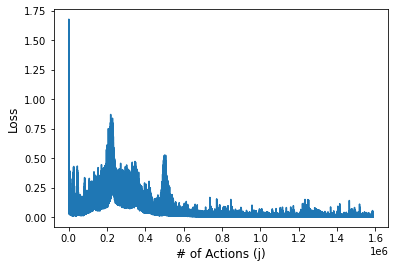

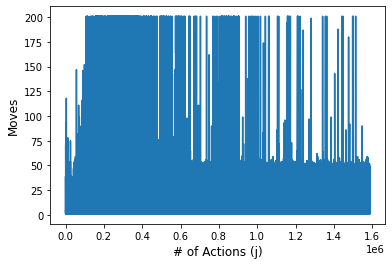

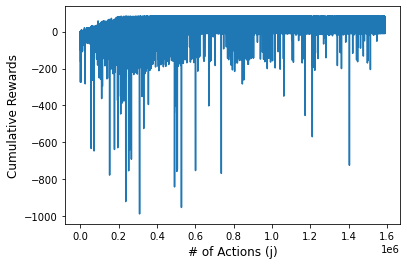

In [4]:
#def main(): # DDQN... Path 학습 모델

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU를 사용할 경우 ???
print('tensor in', device)  # GPU 사용 확인
# PATH = '/content/drive/MyDrive/aiffelthon/data/model_conv_colab.pt'
PATH = __file__ + '/eps.pt' ## PATH 경로 쉽게 수정
##############################################
tz = pytz.timezone('Asia/Seoul')
cur_time = datetime.now(tz)
start_time = cur_time.strftime("%H:%M:%S")

### 중요 Hyperparameters #####################
buffer_limit   = 100000     #1. 100000
batch_size     = 200        #2. 200
learning_rate  = 0.00025    #3. 0.00025
sync_freq      = 500        #4. 500: q 네트워크 파라미터를 q_target 네트워크에 복사하는 주기
train_start    = 50000      #5. 50000: (추가) 값이 작을 경우 경험이 아래 쪽에 편중됨
gamma = 0.99                #6. 0.99
# epochs = len(env.files)   #7. 훈련용 데이터 갯수
epochs         = 50000      #7. 한 군데 갔다 오는 경우에 사용. 반복 횟수는 각자 지정
max_moves      = 200        #8. 100
print_interval = 1000       #9. 100
# epsilon = 0.3             #10. annealing 대신 고정
##############################################
env = Simulator()  # 데이터셋 읽기. 그리드월드 크기 지정
q = Qnet()
q.to(device)
optimizer = optim.Adam(q.parameters(), lr=learning_rate)

train_model_load = False  # 학습한 모델을 불러와서 계속 학습시키고자 하는 경우 True로 바꾼다!!
if train_model_load:
    ###############################################################
    ## 학습한 모델 불러오기
    ###############################################################
    checkpoint = torch.load(PATH)
    q.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    q.train()
###############################################################
q_target = Qnet()
q_target.to(device)
q_target.load_state_dict(q.state_dict())
memory = ReplayBuffer()
### Hyperparameters #####################
losses = []
cum_rewards =[]
moves = []
j = 0
goal_ob_reward_count = 0 #9. epoch를 반복하면서 finish 카운팅
loss = 0.0
##############################################
# __file__ = '/content/drive/MyDrive/aiffelthon/data' 
### 액션 저장하는 txt파일 만들기 #######################
f = open(__file__ + '/eps_gif' + '.txt', 'w')
########################################################

for n_epi in range(epochs):
    reset_epi = n_epi % 39999
    epsilon = max(0.05, 1.00 - 0.1*(n_epi/2000)) # Linear annealing from 100% to 10%
    gridmap = env.reset(reset_epi)  # 에피소드 시작시 12개 값 초기화
    gridmap[9,4] = curloc_gridval                                   #0. 현재 gridmap에 [9,4]를 1로 표시
        # self.epi = epi                                            #1. 에피소드 번호 받기
        # self.items = list(self.files.iloc[self.epi])[0]           #2. 에피소드의 목적지 받기: [ 'H', 'L', 'M']
        # self.cumulative_reward = 0                                #3. 누적 보상값 = 0
        # self.terminal_location = None                             #4. 최초 목적지
        # self.local_target = []                                    #5. 목적지 리스트 초기화
        # self.actions = []                                         #6. 지나온 경로 리스트 초기화
        # self.grid = np.ones((self.height, self.width), dtype="float16")  #7. 그리드월드 전체 그리드값(1)로 초기화
        # self.set_box()                                            #8. 선반 위치(0), 목적지(2) 그리드값 설정.  목적지 리스트 생성
        # self.set_obstacle()                                       #9. 장애물 그리드값(0) 설정
        # self.curloc = [9, 4]                                      #10. 현재 위치를 출발점으로 세팅
        # self.grid[int(self.curloc[0])][int(self.curloc[1])] = -1  #11. 현재 위치(출발점) 그리드값(-1) 세팅
        # self.done = False                                         #12. 경로 찾기 종료 여부 = False
        # return self.grid

    # 초기 input은 (시작화면*4장)으로 들어감
    #####################################################################################
    history1 = np.stack((gridmap,gridmap,gridmap,gridmap), axis = 0) # 초기 state로 히스토리 초기화 (4,10,9)
    history1 = np.reshape([history1], (1,4,10,9)) # (배치, 채널, 가로, 세로) 로 reshape
    history1 = torch.from_numpy(history1).float() # 텐서로 변환   
    #####################################################################################

    done = False
    mov = 0

    while (not done):  # 최종 목적지 [9,4] 도착 또는 max_moves (=350) 초과하면 종료
        j += 1
        mov += 1
        # 상태 state1에서 action 결정
        #####################################################################################
        if env.curloc == [9,4]:  # 출발점에서는 무조건 위로 올라간다 (action=0)
            action = 0
        elif env.curloc[0] == 0 and env.curloc[1] in [0,1,2,3,4,5,6,7,8]:  # (0,0)~(0,8)에서는 무조건 아래로
            action = 1
        elif env.curloc[0] in [2,3,4,5] and env.curloc[1] == 8:  # (2,8)~(5,8)에서는 무조건 왼쪽으로
            action = 2
        elif env.curloc[0] in [2,3,4,5] and env.curloc[1] == 0:  # (2,0)~(5,0)에서는 무조건 오른쪽으로
            action = 3
        else:  # 위 경우를 제외하곤 e-greedy로 액션 선택
            action = q.sample_action(history1, epsilon)
        #####################################################################################
        # action = q.sample_action(state1, epsilon)  # 위 조건을 적용 안 할 경우
        # make Move... action에 따른 이동
        gridmap, reward, cum_reward, done = env.step(action)
            # self.actions.append((new_x, new_y))...새로 도착한 위치를 경로 리스트에 추가
            # 누적 보상 계산
        ###########################
        # print(gridmap.reshape(10,9))
        ###########################

        #####################################################################################
        # next input 만들어주기
        next_gridmap = np.reshape([gridmap],(1,1,10,9))                                             # 다음 그리드를 히스토리 사이즈에 맞게 reshape
        next_gridmap = torch.from_numpy(next_gridmap).float()                                       # 텐서로 변환
        history2 = torch.cat([next_gridmap,history1[:,:3,:,:]],dim=1) # (1,1+3,10,9)                # 지금 있는 히스토리중 마지막 채널을 지우고 new를 제일 앞에 붙임

        done_mask = 0.0 if done else 1.0
        memory.put((history1, action, reward, history2, done_mask))  # 경험을 메모리에 저장
        history1 = history2
        #####################################################################################

        # if memory.size() > train_start:  # 메모리에 train_start 크기 이상 쌓이면... 미니배치 훈련
        if j > train_start:  # 메모리에 미니배치 크기 이상 쌓이면... 미니배치 훈련
            #print('memory size:', memory.size())
            loss = train(q, q_target, memory, optimizer)
            if j % print_interval == 0:
                print('epiode #:', n_epi, 'loss:', loss, 'j:', j)
            losses.append(loss)
            cum_rewards.append(cum_reward)
            moves.append(mov)
            

            if j % sync_freq == 0:  # sync_freq마다 q 네트워크 파라미터를 q_target 네트워크로 복사
                q_target.load_state_dict(q.state_dict())

        ############## 현황 모니터링 #############################################################
        if done and j % 100 == 0:  # 100번 마다 mov 횟수 저장:
        #     moves.append(mov)
            print('종료: done =', done, '... j =', j, ' move =', mov)
        if env.goal_ob_reward:  # 최종 목적지 도달한 경우에만 화면에 표시
            goal_ob_reward_count += 1
            print(env.local_target_original, '종료: env.goal_ob_reward =', env.goal_ob_reward, '... j =', j, ' move =', mov, '@ 에피소드 #', n_epi)
            print(f"{n_epi}번째 에피소드까지 총 {goal_ob_reward_count}번 finish 했습니다.")
            ### finish record 저장하는 txt파일 만들기
            with open(__file__ + '/eps_log.txt', 'a') as finish_record:
                finish_record.write(str(goal_ob_reward_count)+" "+str(env.local_target_original[-2])+" "+str(cum_reward)+" "+\
                                    str(mov)+" "+str(j)+" "+str(n_epi)+"\n")
        ##########################################################################################

        if done or mov > max_moves:
            mov = 0
            done = True
    
    # while loop 종료 ----- 최종 목적지 [9,4] 도착 또는 max_moves (=350) 초과

    if j > train_start:  # 메모리에 train_start 크기 이상 쌓이면... 미니배치 훈련
        if (n_epi % 10000 == 0 and n_epi != 0) or n_epi >= epochs - 1:
            torch.save({'epoch': n_epi, 
                        'model_state_dict': q.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(), 
                        'loss': loss, 
                        }, PATH)
            print('▶ 모델 저장됨!!! @ 에피소드', n_epi)

        ##### gif 생성을 위한 경로(env.actions) 저장 ####################################    
        if n_epi % 1000 == 0 or env.goal_ob_reward:
            f.write(str(n_epi)+'/'+str(env.local_target_original)+'\n')
            f.write(str(env.actions))
            f.write('\n')
        ######################################### 
f.close()
#########################################
## 프로그램 시작 및 종료 시간 출력
cur_time = datetime.now(tz)
end_time = cur_time.strftime("%H:%M:%S")
print ('실행 종료!', 'Start@', start_time, 'End@', end_time)
        #cur_time = datetime.now(tz)
        #simple_cur_time = cur_time.strftime("%H:%M:%S")
        #print('▶ Episode #', iter, 'start time:', simple_cur_time, end='→')

print(gridmap.reshape(10,9))  # 최종 그리드맵 확인

## loss 그래프
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.xlabel("# of Actions (j)",fontsize=12)
plt.ylabel("Loss",fontsize=12)

## 경로길이(이동 횟수) 그래프
plt.figure(figsize=(6,4))
plt.plot(moves)
plt.xlabel("# of Actions (j)",fontsize=12)
plt.ylabel("Moves",fontsize=12)

## 보상값(cum_rewards) 그래프
plt.figure(figsize=(6,4))
plt.plot(cum_rewards)
plt.xlabel("# of Actions (j)",fontsize=12)
plt.ylabel("Cumulative Rewards",fontsize=12)

## 테스트 코드

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU를 사용할 경우 ???
print('tensor in', device)  # GPU 사용 확인
PATH = __file__ + '/eps.pt' ## PATH 경로 쉽게 수정
train_mode = False
## test 코드 #################################################################################
def test(epochs=1000, train_mode=False, display=False, model_load=True, PATH=PATH):  # train_mode = False 테스트 모드

    test_env = Simulator()  # 데이터셋 읽기. 그리드월드 크기 지정
    test_q = Qnet()
    test_q.to(device)
    learning_rate = 0.00025    #3. 0.0005
    optimizer = optim.Adam(test_q.parameters(), lr=learning_rate)

    if model_load:
        ###############################################################
        ## 학습한 모델 불러오기
        ###############################################################
        checkpoint = torch.load(PATH)
        # checkpoint = torch.load(PATH, map_location=torch.device('cpu'))  ###### gpu 저장 모델 cpu 로드시 #####
        test_q.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        test_q.eval()

    epochs = len(test_env.files)
    wins = 0
    j = 0
    total_reward = 0.0

    ##### 이미 존재하는 테스트 결과 저장한 파일 지우기
    test_record_file_path = __file__ + '/eps_test_record.txt'
    if os.path.exists(test_record_file_path):
        os.remove(test_record_file_path)
    ##### 이미 존재하는  gif 생성을 위한 파일 지우기 ####################################    
    test_gif_file_path = __file__ + '/eps_test_gif.txt'
    if os.path.exists(test_gif_file_path):
        os.remove(test_gif_file_path)

    for n_epi in range(epochs):
        gridmap = test_env.reset(n_epi)  # 에피소드 시작시 12개 값 초기화
        history_ = np.stack((gridmap,gridmap,gridmap,gridmap), axis = 0) # 초기 state로 히스토리 초기화 (4,10,9)
        history = np.reshape([history_], (1,4,10,9)) # (배치, 채널, 가로, 세로) 로 reshape
        history = torch.from_numpy(history).float() # 텐서로 변환   
        done = False
        mov = 0
        while (not done):  # 최종 목적지 [9,4] 도착
            mov += 1
            j += 1
            # 상태 state1에서 action 결정
            #####################################################################################
            if test_env.curloc == [9,4]:  # 출발점에서는 무조건 위로 (action=0)
                action = 0
            elif test_env.curloc[0] == 0 and test_env.curloc[1] in [0,1,2,3,4,5,6,7,8]:  # (0,0)~(0,8)에서는 무조건 아래로
                action = 1
            elif test_env.curloc[0] in [2,3,4,5] and test_env.curloc[1] == 8:  # (2,8)~(5,8)에서는 무조건 왼쪽으로
                action = 2
            elif test_env.curloc[0] in [2,3,4,5] and test_env.curloc[1] == 0:  # (2,0)~(5,0)에서는 무조건 오른쪽으로
                action = 3
            else:  # 위 경우를 제외하곤 test 액션 선택
                action = test_q.test_action(history)
            #####################################################################################
            # action = test_q.test_action(history)  # 위 조건을 적용하지 않을 경우
            # make Move... action에 따른 이동
            gridmap, reward, cum_reward, done = test_env.step(action)

            next_gridmap_ = np.reshape([gridmap],(1,1,10,9)) # 다음 그리드를 히스토리 사이즈에 맞게 reshape
            next_gridmap = torch.from_numpy(next_gridmap_).float() # 텐서로 변환
            new_history = torch.cat([next_gridmap, history[:,:3,:,:]],dim=1) # (1,1+3,10,9)
            # 지금 있는 히스토리중 마지막 채널을 지우고 new를 제일 앞에 붙임
            history = new_history

            if display:
                print('Move #%s; Taking action: %s' % (mov, action))
                print(gridmap.reshape(10,9))

            if test_env.goal_ob_reward:
                wins += 1
                if display:
                    print("Game won! Reward: %s" % (cum_reward))
                    
            if (mov > 50):  # 경로 길이가 너무 길어서 제외시키는 조건 추가 필요시 사용
                if display:
                    print("Game lost; too many moves.")
                break
        
        total_reward += cum_reward
        avg_reward = total_reward / (n_epi+1)

        print('Episode: {0:04d}   Timestep: {1:05d}   Moves: {2:02d}   Average Reward: {3:0.2f}   Finish Rate: {4:0.2f}'.\
              format(n_epi, j, mov, avg_reward, wins/(n_epi+1)))
        ### 테스트 결과 저장하는 txt파일 만들기
        with open(test_record_file_path, 'a') as test_record:
            test_record.write("Episode: "+str(n_epi)+" Timestep:"+str(j)+" Moves: "+str(mov)+" Average Reward: "+\
                                str(avg_reward)+" Finish Rate: "+str(wins/(n_epi+1))+"\n")

        ##### gif 생성을 위한 경로(env.actions) 저장 ####################################    
        with open(test_gif_file_path, 'a') as test_gif:
            test_gif.write(str(n_epi)+'/'+str(test_env.local_target_original)+'\n')
            test_gif.write(str(test_env.actions))
            test_gif.write('\n')
        ######################################### 

    win_perc = float(wins) / float(epochs)
    print("Test performed: {0}, # of wins: {1}".format(epochs,wins))
    print("Win percentage: {}%".format(100.0*win_perc))
    return win_perc

tensor in cuda


In [13]:
test(display=False)

data/factory_order_test.csv used
Episode: 0000   Timestep: 00044   Moves: 44   Average Reward: 81.94   Finish Rate: 1.00
Episode: 0001   Timestep: 00086   Moves: 42   Average Reward: 81.82   Finish Rate: 1.00
Episode: 0002   Timestep: 00126   Moves: 40   Average Reward: 81.74   Finish Rate: 1.00
Episode: 0003   Timestep: 00170   Moves: 44   Average Reward: 76.53   Finish Rate: 1.00
Episode: 0004   Timestep: 00210   Moves: 40   Average Reward: 75.77   Finish Rate: 1.00
Episode: 0005   Timestep: 00252   Moves: 42   Average Reward: 76.95   Finish Rate: 1.00
Episode: 0006   Timestep: 00294   Moves: 42   Average Reward: 76.23   Finish Rate: 1.00
Episode: 0007   Timestep: 00336   Moves: 42   Average Reward: 77.05   Finish Rate: 1.00
Episode: 0008   Timestep: 00378   Moves: 42   Average Reward: 76.36   Finish Rate: 1.00
Episode: 0009   Timestep: 00420   Moves: 42   Average Reward: 77.01   Finish Rate: 1.00
Episode: 0010   Timestep: 00464   Moves: 44   Average Reward: 77.46   Finish Rate: 1.00

1.0

In [ ]:
test(display=False)